# UB DataScience: Complex networks
## Final delivery: Barcelona bus network



<br>
### David Solans & Gerard Martinez

In [1]:
# Required Python imports
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import collections
import folium
#import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import operator
from networkx.algorithms import community
import community as comm

## Required for data scrapping
import urllib.request
from bs4 import BeautifulSoup
from selenium import webdriver

%matplotlib inline

### Obtaining the data

In [2]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
G_busnew=load_obj("NEW_bus_stations_properties")
G_bus = nx.read_edgelist("barcelona_bus.edgelist", create_using = nx.Graph(), nodetype = int)

In [4]:
bus_stations_properties = load_obj("bus_stations_properties")

bus_stops_coords = []
bus_stops_names = []
bus_stops_coords_lats = []
bus_stops_coords_lngs = []
for bs in bus_stations_properties.values():
    bus_stops_coords.append([bs['lat'], bs['lon']])
    bus_stops_coords_lats.append(float(bs['lat']))
    bus_stops_coords_lngs.append(float(bs['lon']))
    bus_stops_names.append(bs['street_name'])

In [5]:
print('Old bus line: \n',nx.info(G_bus))
print('\nNew bus line:',nx.info(G_busnew))

Old bus line: 
 Name: 
Type: Graph
Number of nodes: 2469
Number of edges: 3127
Average degree:   2.5330

New bus line: Name: 
Type: Graph
Number of nodes: 2374
Number of edges: 3149
Average degree:   2.6529


In [6]:
def nodespercomponent(G):
    interest_edges = []
    for i in nx.connected_component_subgraphs(G):
        interest_edges.append(i.nodes())
    compt=0
    for i in interest_edges:
        print('Number of nodes disconnected component',compt+1)
        print(len(i))
        compt+=1;

In [7]:
nodespercomponent(G_bus)

Number of nodes disconnected component 1
2357
Number of nodes disconnected component 2
22
Number of nodes disconnected component 3
90


In [8]:
nodespercomponent(G_busnew)

Number of nodes disconnected component 1
2260
Number of nodes disconnected component 2
91
Number of nodes disconnected component 3
23


In [20]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

### Data exploration

### Data visualization

In [21]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

stops = pd.read_csv("gtfs/stops.txt")
lats = stops.stop_lat.values
lngs = stops.stop_lon.values
#columns=["Lat", "Lon"],
new_df = pd.DataFrame( data={"Lat":lats, "Long":lngs})
new_df.head()
geometry = [Point(xy) for xy in zip(lngs, lats)]

crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(new_df, crs=crs, geometry=geometry)

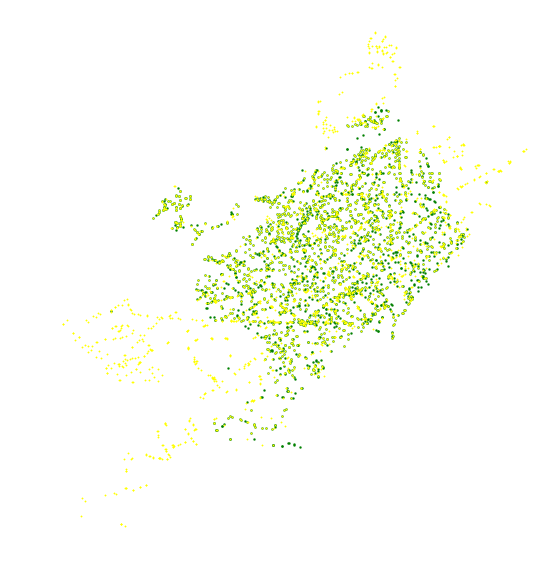

In [23]:
bus_stations_properties=load_obj("bus_stations_properties")
bus_stations_properties

bus_stops_coords_lats = []
bus_stops_coords_lngs = []
for bs in bus_stations_properties.items():
    bus_stops_coords_lats.append(float(bs[1]['lat']))
    bus_stops_coords_lngs.append(float(bs[1]['lon']))

geometry2 = [Point(xy) for xy in zip(bus_stops_coords_lngs, bus_stops_coords_lats)]


new_df2 = pd.DataFrame( data={"Lat":bus_stops_coords_lats, "Long":bus_stops_coords_lngs})

crs = {'init': 'epsg:4326'}
gdf2 = GeoDataFrame(new_df2, crs=crs, geometry=geometry2)

ax = gdf2[gdf2['Lat']<41.4686].plot(figsize=[10,10], color='green', markersize=4)
ax.set_axis_off()
gdf.plot(ax=ax, color='yellow', markersize=2)


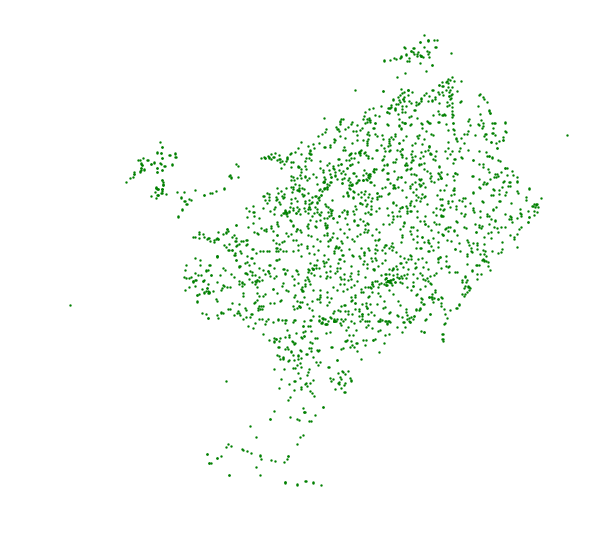

In [24]:
gdf2 = GeoDataFrame(new_df2, crs=crs, geometry=geometry2)

ax = gdf2[gdf2['Lat']<41.4686].plot(figsize=[10,10], color='green', markersize=4)
ax.set_axis_off()

### Microscale

* Average shortest path
* Comparación 
* Radio
* Diametro
* Node centralities
* Degree
* Betweeness
* Closeness
* Periphery + plot

### Macroscale

* Clustering (?)

### Random graphs comparison
* Connected Watts Strotgaz
* Erdos Renyi
* Barabsi Albert

### Mesoscale

In [9]:
### Helper functions
## Plot communities
def plot_communities(G, partitions, title):
    # Plot, color nodes using community structure
    values = [partitions.get(node) for node in G.nodes()]
    nx.draw_spring(G, cmap=plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
    plt.title(title)
    
    print("Modularity: %s" % comm.modularity(partitions,G))
    print("Total number of communities: %i" % len(set(val for val in partitions.values())))
    print("Total number of nodes: %i" % len(partitions.values()))
   
    plt.show()
    
## Partition to dict
def partition_to_dict(partitions, G):
    result = {}
    c = 0
    
    for partition_idx, partitions in enumerate(partitions):
        for j in list(partitions):
            result[j] = partition_idx
        c+=1
            
            
    for n in G.nodes():
        if n not in result:
            result[n] = c
            c+=1

    return result

#### Cliques

In [10]:
MAX_CLICKES = 6

print(" -- Old network -- ")
num_nodes_clickes_old = []
for i in range(2,MAX_CLICKES):
    c_old = list(nx.algorithms.community.k_clique_communities(G_bus, i))
    print("Num nodes part of clickes size %i --> %i" % (i ,len([item for sublist in c_old for item in sublist])))
    num_nodes_clickes_old.append(len([item for sublist in c_old for item in sublist]))
    
print(" -- New network -- ")
num_nodes_clickes_new = []
for i in range(2,MAX_CLICKES):
    c_new = list(nx.algorithms.community.k_clique_communities(G_busnew, i))

    print("Num nodes part of clickes size %i --> %i" % (i ,len([item for sublist in c_new for item in sublist])))
    num_nodes_clickes_new.append(len([item for sublist in c_new for item in sublist]))
    


 -- Old network -- 
Num nodes part of clickes size 2 --> 2469
Num nodes part of clickes size 3 --> 80
Num nodes part of clickes size 4 --> 0
Num nodes part of clickes size 5 --> 0
 -- New network -- 
Num nodes part of clickes size 2 --> 2374
Num nodes part of clickes size 3 --> 196
Num nodes part of clickes size 4 --> 4
Num nodes part of clickes size 5 --> 0


#### Label partition

Modularity: 0.565795000250049
Total number of communities: 753
Total number of nodes: 2469


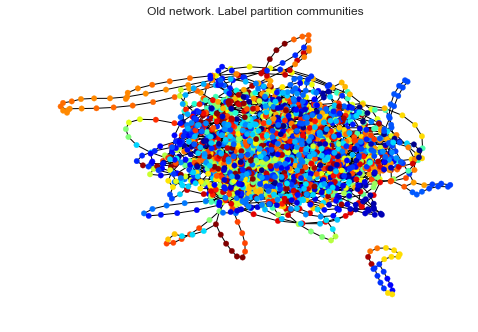

In [11]:
# Old network
label_prop_partition = nx.algorithms.community.label_propagation_communities(G_bus)
label_prop_partition_dict = partition_to_dict(label_prop_partition, G_bus)
plot_communities(G_bus, label_prop_partition_dict, "Old network. Label partition communities")

Modularity: 0.565795000250049
Total number of communities: 753
Total number of nodes: 2469


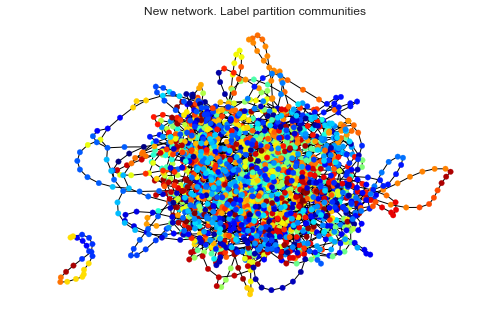

In [12]:
# New network
label_prop_partition = nx.algorithms.community.label_propagation_communities(G_bus)
label_prop_partition_dict = partition_to_dict(label_prop_partition, G_bus)
plot_communities(G_bus, label_prop_partition_dict, "New network. Label partition communities")

#### Fluid communities

Modularity: 0.43439992456634685
Total number of communities: 1112
Total number of nodes: 2469


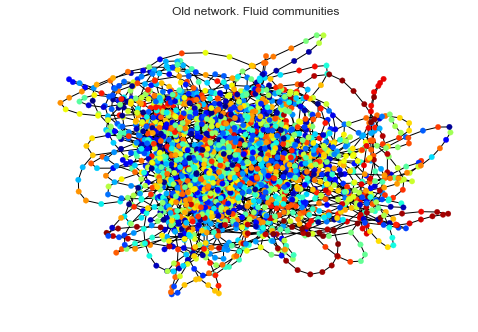

In [13]:
# Old network
fluid_communities_partitions = nx.algorithms.community.asyn_fluidc(list(nx.connected_component_subgraphs(G_bus))[0], 1000)
fluid_communities_dict = partition_to_dict(fluid_communities_partitions, G_bus)
plot_communities(G_bus, fluid_communities_dict, "Old network. Fluid communities")

Modularity: 0.4354624820533564
Total number of communities: 1114
Total number of nodes: 2374


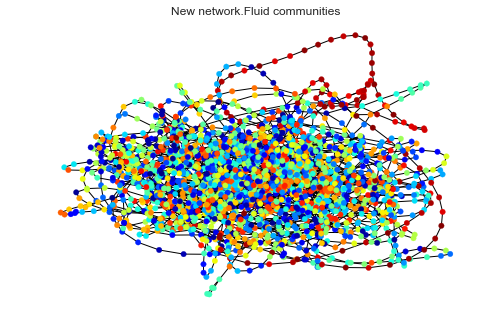

In [14]:
# New network
fluid_communities_partitions = nx.algorithms.community.asyn_fluidc(list(nx.connected_component_subgraphs(G_busnew))[0], 1000)
fluid_communities_dict = partition_to_dict(fluid_communities_partitions, G_busnew)
plot_communities(G_busnew, fluid_communities_dict, "New network.Fluid communities")

#### Louvain

Modularity: 0.8574269167445017
Total number of communities: 29
Total number of nodes: 2469


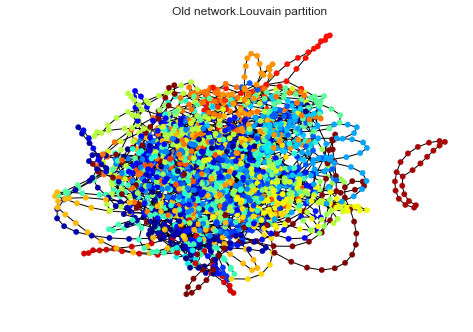

In [17]:
# Old network
louvain_partition = comm.best_partition(G_bus)

plot_communities(G_bus, louvain_partition, "Old network.Louvain partition")

Modularity: 0.8880890474083776
Total number of communities: 30
Total number of nodes: 2374


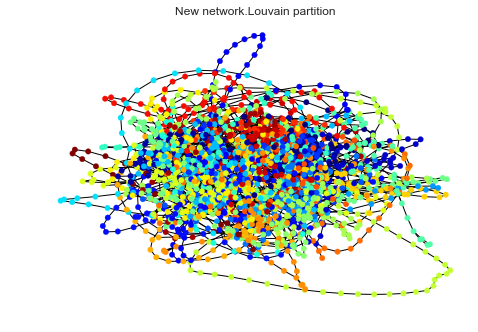

In [18]:
# New network
louvain_partition = comm.best_partition(G_busnew)

plot_communities(G_busnew, louvain_partition, "New network.Louvain partition")

### Dynamic models
* #### SIS Model

In [ ]:
## Infecting Pl del Nou

num_infections = []
for i in tqdm.tqdm(range(5)):
    g=G
    g.pos = nx.spring_layout(g)
    for i in g.nodes():
        if i == 'Pl del Nou':
            print("NODE INFECTED: ", i)

            g.node[i]['state'] =  1
        else:

            g.node[i]['state'] =  0 ## I have changed 0.5 per 0.01 I want the bus line to be 
                                                               ## fully operative
                                                            ## 0 means it works well  
                                                            ## 1 means failure

    for i in range(1,1000000):
        a = rd.choice(list(g.nodes()))
        if g.node[a]['state'] == 0: # if susceptible
            infected_neighbors = False
            for b in list(g.neighbors(a)):
                if g.node[b]['state'] == 1 and not infected_neighbors: # if neighbor b is infected
                    infected_neighbors = True
                    g.node[a]['state'] = 1 if rd.random() < p_i else 0 
        else: # if infected
            g.node[a]['state'] = 0 if rd.random() < p_r else 1

    infected = [n for n in g.nodes() if g.node[n]['state']==1]
    print("INFECTED: ", len(infected))
    num_infections.append(len(infected))
print(sum(num_infections)/len(num_infections))
nx.draw(g, cmap = colors.ListedColormap(['#5adf16', 'red']), vmin = 0, vmax = 1,node_color = [g.node[i]['state'] for i in g.nodes()], pos=g.pos)

In [ ]:
## Infecting Pl Espanya - FGC
num_infections = []
for i in tqdm.tqdm(range(5)):
    g=G_busnew
    g.pos = nx.spring_layout(g)
    for i in g.nodes():
        if i ==  'Pl Espanya - FGC':
            print("NODE INFECTED: ", i)

            g.node[i]['state'] =  1
        else:

            g.node[i]['state'] =  0 ## I have changed 0.5 per 0.01 I want the bus line to be 
                                                               ## fully operative
                                                            ## 0 means it works well  
                                                            ## 1 means failure

    for i in range(1,1000000):
        a = rd.choice(list(g.nodes()))
        if g.node[a]['state'] == 0: # if susceptible
            infected_neighbors = False
            for b in list(g.neighbors(a)):
                if g.node[b]['state'] == 1 and not infected_neighbors: # if neighbor b is infected
                    infected_neighbors = True
                    g.node[a]['state'] = 1 if rd.random() < p_i else 0 
        else: # if infected
            g.node[a]['state'] = 0 if rd.random() < p_r else 1

    infected = [n for n in g.nodes() if g.node[n]['state']==1]
    print("INFECTED: ", len(infected))
    num_infections.append(len(infected))
print(sum(num_infections)/len(num_infections))
nx.draw(g, cmap = colors.ListedColormap(['#5adf16', 'red']), vmin = 0, vmax = 1,node_color = [g.node[i]['state'] for i in g.nodes()], pos=g.pos)

**Average shortest path**

In [18]:
# Average separation of nodes in bus
node_distances_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_distances_bus.append(nx.average_shortest_path_length(g)) 

print("Average separation of nodes in bus network: {}".format(node_distances_bus[0]))   

Average separation of nodes in bus network: 14.307380464793308


In [19]:
# Average separation of nodes in bus
node_distances_bus = []
for g in nx.connected_component_subgraphs(G_busnew): 
    node_distances_bus.append(nx.average_shortest_path_length(g)) 

print("Average separation of nodes in bus network: {}".format(node_distances_bus[0]))   

Average separation of nodes in bus network: 20.986992443206525


** Radius **

In [20]:
node_radius_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_radius_bus.append(nx.radius(g)) 

   
print("Diametre per connected component: {}".format(node_radius_bus))

Diametre per connected component: [20, 6, 14]


Stations that are in the center

In [21]:
center_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    center_bus.append(nx.center(g)) 

print("Centers per connected component: {}".format(center_bus))

Centers per connected component: [[149, 1067, 1069, 1081, 1246, 2833], [1804, 1816, 2149, 501], [2573, 2074, 2075, 2076, 2209, 3005, 3006]]


In [22]:
compt=0
for i in center_bus:
    print('DISCONNEX COMPONENT',compt+1)
    for j in range(0,len(i)):
        print(bus_stations_properties[i[j]]['street_name'])
    compt+=1;
    print('\n')

DISCONNEX COMPONENT 1
Gran Via-Roger de Llúria
Pl Urquinaona-Pau Claris
Metro Urquinaona
Gran Via-Pau Claris
Gran Via-Bruc
Pg de Gràcia-Ronda de Sant Pere


DISCONNEX COMPONENT 2
Camí Vell
Mont d'Orsà
Pl Tibidabo
Colònia Tibidabo


DISCONNEX COMPONENT 3
Ctra de l'Esglèsia-Camí del Faig
Torrent del Rovelló-Camí del Pantá
Torrent del Rovelló-Camí Baix del Mas Sauró
Camí Alt del Mas Sauró-Font Mosen Cinto Verdaguer
Pl de Vallvidrera
Pg del Grèvol
Pg del Grèvol-Camí de Can Castellví




new bus

In [23]:
node_radius_bus = []
for g in nx.connected_component_subgraphs(G_busnew): 
    node_radius_bus.append(nx.radius(g)) 

   
print("Diametre per connected component: {}".format(node_radius_bus))

Diametre per connected component: [34, 11, 19]


In [24]:
center_busnew = []
for g in nx.connected_component_subgraphs(G_busnew):
    center_busnew.append(nx.center(g)) 

In [25]:
print("Centers per connected component: {}".format(center_busnew))

Centers per connected component: [['Pl Bonanova', 'Pg Sant Gervasi - Pl Bonanova'], ['Ctra de Vallvidrera al Tibidabo', 'Funicular de Vallvidrera', 'Pl Tibidabo', 'Parc de la Budellera', 'Ctra. Vallvidrera al Tibidabo, 2-4', 'Camí Vell', "Mont d'Orsà - Pl Vallvidrera", 'Ctra de Vallvidrera - El Castanyer', 'Cruïlla de Carreteres', 'Colònia Tibidabo', 'Pl de Vallvidrera - Alberes', 'Camí de Vallvidrera - Camí de Cal Totxo', 'Funicular de Vallvidrera - Pl Pep Ventura', 'Accés Escola Judicial', "Camí Santa Creu d'Olorda", 'Ctra de Vallvidrera - Accés Escola Judicial', 'Ctra de Vallvidrera - St Cugat', 'Mentora Alsina', 'Torre de Collserola', "Ctra de Vallvidrera - Camí de l'Observatori", "Mont d'Orsà", 'Ctra de Vallvidrera - Cruïlla de Carreteres', "Mont d'Orsà - Romanimar"], ['Torrent del Rovelló - Camí del Pantà']]


Component 2 we choose Mont d'Orsà - Pl Vallvidrera,Pl de Vallvidrera - Alberes,Ctra. Vallvidrera al Tibidabo, 2-4,Mont d'Orsà - Romanimar

In [26]:
listacordlatcentre1=[41.40711801400388,41.40651851400358]
listacordlngcentre1=[2.1338799999999765,2.1338095999999496]

listacordlatcentre2=[41.41294801400678,41.412984014006774,41.416019014008256,41.4110340140058]
listacordlngcentre2=[2.1042289999999184,2.1046669999999494,2.110604999999964,2.1029029999999693]

listacordlatcentre3=[41.41943091400994]
listacordlngcentre3=[2.096936199999959]

In [67]:
## Plotting the bus stops on a map
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)


for lng, lat in zip(listacordlngcentre1,listacordlatcentre1):
    folium.Circle([lat, lng], radius=250,color='#27cc53',fill=True,fill_color='#27cc53').add_to(map_osm)

    
for lng, lat in zip(listacordlngcentre2,listacordlatcentre2):
    folium.Circle([lat, lng], radius=250, color='#3186cc',fill=True, fill_color='#3186cc').add_to(map_osm)
    
for lng, lat in zip(listacordlngcentre3,listacordlatcentre3):
    folium.Circle([lat, lng], radius=250, color='#f40101',fill=True, fill_color='#f40101').add_to(map_osm)
map_osm

### Periphery 

In [69]:
node_periphery_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_periphery_bus.append(nx.periphery(g)) 

   
print("Periphery per connected component: {}".format(node_periphery_bus))
#print("Average diameter in bus network: {}".format(np.mean(node_periphery_bus)))

Periphery per connected component: [[2780, 2781, 3034], [1812, 1820], [2085, 2086, 2299, 2300, 2303]]


In [70]:
component_periphery=[]
bus_stops_coords_lngs_component_periphery=[]
bus_stops_coords_lats_component_periphery=[]
for j in range(0,len(node_periphery_bus)): 
    for i in node_periphery_bus[j]:
        try:
            bus_stops_coords_lngs_component_periphery.append(float(bus_stations_properties[i]['lon']))
            bus_stops_coords_lats_component_periphery.append(float(bus_stations_properties[i]['lat']))
        except KeyError:
            pass

In [71]:
## Plotting the bus stops on a map
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)


for lng, lat in zip(bus_stops_coords_lngs_component_periphery[0:len(node_periphery_bus[0])],
                         bus_stops_coords_lats_component_periphery[0:len(node_periphery_bus[0])]):
    folium.Circle([lat, lng], radius=250,color='#27cc53',fill=True,fill_color='#27cc53').add_to(map_osm)


for lng, lat in zip(bus_stops_coords_lngs_component_periphery[len(node_periphery_bus[0]):(len(node_periphery_bus[0])+len(node_periphery_bus[1]))],
                    bus_stops_coords_lats_component_periphery[len(node_periphery_bus[0]):(len(node_periphery_bus[0])+len(node_periphery_bus[1]))]):
    folium.Circle([lat, lng], radius=250, color='#3186cc',fill=True,fill_color='#3186cc').add_to(map_osm)
    ##Blue dots is the disconnected component 2
    
for lng, lat in zip(bus_stops_coords_lngs_component_periphery[(len(node_periphery_bus[0])+len(node_periphery_bus[1])):],
                    bus_stops_coords_lats_component_periphery[(len(node_periphery_bus[0])+len(node_periphery_bus[1])):]):
    folium.Circle([lat, lng], radius=250,color='#f40101',fill=True,fill_color='#f40101').add_to(map_osm)
    ##Red dots is the disconnected component 3
    
map_osm

In [46]:
compt=0
for i in node_periphery_bus:
    print('DISCONNEX COMPONENT',compt+1)
    for j in range(0,len(i)):
        if i[j]!=3034:
            print(bus_stations_properties[i[j]]['street_name'])
    compt+=1;
    print('\n')

DISCONNEX COMPONENT 1
Maurici Vilomara-Penyal
Penyal-Pl Font d'en Fargas


DISCONNEX COMPONENT 2
Parc de la Budellera
Ctra de Vallvidrera-Cruïlla de Carreteres


DISCONNEX COMPONENT 3
Camí Baix del Mas Sauró direcció Mas Guimbau
Torrent del Rovelló direcció Mas Guimbau
Pl de la Tulipa-Satèl·lits
Orellana-Passatge Ossa Major
Orellana




For the new bus network

In [72]:
node_periphery_bus = []
for g in nx.connected_component_subgraphs(G_busnew): 
    node_periphery_bus.append(nx.periphery(g)) 

In [73]:
print("Centers per connected component: {}".format(node_periphery_bus))

Centers per connected component: [['Av Catalunya - Ramon i Cajal', 'Onze de Setembre - Pg  del Canal', 'Av Catalunya - Frederic Mompou'], ['Ctra de Vallvidrera al Tibidabo', 'Funicular de Vallvidrera', 'Pl Tibidabo', 'Parc de la Budellera', 'Ctra. Vallvidrera al Tibidabo, 2-4', 'Camí Vell', "Mont d'Orsà - Pl Vallvidrera", 'Ctra de Vallvidrera - El Castanyer', 'Cruïlla de Carreteres', 'Colònia Tibidabo', 'Pl de Vallvidrera - Alberes', 'Camí de Vallvidrera - Camí de Cal Totxo', 'Funicular de Vallvidrera - Pl Pep Ventura', 'Accés Escola Judicial', "Camí Santa Creu d'Olorda", 'Ctra de Vallvidrera - Accés Escola Judicial', 'Ctra de Vallvidrera - St Cugat', 'Mentora Alsina', 'Torre de Collserola', "Ctra de Vallvidrera - Camí de l'Observatori", "Mont d'Orsà", 'Ctra de Vallvidrera - Cruïlla de Carreteres', "Mont d'Orsà - Romanimar"], ['Camí del Mas Guimbau - Gespa', 'Av del Rectoret - Baladre', 'Gespa - la Gatosa']]


Component 1
Onze de Setembre - Pg  del Canal --> 41.375959013988506,2.0479629999999815

Av Catalunya - Frederic Mompou --> 41.498528014048986,2.18472399999996

Av Catalunya - Ramon i Cajal --> 41.497267014048354,2.184035999999992

In [74]:
listacordlat1=[41.375959013988506,41.498528014048986,41.497267014048354]
listacordlng1=[2.0479629999999815,2.18472399999996,2.184035999999992]

In [75]:
listacordlat2=[41.4253660140129, 41.41294801400678,41.412984014006774]
listacordlng2=[2.121348000000012, 2.1042289999999184,2.1046669999999494]

Component 2
'Av del Rectoret - Baladre'

'Gespa - la Gatosa', 

'Camí del Mas Guimbau - Gespa'

In [76]:
listacordlat3=[41.42592501401316,41.424583014012505,41.42401101401221]
listacordlng3=[2.0930399999999736,2.089627999999948,2.0906330000000253]

In [77]:
## Plotting the bus stops on a map
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)


for lng, lat in zip(listacordlng1,listacordlat1):
    folium.Circle([lat, lng], radius=250, color='#27cc53',fill=True,fill_color='#27cc53').add_to(map_osm)

    
for lng, lat in zip(listacordlng2,listacordlat2):
    folium.Circle([lat, lng], radius=250, color='#3186cc',fill=True,fill_color='#3186cc').add_to(map_osm)
    
for lng, lat in zip(listacordlng3,listacordlat3):
    folium.Circle([lat, lng], radius=250, color='#f40101',fill=True,fill_color='#f40101').add_to(map_osm)
map_osm

## Node centrality

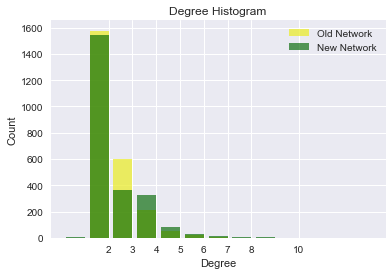

In [72]:
# Nodes degree histogram
degree_sequence = sorted([d for n, d in G_bus.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

degree_sequencenew = sorted([d for n, d in G_busnew.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCountnew = collections.Counter(degree_sequencenew)
degnew, cntnew = zip(*degreeCountnew.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='#eaec2f',alpha=0.75,label='Old Network')
plt.bar(degnew, cntnew, width=0.80, color='#016701',alpha=0.65,label='New Network')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.legend(loc='upper right')
ax.set_xticklabels(deg)
plt.show()

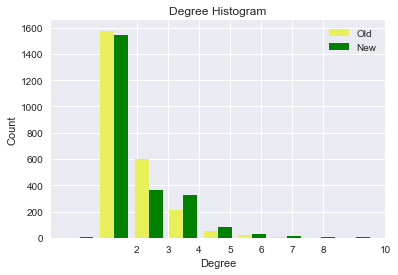

In [139]:
# Nodes degree histogram
degree_sequence = sorted([d for n, d in G_bus.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

degree_sequencenew = sorted([d for n, d in G_busnew.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCountnew = collections.Counter(degree_sequencenew)
degnew, cntnew = zip(*degreeCountnew.items())

fig, ax = plt.subplots()
#plt.bar(deg, cnt, width=0.80, color='#eaec2f',alpha=0.75,label='Old Network')
bins = np.linspace(0, 10, 10)
plt.hist([degree_sequence,degree_sequencenew],bins,label=['Old', 'New'],color=['#e7f05b','green'])
#plt.bar(deg, cnt, width=0.80, color='#eaec2f',alpha=0.75,label='Old Network')
#plt.bar(degnew, cntnew, width=0.80, color='#016701',alpha=0.65,label='New Network')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.legend(loc='upper right')
ax.set_xticklabels(deg)
plt.show()

** betweenness_centrality **

In [187]:
node_betweenness_centrality = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_betweenness_centrality.append(nx.betweenness_centrality_source(g)) 

In [188]:
betweenness_centrality_source = nx.betweenness_centrality_source(G_bus)

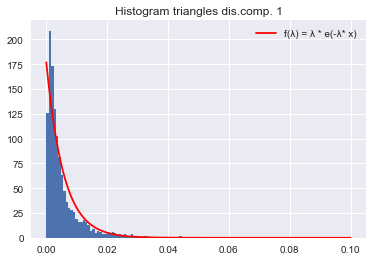

In [190]:
from scipy import stats

lnspc=np.linspace(0,0.1,len(list(node_betweenness_centrality[0].values())))
ag,bg = stats.expon.fit(list(node_betweenness_centrality[0].values()))   ##bg is the scale, ag i do not know
pdf_gamma = stats.expon.pdf(lnspc, loc=ag, scale=bg)  



plt.hist(list(node_betweenness_centrality[0].values()), bins=100,normed=True)
plt.plot(lnspc, pdf_gamma, label="f(λ) = λ * e(-λ* x)",color='red') 
#axarr[0].plot(lnspc, pdf_g, label="Norm",color='red')
#axarr[0].plot(lnspc, pdf_gamma, label="Gamma",color='Darkgreen')
plt.title('Histogram triangles dis.comp. 1')
plt.legend(loc='upper right')
#axarr[1].legend(loc='upper right')
#axarr[2].legend(loc='upper right')
plt.show()

In [191]:
max_betweeness_central_station = max(betweenness_centrality_source.items(), key=operator.itemgetter(1))
print(max_betweeness_central_station)
bus_stations_properties[max_betweeness_central_station[0]]

(21, 0.07239136501852589)


{'buses': '07 - 33 - 67 - 74 - 75 - 113 - L14 - N12 - L79',
 'city': 'BARCELONA',
 'furniture': 'Marquesina',
 'id': '21',
 'lat': '41.3856356',
 'lon': '2.1161664',
 'street_name': 'Av Diagonal-Palau Reial',
 'utm_x': '426194,0333',
 'utm_y': '4582144,2737'}

In [192]:
from collections import OrderedDict

OrderedDict(sorted(betweenness_centrality_source.items(), key=lambda t: -t[1]))

OrderedDict([(21, 0.07239136501852589),
             (1209, 0.06683059842106075),
             (1075, 0.053604481297531266),
             (875, 0.04707605939503133),
             (1886, 0.04659223299279317),
             (556, 0.046177824560971636),
             (1124, 0.04598830771105807),
             (1069, 0.04465978794510892),
             (2269, 0.043202740607627674),
             (97, 0.040876102003452375),
             (69, 0.04071275340370441),
             (1256, 0.04020322053289218),
             (2258, 0.0401885632488883),
             (1208, 0.040071673862470396),
             (777, 0.03988702772959395),
             (2608, 0.0397807084146503),
             (1067, 0.03961289989751201),
             (226, 0.03897006601421991),
             (1595, 0.038517596132497646),
             (1323, 0.03802595652314575),
             (548, 0.03731646890461152),
             (737, 0.03667900723388336),
             (1011, 0.03572433130343252),
             (1271, 0.0355355265724747),
 

In [193]:
print(bus_stations_properties[21])
print(bus_stations_properties[1209])
print(bus_stations_properties[1075])
print(bus_stations_properties[875])

{'id': '21', 'street_name': 'Av Diagonal-Palau Reial', 'city': 'BARCELONA', 'utm_x': '426194,0333', 'utm_y': '4582144,2737', 'lat': '41.3856356', 'lon': '2.1161664', 'furniture': 'Marquesina', 'buses': '07 - 33 - 67 - 74 - 75 - 113 - L14 - N12 - L79'}
{'id': '1209', 'street_name': 'Gran Via-Rambla Catalunya', 'city': 'BARCELONA', 'utm_x': '430401,3760', 'utm_y': '4582362,7230', 'lat': '41.3879730', 'lon': '2.1664645', 'furniture': 'Pal', 'buses': '07 - 50 - 54 - 56 - 62 - 66 - 67 - 68'}
{'id': '1075', 'street_name': 'Pl Universitat', 'city': 'BARCELONA', 'utm_x': '430190,6518', 'utm_y': '4582152,9868', 'lat': '41.3861472', 'lon': '2.1640359', 'furniture': 'Marquesina (x2)', 'buses': '09 - 14 - 50 - 54 - 56 - 58 - 59 - 66 - A1 - L94 - L95 - N1 - N12 - N13 - N14 - N15 - N16 - N17 - N2'}
{'id': '875', 'street_name': 'Escòcia-Santapau', 'city': 'BARCELONA', 'utm_x': '431460,9830', 'utm_y': '4586869,9400', 'lat': '41.4286643', 'lon': '2.1786177', 'furniture': 'Pal', 'buses': '11 - 26 - 34 -

New bus

In [194]:
node_betweenness_centralitynew = []
for g in nx.connected_component_subgraphs(G_busnew): 
    node_betweenness_centralitynew.append(nx.betweenness_centrality_source(g)) 

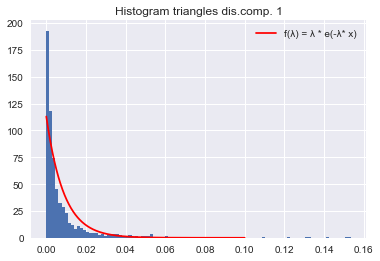

In [219]:
from scipy import stats

lnspc=np.linspace(0,0.1,len(list(node_betweenness_centralitynew[0].values())))
ag1,bg1 = stats.expon.fit(list(node_betweenness_centralitynew[0].values()),floc=0)   ##bg is the scale, ag i do not know
pdf_gammanew = stats.expon.pdf(lnspc, loc=ag1, scale=bg1)  



plt.hist(list(node_betweenness_centralitynew[0].values()), bins=100,normed=True)
plt.plot(lnspc, pdf_gammanew, label="f(λ) = λ * e(-λ* x)",color='red') 
#axarr[0].plot(lnspc, pdf_g, label="Norm",color='red')
#axarr[0].plot(lnspc, pdf_gamma, label="Gamma",color='Darkgreen')
plt.title('Histogram triangles dis.comp. 1')
plt.legend(loc='upper right')
#axarr[1].legend(loc='upper right')
#axarr[2].legend(loc='upper right')
plt.show()

In [197]:
betweenness_centrality_sourcenew = nx.betweenness_centrality_source(G_busnew)

In [198]:
max_betweeness_central_stationnew = max(betweenness_centrality_sourcenew.items(), key=operator.itemgetter(1))
print(max_betweeness_central_stationnew)
#bus_stations_properties[max_betweeness_central_station[0]]

('Diagonal - Pau Claris', 0.13905000574014068)


In [200]:
from collections import OrderedDict

OrderedDict(sorted(betweenness_centrality_sourcenew.items(), key=lambda t: -t[1]))

OrderedDict([('Diagonal - Pau Claris', 0.13905000574014068),
             ('Av Gaudí', 0.13863812665005304),
             ('Diagonal - Francesc Macià', 0.13645159088524586),
             ('Diagonal - Muntaner', 0.1287653794810729),
             ('Diagonal - Balmes', 0.12026461041476452),
             ('Diagonal - Girona', 0.11864716347827008),
             ('Pg de Sant Joan - Pl Mossèn Jacint Verdaguer',
              0.11108987612187785),
             ('Meridiana - La Sagrera', 0.11098696901365683),
             ('Mallorca - Nàpols', 0.09961492475902746),
             ('Mallorca - Marina', 0.09904983456678933),
             ("Meridiana - Riera d'Horta", 0.0889850753707742),
             ('Diagonal - Pl Reina Maria Cristina', 0.08535163455170205),
             ('Diagonal - Ganduxer', 0.08293019606512526),
             ('Metro Tarragona', 0.07877428980210029),
             ('Gran Via - Roger de Flor', 0.0787444078441325),
             ('Meridiana - Escòcia', 0.07800380811382747),
      

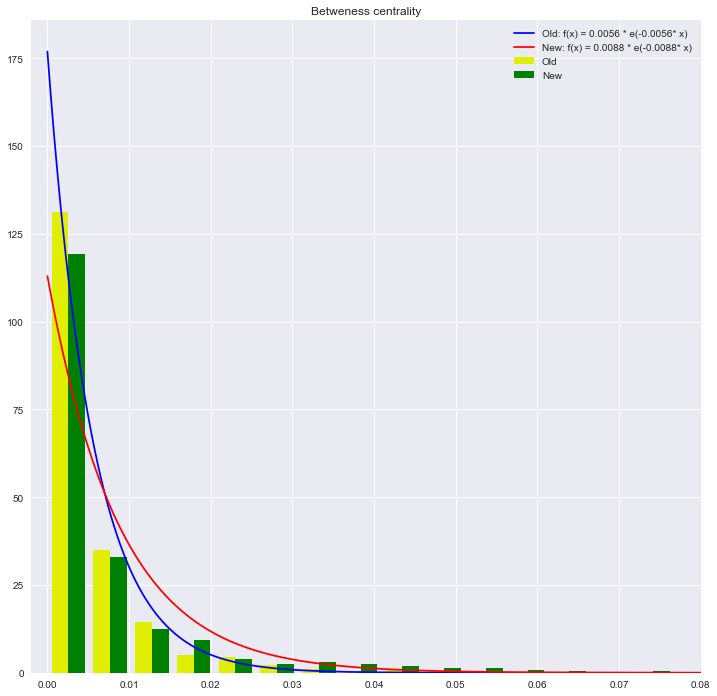

In [228]:
plt.figure(figsize=(12,12))
lnspc1=np.linspace(0,0.1,len(list(node_betweenness_centrality[0].values())))
lnspc2=np.linspace(0,0.1,len(list(node_betweenness_centralitynew[0].values())))
plt.hist([list(node_betweenness_centrality[0].values()),list(node_betweenness_centralitynew[0].values())], bins=30,normed=True,label=['Old','New'],color=['#e0ee04','green'])
plt.plot(lnspc1, pdf_gamma, label="Old: f(x) = 0.0056 * e(-0.0056* x)",color='blue') 
plt.plot(lnspc2, pdf_gammanew, label="New: f(x) = 0.0088 * e(-0.0088* x)",color='red') 
#axarr[0].plot(lnspc, pdf_g, label="Norm",color='red')
#axarr[0].plot(lnspc, pdf_gamma, label="Gamma",color='Darkgreen')
plt.title('Betweness centrality')
plt.legend(loc='upper right')
plt.xlim(-0.002,0.08)
#axarr[1].legend(loc='upper right')
#axarr[2].legend(loc='upper right')
plt.show()

**degree centrality**

In [230]:
degree_centrality = nx.degree_centrality(G_bus)
max_degree_central_station = max(degree_centrality.items(), key=operator.itemgetter(1))
print(max_degree_central_station)

(777, 0.004051863857374392)


In [231]:
from collections import OrderedDict

OrderedDict(sorted(degree_centrality.items(), key=lambda t: -t[1]))

OrderedDict([(777, 0.004051863857374392),
             (389, 0.0032414910858995136),
             (226, 0.0032414910858995136),
             (1185, 0.0028363047001620746),
             (21, 0.0028363047001620746),
             (239, 0.0028363047001620746),
             (1957, 0.0028363047001620746),
             (1124, 0.0028363047001620746),
             (1670, 0.0028363047001620746),
             (108, 0.002431118314424635),
             (875, 0.002431118314424635),
             (1906, 0.002431118314424635),
             (1591, 0.002431118314424635),
             (1075, 0.002431118314424635),
             (1209, 0.002431118314424635),
             (316, 0.002431118314424635),
             (1499, 0.002431118314424635),
             (2258, 0.002431118314424635),
             (561, 0.002431118314424635),
             (1323, 0.002431118314424635),
             (141, 0.002431118314424635),
             (859, 0.002431118314424635),
             (212, 0.002431118314424635),
             (11

In [232]:
print(bus_stations_properties[777])
print(bus_stations_properties[389])
print(bus_stations_properties[226])

{'id': '777', 'street_name': 'Av de Roma-Tarragona', 'city': 'BARCELONA', 'utm_x': '428486,2180', 'utm_y': '4581552,6000', 'lat': '41.3805139', 'lon': '2.1436483', 'furniture': 'Pal', 'buses': '30 - 32 - 43 - 44 - 78 - 115'}
{'id': '389', 'street_name': 'Pl Espanya-FGC', 'city': 'BARCELONA', 'utm_x': '428886,6052', 'utm_y': '4580856,7918', 'lat': '41.3743325', 'lon': '2.1485624', 'furniture': 'Marquesina', 'buses': '09 - 37 - 46 - 65 - 79 - 91 - 109 - 165 - A1 - L70 - L72 - L94 - L95 - N1 - N13 - N15 - N16 - N17 - '}
{'id': '226', 'street_name': 'Pau Claris-Gran Via', 'city': 'BARCELONA', 'utm_x': '430732,3648', 'utm_y': '4582605,4724', 'lat': '41.3901935', 'lon': '2.1703872', 'furniture': 'Marquesina', 'buses': '22 - 28 - 39 - 45 - 66 - N1 - N2 - N3 - N7'}


In [246]:
degree_centralitynew = nx.degree_centrality(G_busnew)
max_degree_central_stationnew = max(degree_centralitynew.items(), key=operator.itemgetter(1))
print(max_degree_central_stationnew)

('Pl Espanya - FGC', 0.005478297513695744)


In [247]:
from collections import OrderedDict

OrderedDict(sorted(degree_centralitynew.items(), key=lambda t: -t[1]))

OrderedDict([('Pl Espanya - FGC', 0.005478297513695744),
             ('Av Roma - Tarragona', 0.004214075010535188),
             ('Meridiana - La Sagrera', 0.004214075010535188),
             ('Metro Tarragona', 0.003792667509481669),
             ('Pg Sant Gervasi - Pl John F Kennedy', 0.003792667509481669),
             ('Palau Reial', 0.003792667509481669),
             ('Pl Borràs', 0.003792667509481669),
             ('Parc Sanitari Pere Virgili', 0.003792667509481669),
             ('Borbó - Serrano', 0.00337126000842815),
             ('Craywinckel - Hurtado', 0.00337126000842815),
             ('Av Gaudí', 0.00337126000842815),
             ('La Campana', 0.00337126000842815),
             ('Carles III - Mejía Lequerica', 0.00337126000842815),
             ('Pl dels Indians', 0.00337126000842815),
             ('Poble Espanyol', 0.00337126000842815),
             ('Fusters - Ctra Nacional 150', 0.00337126000842815),
             ('Hospital del Mar', 0.0029498525073746312),
   

In [262]:
sorted(list(degree_centralitynew.values()), key=abs, reverse=False)

[0.00042140750105351877,
 0.00042140750105351877,
 0.00042140750105351877,
 0.00042140750105351877,
 0.00042140750105351877,
 0.00042140750105351877,
 0.00042140750105351877,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.0008428150021070375,
 0.000842

In [264]:
listdegree_centralitynew = [i for i in list(degree_centralitynew.values()) if i >= 0.000431407501]

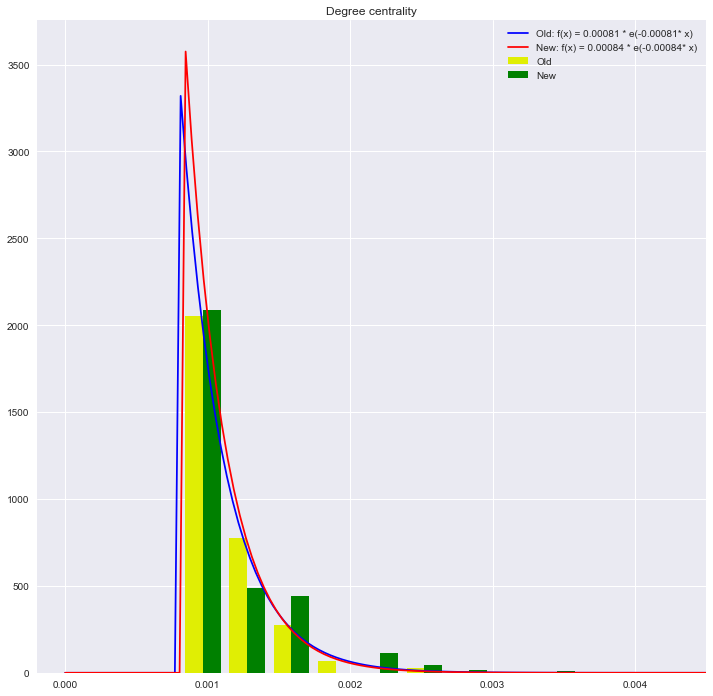

In [272]:
plt.figure(figsize=(12,12))
#lnspc1=np.linspace(0,0.1,len(list(node_betweenness_centrality[0].values())))
#lnspc2=np.linspace(0,0.1,len(list(node_betweenness_centralitynew[0].values())))
lnspc1=np.linspace(0,0.1,len(list(degree_centrality.values())))
lnspc2=np.linspace(0,0.1,len(listdegree_centralitynew))

ag,bg = stats.expon.fit(list(degree_centrality.values()))   ##bg is the scale, ag i do not know
pdf_gamma = stats.expon.pdf(lnspc1, loc=ag, scale=bg) 

ag1,bg1 = stats.expon.fit(listdegree_centralitynew)   ##bg is the scale, ag i do not know
pdf_gammanew = stats.expon.pdf(lnspc2, loc=ag1, scale=bg1)  

plt.hist([list(degree_centrality.values()),listdegree_centralitynew], bins=15,normed=True,label=['Old','New'],color=['#e0ee04','green'])
plt.plot(lnspc1, pdf_gamma, label="Old: f(x) = 0.00081 * e(-0.00081* x)",color='blue') 
plt.plot(lnspc2, pdf_gammanew, label="New: f(x) = 0.00084 * e(-0.00084* x)",color='red') 

plt.title('Degree centrality')
plt.legend(loc='upper right')
plt.xlim(-0.0002,0.0045)
#axarr[1].legend(loc='upper right')
#axarr[2].legend(loc='upper right')
plt.show()

**Closeness centrality**

In [273]:
closeness_centrality = nx.closeness_centrality(G_bus)

node_closeness_centrality = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_closeness_centrality.append( nx.closeness_centrality(g))    

In [274]:
max_closeness_central_station = max(closeness_centrality.items(), key=operator.itemgetter(1))
print(max_closeness_central_station)
bus_stations_properties[max_closeness_central_station[0]]

(1209, 0.09206609595246185)


{'buses': '07 - 50 - 54 - 56 - 62 - 66 - 67 - 68',
 'city': 'BARCELONA',
 'furniture': 'Pal',
 'id': '1209',
 'lat': '41.3879730',
 'lon': '2.1664645',
 'street_name': 'Gran Via-Rambla Catalunya',
 'utm_x': '430401,3760',
 'utm_y': '4582362,7230'}

In [275]:
from collections import OrderedDict

OrderedDict(sorted(closeness_centrality.items(), key=lambda t: -t[1]))

OrderedDict([(1209, 0.09206609595246185),
             (226, 0.0919193500908407),
             (1069, 0.09174312290526986),
             (1124, 0.09127770527689491),
             (561, 0.09042992473252746),
             (1210, 0.09037541822802743),
             (21, 0.090266602103977),
             (1075, 0.08990936070448492),
             (316, 0.0896727665572621),
             (1079, 0.08962988315556891),
             (3032, 0.0892599380093936),
             (228, 0.08873521100065851),
             (95, 0.08866175180441875),
             (211, 0.08844558016527157),
             (1081, 0.08839343884698517),
             (548, 0.08809912875642173),
             (1208, 0.08797162864830989),
             (1256, 0.08794754850907953),
             (175, 0.08788568864142436),
             (2563, 0.08782391573363625),
             (458, 0.08781362869056264),
             (1040, 0.08778620835373499),
             (1071, 0.08773826394720646),
             (239, 0.08754019375769463),
          

In [276]:
print(bus_stations_properties[1209])
print(bus_stations_properties[226])
print(bus_stations_properties[1069])

{'id': '1209', 'street_name': 'Gran Via-Rambla Catalunya', 'city': 'BARCELONA', 'utm_x': '430401,3760', 'utm_y': '4582362,7230', 'lat': '41.3879730', 'lon': '2.1664645', 'furniture': 'Pal', 'buses': '07 - 50 - 54 - 56 - 62 - 66 - 67 - 68'}
{'id': '226', 'street_name': 'Pau Claris-Gran Via', 'city': 'BARCELONA', 'utm_x': '430732,3648', 'utm_y': '4582605,4724', 'lat': '41.3901935', 'lon': '2.1703872', 'furniture': 'Marquesina', 'buses': '22 - 28 - 39 - 45 - 66 - N1 - N2 - N3 - N7'}
{'id': '1069', 'street_name': 'Metro Urquinaona', 'city': 'BARCELONA', 'utm_x': '430924,2250', 'utm_y': '4582471,3560', 'lat': '41.3895549', 'lon': '2.1742304', 'furniture': 'Marquesina', 'buses': '41 - 42 - 55 - 141 - N4'}


new_bus

In [277]:
closeness_centralitynew = nx.closeness_centrality(G_busnew)

node_closeness_centralitynew = []
for g in nx.connected_component_subgraphs(G_busnew): 
    node_closeness_centralitynew.append( nx.closeness_centrality(g)) 

In [278]:
from collections import OrderedDict

OrderedDict(sorted(closeness_centralitynew.items(), key=lambda t: -t[1]))

OrderedDict([('Diagonal - Pau Claris', 0.06716041885957812),
             ('Pg de Sant Joan - Pl Mossèn Jacint Verdaguer',
              0.06657822327813286),
             ('Diagonal - Girona', 0.06646093926766053),
             ('Diagonal - Balmes', 0.06583226020583148),
             ('Mallorca - Nàpols', 0.06559530904964896),
             ('Mallorca - Marina', 0.06518175957455417),
             ('Diagonal - Muntaner', 0.06512057087132277),
             ('Av Gaudí', 0.06497104480146505),
             ('Via Augusta - Diagonal', 0.06473829284977095),
             ('València - Diagonal', 0.06443761759157678),
             ('Rosselló - Bruc', 0.06425470933081426),
             ('Diagonal - Roger de Flor', 0.06422208785676248),
             ('Pau Claris - Mallorca', 0.06421249960835149),
             ('Pg  Sant Joan - Consell de Cent', 0.06415503018746097),
             ('Diagonal - Francesc Macià', 0.06409957411200606),
             ('Pg de Sant Joan - Còrsega', 0.0638900921561452),
     

In [298]:
listclose_centrality = [i for i in list(closeness_centrality.values()) if i >= 0.02]
listclose_centralitynew = [i for i in list(closeness_centralitynew.values()) if i >= 0.02]

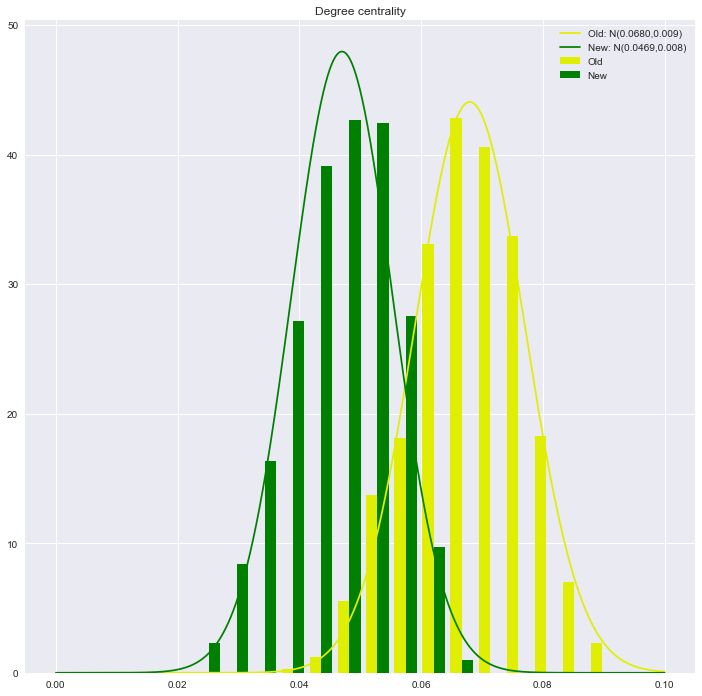

In [304]:
plt.figure(figsize=(12,12))
#lnspc1=np.linspace(0,0.1,len(list(node_betweenness_centrality[0].values())))
#lnspc2=np.linspace(0,0.1,len(list(node_betweenness_centralitynew[0].values())))
lnspc1=np.linspace(0,0.1,len(listclose_centrality))
lnspc2=np.linspace(0,0.1,len(listclose_centralitynew))

#ag,bg = stats.expon.fit(list(closeness_centrality.values()))   ##bg is the scale, ag i do not know
#pdf_gamma = stats.expon.pdf(lnspc1, loc=ag, scale=bg) 

#ag1,bg1 = stats.expon.fit(list(closeness_centralitynew.values()))  ##bg is the scale, ag i do not know
#pdf_gammanew = stats.expon.pdf(lnspc2, loc=ag1, scale=bg1) 

m1, s1 = stats.norm.fit(listclose_centrality) # get mean and standard deviation  
pdf_g1 = stats.norm.pdf(lnspc1, m1, s1) # now get theoretical values in our interval  
plt.plot(lnspc1, pdf_g1, label="Old: N(0.0680,0.009)",color='#e0ee04')

m2, s2 = stats.norm.fit(listclose_centralitynew) # get mean and standard deviation  
pdf_g2 = stats.norm.pdf(lnspc2, m2, s2) # now get theoretical values in our interval  
plt.plot(lnspc2, pdf_g2, label="New: N(0.0469,0.008)",color='green')

plt.hist([listclose_centrality,listclose_centralitynew], bins=15,normed=True,label=['Old','New'],color=['#e0ee04','green'])
#plt.plot(lnspc1, pdf_gamma, label="Old: f(x) = 0.00081 * e(-0.00081* x)",color='blue') 
#plt.plot(lnspc2, pdf_gammanew, label="New: f(x) = 0.00084 * e(-0.00084* x)",color='red') 

plt.title('Degree centrality')
plt.legend(loc='upper right')
#axarr[1].legend(loc='upper right')
#axarr[2].legend(loc='upper right')
plt.show()

In [302]:
m2, s2

(0.046995718955305722, 0.0083198184040030199)

**Katz centrality**

In [375]:
katz_centrality = nx.katz_centrality(G_bus)

#katz_centrality_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    katz_centrality_bus=nx.katz_centrality(g)
    #katz_centrality_bus.append(nx.katz_centrality(g))
    break;

In [376]:
katz_centrality_bus_station = max(katz_centrality.items(), key=operator.itemgetter(1))
print(katz_centrality_bus_station)

from collections import OrderedDict

OrderedDict(sorted(katz_centrality.items(), key=lambda t: -t[1]))

(777, 0.03777859576370185)


OrderedDict([(777, 0.03777859576370185),
             (226, 0.033909153377400185),
             (389, 0.032884435340753915),
             (1185, 0.03191275496278887),
             (1957, 0.031784091541723354),
             (1124, 0.031458257223921364),
             (21, 0.03083896873693099),
             (1670, 0.030544838826195554),
             (239, 0.03035299540616659),
             (1209, 0.0298673542465443),
             (1069, 0.029695289286978697),
             (316, 0.029271331157675575),
             (1906, 0.02922255869620821),
             (875, 0.029184334584796696),
             (108, 0.028894675061173825),
             (561, 0.02882010089545994),
             (1591, 0.028754995234801604),
             (1323, 0.028669560672760965),
             (1103, 0.028582793701484432),
             (1499, 0.028413997650189753),
             (1075, 0.028319549546334682),
             (212, 0.028117299921922353),
             (141, 0.028056385171644844),
             (2878, 0.027820199

In [364]:
print(bus_stations_properties[777])
print(bus_stations_properties[226])
print(bus_stations_properties[389])

{'id': '777', 'street_name': 'Av de Roma-Tarragona', 'city': 'BARCELONA', 'utm_x': '428486,2180', 'utm_y': '4581552,6000', 'lat': '41.3805139', 'lon': '2.1436483', 'furniture': 'Pal', 'buses': '30 - 32 - 43 - 44 - 78 - 115'}
{'id': '226', 'street_name': 'Pau Claris-Gran Via', 'city': 'BARCELONA', 'utm_x': '430732,3648', 'utm_y': '4582605,4724', 'lat': '41.3901935', 'lon': '2.1703872', 'furniture': 'Marquesina', 'buses': '22 - 28 - 39 - 45 - 66 - N1 - N2 - N3 - N7'}
{'id': '389', 'street_name': 'Pl Espanya-FGC', 'city': 'BARCELONA', 'utm_x': '428886,6052', 'utm_y': '4580856,7918', 'lat': '41.3743325', 'lon': '2.1485624', 'furniture': 'Marquesina', 'buses': '09 - 37 - 46 - 65 - 79 - 91 - 109 - 165 - A1 - L70 - L72 - L94 - L95 - N1 - N13 - N15 - N16 - N17 - '}


In [371]:
katz_centralitynew = nx.katz_centrality(G_busnew)

#katz_centrality_busnew =
for g in nx.connected_component_subgraphs(G_busnew):
    katz_centrality_busnew = nx.katz_centrality(g)
    #katz_centrality_busnew.append(nx.katz_centrality(g))
    break;

In [354]:
from collections import OrderedDict

OrderedDict(sorted(katz_centralitynew.items(), key=lambda t: -t[1]))

OrderedDict([('Pl Espanya - FGC', 0.04682929523482544),
             ('Meridiana - La Sagrera', 0.039248916587596064),
             ('Av Roma - Tarragona', 0.038579586026032),
             ('Pg Sant Gervasi - Pl John F Kennedy', 0.03851932521481708),
             ('Metro Tarragona', 0.0375422785108699),
             ('Craywinckel - Hurtado', 0.037518578739708666),
             ('Borbó - Serrano', 0.036433402274044034),
             ('Parc Sanitari Pere Virgili', 0.03535798069739884),
             ('Pl Borràs', 0.034851836341054494),
             ('Palau Reial', 0.03410905707690947),
             ('Carles III - Mejía Lequerica', 0.03379115325989079),
             ('Paral·lel - Av Mistral', 0.03374230764276963),
             ('La Campana', 0.033028566034045546),
             ('Pl dels Indians', 0.03290403984906237),
             ('Av Gaudí', 0.03280269598261137),
             ('Poble Espanyol', 0.03256018011627113),
             ('Escòcia', 0.032271515342567066),
             ('Fusters -

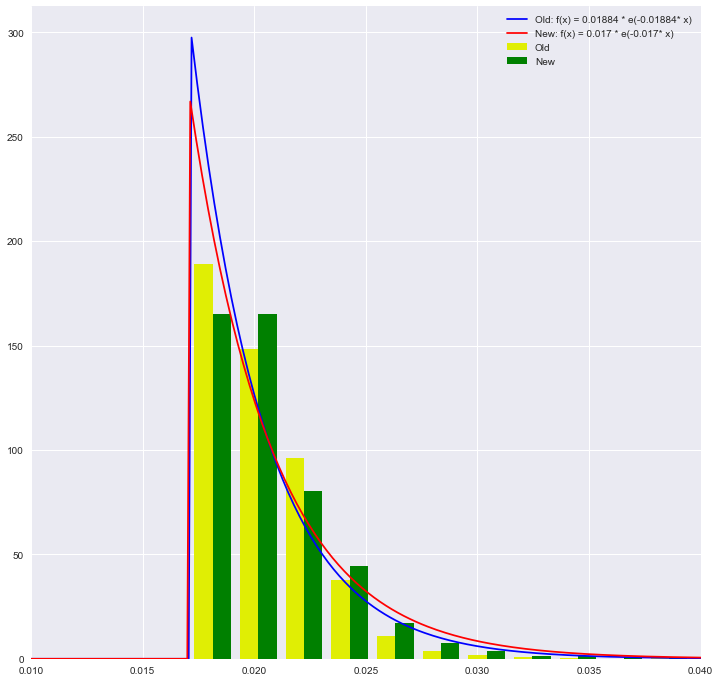

In [394]:
plt.figure(figsize=(12,12))
#lnspc1=np.linspace(0,0.1,len(list(node_betweenness_centrality[0].values())))
#lnspc2=np.linspace(0,0.1,len(list(node_betweenness_centralitynew[0].values())))
lnspc1=np.linspace(0,0.3,len(list(katz_centrality_bus.values())))
lnspc2=np.linspace(0,0.3,len(list(katz_centrality_busnew.values())))

ag,bg = stats.expon.fit(list(katz_centrality_bus.values()))   ##bg is the scale, ag i do not know
pdf_gamma = stats.expon.pdf(lnspc1, loc=ag1, scale=bg*2) 

ag1,bg1 = stats.expon.fit(list(katz_centrality_busnew.values()))  ##bg is the scale, ag i do not know
pdf_gammanew = stats.expon.pdf(lnspc2, loc=ag1, scale=bg1) 

#m1, s1 = stats.norm.fit(list(katz_centrality.values())) # get mean and standard deviation  
#pdf_g1 = stats.norm.pdf(lnspc1, m1, s1) # now get theoretical values in our interval  
#plt.plot(lnspc1, pdf_g1, label="Old: N(0.0680,0.009)",color='#e0ee04')

#m2, s2 = stats.norm.fit(list(katz_centralitynew.values())) # get mean and standard deviation  
#pdf_g2 = stats.norm.pdf(lnspc2, m2, s2) # now get theoretical values in our interval  
#plt.plot(lnspc2, pdf_g2, label="New: N(0.0469,0.008)",color='green')

plt.hist([list(katz_centrality_bus.values()),list(katz_centrality_busnew.values())], bins=15,normed=True,label=['Old','New'],color=['#e0ee04','green'])
plt.plot(lnspc1, pdf_gamma, label="Old: f(x) = 0.01884 * e(-0.01884* x)",color='blue') 
plt.plot(lnspc2, pdf_gammanew, label="New: f(x) = 0.017 * e(-0.017* x)",color='red') 

plt.legend(loc='upper right')
plt.xlim(0.01,0.04)
plt.show()

In [389]:
ag,bg

(0.01884438652782261, 0.0016429552630650485)

In [390]:
ag1,bg1

(0.017115742982810746, 0.0037311050228970889)

## Degree distribution

In [307]:
a=nx.degree_histogram(G_bus)
totalnodes=0
for i in range(len(a)):
    totalnodes+=a[i]*i
    
    
b=nx.degree_histogram(G_busnew)
totalnodesnew=0
for i in range(len(b)):
    totalnodesnew+=b[i]*i

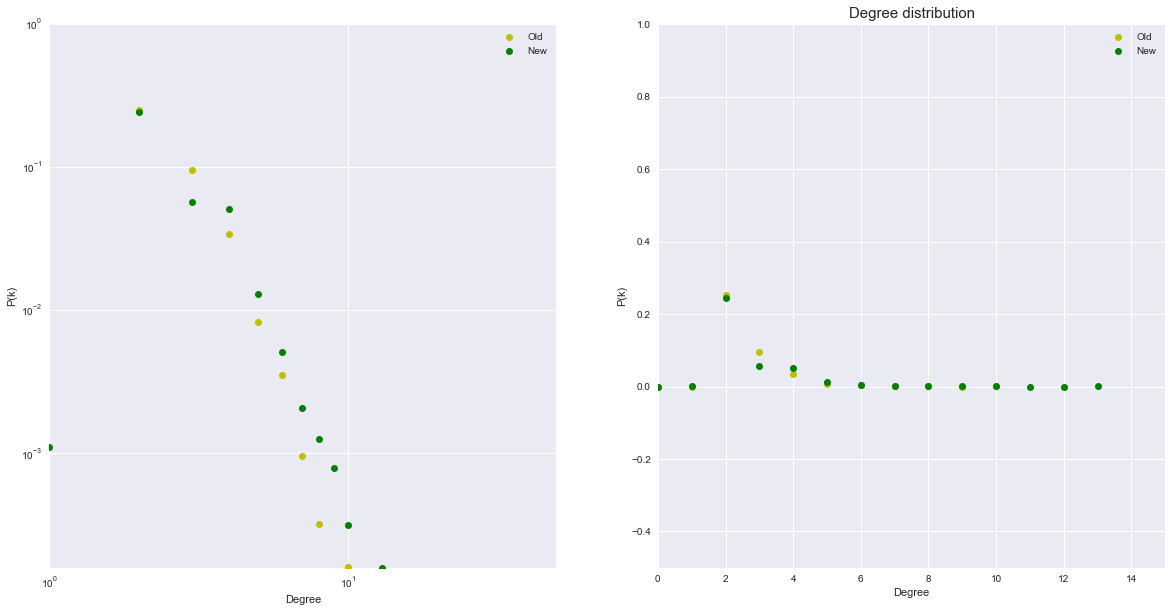

In [336]:
plt.figure(figsize=(20,10))

plt.subplot(121)
distdegree=np.asarray(a)/totalnodes
distdegreenew=np.asarray(b)/totalnodesnew
#b=np.arange(len(a))
plt.plot(distdegree, 'yo',label='Old')
#plt.plot(distdegree,color='#e0ee04')
plt.plot(distdegreenew, 'go',label='New')
#plt.plot(distdegreenew,color='green')
plt.semilogy()
plt.semilogx()
plt.xlim(-1.5, 50)
plt.ylim(-5, 1)
#plt.title('Degree distribution using semilog',fontsize=15)
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.legend(loc='upper right')

plt.subplot(122)
#b=np.arange(len(a))
plt.plot(distdegree, 'yo',label='Old')
plt.plot(distdegreenew,'go',label='New')
#plt.semilogy()
#plt.semilogx()
plt.xlim(0, 15)
plt.ylim(-0.5, 1)
plt.title('Degree distribution',fontsize=15)
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.legend(loc='upper right')

plt.show()



In [398]:
len(z)

12

a=1.798, b=2.819
a=2.054, b=3.078


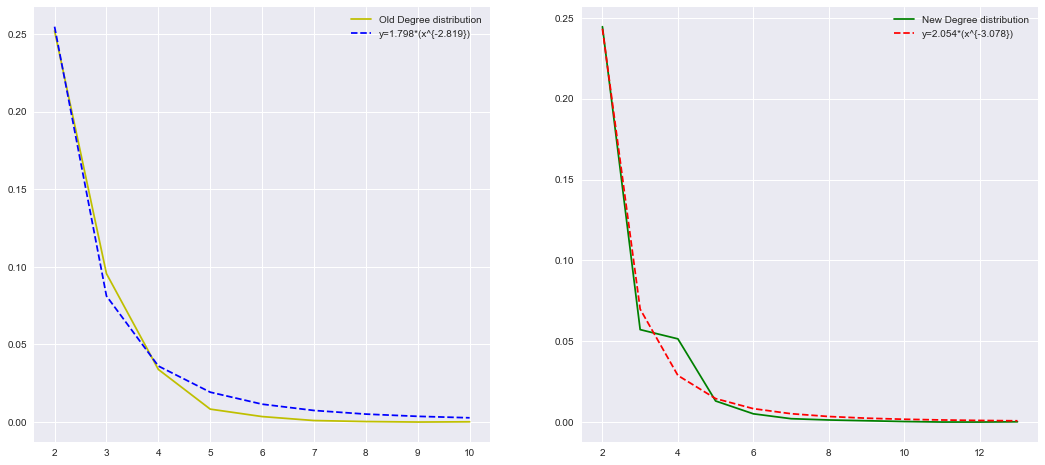

In [410]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def func(x, a, b):
    return a *(x**(-b))

xdata = np.arange(2,11)
xdatanew = np.arange(2,14)
y = distdegree[2:]
z=distdegreenew[2:]
np.random.seed(1729)
#y_noise = 0.0002 * np.random.normal(size=xdata.size)
ydata = y
popt, pcov = curve_fit(func, xdata, ydata)
print('a=%5.3f, b=%5.3f' % tuple(popt))

z=distdegreenew[2:]
zdata = z
poptnew, pcovnew = curve_fit(func, xdatanew, zdata)
print('a=%5.3f, b=%5.3f' % tuple(poptnew))

plt.figure(figsize=(18,8))
plt.subplot(121)     
plt.plot(xdata, ydata, 'y-', label='Old Degree distribution')
plt.plot(xdata,func(xdata, *popt), '--',color='blue',label='y=1.798*(x^{-2.819})')
plt.legend(loc='upper right')

plt.subplot(122) 
plt.plot(xdatanew, zdata, 'g-', label='New Degree distribution')
plt.plot(xdatanew,func(xdatanew, *poptnew), '--',color='red',label='y=2.054*(x^{-3.078})')


plt.legend(loc='upper right')

### Macroscale

** Clustering**

**Triangles**


In [417]:
node_triangles_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_triangles_bus.append(nx.triangles(g)) 

In [418]:
triangleCount1 = collections.Counter(list(node_triangles_bus[0].values()))
print('Component 1:',triangleCount1)
triangleCount2 = collections.Counter(list(node_triangles_bus[1].values()))
print('Component 2:',triangleCount2)
triangleCount3 = collections.Counter(list(node_triangles_bus[2].values()))
print('Component 3:',triangleCount3)
#deg, cnt = zip(*degreeCount.items())

Component 1: Counter({0: 2279, 1: 73, 2: 4, 3: 1})
Component 2: Counter({0: 22})
Component 3: Counter({0: 90})


** NEW BUS**

In [439]:
node_triangles_busnewdict=nx.triangles(G_busnew)

In [438]:
node_triangles_busnew = []
for g in nx.connected_component_subgraphs(G_busnew): 
    node_triangles_busnew.append(nx.triangles(g)) 

In [435]:
triangleCount1new = collections.Counter(list(node_triangles_busnew[0].values()))
print('Component 1:',triangleCount1new)
triangleCount2new = collections.Counter(list(node_triangles_busnew[1].values()))
print('Component 2:',triangleCount2new)
triangleCount3new = collections.Counter(list(node_triangles_busnew[2].values()))
print('Component 3:',triangleCount3new)
#deg, cnt = zip(*degreeCount.items())

Component 1: Counter({0: 2075, 1: 157, 2: 19, 3: 5, 4: 2, 5: 2})
Component 2: Counter({0: 23})
Component 3: Counter({0: 91})


In [440]:
from collections import OrderedDict

OrderedDict(sorted(node_triangles_busnewdict.items(), key=lambda t: -t[1]))

OrderedDict([('Pg Sant Gervasi - Mas Yebra', 5),
             ('Craywinckel - Hurtado', 5),
             ('Pg Sant Gervasi - Pl John F Kennedy', 4),
             ("Fabra i Puig - Arnau d'Oms", 4),
             ('Metro Tarragona', 3),
             ("Arnau d'Oms - La Jota", 3),
             ('Borbó - Serrano', 3),
             ('Meridiana - La Sagrera', 3),
             ('Balmes - Pl John F. Kennedy', 3),
             ('Paral·lel - Av Mistral', 2),
             ('Metro Maragall', 2),
             ("Av d'Esplugues - González Tablas", 2),
             ("Av d'Esplugues - Eduard Toldrà", 2),
             ('Onze de Setembre - Virgili', 2),
             ('Pl Espanya - FGC', 2),
             ('Metro Tetuan', 2),
             ('Gran Via - Roger de Flor', 2),
             ('Transports Metropolitans de Barcelona', 2),
             ('Pg  Zona Franca - Motors', 2),
             ('Pl Borràs', 2),
             ('Av República Argentina - Vallcarca', 2),
             ('Vallcarca', 2),
             ('IES

In [427]:
listtriangles=[i for i in list(node_triangles_bus[0].values()) if i >= 0.02]
listtrianglesnew=[i for i in list(node_triangles_busnew[0].values()) if i >= 0.02]

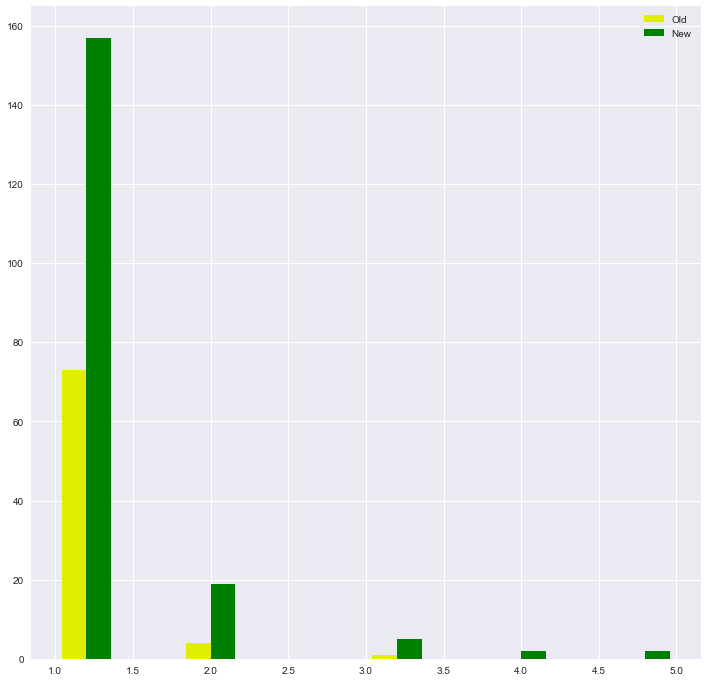

In [436]:
#f, axarr = plt.subplots(1, 3,figsize=(15,6))
plt.figure(figsize=(12,12))

plt.hist([listtriangles,listtrianglesnew], bins=10,normed=False,label=['Old','New'],color=['#e0ee04','green'])

plt.legend(loc='upper right')
plt.xtics()
plt.show()

In [ ]:
1: 73, 2: 4, 3: 1
1: 157, 2: 19, 3: 5, 4: 2, 5: 2
                    

In [446]:
ind

array([1, 2, 3, 4, 5])

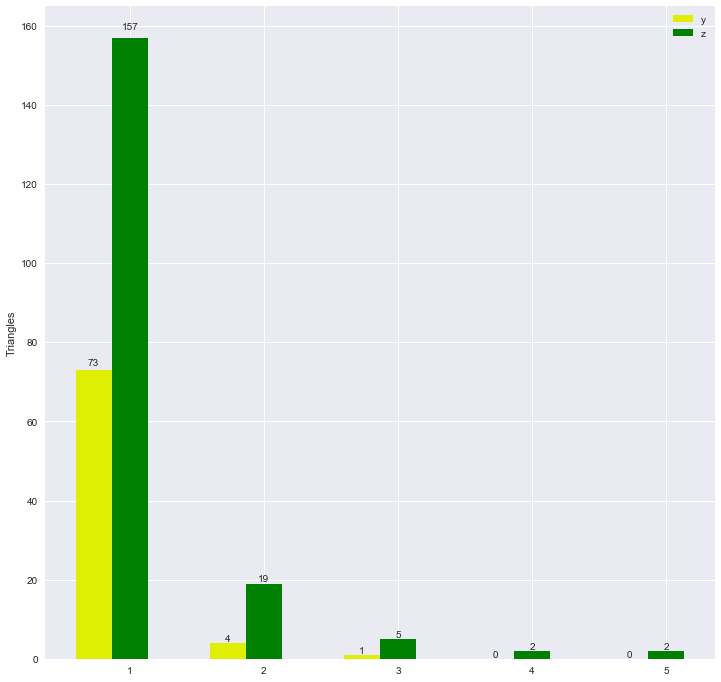

In [456]:
import numpy as np
import matplotlib.pyplot as plt

N = 5
ind = np.arange(N)+1  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

yvals = [73,4,1,0,0]
rects1 = ax.bar(ind, yvals, width, color='#e0ee04')
zvals = [157,19,5,2,2]
rects2 = ax.bar(ind+width, zvals, width, color='green')


ax.set_ylabel('Triangles')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('1', '2', '3','4','5') )
ax.legend( (rects1[0], rects2[0]), ('y', 'z') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

**CLIQUES**

In [78]:
MAX_CLICKES = 5

num_clickes = []
for i in range(2,MAX_CLICKES):
    c = list(nx.algorithms.community.k_clique_communities(G_bus, i))
    num_clickes.append(c)
    print("Num clickes size %i --> %i" % (i ,len([item for sublist in c for item in sublist])))

Num clickes size 2 --> 2469
Num clickes size 3 --> 80
Num clickes size 4 --> 0


In [80]:
MAX_CLICKES = 6

num_clickes = []
for i in range(2,MAX_CLICKES):
    c = list(nx.algorithms.community.k_clique_communities(G_busnew, i))
    num_clickes.append(c)
    print("Num clickes size %i --> %i" % (i ,len([item for sublist in c for item in sublist])))

Num clickes size 2 --> 2374
Num clickes size 3 --> 196
Num clickes size 4 --> 4
Num clickes size 5 --> 0


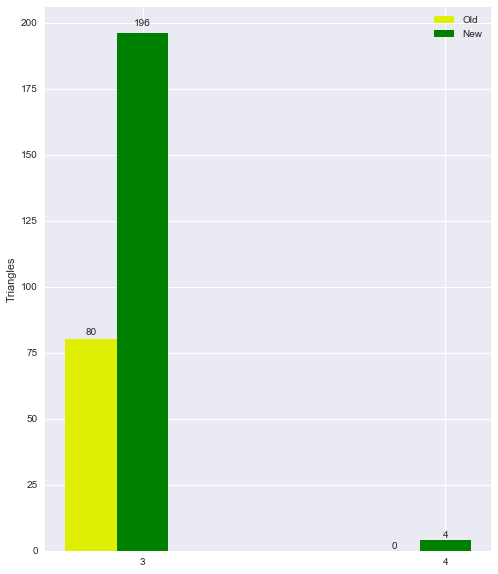

In [92]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
ind = np.arange(N)+1  # the x locations for the groups
width = 0.17       # the width of the bars

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)

yvals = [80,0]
rects1 = ax.bar(ind, yvals, width, color='#e0ee04')
zvals = [196,4]
rects2 = ax.bar(ind+width, zvals, width, color='green')


ax.set_ylabel('Triangles')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('3','4') )
ax.legend( (rects1[0], rects2[0]), ('Old', 'New') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [94]:
nx.average_clustering(G_bus)

0.010397500433952439

In [95]:
nx.average_clustering(G_busnew)

0.028163339515487797

## COMMUNITIES

In [9]:
## Plot communities
def plot_communities(G, partitions, title):
    # Plot, color nodes using community structure
    values = [partitions.get(node) for node in G.nodes()]
    nx.draw_spring(G, cmap=plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
    plt.title(title)
    
    print("Modularity: %s" % community.modularity(partitions,G))
    print("Total number of communities: %i" % len(set(val for val in partitions.values())))
    print("Total number of nodes: %i" % len(partitions.values()))
   
    plt.show()

In [ ]:
from networkx.algorithms import community

louvain_partition = community.best_partition(G_bus)
plot_communities(G_bus, louvain_partition, "Louvain partition")

In [11]:
from community import community_louvain

partition = community_louvain.best_partition(G_busnew)

In [12]:
partition

{'Trelawny - Av Litoral': 0,
 'Hospital del Mar': 0,
 'Platja de la Barceloneta': 1,
 'Pg Marítim - Pepe Rubianes': 1,
 'Pepe Rubianes': 1,
 'Pg  Joan de Borbó': 1,
 'Pla de Palau - Pl Pau Vila': 1,
 'Pg  Colom - Via Laietana': 1,
 'Moll de la Fusta': 2,
 'Portal de la Pau': 2,
 'Les Drassanes': 2,
 'Paral·lel - Drassanes': 3,
 'Metro Paral·lel': 3,
 'Paral·lel - Ronda Sant Pau': 4,
 'Paral·lel - Marquès de Campo Sagrado': 4,
 'Paral·lel - Rocafort': 4,
 'Paral·lel - Floridablanca': 4,
 'Paral·lel - Av Mistral': 4,
 'Creu Coberta - Pl Espanya': 4,
 'Metro Hostafrancs': 5,
 'Sants - Premià': 5,
 'Metro Pl de Sants': 5,
 'Pl de Sants': 5,
 'Sants - Rambla del Brasil': 5,
 'Metro Badal': 5,
 'Arizala - Av Madrid': 5,
 'Arizala - Les Corts': 5,
 'Les Corts - Aurora Bertrana': 5,
 'Collblanc - Cardenal Reig': 5,
 'Ernest Lluch': 5,
 'Cardenal Reig - Pisuerga': 5,
 'Av Sant Ramon Nonat - Cardenal Reig': 5,
 'Metro Collblanc': 5,
 'Sants - Munné': 5,
 'Sants - Badal': 5,
 'Sants - Gayarre': 5

NotAPartition: {'Trelawny - Av Litoral': 0, 'Hospital del Mar': 0, 'Platja de la Barceloneta': 1, 'Pg Marítim - Pepe Rubianes': 1, 'Pepe Rubianes': 1, 'Pg  Joan de Borbó': 1, 'Pla de Palau - Pl Pau Vila': 1, 'Pg  Colom - Via Laietana': 1, 'Moll de la Fusta': 2, 'Portal de la Pau': 2, 'Les Drassanes': 2, 'Paral·lel - Drassanes': 3, 'Metro Paral·lel': 3, 'Paral·lel - Ronda Sant Pau': 4, 'Paral·lel - Marquès de Campo Sagrado': 4, 'Paral·lel - Rocafort': 4, 'Paral·lel - Floridablanca': 4, 'Paral·lel - Av Mistral': 4, 'Creu Coberta - Pl Espanya': 4, 'Metro Hostafrancs': 5, 'Sants - Premià': 5, 'Metro Pl de Sants': 5, 'Pl de Sants': 5, 'Sants - Rambla del Brasil': 5, 'Metro Badal': 5, 'Arizala - Av Madrid': 5, 'Arizala - Les Corts': 5, 'Les Corts - Aurora Bertrana': 5, 'Collblanc - Cardenal Reig': 5, 'Ernest Lluch': 5, 'Cardenal Reig - Pisuerga': 5, 'Av Sant Ramon Nonat - Cardenal Reig': 5, 'Metro Collblanc': 5, 'Sants - Munné': 5, 'Sants - Badal': 5, 'Sants - Gayarre': 5, 'Pl Espanya - Paral·lel': 4, 'Paral·lel - Tamarit': 4, 'Metro Poble Sec': 4, 'Paral·lel - Margarit': 4, 'Paral·lel - Vila i Vilà': 3, 'Paral·lel - Cabanes': 3, 'Pla de Palau': 1, 'Pg Joan de Borbó': 1, 'Tarragona - Pl Espanya': 6, 'Metro Tarragona': 6, 'Av Roma - Tarragona': 6, 'Josep Tarradellas - Rosselló': 6, 'Josep Tarradellas - París': 6, 'Josep Tarradellas - Viladomat': 6, 'Josep Tarradellas - Av de Sarrià': 6, "Buenos Aires - Comte d'Urgell": 7, 'Trav de Gràcia - Muntaner': 7, 'Trav de Gràcia - Balmes': 7, 'Pl Gal·la Placídia': 7, 'Rambla Prat, 19': 7, 'Gran de Gràcia - Pl Trilla': 7, 'Gran de Gràcia - Lesseps': 7, 'Trav de Dalt - La Granja': 7, 'Trav de Dalt - Torrent de les Flors': 7, 'Camèlies - Secretari Coloma': 7, 'Camèlies - Praga': 7, 'Pl de la Font Castellana': 7, 'Verge de Montserrat - Cartagena': 7, 'Verge de Montserrat - La Bisbal': 8, 'Verge de Montserrat - Periodistes': 9, 'Ronda Guinardó - Torre dels Pardals': 9, 'Metro Maragall': 9, 'Ramon Albó - Alexandre Galí': 9, "Arnau d'Oms - La Jota": 9, 'Doctor Pi i Molist - Pl Virrei Amat': 9, 'Doctor Pi i Molist - Maladeta': 9, 'Pla de las Madres de la Plaza de Mayo': 9, "Pg de Verdum - Pl Jardins de l'Alfàbia": 9, 'Artesania - Pl de la República': 9, 'Artesania - Góngora': 9, 'Artesania - Via Favència': 10, 'Rda. Guineueta Vella-Antonio Machado': 10, 'Antonio Machado - Artesania': 10, 'Via Favència - IES Guineueta': 10, 'Almansa, 29': 10, "Via Júlia - Font d'en Canyelles": 10, 'Via Júlia - Pl de la República': 9, 'Pg Verdum - Lorena': 9, 'Pg de Verdum - Doctor Pi i Molist': 9, 'Doctor Pi i Molist - Orduña': 9, 'Doctor Pi i Molist - Fabra i Puig': 9, 'Borbó - Serrano': 9, 'Borbó - Pg Maragall': 9, 'Pl del Nen de la Rutlla': 8, 'Verge de Montserrat - Gènova': 7, 'Verge de Montserrat - Francesc Alegre': 7, 'Verge de Montserrat - França': 7, 'Verge de Montserrat - Praga': 7, 'Trav de Dalt - Riera de Can Toda': 7, 'CAP Larrard': 7, 'Trav de Dalt - Verdi': 7, 'Pl Lesseps - Riera de Vallcarca': 7, "Guillem Tell - Av Príncep d'Astúries": 7, 'Balmes - Via Augusta': 7, 'Balmes - Trav de Gràcia': 7, 'Travessera de Gràcia-Muntaner': 7, 'Travessera de Gràcia-Amigó': 6, 'Josep Tarradellas - Francesc Macià': 6, 'Josep Tarradellas - Av.Sarrià': 6, 'Josep Tarradellas - Entença': 6, 'Josep Tarradellas - Numància': 6, 'Tarragona - Consell de Cent': 6, "Av de l'Exèrcit - Trias i Giró": 11, "Gran Capità - Av de l'Exèrcit": 11, "Sor Eulàlia d'Anzizu - González Tablas": 11, "Av d'Esplugues - González Tablas": 11, "Av d'Esplugues": 11, "Av d'Esplugues - Av Pearson": 11, 'Bisbe Català - Pl Pedralbes': 11, 'Pg Reina Elisenda - Av JV Foix': 11, 'Pl de Sarrià': 12, 'Pg Bonanova - Anglí': 12, 'Pg Bonanova - Escoles Pies': 12, 'Pg Bonanova - Mandri': 12, 'Pl Bonanova': 13, 'Pg Sant Gervasi - Pl John F Kennedy': 13, 'Pg Sant Gervasi - Mas Yebra': 13, 'Pl Alfonso Comín - Av República Argentina': 13, "Pl Alfonso Comín - Pg  Vall d'Hebron": 14, "Pg Vall d'Hebron - Av de Vallcarca": 14, "Pg Vall d'Hebron - Patronat Ribes": 14, "Pg Vall d'Hebron - Basses d'Horta": 14, "Palau d'Esports de la Vall d'Hebron": 14, "Parc de la Vall d'Hebron": 15, "Pg Vall d'Hebron - Av Can Marcet": 15, "Pg Vall d'Hebron - Ctra d'Horta": 15, "Pg Vall d'Hebron - Scala Dei": 10, 'Pl Karl Marx': 10, 'Pg  Valldaura - Fabra i Puig': 9, 'Mercat de la Guineueta': 9, 'Pg  Valldaura - Pg  de Verdum': 9, 'Pg Valldaura - Escultor Ordóñez': 9, 'Pg Valldaura - Pg Andreu Nin': 9, 'Pl de Mossèn Clapés': 16, 'Pg Torras i Bages - Almirall Pròixida': 16, 'Pg Torras i Bages - Residència': 16, 'Pg Torras i Bages - Joan Torras': 16, 'Sant Adrià - Josep Soldevila': 16, 'Parc de La Maquinista': 16, 'Sao Paulo - República Dominicana': 16, "Sao Paulo - Ciutat d'Asunción": 16, "Lima - Ciutat d'Asunción": 16, 'Lima - Sas': 16, 'Arbeca - Lima': 16, 'Sant Adrià - Biosca': 16, 'Sant Adrià - Sas': 16, "Ciutat d'Asunción - Sant Adrià": 16, "Pg de l'Havana - Ciutat d'Asunción": 16, 'Parc de la Maquinista': 16, 'Segre - Pl de Can Fabra': 16, 'Pg Torras i Bages - Els Segadors': 16, 'Pg Torras i Bages - Palomar': 16, 'Pg de Santa Coloma - Ctra de Ribes': 16, 'Gran de Sant Andreu - Palomar': 16, 'Pl Miquel Casablancas': 9, 'Pg Valldaura - Av Rio de Janeiro': 9, "Pg Valldaura - Font d'En Canyelles": 9, 'Pg Valldaura - Rambla Caçador': 9, 'Pg  Valldaura - Mercat Guineueta': 9, 'Pg Valldaura - Guineueta': 10, "Pl Karl Marx - Pg  Vall d'Hebron": 10, "Pg Vall d'Hebron - Cementiri d'Horta": 14, "Pg Vall d'Hebron - Velòdrom": 14, "Pg Vall d'Hebron - Mundet": 14, "Pg Vall d'Hebron - IES Narcís Monturiol": 14, "Pg Vall d'Hebron - Poesia": 14, "Pg Vall d'Hebron - Granja Vella": 14, "Vall d'Hebron, 107-117": 14, "Pg Vall d'Hebron - Natzaret": 14, "Pg Vall d'Hebron - L'Arrabassada": 13, 'Pl Alfonso Comín - Isaac Newton': 13, 'Av República Argentina - Pl Alfonso Comín': 13, 'Craywinckel - Hurtado': 13, 'Pg Sant Gervasi - Pl Bonanova': 6, 'Pg Bonanova - Carrasco i Formiguera': 12, 'Pg Reina Elisenda - Major de Sarrià': 12, 'Bisbe Català - Pl de Pedralbes': 11, "Av d'Esplugues - Dr Joaquim Albarrán": 11, "Av d'Esplugues - Eduard Toldrà": 11, 'González Tablas - Manuel Ballbé': 11, 'Zona Universitària': 11, "ETS d'Arquitectura": 11, 'Palau Reial': 11, 'Pl. Pius XII': 12, 'Pl Reina Maria Cristina': 12, 'Maria Cristina - Carles III': 12, 'Carles III - Numància': 12, 'Mitre - Av Sarrià': 12, 'Mitre - Doctor Fleming': 12, 'Mitre - Ganduxer': 12, 'Mitre - Mandri': 12, 'Mitre - Muntaner': 12, 'Mitre - Balmes': 7, 'Mitre - Saragossa': 7, 'Mitre - Berna': 7, 'Pl Lesseps': 7, 'Guinardó - Lepant': 9, 'Rda Guinardó-Castillejos': 9, 'Rda Guinardó-Sant Quintí': 9, 'Rda Guinardó-Vinyals': 9, 'Escòcia': 9, 'Fabra i Puig': 9, 'Fabra i Puig - Meridiana': 9, "Fabra i Puig - Arnau d'Oms": 9, 'Pg Maragall - Ronda Guinardó': 9, 'Rda Guinardó-Segle XX': 9, 'Rda Guinardó-Telègraf': 7, 'Rda Guinardó-Cartagena': 7, 'Guinardó - Parc de les Aigües': 7, 'Mitre - Pàdua': 7, 'Mitre - Prat de la Riba': 12, 'Manuel Girona - Carles III': 12, 'Capità Arenas - Maria Cristina': 12, 'Pl Pius XII': 11, 'Cardenal Reig - Av St Ramon Nonat': 5, 'Riera Blanca - Les Corts': 5, 'Av de Madrid - Arizala': 5, 'Comandant Benítez - Av Madrid': 5, 'Les Corts - Maternitat': 5, 'Les Corts - Carles III': 5, 'Les Corts - Vallespir': 5, 'Numància - Parc Les Corts': 6, 'Numància - Marquès de Sentmenat': 6, 'Josep Tarradellas - Comte Borrell': 6, 'Diagonal - Francesc Macià': 6, 'Diagonal - Muntaner': 17, 'Diagonal - Balmes': 17, 'Diagonal - Pau Claris': 17, 'Rosselló - Bruc': 17, 'Rosselló - Bailèn': 17, 'Pg de Sant Joan - Còrsega': 17, 'Indústria - Nàpols': 17, 'Indústria - Lepant': 18, 'Av Gaudí': 18, 'Indústria - Independència': 18, 'Indústria - Freser': 18, 'Navas de Tolosa - Indústria': 18, 'Meridiana - Josep Estivill': 18, 'Meridiana - La Sagrera': 19, 'Garcilaso - La Sagrera': 19, 'Berenguer de Palou - Pont del Treball': 19, 'Berenguer de Palou - Pare Manyanet': 19, 'Pare Manyanet - Josep Soldevila': 19, 'Segre - Borriana': 16, 'La Maquinista': 16, "Ciutat d'Asunción - Pg de l'Havana": 16, 'Josep Soldevila - Torrent Estadella': 16, 'Josep Soldevila - Onze de Setembre': 16, 'Onze de Setembre - Virgili': 19, 'Gran de Sant Andreu - Fabra i Puig': 19, 'Sagrera - Parc de la Pegaso': 19, 'Sagrera - Martí Molins': 19, 'Sant Antoni Maria Claret - Felip II': 9, 'Sant Antoni Maria Claret - Trinxant': 9, 'Sant Antoni Maria Claret - Rambla Volart': 9, 'Sant Antoni Maria Claret - Independència': 18, 'Av Gaudí - Castillejos': 18, 'Sant Antoni Maria Claret - Lepant': 7, 'Sant Antoni Maria Claret - Sardenya': 7, 'Sant Antoni Maria Claret - Nàpols': 7, 'Pg de Sant Joan - Indústria': 17, 'Còrsega - Bailèn': 17, 'Còrsega - Llúria': 17, 'Diagonal - Pg  de Gràcia': 17, 'Les Corts - Pl Dr Ignasi Barraquer': 6, 'Les Corts - Numància': 6, 'Mercat de Les Corts': 5, 'Les Corts - Mejía Lequerica': 5, 'Les Corts - Arizala': 5, 'Av Madrid - Arizala': 5, 'Av Madrid - Carles III': 5, 'Av Madrid - Joan Güell': 6, 'Pl del Centre': 6, 'Numància - Berlín': 6, 'València - Entença': 6, 'València - Viladomat': 6, "València - Comte d'Urgell": 6, 'València - Muntaner': 2, 'València - Balmes': 2, 'València - Pg de Gràcia': 2, 'València - Roger de Llúria': 2, 'Mercat de la Concepció': 17, 'València - Pg  Sant Joan': 17, 'València - Diagonal': 17, 'València - Lepant': 19, 'València - Padilla': 19, 'València - Dos de Maig': 19, 'València - Rogent': 19, 'València - Muntanya': 19, 'Espronceda - Guipúscoa': 19, 'Guipúscoa - Bac de Roda': 19, 'Guipúscoa - Julián Besteiro': 19, 'Guipúscoa - Treball': 19, 'Guipúscoa - Cantàbria': 19, 'Guipúscoa - Rambla Prim': 20, 'Guipúscoa - Extremadura': 20, 'Guipúscoa - Biscaia': 20, 'Av Pi i Margall - Ricart': 20, 'Alfons XIII - Simancas': 20, 'Alfons XIII - Av del Maresme': 20, 'Alfons XIII - Jumella': 20, 'Alfons XIII - Sant Lluc': 20, 'Alfons XIII - Josep M de Segarra': 20, 'Av Marquès de Montroig - Pl  Pres. Tarradellas': 20, 'Alfons XIII - Pau Claris': 20, 'Alfons XIII - Juan Valera': 20, 'Av Alfons XIII - Andrés Segovia': 20, 'Alfons XIII - Aribau': 20, 'Av Pi i Margall - Av Catalunya': 20, 'Tibidabo - Mare de Déu de Montserrat': 20, 'Guipúscoa - Verneda': 20, 'Guipúscoa - Selva de Mar': 19, 'Clot - Pont de Bac de Roda': 19, 'Mallorca - Meridiana': 19, 'Mallorca - Rogent': 18, 'Mallorca - Dos de Maig': 18, 'Mallorca - Padilla': 18, 'Mallorca - Marina': 18, 'Mallorca - Nàpols': 17, 'Mallorca - Pg  Sant Joan': 17, 'Mallorca - Girona': 17, 'Mallorca - Pau Claris': 17, 'Mallorca - Pg de Gràcia': 17, 'Mallorca - Balmes': 17, 'Mallorca - Muntaner': 6, "Mallorca - Comte d'Urgell": 6, 'Mallorca - Viladomat': 6, 'Av de Roma - Entença': 6, 'Pl  Països Catalans': 6, 'Comtes de Bell-lloc - Viriat': 6, 'Av Madrid - Benavent': 5, 'Gornal': 21, 'Av Granvia - Miguel Hernández': 21, 'Amadeu Torner': 21, 'Pl Europa': 21, "Gran Via de l'Hospitalet, 87-89": 21, 'Av Granvia - Bloc I. Cerdà': 21, 'Gran Via - Radi': 21, 'Gran Via - Química': 21, 'La Campana': 4, 'Gran Via - Mandoni': 4, 'Gran Via - Santa Dorotea': 4, 'Pl Espanya - FGC': 4, 'Gran Via - Pl  Espanya': 4, 'Gran Via - Entença': 4, 'Gran Via - Viladomat': 2, 'Gran Via - Urgell': 2, 'Gran Via - Muntaner': 2, 'Pl Universitat': 2, 'Gran Via - Balmes': 2, 'Gran Via - Pau Claris': 17, 'Gran Via - Llúria': 17, 'Metro Tetuan': 17, 'Gran Via - Roger de Flor': 17, 'Gran Via - Marina': 18, 'Gran Via - Padilla': 18, 'Pl Glòries Catalanes, s/n': 18, 'Gran Via - Llacuna': 20, 'Gran Via - Bilbao': 20, 'Gran Via - Bac de Roda': 20, 'Gran Via - Selva de Mar': 20, 'Gran Via - St Martí Provençals': 20, 'Gran Via - Maresme': 20, 'Metro Besòs': 20, 'Besòs - Verneda': 20, "Gran Via - Ca n'Oliva": 20, 'Gran Via - Agricultura': 20, 'Gran Via - Pl dels Porxos': 20, 'Gran Via - Espronceda': 20, 'Gran Via - Parc del Clot': 18, 'Gran Via Corts Catalanes, 851': 18, 'Glòries Catalanes, 8-15': 18, 'Gran Via, 751': 18, 'Gran Via - Sardenya': 18, 'Gran Via - Casanova': 2, 'Gran Via - Villarroel': 2, 'Gran Via - Calàbria': 2, 'Gran Via - Vilamarí': 2, 'Gran Via - Pl Espanya': 2, 'Gran Via - Farell': 4, 'Gran Via - Moianès': 4, 'Gran Via - Ildefons Cerdà': 21, 'Ildefons Cerdà - Ciutat de la Justícia': 21, 'Av Granvia - Alhambra': 21, 'Av Granvia - Natzaret': 21, 'Av Granvia - Can Tries': 21, 'Ronda Sant Pau - Carrer de les Flors': 3, 'Pg  Isabel II - Pla de Palau': 1, 'Estació de França': 1, 'Parc de la Ciutadella - Princesa': 1, 'Pg Pujades - Parc de la Ciutadella': 18, 'Buenaventura Muñoz - Sardenya': 18, 'Pallars - Zamora': 18, 'Pallars - Pere IV': 18, 'Pere IV-Llacuna': 22, 'Pere IV - Bilbao': 22, 'Cristóbal de Moura-Espronceda': 22, 'Pere IV-Provençals': 22, 'Selva de Mar - Pere IV': 22, 'Cristóbal de Moura-Josep Pla': 22, 'Cristóbal de Moura - Rambla Prim': 22, 'Cristóbal de Moura-Perpinyà': 22, 'Cristóbal de Moura - Parc del Besòs': 0, 'Cristóbal de Moura - La Catalana': 0, 'Torrassa - Mare de Déu del Carme': 0, "Av de la Platja - Pont d'Eduard Maristany": 0, 'Cristóbal de Moura-Rambla Prim': 22, 'Pere IV-Josep Pla': 22, 'Pere IV-Selva de Mar': 22, 'Marroc-Bac de Roda': 22, 'Marroc - Bilbao': 22, 'Tànger - Llacuna': 22, 'Tànger - Badajoz': 22, 'Tànger-Av Meridiana': 22, 'Meridiana - Almogàvers': 1, 'Pg  Pujades - Parc de la Ciutadella': 1, 'Pg Picasso - Princesa': 1, "Pla de Palau - Av Marquès de l'Argentera": 1, 'Pl del Nou': 21, 'Pg  Zona Franca - Cisell': 21, 'Pg  Zona Franca - Alts Forns': 21, 'Pg  Zona Franca - Foneria': 21, 'Pg  Zona Franca - Mineria': 21, 'Gran Via - Llançà': 4, 'Floridablanca - Av Mistral': 4, 'Floridablanca - Viladomat': 4, "Floridablanca - Comte d'Urgell": 4, 'Ronda Sant Antoni - Pl Goya': 17, 'Pl Universitat - Pelai': 17, "Pl Catalunya - Portal de l'Àngel": 17, 'Pl Urquinaona': 17, 'Trafalgar - Bruc': 17, 'Pg  Lluís Companys - Arc de Triomf': 17, 'Pg. Lluís Companys 9-11': 17, 'Sardenya - Pg  Pujades': 18, 'Ramon Trias Fargas - Doctor Trueta': 18, 'Icària - Parc Carles I': 18, 'Av Icària - Joan Miró': 0, 'Av Icària - Av Bogatell': 0, "Cementiri de l'Est": 0, 'Pg Calvell - Rambla del Poblenou': 0, 'Pg Taulat - Jonquera': 0, 'Pg  Taulat - Bac de Roda': 0, 'Pg  Taulat - Provençals': 0, 'Pg  Taulat - Diagonal Mar': 0, 'Pg Taulat-Pl de Llevant': 0, 'Av Eduard Maristany-St Ramon de Penyafort': 0, 'Eduard Maristany, 1': 0, 'Diagonal Mar': 0, 'Jonquera - Pg  Taulat': 0, 'Av Icària - Àlaba': 0, 'Marina - Doctor Trueta': 0, 'Marina-Llull': 1, 'Pg  Lluís Companys - Parc de la Ciutadella': 1, 'Pg  Lluís Companys - Almogàvers': 17, 'Arc de Triomf': 17, 'Ronda Sant Pere - Girona': 17, 'Metro Urquinaona': 17, 'Pl Catalunya - Pg  de Gràcia': 17, 'Ronda Universitat - Pl Universitat': 2, 'Sepúlveda - Muntaner': 2, 'Villarroel - Sepúlveda': 2, 'Tamarit - Mercat de Sant Antoni': 4, 'Manso-Comte Borrell': 4, 'Manso - Rocafort': 4, 'Pg  Zona Franca - Ctra del Prat': 21, 'Pg  Zona Franca - Foc': 21, 'Pol. Ind. Zona Franca': 3, 'Transports Metropolitans de Barcelona': 3, 'Pg  Zona Franca - Motors': 3, 'Ildefons Cerdà - Rambla Badal': 21, 'Badal - Av Carrilet': 21, 'Badal - Constitució': 5, 'Carles III - Les Corts': 5, 'Carles III - Mejía Lequerica': 5, 'Diagonal - Joan Güell': 12, 'Benet Mateu - Manuel de Falla': 12, 'Santa Amèlia - Capità Arenas': 12, 'Santa Amèlia': 12, 'Av J V Foix - Pedró de la Creu': 12, 'Av J V Foix - Pg Reina Elisenda': 12, 'Av J V Foix - Monestir': 12, 'Ronda de Dalt - Av J V Foix': 12, 'Esports - Ronda de Dalt': 12, 'Can Caralleu': 12, 'Ronda de Dalt - Av J.V.Foix': 12, 'Av J.V. Foix - Pg Reina Elisenda': 12, 'Av J.V.Foix - Pedró de la Creu': 12, 'Eduardo Conde - Santa Amèlia': 12, 'Doctor Ferran': 12, 'Carles III - Maria Cristina': 12, 'Carles III - Av Madrid': 5, 'Pg. Zona Franca-Sant Eloi': 21, 'Foc - Mare de Déu de Port': 21, 'Ferrocarrils Catalans - Aviador Duran': 21, "Mare de Déu de Port-L'Anoia": 4, 'Mineria-Font Florida': 4, 'Mossèn Amadeu Oller, 18-20': 4, 'Olzinelles - Constitució': 4, 'Olzinelles - Noguera Pallaresa': 4, 'Pl Bonet i Muixí': 6, 'Pl. Sants': 6, 'Pl de Joan Peiró': 6, 'Comtes de Bell-lloc-Berlín': 6, 'Can Bruixa-Comtes de Bell-lloc': 6, 'Diagonal - Pl Reina Maria Cristina': 11, 'Av Pedralbes - Tòquio': 11, 'Av. Pedralbes - Cavallers': 11, 'Cavallers-Marquès de Mulhacén': 11, 'Av Pedralbes-Bisbe Català': 11, 'Av Pedralbes - Cavallers': 11, 'Av Pedralbes - Pg  Manuel Girona': 11, 'Diagonal - Av Joan XXIII': 11, 'Joan Güell-Travessera de les Corts': 5, 'Joan Güell - Av. Madrid': 5, 'Joan Güell-Cerdanyola': 5, 'Moianès - Vilardell': 5, 'Moianès - Cuyàs': 4, 'Química-Gran Via': 4, 'Mare de Déu de Port - Mineria': 21, 'Mare de Déu de Port - Foneria': 21, 'Mare de Déu de Port-Foc': 21, 'Cisell-Mare de Déu de Port': 21, 'Nicaragua - Josep Tarradellas': 6, 'Nicaragua - Parc Les Corts': 6, 'Constança': 6, 'Av Sarrià': 6, 'Av Sarrià - Prat de la Riba': 6, 'Pg Sant Joan Bosco': 6, 'Els Vergós': 12, 'Via Augusta - Pau Alcover': 12, 'Pg Bonanova': 12, 'CAP Sarrià': 12, 'Pl Borràs': 12, 'Sarrià': 12, 'Via Augusta - Margenat': 12, 'Via Augusta - Els Vergós': 12, 'Pg  Sant Joan Bosco - Prat de la Riba': 6, 'Numància - Diagonal': 6, 'Numància - Av Roma': 6, 'Moll de Barcelona': 3, 'Pl Josep Maria Folch': 4, 'Ronda Sant Pau - Parlament': 4, "Comte d'Urgell - Floridablanca": 12, "Comte d'Urgell - Gran Via": 12, "Comte d'Urgell - Aragó": 12, "Comte d'Urgell - Mercat del Ninot": 12, "Comte d'Urgell - Hospital Clínic": 12, 'Casanova - Diagonal': 12, 'Santaló - Trav de Gràcia': 12, 'Santaló - Mercat Galvany': 12, 'Via Augusta - Amigó': 12, 'Via Augusta - Modolell': 12, 'Ganduxer - Alacant': 12, 'Ganduxer - Emancipació': 12, "Mandri - Jardins Ca n'Altamira": 12, 'Mandri - Artesa de Segre': 12, 'Via Augusta - Ganduxer': 12, 'Via Augusta - Calvet': 12, 'Calvet - Tenor Viñas': 12, 'Calvet - Diagonal': 12, 'Villarroel - Buenos Aires': 6, 'Villarroel, 177': 2, 'Villarroel - Mercat del Ninot': 2, 'Villarroel - Aragó': 2, 'Villarroel - Gran Via': 2, 'Viladomat - Manso': 4, 'Pla de Palau - Metro Barceloneta': 1, 'La Rambla - Pl del Teatre': 2, 'La Rambla - Liceu': 2, 'La Rambla - Pl Catalunya': 2, 'Aribau - Gran Via': 2, 'Aribau - Aragó': 6, 'Aribau - Mallorca': 6, 'Aribau - Còrsega': 13, 'Aribau - Diagonal': 13, 'Aribau - Laforja': 13, 'Via Augusta - Muntaner': 13, 'Santaló - Plató': 13, "Pl d'Adrià": 13, 'Mandri - Mitre': 13, 'Mandri - Maó': 13, 'Mandri - Bigai': 13, 'Pl John F Kennedy': 13, 'Muntaner - Pl Bonanova': 6, 'Muntaner - Bisbe Sivilla': 6, 'Muntaner - Mitre': 6, 'Muntaner - Parc de Monterols': 6, 'Muntaner - Plató': 6, 'Muntaner - Via Augusta': 6, 'Muntaner - Laforja': 6, 'Muntaner - Diagonal': 6, 'Muntaner - Roselló': 6, 'Muntaner - València': 6, 'Muntaner - Diputació': 2, 'Balmes - Pelai': 2, 'La Rambla - Font de Canaletes': 2, 'La Rambla - La Boqueria': 2, 'La Rambla - Santa Mònica': 2, 'Pl  Rosa dels Vents': 1, 'Pg Joan de Borbó - Moll de Catalunya': 1, 'Pg Joan de Borbó - Pl del Mar': 1, 'Pg Joan de Borbó - Judici': 1, 'Pg  Joan de Borbó - Almirall Aixada': 1, 'Via Laietana - Jutjats': 1, 'Via Laietana - Pl Ramon Berenguer': 1, 'Via Laietana - Comtal': 17, 'Pg de Gràcia - Casp': 17, 'Pg de Gràcia - Gran Via': 17, 'Pg de Gràcia - Aragó': 17, 'Pg de Gràcia - Mallorca': 17, 'Pg de Gràcia - Diagonal': 17, 'Via Augusta - Diagonal': 17, 'Pl Molina': 7, 'Balmes - Pàdua': 7, 'Balmes - Mitre': 13, 'Balmes - Joaquim Folguera': 13, 'Balmes - Pl John F. Kennedy': 13, "Pg Vall d'Hebron - Trueba": 14, "Coll i Alentorn - Basses d'Horta": 14, 'Av Martí Codolar - Coll i Alentorn': 14, 'Granja Vella - Av Martí i Codolar': 14, "Granja Vella - Basses d'Horta": 14, "Ciutat Sanitària de la Vall d'Hebron": 14, 'Balmes - Pl Joaquim Folguera': 13, 'Balmes - Copèrnic': 7, 'Balmes - Diagonal': 7, 'Balmes - Rosselló': 17, 'Balmes - València': 2, 'Balmes - Aragó': 2, 'Balmes - Gran Via': 17, 'Via Laietana - Correus': 1, 'Pas Sota Muralla - Pl Pau Vila': 1, 'Pg Joan de Borbó - Almirall Aixada': 1, 'Pg  Joan de Borbó - Pl  del Mar': 1, 'Maremagnum': 1, 'Port Vell': 1, 'Pas Sota Muralla - Pg  Colom': 1, 'Llúria - Urquinaona': 17, 'Llúria - Gran Via': 17, 'Llúria - Aragó': 17, 'Llúria - Mallorca': 17, 'Còrsega - Pg  de Gràcia': 17, 'Gran de Gràcia - Jesús': 17, 'Gran de Gràcia - Trav de Gràcia': 17, 'Gran de Gràcia - Metro Fontana': 7, 'Bolívar - Ballester': 7, 'Av República Argentina - Vallcarca': 13, 'Vallcarca': 13, 'Mare de Déu del Coll - Cartago': 13, 'Mare de Déu del Coll - Baixada de Sant Marià': 13, 'Mare de Déu del Coll - Santuari': 13, 'Santuari - Ceuta': 13, 'Santuari - La Murtra': 23, 'Gran Vista - Doctor Bové': 23, 'IES Ferran Tallada': 23, 'Gran Vista - Turó de la Rovira': 23, 'Gran Vista - Pl de la Mitja Lluna': 23, "Santuari - l'Hortal": 13, 'Mare de Déu del Coll - Baixada Solanell': 13, 'Mare de Déu del Coll - Pl Flandes': 13, 'Av República Argentina - Escipió': 7, "Lesseps - Av Príncep d'Asturies": 7, "Av Príncep d'Astúries - Guillem Tell": 7, 'Gal·la Placídia': 7, 'Pau Claris - Mallorca': 17, 'Pau Claris - Aragó': 17, 'Pau Claris - Gran Via': 17, 'Urquinaona': 17, 'Pas Sota Muralla - Via Laietana': 1, 'Pg  Marítim': 0, 'Marina - Pl dels Voluntaris': 0, 'Metro Marina': 18, 'Marina - Ausiàs Marc': 18, 'Marina - Monumental': 18, 'Marina - Diagonal': 18, 'Padilla - Mallorca': 15, 'Padilla - Rosselló': 15, 'Marina - Indústria': 15, 'Padilla - Trav de Gràcia': 15, 'Padilla - Mas Casanovas': 15, 'Padilla - Túnel de la Rovira': 15, 'Rambla del Carmel': 15, 'Lletres - Dante Alighieri': 15, "Pl de l'Estatut": 15, 'Pl Botticelli': 15, 'Av Cardenal Vidal i Barraquer - Berruguete': 15, 'Jorge Manrique - Can Travi': 15, 'Arquitecte Moragas - Jorge Manrique': 14, "Pg  Vall d'Hebron - Metro Montbau": 14, 'Arquitectura - Àngel Marquès': 14, 'Vayreda - Arquitectura': 14, 'Montbau': 14, 'Poesia - Jardins de Montbau': 14, 'Jorge Manrique - C E Hispano Francès': 15, 'Av Cardenal Vidal i Barraquer - Pl Botticelli': 15, 'Rambla del Carmel - Dante Alighieri': 15, 'Lepant - Guinardó': 18, 'Lepant - Trav de Gràcia': 18, 'Lepant - Sant Antoni Maria Claret': 18, 'Lepant - Mallorca': 18, 'Lepant - Diagonal': 18, 'Marina - Ribes': 18, 'Marina-Pujades': 18, 'Marina - Ramon Turró': 18, 'Vila Olímpica': 0, 'Pg  Marítim - Hospital del Mar': 0, 'Dr. Aiguader - Pl  del Gas': 0, 'Av Litoral - Trelawny': 0, 'Bac de Roda - Pg.Taulat': 0, 'Bac de Roda - Llull': 19, 'Bac de Roda - Cristóbal de Moura': 19, 'Bac de Roda - Bolívia': 19, 'Bac de Roda - Gran Via': 19, 'Bac de Roda - Rambla de Guipúscoa': 19, 'Felip II - Palència': 19, 'Felip II - Meridiana': 19, 'Pl dels Indians': 9, 'Felip II - Pl del Congrés': 9, "Felip II - Arnau d'Oms": 9, 'Mercat Mare de Déu de la Mercè': 9, 'Fabra i Puig - Petrarca': 9, 'Parc del Turó de la Peira': 9, 'Fabra i Puig - Pg  Urrutia': 9, 'Ronda Guineueta Vella - Antonio Machado': 10, 'Ronda Guineueta Vella - Juan Ramón Jiménez': 10, 'Ronda Guineueta Vella - Barri Canyelles': 10, 'Ronda Guineueta Vella - Escola Deià': 10, 'Antonio Machado - Barri de Canyelles': 10, 'Via Favència - Barri Canyelles': 10, 'Metro Canyelles': 10, 'Via Favència - Pl Karl Marx': 10, 'Parc Turó de la Peira': 9, 'Felip II - Ramon Albó': 9, 'Felip II - Pl Congrés': 9, 'Espronceda - Pl Islàndia': 19, 'Espronceda - Gran Via': 19, 'Espronceda - Marroc': 19, 'Espronceda - Pere IV': 19, 'Espronceda - Jardins Josep Trueta': 19, 'Espronceda - Ramon Turró': 0, 'Josep Pla-Av Diagonal': 22, 'Josep Pla-Pallars': 22, 'Josep Pla - Cristóbal de Moura': 19, 'Josep Pla - Perú': 19, 'Cantàbria - Andrade': 19, "Cantàbria - Pl del Ram de l'Aigua": 19, 'Pont del Treball - Santander': 19, "Meridiana - Pl dels Jardins d'Elx": 19, 'Meridiana - Pegaso': 16, 'Meridiana - Dublín': 16, 'Alcàntara - Garigliano': 10, 'Mina de la Ciutat - Les Torres': 10, 'Pl de les Roquetes': 10, 'Aiguablava - Pedrosa': 10, 'Aiguablava - Nou Barris': 10, 'Via Favència - Biblioteca Les Roquetes': 10, 'Via Favència - Almansa': 10, "Meridiana - Riera d'Horta": 24, 'Meridiana - Cardenal Tedeschini': 19, 'Pont del Treball-Santander': 22, 'Cantàbria - Menorca': 22, 'Cantàbria-Rambla Guipúscoa': 22, 'Selva de Mar-Rambla Guipúscoa': 22, 'Selva de Mar - Perú': 22, 'Selva de Mar - Llull': 22, 'Selva de Mar-Pg Taulat': 22, 'Av del Litoral-Platja de Llevant': 22, 'Josep Pla-Pg Garcia Fària': 22, 'Lope de Vega-Garcia Fària': 0, 'Llull - Selva de Mar': 0, 'Llull - Diagonal Mar': 0, 'Metro Maresme - Fòrum': 0, 'Rambla Prim - Ferrer Bassa': 0, 'Rambla Prim - Cristóbal de Moura': 0, 'Rambla Prim - Bernat Metge': 20, 'Rambla Prim - Metro La Pau': 19, 'Rambla Prim - Santander': 19, 'Via Trajana - Jaume Brossa': 19, 'Via Trajana - Rbla Prim': 19, 'Cantàbria - Rbla Prim': 19, 'Berenguer de Palou - Ferran Turné': 19, 'Segre-Parellada': 16, 'Pg Torras i Bages - Via Favència': 16, 'Pg Torras i Bages - Tossal': 16, 'Ctra de Ribes - Meridiana': 16, 'Meridiana - Almassora': 16, 'Pare Pérez del Pulgar - Peníscola': 16, 'Pare Pérez del Pulgar - Pare Manjón': 16, 'Via Barcino - Vicenç Montal': 16, 'Via Barcino - Foradada': 16, 'Via Barcino - Ausona': 16, 'Tossal - Pl Josep Andreu i Abelló': 16, 'Ctra de Ribes - Tossal': 16, 'Pg  Santa Coloma - Pg  Torras i Bages': 16, 'Santander - Pont del Treball Digne': 19, 'Rbla Prim - Jaume Brossa': 19, 'Via Trajana - Santander': 19, 'Santander - Via Trajana': 19, 'Rambla Prim - Cantàbria': 19, 'Rambla Prim - Guipúscoa': 19, 'Rambla Prim - Andrade': 19, 'Rambla Prim - Pere IV': 19, 'Rambla Prim - Pallars': 0, 'Diagonal - Josep Pla': 18, 'Diagonal - Selva de Mar': 18, 'Pujades - Provençals': 18, 'Doctor Ferran - Manuel Girona': 12, 'Manila - Doctor Ferran': 12, 'Diagonal - Gandesa': 12, "Diagonal - L'Illa Diagonal": 6, 'Diagonal - Entença': 6, 'Diagonal - Av de Sarrià': 6, 'Diagonal - Girona': 17, 'Pg de Sant Joan - Pl Mossèn Jacint Verdaguer': 17, 'Pg  Sant Joan - Consell de Cent': 17, 'Pg  de Sant Joan - Diputació': 17, 'Marina - Almogàvers': 18, 'Pallars - Ciutat de Granada': 18, 'Roc Boronat - Doctor Trueta': 18, 'Llacuna - Ramon Turró': 18, 'Pujades - Llacuna': 18, 'Pujades - Ciutat de Granada': 18, 'Almogàvers - Àvila': 18, "Almogàvers - Joan d'Àustria": 18, 'Marina - Meridiana': 18, 'Pl Tetuan - Pg de Sant Joan': 17, 'Pg de Sant Joan - Aragó': 17, 'Pg  de Sant Joan - València': 17, 'Pl Mossèn Jacint Verdaguer': 17, 'Diagonal - Bruc': 17, 'Diagonal - Ganduxer': 6, 'Av de Sarrià - Diagonal': 6, 'Av de Sarrià - Mestre Villa': 6, 'Manuel Girona - Capità Arenas': 12, 'Diagonal - Pl Llevant': 18, 'Diagonal - Llull': 18, 'Diagonal - Fluvià': 18, 'Diagonal - Parc del Poblenou': 18, 'Diagonal - Rambla del Poblenou': 18, 'Diagonal - Roc Boronat': 18, 'Diagonal - Doctor Fleming': 6, 'Diagonal - Numància': 11, 'Metro Zona Universitària': 11, 'Diagonal - Av Doctor Marañón': 11, "Zona Universitària - Escola T S d'Enginyeria": 11, 'Diagonal - Metro Palau Reial': 11, 'Diagonal - Gran Via Carles III': 12, 'Diagonal - Ciutat de Granada': 18, 'Diagonal - Pere IV': 18, 'Diagonal - Bac de Roda': 18, 'Diagonal - Metro Selva de Mar': 18, 'Diagonal - Agricultura': 18, 'Ctra de Ribes - Via Favència': 16, 'Palomar - Gran de Sant Andreu': 16, 'Fernando Pessoa': 16, 'Pg  Santa Coloma - Pl de la Modernitat': 16, 'Pg  Santa Coloma - Tiana': 16, 'Caracas - Clariana': 16, "Ciutat d'Asunción - Tucumán": 16, "Ciutat d'Asunción - Potosí": 16, 'Sant Adrià - Arbeca': 16, 'Segre - Sant Adrià': 19, 'Virgili - Pl de Montserrat Roca i Baltà': 19, 'Fabra i Puig - Neopàtria': 19, 'Fabra i Puig - Llenguadoc': 16, 'Piferrer - Deià': 9, 'Piferrer - Pintor Alsamora': 9, 'Av Rio de Janeiro - Cementiri de Sant Andreu': 9, 'Av Rio de Janeiro - Pg Valldaura': 16, 'Mina de la Ciutat - Pla de Fornells': 10, 'Parc del Pla de Fornells': 10, 'Via Favència - Almagro': 10, 'Pg Andreu Nin - Rosselló i Porcel': 9, 'Pg Andreu Nin - Parc Esportiu Can Dragó': 9, 'Pg Andreu Nin - Av Rio de Janeiro': 9, 'Vèlia - Pl Garrigó': 9, 'Dublín - Meridiana': 9, 'Rovira i Virgili - Parc de la Pegaso': 19, 'Pare Manyanet - Sant Sebastià': 19, 'Sant Adrià - Formiga': 16, 'Sant Adrià - Pg Enric Sanchís': 16, 'Sant Adrià - Bon Pastor': 16, 'Pg Guayaquil - Arbeca': 16, 'Lima - Caracas': 16, 'Caracas - Potosí': 16, 'Tiana - Campins': 16, 'Pg  Santa Coloma - Baró de Viver': 16, 'Palomar - Fernando Pessoa': 16, 'Pl de Josep Andreu i Abelló': 16, 'Manso-Viladomat': 4, 'Calàbria - Av Mistral': 4, 'Sepúlveda - Rocafort': 4, 'Sepúlveda - Av Mistral': 4, 'Pl Espanya - Centre Comercial Las Arenas': 4, 'Pl Espanya - Av Reina Maria Cristina': 21, 'Av Ferrer i Guàrdia - Mèxic': 21, 'Poble Espanyol': 21, 'Camí del Polvorí - Estadi Serrahima': 21, 'Segura - Estadi Serrahima': 21, 'Segura - Barri del Polvorí': 21, 'Segura - Escales del Polvorí': 21, 'Segura - Anoia': 21, 'Pedrera del Mussol - Can Clos': 21, 'Sot del Migdia': 21, 'Pg Olímpic - Palau Sant Jordi': 21, 'Jardí Botànic': 21, "Pg Olímpic - Av de l'Estadi": 21, 'Vivers': 21, 'Estadi Olímpic': 21, 'Palau Sant Jordi': 21, 'Foc - Sot del Migdia': 21, 'Pedrera del Mussol - Marbre': 21, 'Can Clos': 21, 'Ferrocarrils Catalans - Foc': 21, 'Ferrocarrils Catalans - Alts Forns': 21, 'Segura - Foneria': 21, 'Segura - Guadalquivir': 21, 'Segura - Fortuna': 21, 'Segura - Polvorí': 21, 'Polvorí - Camí de la Fuxarda': 21, 'Polvorí - Av Ferrer i Guàrdia': 21, 'Pl de Carles Buïgas': 21, 'Av Reina Maria Cristina - Pl Espanya': 21, 'Pg de Sant Joan - Alí-Bei': 17, 'Pg Maragall - Indústria': 18, 'Pg Maragall - Trinxant': 18, 'Pg Maragall - Puerto Príncipe': 18, 'Pg Maragall - Manigua': 18, 'Pg Maragall - Borbó': 15, 'Pg Maragall - Greco': 15, 'Pg Maragall - Sabastida': 15, 'Llobregós - Pg Maragall': 15, 'Llobregós - Torrent del Carmel': 15, 'Llobregós - Lluís Marià Vidal': 15, 'Dante Alighieri - Pantà de Tremp': 15, 'Josep Sangenís - Dante Alighieri': 15, 'Josep Sangenís - Santa Gemma': 15, 'Arenys - Rossell': 15, 'Arenys - Fastenrath': 15, 'Av Jordà - Hospital St Rafael': 14, 'Av Jordà - Idumea': 14, 'Natzaret - Av Jordà': 14, 'Sant Genís dels Agudells - Arquitectura': 14, 'Sant Genís dels Agudells': 14, 'Camí de Sant Genís - Natzaret': 14, 'Av Jordà - Natzaret': 14, 'Av Jordà - Nínive': 14, 'Av Jordà - Judea': 14, 'General Mendoza - Santa Rosalia': 14, 'Santa Rosalia - Castellbisbal': 14, 'Santa Rosalia - Besòs': 23, 'Santa Rosalia - Sant Dalmir': 23, 'Pg Mare de Déu del Coll - Ramon Rocafull': 23, 'Dante Alighieri - Sacedón': 23, 'Dante Alighieri - Tolrà': 23, "Dante Alighieri - Santa Joana d'Arc": 15, 'Pg Maragall - Dante Alighieri': 15, 'Pg Maragall - Av Frederic Rahola': 9, 'Pg Maragall - Mossèn Josep  Bundó': 9, 'Pg Maragall - Amílcar': 9, 'Pg Maragall - Els Quinze': 9, 'Pg Maragall - Segle XX': 9, 'Pg Maragall - Sta Joaquina Vedruna': 9, 'Pl Maragall - Xiprer': 9, 'Pg de St Joan - Ausiàs March': 17, 'Ronda Sant Pau - Paral·lel': 3, 'Pg de Josep Carner - Jardins de Walter Benjamin': 3, 'Cementiri de Montjuïc': 3, 'Estació TIR - Pg Zona Franca': 3, 'Area Metropolitana de Barcelona': 3, 'Carrer A - Carrer número 2': 3, 'Carrer A - Comissaria Portuària': 3, 'Carrer A - Carrer número 3': 3, 'Carrer A - Carrer número 4': 3, 'Carrer número 4 - Carrer B': 3, 'Zona Franca - Carrer número 4': 3, 'Carrer número 4': 3, 'Zona Franca - Mercabarna': 3, 'Carrer número 4 - Carrer número 50': 3, 'Carrer K - Carrer número 40': 3, 'Carrer K - Carrer número 6': 3, 'Ctra de la Marina - Av Onze de Setembre': 25, "Ctra de la Marina - Pg Ciutat de l'Hospitalet": 25, 'Lleida - Ctra de la Bunyola': 25, 'Lleida - Coronel Sanfeliu': 25, 'Pl Catalunya': 25, 'Lleida - Av Remolar': 25, 'Av Remolar - Av Pompeu Fabra': 25, 'Av Remolar - Av Apel·les Mestre': 25, "Vall d'Aran - Av del Remolar": 25, 'Estació RENFE - Andana 2': 25, "Vall d'Aran - Rda de Ponent": 25, 'Av Remolar - Rda de Ponent': 25, 'Av Remolar - Bruguers': 25, 'Av Remolar - Pirineus': 25, "Lleida - Ctra de l' Aviació": 25, 'Lleida - Caldetes': 25, 'Ctra de la Marina - Pl de la Constitució': 25, 'Ctra de la Marina - Mataró': 25, 'Mercabarna - Entrada El Prat': 25, 'Carrer K': 25, 'Carrer número 4 - Mercabarna': 3, 'Carrer número 4 - Carrer F': 3, 'Carrer número 4 - Carrer E': 3, 'Carrer número 4 - Carrer D': 3, 'Carrer número 4 - Carrer C': 3, 'Cotxeres TB Zona Franca': 3, 'Carrer A- Comissaria Portuària': 3, 'Estació TIR - Ronda Litoral': 3, 'Mare de Déu de Port - Cantunis': 3, 'Pg de Josep Carner - Pg de Montjuïc': 3, 'Ronda St Pere - Pg de Gràcia': 17, 'Av República Argentina - Baixada Gomis': 13, 'Josep Garí - Collserola': 13, 'Av Tibidabo - Josep Maria Florensa': 13, 'Av Tibidabo - Pg Sant Gervasi': 13, 'Av República Argentina - Mare de Déu del Carmel': 13, "Av Príncep d'Astúries - Via Augusta": 7, 'Pg de Gràcia - Rosselló': 17, 'Pg de Gràcia - València': 17, 'Pg de Gràcia - Consell de Cent': 17, 'Metro Pg de Gràcia': 17, 'Pl Espanya': 21, 'Pl de Sant Jordi': 21, 'Foc - Ferrocarrils Catalans': 21, 'Carrer número 1 - Carrer número 60': 3, 'Carrer número 2 - Carrer número 62': 3, 'Parc Logístic, anada': 3, 'Parc Logístic': 3, 'Carrer número 25 - Av Parc Logístic': 3, 'Parc Logístic, tornada': 3, 'Carrer número 2': 3, 'Av Ferrer i Guàrdia - Av Montanyans': 21, 'Aldana - Ronda Sant Pau': 4, 'Pl de Catalunya - Ronda Sant Pere': 17, 'Verge de Montserrat - Sanllehy': 7, 'Ramiro de Maeztu - Pl Sanllehy': 7, 'Ramiro de Maeztu - Miquel Sants Oliver': 7, 'Ramiro de Maeztu - C N Catalunya': 7, 'Ctra del Carmel - Parc Güell': 23, 'Ctra del Carmel - Albert Llanas': 23, 'Ctra del Carmel - Pasteur': 23, 'Ctra del Carmel - Mühlberg': 23, 'Doctor Bové - Gran Vista': 23, 'Doctor Bové - Ptge de la  Cadernera': 23, 'Doctor Bové - Pg de la Font de la Mulassa': 23, 'Doctor Bové - Penyal': 23, 'Doctor Bové - Baixada Passerell': 23, 'Doctor Bové - Conca de Tremp': 23, 'Ctra del Carmel - Gran Vista': 23, 'Ctra del Carmel - Pl Raimon Casellas': 23, 'Ctra del Carmel - Can Xirot': 23, 'Parc Güell': 23, 'Ctra del Carmel - Ramiro de Maeztu': 23, 'Ramiro de Maeztu - Av Pompeu Fabra': 23, 'Pl Sanllehy': 7, 'Pl dels Països Catalans - St Antoni': 6, 'Av de Vallcarca - Pl Lesseps': 7, 'Av de Vallcarca - Baixada de la Glòria': 7, 'Av de Vallcarca - Viaducte de Vallcarca': 7, 'Av Vallcarca - Centre Mèdic Delfos': 13, 'Parc Sanitari Pere Virgili': 13, 'Av Vallcarca - Capellades': 14, 'Pl Karl Marx - Ronda Guineueta Vella': 10, 'Les Torres - Mina de la Ciutat': 10, 'Artesania - Antonio Machado': 10, 'Av de Vallcarca - Metro Penitents': 14, 'CAP Vallcarca': 14, 'Centre Mèdic Delfos': 14, 'Av de Vallcarca - Gomis': 7, 'Av de Vallcarca - Ballester': 7, 'Jordi Girona - John M Keynes': 11, 'John M. Keynes - Diagonal': 11, 'Diagonal - Roger de Flor': 17, 'Guipúscoa - Bilbao': 19, 'Rbla Prim - Santander': 19, 'Zona Universitària - Escola A E Empresarials': 11, 'Doctor Ferran - Doctor August Pi i Sunyer': 12, 'Clot - Biscaia': 19, 'Sagrera - Múrcia': 19, 'Berenguer de Palou - Baixada de La Sagrera': 19, 'Costa i Cuxart - Felip II': 9, 'Sagrera - Pl del General Moragues': 19, "Pg de l'Escullera": 1, 'Pg de Sant Joan - Sant Antoni Maria Claret': 7, 'Escorial - Pl Joanic': 7, 'Escorial - Legalitat': 7, 'Escorial - Clínica Nostra Senyora del Remei': 7, 'Grècia - Pl del Nen de la Rutlla': 8, 'Garriga i Roca - Camil Oliveras': 8, 'Montserrat de Casanovas - Parc del Guinardó': 8, 'Montserrat de Casanovas - Ptge Pedrell': 8, "Montserrat de Casanovas - Pg Font d'En Fargas": 8, 'Montserrat de Casanovas - Marí': 8, 'Montserrat de Casanovas - Passerell': 8, 'Pedrell - Ptge Gabarnet': 8, 'Lisboa - Ptge de Tossa': 15, 'Tajo - Ptge Vila i Rosell': 15, 'Rambla del Carmel - Llobregós': 8, 'Pedrell - Rambla del Carmel': 8, 'Pedrell - Canonge Almera': 8, "Pedrell - Font d'en Fargas": 8, 'Pedrell - Av Frederic Rahola': 8, 'Alt de Pedrell - Aguilar': 8, 'Alt de Pedrell - Palautordera': 8, 'Arc de Sant Martí - Camil Oliveras': 8, 'Pl Catalana - Amílcar': 8, 'Sardenya - Rda Guinardó': 7, 'Providència - Pi i Margall': 7, 'Providència - Torrent de les Flors': 7, 'Providència - Alzina': 7, "Biada - Torrent de l'Olla": 7, "Torrent de l'Olla - Astúries": 7, "Torrent de l'Olla - Penedès": 17, "Torrent de l'Olla - Còrsega": 17, 'Pau Claris - Rosselló': 17, 'Pg Picasso - Comerç': 1, "Av Marquès de l'Argentera - Pg Picasso": 1, 'Ronda Sant Pere - Pl Urquinaona': 17, 'Calàbria - Floridablanca': 4, 'Calàbria - Gran Via': 6, 'Calàbria - Aragó': 6, 'Calàbria - Provença': 6, 'Calàbria - París': 6, "Comte d'Urgell - Buenos Aires": 6, 'Londres - Hospital del Sagrat Cor': 6, 'Viladomat - París': 6, 'Rocafort - Jardins de Montserrat': 6, 'Rocafort - Provença': 4, 'Rocafort - Aragó': 4, 'Rocafort - Gran Via': 4, 'Concili de Trento-Andrade': 20, 'Biscaia - Ctra de Mataró': 20, 'Balmes - Jovellanos': 16, 'Balmes - Almirall Oquendo': 16, 'Llinars - Santander': 16, 'Av Santa Coloma - Pg Llorenç Serra': 16, 'Av Santa Coloma - Francesc Moragas': 16, 'Av Santa Coloma - Mossèn Jacint Verdaguer': 16, 'Av Banús Baixa - Av Generalitat': 16, 'Av Banús Baixa - Camprodon': 16, 'Joan Valentí Escales - Doctor Pagès': 16, 'Bruc - Mossèn Cinto Verdaguer': 16, 'Irlanda - Mossèn Jacint Verdaguer': 16, 'Rbla de Sant Sebastià - Irlanda': 16, 'Rambla de Sant Sebastià - Pl de la Vila': 16, 'Pg Llorenç Serra - Av Francesc Macià': 16, 'Caracas - Pl Fra Juníper Serra': 16, 'Sas - Claramunt': 16, 'Pg Enric Sanchís - Sant Adrià': 16, 'Pg Enric Sanchís - Santander': 16, 'Balmes - Pereda': 16, 'Balmes - Alarcón': 20, 'Extremadura - Empordà': 20, 'Ramon Trias Fargas - Pg  Marítim': 0, 'Pg Maragall - Petrarca': 15, 'Tajo - Baixada Mercat': 15, 'Porto, 8': 15, "Av l'Estatut de Catalunya - Campoamor": 15, "Ctra d'Horta - Pg de Valldaura": 15, "Ctra d'Horta": 15, "Tanatori de la Vall d'Hebron": 15, "Ctra d'Horta - Cotxeres TB": 15, "Ctra d'Horta - Av Estatut de Catalunya": 15, "Camí de l'Església - Rembrandt": 15, 'Jerez - Pl de la Ciutadella': 15, 'Lisboa - Porto': 15, 'Bruc - Còrsega': 17, 'Bruc - Provença': 17, 'Av Paral·lel - Llançà': 4, 'Av Gran Via - Rambla Marina': 21, 'Av Gran Via - Av Mare de Déu de Bellvitge': 25, 'Av Granvia - Hospital de Bellvitge': 25, 'Aeroport - Mercaderies (Sentit Terminal T1)': 25, 'Aeroport - Terminal T2-A B (Sentit Terminal T1)': 25, 'Aeroport - Terminal T2-B (Sentit Terminal T1)': 25, 'Aeroport - Terminal T2-C (Sentit Terminal T1)': 25, "Av de l'Aeroport (Sentit T1)": 25, "Accés a l'Aeroport - Aparcament empleats T1": 25, 'Aeroport - Terminal T1': 25, 'Felip Díaz Sandino (Sentit T2) ': 25, 'Felip Díaz Sandino - CLASA': 25, 'Aeroport - Mercaderies': 25, 'Aeroport - Terminal T2 AB': 25, 'Aeroport - Terminal T2 B': 25, 'Aeroport - Terminal T2 C': 25, 'Av Granvia - Cotxeres TB': 25, 'Av Granvia - Hospital Oncològic': 25, 'Av Granvia - Ctra Antiga del Prat': 25, 'Pg de Gràcia - Ronda de Sant Pere': 17, 'Antonio Machado - E M de Natació': 10, 'Borbó - Costa i Cuxart': 9, 'Bruc - Aragó': 17, 'Bruc - Gran Via': 17, 'Riera Blanca - Trav de les Corts': 5, 'Cartagena-Mallorca': 19, 'Independència - Freser': 18, 'Via Júlia - Turó Blau': 9, 'Via Júlia - Sant Francesc Xavier': 16, 'Via Júlia - Mas Duran': 16, 'Via Júlia - Via Favència': 16, 'Aiguablava - Via Favència': 16, 'Aiguablava - La Fosca': 16, 'La Fosca - Chafarinas': 16, 'Palamós - La Fosca': 16, 'Palamós - Tamariu': 16, 'Palamós - Sa Tuna': 16, "S'Agaró - Sa Tuna": 16, "S'Agaró - Llosa": 16, "Platja d'Aro - Palamós": 16, 'Aiguablava - Tamariu': 16, 'Via Júlia - Ptge Quintana': 10, 'Via Júlia - Batllori': 10, 'Dos de Maig - St Antoni M Claret': 18, 'Dos de Maig - Rosselló': 18, 'Torre Baró': 16, 'Av Vallbona - Estació RENFE': 24, 'Pl Roja de La Ciutat Meridiana': 24, 'Av Rasos de Peguera - Pl Roja': 24, 'Av Rasos de Peguera - Costabona': 24, 'Vallcivera - Moixeró': 24, 'Vallcivera - Pl Roja': 24, 'Av de Vallbona - CAP Ctat Meridiana': 16, 'Av de Vallbona': 16, 'Estació del Nord': 17, 'Roger de Flor - Gran Via': 17, 'Universitat Central': 2, 'Còrsega - Aribau': 6, 'Còrsega - Hospital Clínic': 6, 'Londres - Calàbria': 6, 'Marquès de Sentmenat - Equador': 6, 'Marquès de Sentmenat - Numància': 6, 'Vallespir - Jardí de les Infantes': 6, 'Vallespir - Pl  del Centre': 6, 'Cardenal Reig - Poblet': 5, 'Cardenal Reig - Arístides Maillol': 5, 'Av Doctor Marañón - Baldiri i Reixac': 11, "Sor Eulàlia d'Anzizu - Gran Capità": 11, "Sor Eulàlia d'Anzizu - Dulcet": 11, "Pl d'Eusebi Güell": 11, "Miret i Sans - Sor Eulàlia d'Anzizu": 11, 'Cavallers - Gran Capità': 11, 'Cavallers - Carreras': 11, "González Tablas - Av de l'Exèrcit": 11, 'Diagonal - Complex Esportiu Universitari': 11, 'Av Doctor Marañón - Av de Xile': 11, 'Mini Estadi del F C Barcelona': 11, 'Cardenal Reig - Pintor Tapiró': 11, 'Cardenal Reig - Pintor Ribalta': 11, 'Collblanc - Rosich': 11, 'Berlín - Numància': 6, 'Berlín - Josep Tarradellas': 6, 'París - Calàbria': 6, "París - Comte d'Urgell": 6, 'París - Casanova': 6, 'Pl Tetuan - Gran Via': 17, 'Casp - Nàpols': 17, 'Pl Dante': 4, 'Av Miramar - Escoles del Bosc': 4, 'Fundació Joan Miró - Pl Neptú': 4, 'Museu Nacional - Museu Etnològic': 4, 'Pg de Santa Madrona - Font del Gat': 4, "Pg de l'Exposició - Sant Isidre": 4, 'Radas - Magalhäes': 4, 'Mare de Déu del Remei - Grases': 4, 'Lleida - Tamarit': 4, 'Entença - Floridablanca': 4, 'Pi i Margall - Pl Joanic': 7, 'Pi i Margall - Sardenya': 7, 'Praga - Rda Guinardó': 7, 'Camèlies - Abd el-Kader': 7, 'Pl Catalana - Mascaró': 8, 'Pi i Margall - Secretari Coloma': 7, 'Pi i Margall - Escorial': 17, 'Pg de Sant Joan - Trav de Gràcia': 17, 'Pg de Sant Joan - Rosselló': 17, 'Vilamarí - Av Mistral': 4, 'Lleida - Av Paral·lel': 4, 'França Xica - Grases': 4, 'França Xica - Concòrdia': 4, 'Poble Sec': 4, "Pg de l'Exposició - Santa Madrona": 4, 'Pg de Santa Madrona': 4, "Av de l'Estadi - Vivers": 4, "Av de l'Estadi - Pg Olímpic": 4, 'Vivers Tres Pins': 4, 'Av Miramar - Fundació Joan Miró': 4, 'Av Miramar - Estació del Funicular': 4, "Cementiri de l'Est - Carmen Amaya": 0, 'Ramon Trias Fargas - Ronda Litoral': 0, 'Casanova - Aragó': 6, 'Casanova - Mercat del Ninot': 6, 'Casanova - Hospital Clínic': 6, 'Av de Sarrià - Josep Tarradellas': 6, "Les Corts - Prat d'En Rull": 6, 'Gran Via Carles III - Pl Reina Maria Cristina': 5, 'Concili de Trento - Pl  de la Pau': 20, 'Fra Juníper Serra - Santander': 16, 'Fra Juníper Serra - Formiga': 16, 'Pg  Santa Coloma - Nus de la Trinitat': 16, 'Via Favència - Ctra de Ribes': 16, 'Via Favència - Trinitat Nova': 16, 'Via Favència - Aiguablava': 16, 'Adrià Margarit - Teodor Roviralta': 12, 'Rotonda de Bellesguard': 12, 'Benedetti - Iradier': 12, 'Terré-Plantada': 12, 'General Vives - Pg de Santa Eulàlia': 12, 'Camí de Can Caralleu - Ronda de Dalt': 12, 'Ardena - Ronda de Dalt': 12, "Parc de Cervantes - Av d'Esplugues": 11, 'Ronda de Dalt - Moneders': 12, 'Ronda de Dalt - Ràfols': 12, 'Terré - Pl de Benet XV': 13, 'Benedetti - Ronda de Dalt': 13, 'Ronda de Dalt - Bellesguard': 13, 'Ronda de Dalt - Cister': 13, 'Ronda de Dalt - Pl de la Central': 13, 'Isaac Newton - Lleó XIII': 13, 'Pl Karl Marx - Pg  Valldaura': 10, 'Via Favència - Rambla Caçador': 10, 'Via Favència - Castor': 10, 'Via Favència - Lucena': 16, 'Via Favència - Molí': 16, 'Via Favència - Palamós': 16, 'Ctra de Ribes - Ronda de Dalt': 16, "Ciutat d'Asunción - La Maquinista": 16, "Ciutat d'Asunción - Fra Juníper Serra": 16, 'Fra Juníper Serra': 16, 'Ronda Sant Pere - Pl de Catalunya': 17, 'Ribes - Lepant': 18, 'Padilla - Gran Via': 18, 'Consell de Cent - Cartagena': 18, 'Consell de Cent - Meridiana': 18, 'Meridiana - Aragó': 18, 'Meridiana - Mallorca': 18, "Meridiana - Estació d'Autobusos Fabra i Puig": 16, 'CAP Sant Andreu': 16, 'Meridiana - Riera de Sant Andreu': 16, 'Bartrina - Pont del Dragó': 16, 'Metro Torras i Bages': 16, 'Meridiana - Pare Pérez del Pulgar': 24, "Av l'Alzinar - Transversal": 24, "Av l'Alzinar - Tapioles": 24, 'Castelldefels - Llerona': 24, 'Escolapi Càncer - Metro Torre Baró/Vallbona': 24, 'Mercat Ciutat Meridiana': 24, 'Les Agudes - Costabona (a Can Cuiàs)': 24, 'Les Agudes - Av Rasos de Peguera (a Can Cuiàs)': 24, 'Av Rasos de Peguera - Pedraforca': 24, 'Mercat Mare de Déu de Núria': 24, 'Perafita - Av Rasos de Peguera': 24, 'Perafita': 24, 'Av Rasos de Peguera - Complex Esportiu Can Cuiàs': 24, 'Les Agudes 140': 24, 'Les Agudes 118-124': 24, 'Les Agudes': 24, 'Petúnies - Circumval·lació': 24, 'Pl de Mourenx': 24, 'Camèlies - Circumval·lació': 24, 'Circumval·lació - Camèlies': 24, 'Torrent del Bosc': 24, 'Les Agudes - Can Cuiàs': 24, 'Les Agudes 31': 24, 'Les Agudes - Costabona (a Torre Baró-Vallbona)': 24, 'Les Agudes (a Torre Baró-Vallbona)': 24, 'Centre Esportiu Ciutat Meridiana': 24, 'Av Rasos de Peguera - Meridiana': 24, 'Ctra C-17 Estació de Torre Baró': 24, 'Meridiana - Garbí': 24, "Meridiana - S'Agaró": 24, 'Meridiana - Av Rio de Janeiro': 24, 'Meridiana - Parc de Can Dragó': 24, 'Meridiana - Escòcia': 24, 'Meridiana - Biscaia': 18, 'Meridiana - Navas de Tolosa': 18, 'Meridiana - Pl del Doctor Serrat': 18, 'Aragó - Independència': 18, 'Aragó - Enamorats': 18, 'Lepant - Plaça de Toros Monumental': 18, 'Pl Universitat - Balmes': 2, 'Provença - Aribau': 6, 'Casanova - París': 6, "Av d'Esplugues - Hospital Sant Joan de Déu": 11, 'Av dels Països Catalans - Gaietà Faura': 11, 'Av dels Països Catalans - Laureà Miró': 11, 'Pl Santa Magdalena': 26, 'Laureà Miró - Nord': 26, 'Ctra Reial - Bonavista': 26, 'Rambla Sant Just - Ctra Reial': 26, 'Rambla Sant Just - Major': 26, 'Rambla Sant Just - Marquès de Monistrol': 26, 'Miquel Reverter - Verge dels Dolors': 26, 'Av Indústria - Severo Ochoa': 26, 'Av Indústria - Jacint Benavente': 26, 'Av Indústria - Ramón i Cajal': 26, 'Av Indústria - Av Camp Roig': 26, 'Av Torreblanca - Pla del Vent': 26, 'Av Torreblanca - Rubió i Tudurí': 26, 'Av Torreblanca - Av Generalitat': 26, 'Av Lluís Companys - Av Generalitat': 26, 'Av Lluís Companys - Rubió i Tuduri': 26, 'Av Lluís Companys - Pla del Vent': 26, 'Av Indústria - Carretera Reial': 26, 'Av Indústria - Salvador Espriu': 11, 'Hereter - Av Indústria': 11, 'El Parador': 11, 'Rambla Sant Just - Catalunya': 11, 'Ctra Reial - Rambla Modolell': 11, "Ctra Reial - de l'Estalvi": 11, 'Laureà Miró - Anton Fortuny': 11, 'Laureà Miró - Josep Campreciós': 11, 'Av dels Països Catalans - Somatents': 11, "Av dels Països Catalans - Direcció Gral d'Esports": 11, 'Parc de Cervantes': 11, 'València - Villarroel': 2, 'Av Paral·lel - Lleida': 4, 'Les Moreres - Av Josep Anselm Clavé': 25, 'Lo Gaiter del Llobregat - Les Moreres': 25, 'Ctra de la Marina - Lo Gaiter del Llobregat ': 25, 'Ctra de la Marina - Av Verge de Montserrat': 25, 'Ctra de la Marina - Catalunya': 25, 'Av Remolar - Av Onze de setembre': 25, 'Av Remolar - Riu Tajo': 25, 'Riu Llobregat - Sant Cosme': 25, 'Riu Llobregat - Riu Ebre': 25, 'Riu Llobregat - Riu Túria': 25, 'Riu Llobregat - Riu Cardener': 25, "Av de l'Onze de Setembre - Roure": 25, 'Canudas - Muntades': 25, 'Pl Volateria - Canudas': 25, 'de la Selva - Osona': 25, 'Canudas - Av Onze de Setembre': 25, 'Av Onze de Setembre - Riu Anoia': 25, 'Riu Llobregat - Av Onze de Setembre': 25, 'Riu Llobregat - Pl Antoni Martín i Sánchez': 25, 'Riu Llobregat - Riu Xuquer': 25, 'Riu Llobregat - Ronda del Sud': 25, 'Av del Remolar - Pl de la Granja': 25, 'Av Remolar - Av Onze de Setembre': 25, 'Ctra de la Marina - Pablo Neruda': 25, 'Ctra de la Marina - Indústries': 25, 'Ctra La Marina - Pau Casals': 25, 'Lo Gaiter del Llobregat - Av Pare A. de Palma': 25, 'Av Anselm Clavé - Les Moreres': 25, 'Av Paral·lel': 4, 'Pl Catalunya - Bergara': 2, 'Ronda Universitat - Balmes': 2, 'Entença - Gelabert': 6, 'Entença - Montnegre': 6, 'Jardins de Joaquim Ruyra': 6, 'Av Sarrià - Doctor Fleming': 6, 'Pl Artós': 12, 'Major de Sarrià - Dolors Monserdà': 12, 'Major de Sarrià - Nou de Santa Eulàlia': 12, 'Major de Sarrià - General Vives': 12, 'Pg Santa Eulàlia': 12, 'Via Augusta - Tres Reis': 12, 'Benet Mateu - Pl Artós': 12, 'Capità Arenas - Manuel de Falla': 12, 'Capità Arenas - Pg Manuel Girona': 12, 'Pl Catalunya - Rambla Catalunya': 2, 'Diagonal - Pl Pius XII': 11, 'Diagonal - Metro Zona Universitària': 11, 'Diagonal - Manuel Ballbé': 11, 'Diagonal - Parc de Cervantes': 11, "Pont d'Esplugues - Av de Cornellà": 27, 'Av de Cornellà - St Francesc Xavier': 27, 'Av de Cornellà - Milà i Pí': 27, 'Av de Cornellà - Gall': 27, "Av de Sant Ildefons - Ctra d'Esplugues": 27, 'Av de Sant Ildefons - Avet': 27, 'Av Sant Ildefons - Av República Argentina': 27, 'Av Sant Ildefons - Bruc': 27, 'Av del Parc - Pl Catalunya': 27, 'Av del Parc - Ptge de Les Delícies': 27, 'Av del Parc - Mossèn Joaquim Palet': 27, "Ctra d'Esplugues - Pl Prat de la Riba": 27, "Ctra d'Esplugues - Joan Maragall": 27, 'Rubió i Ors - Pl Quatre Camins': 27, 'Rubió i Ors -  Camí Vell de Sant Boi': 27, 'Rubió i Ors - Sant Isidre': 27, 'Pl de la Llibertat': 27, "Ctra de L'Hospitalet - Av Fama": 27, 'Av dels Alps - Tanatori': 27, 'Esplugues, s/n': 27, "Ctra d'Esplugues - Catalunya": 27, 'Av del Parc - Bellaterra': 27, 'Av del Parc - Bonavista': 27, 'La Miranda - Pl Catalunya': 27, 'Av Sant Ildefons - Marfull': 27, 'Av Sant Ildefons - Dàlia': 27, 'Av de Sant Ildefons - Cirerer': 27, 'Av del Baix Llobregat - St Antoni M Claret': 27, 'Av de Cornellà - Montesa': 27, 'Av de Cornellà - Pl Sardana': 11, 'Av de Cornellà - Manuel Riera': 11, "Av de Cornellà - Pont d'Esplugues": 11, 'París - Enric Granados': 17, 'Provença-Casanova': 6, 'Via Augusta - Alt de Gironella': 12, 'Via Augusta - Doctor Roux': 12, 'Via Augusta - Anglí': 12, "Ctra d'Esplugues - Oliverar": 27, "Ctra d'Esplugues - Domènech i Montaner": 27, "Ctra d'Esplugues - Torras i Bages": 27, "Ctra d'Esplugues - La Miranda": 27, "Ctra d'Esplugues - Pl del Sol": 27, "Ctra d'Esplugues - Les Garrigues": 27, 'Via Augusta - Pl Orient': 12, 'Via Augusta - Ronda General Mitre': 12, 'Badal - Canalejas': 5, 'Badal - Sants': 5, 'Rambla del Brasil - Miquel Àngel': 5, 'Gran Via Carles III - Av Madrid': 5, 'Ganduxer - Via Augusta': 12, 'Mandri - Emancipació': 12, "Rambla del Brasil - Violant d'Hongria": 5, 'Rambla del Brasil - Roger': 5, 'Badal - Casteràs': 5, 'Riera Blanca - Onze de Setembre': 5, 'Pg  Sant Gervasi - Balmes': 13, 'Estadi del Futbol Club Barcelona': 5, 'Sant Genís dels Agudells - Natzaret': 14, 'Pl dels Països Catalans': 6, 'Av Baix Llobregat - Enric Granados': 26, 'Av Baix Llobregat - Àngel Guimerà': 26, "Av Baix Llobregat - St Martí de l'Erm": 26, 'Jacint Verdaguer - de la TV3': 26, 'Jacint Verdaguer - Estudis TV3': 26, 'Fructuós Gelabert - Jacint Verdaguer': 26, "St Martí de l'Erm - Marquès de Monistrol": 26, 'Av Barcelona - Marquès de Monistrol': 26, 'Av. Barcelona, 67': 26, 'Av Barcelona - Poliesportiu Municipal': 26, 'Av Barcelona - Francesc Macià': 26, 'Av Barcelona - Bon Viatge': 26, 'Major - Montjuïc': 26, 'Baltasar de España, s/n': 26, "Major - Riera d'en Nofre": 26, 'Ctra BV 2001- Benzinera': 26, 'Ctra BV 2001- Onze de Setembre': 26, 'Onze de Setembre - Pg  del Canal': 26, "Major - Creu d'en Muntaner": 26, "Rambla Josep M Jujol - Riera d'en Nofre": 26, "Rambla Josep M Jujol - Baltasar d'Espanya": 26, 'Rambla Josep M Jujol - Montjuïc': 26, 'Av Barcelona - Major': 26, 'Av Barcelona - Rius i Taulet': 26, 'Av Barcelona - Tambor del Bruc': 26, 'Av Barcelona - Mare de Déu de Montserrat': 26, 'Av Barcelona - Mare de Déu de la Mercè': 26, "Sant Martí de l'Erm - Zona Esportiva Fontsanta": 26, "Fructuós Gelabert - Sant Martí de l'Erm": 26, 'Jacint Verdaguer - Fructuós Gelabert': 26, 'Jacint Verdaguer  -  Josep Trueta': 26, 'Av Baix Llobregat - Jacint Verdaguer': 26, 'Av Baix Llobregat - Av Barcelona': 27, 'Av Baix Llobregat - Cirerers': 27, 'Pl dels Països Catalans - Estació de Sants': 6, 'Av Paral·lel - Pl Espanya': 4, 'Radi - Ctra del Prat': 21, 'Alumini - Ctra del Prat': 21, 'Alumini - Foc': 25, 'Botànica, 61': 25, 'Botànica - Salvador Espriu': 25, 'Botànica - Primer de Maig': 25, 'Motors - Botànica': 25, 'Av Amèrica - Av Granvia': 25, 'Rambla Marina - Av Granvia': 25, 'Rambla Marina - Polígon de Bellvitge': 25, 'Rbla Marina - Travessia Industrial': 25, 'Rbla. Marina - CAP Pura Fernández': 25, 'Rambla Marina - Cobalt': 25, 'Enric Prat de la Riba - Rambla Marina': 25, 'Av Carrilet - Vigo': 25, 'Rbla Marina - Ctra del Mig Líneas': 25, 'Rambla Marina - Travessia Industrial': 25, 'Rambla Marina - Metro de Bellvitge': 25, 'Rambla Marina - Ermita de Bellvitge': 25, 'Motors - Av Granvia': 25, 'Botànica - Motors': 25, 'Botànica - Miguel Hernández': 25, 'Pablo Iglesias - Salvador Espriu': 25, 'Av Joan Carles I - Botànica': 25, 'Ctra del Prat - Energia': 21, 'Manso-Calàbria': 4, 'Ctra de la Bordeta - Àliga': 4, 'Magòria': 4, 'Constitució - Jocs Florals': 4, 'Constitució - Badal': 4, 'Constitució - Riera de Tena': 4, 'Constitució - Mossèn Amadeu Oller': 4, 'Gavà - Ptge Solsona': 4, "Sant Pere d'Abanto - Moianès": 4, 'Trelawny - Pg  Marítim': 0, 'Badajoz - Doctor Trueta': 0, 'Badajoz - Llull': 0, 'Badajoz - Almogàvers': 19, 'Badajoz - Diagonal': 19, 'Independència - Consell de Cent': 19, 'Sant Antoni Maria Claret - Dos de Maig': 18, 'Marina - Trav de Gràcia': 7, 'Alcalde de Móstoles - Guinardó': 7, 'Pi i Margall - Pl Alfons el Savi': 7, 'Secretari Coloma - Providència': 7, 'Av Tibidabo - La Rotonda': 13, 'Av Tibidabo - Ronda de Dalt': 13, 'Sardenya - Camèlies': 7, 'Dos de Maig - València': 18, 'Castillejos, 201': 18, 'Ciutat de Granada - Diagonal': 18, 'Àvila - Tànger': 18, 'Àvila - Almogàvers': 0, 'Àvila - Pujades': 0, 'Àvila - Ramon Turró': 0, 'Av St Ferran - Marià Fortuny': 27, 'Tirso de Molina - Av St Ferran': 27, 'Tirso de Molina - Av de la Fama': 27, 'Av Baix Llobregat - Joan Fiveller': 27, 'Av Baix Llobregat - Ptge Francesc Layret': 27, 'Av Baix Llobregat - Miguel de Roncali': 27, 'Ctra de St Boi - Campoamor': 27, "Pl de l'Esglèsia": 27, "Ctra d'Esplugues - Rbla Anselm Clavé": 27, "Av dels Alps - Ctra d'Esplugues": 27, "Ctra de l'Hospitalet - Vallès": 27, 'Av Pablo Picasso - Marià Fortuny': 27, "Ctra de L'Hospitalet - Parc de Can Mercader": 27, 'Anoia - Arquitecte Calzada': 27, "Av Can Corts - Ctra d'Esplugues": 27, 'Av Can Corts - Merçè Rodoreda': 27, 'Montserrat Roig - Lleó Fontova': 27, 'Penedès - Priorat': 27, 'Ctra de St Joan Despí - Terra Alta': 27, 'Ctra de St Joan Despí - Ctra de St Boi': 27, 'Ctra de St Boi - Pl Quatre Camins': 27, 'Av del Baix Llobregat - Miquel Roncali': 27, 'Av del Baix Llobregat - Verge de Montserrat': 27, 'Av del Baix Llobregat - Fivaller': 27, 'Av de la Fama - Tirso de Molina': 27, 'Av Maresme - Av de la Fama': 27, 'Av Pablo Picasso - Av del Maresme': 27, 'Garcilaso - Juan de Garay': 19, 'Meridiana - Ctra de Ribes': 24, "Ctra Nacional 152 - Av l'Alzinar": 24, 'Ctra Nacional 152 - Bifurcació': 24, 'Mina - del Molí': 28, 'Pl del Bosc': 28, 'Bateria - Bifurcació': 28, 'Av de la Ribera - Llevant': 28, 'Av de la Ribera - Larramendi': 28, 'Bogatell - Pg Jaume I': 28, 'Av de la Ribera - Mercat Municipal': 28, 'Av Mossèn Joaquim Castellví - Barcelona': 28, 'Rambla dels  Països Catalans - Torras i Bages': 28, 'Rambla dels  Països Catalans - Pl Espanya': 28, 'Anselm Clavé - Av Catalunya': 28, "Av Catalunya - Serra d'Or": 28, 'Av Catalunya - Puigcerdà': 28, 'Av Catalunya - Estanislau Abadal': 28, 'Joan Miró - Frederic Mompou': 28, 'Joan Miró - Camí de Can Cabanyes': 28, 'Joan Miró - Consell de Cent': 28, 'Pg Sant Jordi - Pau Casals': 28, 'Pg de St Jordi - Tagamanent ': 28, 'Ctra BV 1411 - Tagamanent': 28, 'Ctra BV 1411 - Pau Casals': 28, 'Bach - Pg St Jordi': 28, 'Joan Miró - Av Europa': 28, 'Joan Miró - Salvador Dalí': 28, 'Joan Miró - Victòria dels Àngels': 28, 'Av Catalunya - Frederic Mompou': 28, 'Av Catalunya - Ramon i Cajal': 28, 'Av Catalunya - Àngel Guimerà': 28, 'Av Catalunya - Sol': 28, 'Anselm Clavé - Pl Espanya': 28, 'Rambla dels Països Catalans - Ptge Formentera': 28, 'Rambla dels Països Catalans - Torras i Bages': 28, 'Av Mossèn Joaquim Castellví - Rbla Països Catalans': 28, 'Av de la Ribera - Pg Rocamora': 28, 'Pg Jaume I - Pl Lluís Companys': 28, 'Provença - Larramendi': 28, 'Av de la Ribera - Pl de la Ribera': 28, 'Bifurcació - del Molí': 28, 'Bifurcació - Pl Sant Joan': 28, 'Bifurcació - Ctra Nacional 152': 24, "Estació d'Autobusos Fabra i Puig": 24, 'Meridiana - Pl de Mossèn Clapés': 24, "Av l'Alzinar - Castelladral": 24, 'Camp Municipal de futbol Vallbona': 24, 'Pl Primer de Maig': 24, 'Castelladral - Oristà': 24, "Centre d'Activitats Vallbona": 24, 'CEIP Ciutat Comtal': 24, 'Av Sivatte - Ctra Nacional 152': 24, 'Av Sivatte -  Vallbona': 24, 'Tajo - Metro Horta': 15, 'Coll de La Ventosa': 15, 'Ctra del Cementiri de Collserola - Recinte Hebreu': 15, 'Ctra Cementiri Collserola - Residència Joan XXIII': 15, 'Bucle Entrada Recinte Cementiri': 15, 'Pl del Complex Funerari, direcció Recinte': 15, 'Agrupació número 1.2 - Jardí del Repós': 28, 'Agrupacions números 5 i 6': 28, 'Agrupacions números 3 i 4': 28, 'Agrupació número 11': 28, 'Agrupacions números 7 i 8': 28, 'Agrupació número 8': 28, 'Agrupacions números 8 i 14': 28, 'Agrupacions números 8 i 9': 28, 'Agrupació número 10': 28, 'Agrupacions números 9 i 10': 28, 'Agrupació número 9': 28, 'Agrupació número 12·13 - Fossar': 28, 'Agrupació número 14·15': 28, 'Agrupació número 15': 28, 'Agrupació número 16 entrada': 28, 'Agrupació número 16·17': 28, 'Agrupació número 16 sortida': 28, 'Agrupació número 15 - Columbaris': 28, 'Pl del Complex Funerari, direcció Barcelona': 28, 'Bucle Sortida Recinte Cementiri': 28, 'Residència Joan XXIII': 28, 'Ctra Cementiri Collserola - Camí Vall de St Iscle': 15, 'Ctra Cementiri de Collserola - Coll de La Ventosa': 15, "Ctra d'Horta - Ronda de Dalt": 15, 'Fusters - Ctra Nacional 150': 24, 'Pl Espanya - Sant Tomàs': 28, 'Quarters - Ctra Nacional 152': 28, 'Av Riera de Sant Cugat - Pere de Montcada': 28, 'Av Terra Nostra - CEIP Mitja Costa': 28, 'Av Terra Nostra - Llorer': 28, 'Pl La Masia': 28, 'Ctra del Cementiri de Collserola - Ramon Llull': 28, "Pl de l'Agrupació número 9": 28, 'Sales de Vetlla - Capelles': 28, 'Ramon Llull - Ctra de Montcada': 28, 'Av Terra Nostra - Priorat': 28, 'Av Terra Nostra - la Rosa': 28, 'Av Terra Nostra - Dàlia': 28, 'Av Riera de Sant Cugat - Huc de Montcada': 28, 'Av Riera de Sant Cugat - Ptge de la Pintura': 28, 'Ctra Nacional 152 - Pl Espanya': 28, 'Metro Fabra i Puig': 24, 'Les Agudes 27': 24, 'Les Agudes - Fusters': 24, 'Cantunis': 3, 'Via Santa Eulàlia - Rda Litoral': 3, "Pl de l'Esperança": 3, 'Via Sant Jordi - Via Sant Sever': 3, 'Via Sant Jordi': 3, 'Pl de la Caritat': 3, 'Pl Sant Rafael': 3, 'Pl Sant Francesc': 3, 'Via Sant Jaume - Via Santíssima Trinitat': 3, 'Via Santíssima Trinitat': 3, 'Via Santíssima Trinitat - Pl Sant Agustí': 3, 'Pl Sant Agustí': 3, 'Via Sant Antoni Abat - Via Santíssima Trinitat': 3, 'Via Sant Jaume': 3, 'Sagrat Cor': 3, 'Via Sant Francesc': 3, 'Via Sant Oleguer': 3, 'Via Santa Eulàlia': 3, 'Provença-Villarroel': 6, 'Tarragona - Parc de Joan Miró': 6, 'Carrer número 2 - Carrer número 61': 3, 'Carrer D - Carrer número 4': 3, 'Carrer D - Carrer número 5': 3, 'Carrer D - Carrer número 6': 3, 'Carrer número 6 - Carrer F': 3, 'Mercabarna': 3, 'Mercabarna - Mercat del Peix': 3, 'Estació de Sants-Direcció Hospital Clínic': 6, 'Estació Av del Carrilet': 25, 'Rambla Marina - Av del Carrilet': 25, 'Carrer 3 - Carrer E': 3, 'Carrer D - Carrer 3': 3, 'Carrer número 6 - Carrer A': 3, 'ZAL': 3, 'Carrer número 3 - Carrer C': 25, 'Carrer número 3 - Carrer F': 25, 'Av Parc Logístic - Carrer número 25': 25, 'Rambla Marina - Mercat de Bellvitge': 25, 'Colònia Tibidabo': 29, 'Camí de Vallvidrera - Camí de Cal Totxo': 29, 'Torre de Collserola': 29, 'Cruïlla de Carreteres': 29, 'Ctra de Vallvidrera - Accés Escola Judicial': 29, 'Parc de la Budellera': 29, 'Funicular de Vallvidrera - Pl Pep Ventura': 29, "Mont d'Orsà - Pl Vallvidrera": 29, "Mont d'Orsà - Romanimar": 29, "Camí Santa Creu d'Olorda": 29, 'Camí Vell': 29, "Mont d'Orsà": 29, 'Pl de Vallvidrera - Alberes': 29, 'Funicular de Vallvidrera': 29, 'Ctra. Vallvidrera al Tibidabo, 2-4': 29, 'Accés Escola Judicial': 29, 'Ctra de Vallvidrera - Cruïlla de Carreteres': 29, "Ctra de Vallvidrera - Camí de l'Observatori": 29, 'Mentora Alsina': 29, 'Ctra de Vallvidrera - El Castanyer': 29, 'Ctra de Vallvidrera - St Cugat': 29, 'Ctra de Vallvidrera al Tibidabo': 29, 'Pl Tibidabo': 29, 'Pl Pius XII - Av Pedralbes': 11, "Miret i Sans - Av d'Esplugues": 11, "Joan d'Alòs - Miret i Sans": 11, 'Abadessa Olzet - Montevideo': 11, 'Panamà - Abadessa Olzet': 11, 'Av Pearson - Ptge Ametllers': 11, "Joan d'Alòs - Av Pearson": 11, 'Torrent de les Roses - Mare de Déu de la Merçé': 11, 'Pl Coll de Finestrelles': 11, 'Eduard Toldrà - Ardena': 11, 'Mini Estadi - Palau Blaugrana': 11, 'Av Joan XXIII - Maternitat': 11, 'Av Joan XXIII - Pl Pius XII': 11, 'Trav de Gràcia - Pl Gal·la Placídia': 7, 'Trav de Gràcia - Mariana Pineda': 7, "Trav de Gràcia - Torrent de l'Olla": 7, "Trav de Gràcia - Torrent d'En Vidalet": 7, 'Trav de Gràcia - Torrent de les Flors': 7, 'Francesc Alegre - Verge de Montserrat': 7, 'Francesc Alegre - Budapest': 7, 'Budapest - Gènova': 7, 'Telègraf - Doctor Cadevall': 7, 'Francesc Alegre': 7, 'Pl de la Font Castellana - Tenerife': 7, 'Baró St Lluís - Polònia': 7, 'Torre Dulac - Tenerife': 7, 'Josep Serrano - Baró Sant Lluís': 7, 'Jaume Puigvert - Josep Serrano': 7, 'Jaume Puigvert - José Millán González': 7, 'Av Can Baró - Bismarck': 7, 'Pl Can Baró': 7, 'França - Polònia': 7, 'Ronda Guinardó - Sardenya': 7, 'Encarnació - Escorial': 7, 'Encarnació - Torrent de les Flors': 7, 'Pl de la Virreina': 7, "Ros de Olano - Torrent de l'Olla": 7, 'Ros de Olano - Gran de Gràcia': 7, 'Bretón de los Herreros - Aulestià i Pijoan': 7, 'Enric Bargés - Numància': 6, 'Consell de Cent - Rector Triadó': 5, 'Rambla de Badal - Constitució': 4, 'Sant Antoni - Pl de Sants': 6, 'Escorial - Sant Lluís': 7, 'Av Pompeu Fabra - Ramiro de Maeztu': 7, 'Riera Can Toda - Antequera': 7, 'Riera Can Toda - Miquel i Badia': 7, 'Escorial - Mare de Déu de la Salut': 7, 'Pare Jacint Alegre - Sant Cugat del Vallès': 7, 'Larrard - Rambla Mercedes': 7, 'Olot - Marianao': 7, 'Marianao - Mercedes': 7, 'Larrard - Mare de Déu de la Salut': 7, "Mare de Déu de la Salut - Hospital de l'Esperança": 7, 'Sant Salvador - Massens': 7, 'Sant Salvador - Verdi': 7, 'Sargelet - Maignon': 7, 'Valldoreix - Verdi': 7, 'Av del Coll del Portell - Sostres': 7, 'Sostres - Baixada de la Glòria': 7, 'Arnold Schönberg - Av del Coll del Portell': 7, 'Av del Coll del Portell - Baixada de la Glòria': 7, 'Av del Coll del Portell, 74': 7, 'Av del Coll del Portell - Rambla de Mercedes': 7, 'Albigesos - Verdi': 7, 'Verdi - Valldoreix': 7, 'Torrent de les Flors - Cardener': 7, 'Pl Rovira i Trias': 7, 'Torrent de les Flors - Sant Lluís': 7, 'Pl Joanic': 7, 'Dos de Maig - Indústria': 18, 'Sant Antoni Maria Claret - Pg Maragall': 8, 'Rambla Volart - Trobador': 8, 'Xiprer - Vinya': 8, "Oblit - direcció Font d'en Fargas": 8, 'Rambla Volart - Flors de Maig': 8, 'La Bisbal - Verge de Montserrat': 8, 'Maurici Vilomara - Montserrat de Casanovas': 8, 'Maurici Vilomara - Doctor Coll': 8, 'Maurici Vilomara - Penyal': 8, "Penyal - Pl Font d'en Fargas": 8, 'Penyal - Doctor Bové': 8, 'Penyal - Font de la Mulassa': 8, 'Penyal': 8, "Pl de la Font d'en Fargas": 8, "Pg Font d'en Fargas - Pintor Pradilla": 8, 'Aguilar - Alt de Pedrell': 8, 'Aguilar - Montserrat de Casanovas': 8, 'Garriga i Roca - Sales Ferrer': 8, 'Garriga i Roca - Ercilla': 8, 'Garriga i Roca - Verge de Montserrat': 8, 'Ptge Garrofers - Verge de Montserrat': 8, 'Rambla de la Muntanya - Vinyals': 8, 'Oblit - Doctor Valls': 9, 'Oblit - direcció Dos de Maig': 9, 'Renaixença - Vinya': 9, 'Villar - Xiprer': 9, 'Villar - Pg Maragall': 9, 'Pl de Vallvidrera': 30, "Ctra de l'Església - Camí del Faig": 30, 'Torrent del Rovelló - Camí del Pantà': 30, 'Torrent del Rovelló - Camí Baix del Mas Sauró': 30, 'Camí Alt Mas Sauró - Font Mossèn Cinto Verdaguer': 30, 'Camí Alt del Mas Sauró - Camí del Ciureny': 30, 'Camí Alt del Mas Sauró': 30, 'Camí del Mas Sauró': 30, 'Can Sauró': 30, 'Mas Sauró - Camí del Pebràs': 30, 'Can Sauró, direcció Mas Guimbau': 30, 'Camí del Mas Sauró, direcció Mas Guimbau': 30, 'Camí Alt de Mas Sauró, direcció Mas Guimbau': 30, 'Camí del Ciureny, direcció Mas Guimbau': 30, 'Font Mossèn Cinto Verdaguer, direcció Mas Guimbau': 30, 'Camí Baix del Mas Sauró, direcció Mas Guimbau': 30, 'Torrent del Rovelló, direcció Mas Guimbau': 30, 'FGC Les Planes': 30, 'Pg de Solé i Pla': 30, 'Camí dels Verns - Camí del Mas Guimbau': 30, 'Camí del Mas Guimbau - Gatosa': 30, 'Camí del Mas Guimbau - Gespa': 30, 'Gespa - la Gatosa': 30, 'Escala de la Gatosa': 30, 'Pg de la Vimetera': 30, 'Pg de la Vimetera - Pg del Pi Forcat': 30, 'Pg del Pi Forcat - Pg del Grèvol': 30, 'Pg del Grèvol': 30, 'Pg del Grèvol - Camí de Can Castellví': 30, 'Pg del Grèvol - Pg del Pi Forcat': 30, "Pg del Pi Forcat - Pg d'Anna Rúbies": 30, 'Pg de la Vimetera - Escala de la Gatosa': 30, 'Gespa - Pg de la Vimetera': 30, 'Gespa': 30, 'Camí del Mas Guimbau': 30, 'Camí del Mas Guimbau - Castellví': 30, 'Santuari de la Salut': 30, 'Pg de Solé i Pla - Pollancres': 30, 'Mas Guimbau': 30, 'Torrent del Rovelló - Camí Fredolic': 30, 'Mas Sauró': 30, 'Can Sauró, direcció Vallvidrera': 30, 'Camí del Mas Sauró, direcció Vallvidrera': 30, 'Cami Alt del Mas Sauró, direcció Vallvidrera': 30, 'Camí del Ciureny, direcció Vallvidrera': 30, 'Font Mossèn Cinto Verdaguer, direcció Vallvidrera': 30, 'Camí Baix del Mas Sauró, direcció Vallvidrera': 30, 'Torrent del Rovelló, direcció Vallvidrera': 30, 'Camí del Pantà': 30, "Ctra de l'Església": 30, 'Panorama - Labèrnia': 23, 'Gran Vista - IES Ferran Tallada': 23, 'Gran Vista': 23, 'Calderón de la Barca - Ctra del Carmel': 23, 'Calderón de la Barca - Alcalde de Zalamea': 23, "Segimon - L'Alguer": 23, "Fastenrath - L'Hortal": 23, 'Fastenrath - Llobregós': 23, 'Mare de Déu del Coll - Lorda': 23, 'Camí dels Àngels': 23, 'Parc de La Creueta del Coll': 23, 'Castellbisbal - Sta Rosalia': 23, 'Fastenrath - Arenys': 23, "Jericó - Pg  Vall d'Hebron": 14, 'Jericó - Romeu': 14, 'Vall Park': 14, 'Ctra Sant Cugat - Samària': 14, 'Ctra Sant Cugat - Navata': 14, 'Ctra Sant Cugat - Gutenberg': 14, "Pg Vall d'Hebron - Anna Piferrer": 14, 'Metro Penitents': 14, 'La Murtra - Sta Albina': 23, 'Sigüenza - La Murtra': 23, 'Sigüenza - Ramon Rocafull': 23, 'Mercat del Carmel': 23, 'Conca de Tremp - Agudells': 23, 'Conca de Tremp - Arbós': 23, 'Conca de Tremp - Queixans': 23, 'Turó de La Rovira': 23, 'Panorama - Marià Lavèrnia': 23, 'Marià Lavèrnia': 23, 'Manso - Comte Borrell': 4, 'Parlament - Comte Borrell': 4, 'Riera Alta - Nou de Dulce': 4, 'Riera Alta - Erasme de Janer': 4, 'Rambla del Raval - Aurora': 4, 'Rambla del Raval - Sant Pau': 4, 'Av Drassanes - Arc del Teatre': 4, 'Av Drassanes - Pl Portal de la Pau': 4, 'Francesc Cambó - Gral Alvarez de Castro': 1, 'Gombau - Jaume Giralt': 1, 'Placeta del Comerç': 1, 'Pl Pons Clerch': 1, 'Princesa - Montcada': 1, 'Ample - Fusteria': 2, 'Pl de la Mercè': 2, 'Pl del Duc de Medinaceli': 2, 'Metro Drassanes': 2, 'Av Drassanes - Nou de la Rambla': 2, 'Rambla del Raval - Sant Josep Oriol': 2, 'Rambla del Raval - Hospital': 2, 'Pl Joan Amades': 2, 'Pl dels Àngels': 2, 'Montalegre - Valdonzella': 2, 'Torres i Amat - Ptge St Bernat': 2, 'Mercat de Sant Antoni': 4, 'Ricart - Paral·lel': 4, 'Tapioles, 75': 4, 'Elkano - Poeta Cabanyes': 4, 'CAP Les Hortes': 4, 'Vila i Vilà - Lafont': 4, 'Vila i Vilà - Mata': 4, 'Puigxuriguer, 42': 4, 'Piquer - Cabanes': 4, 'Pg de Montjuïc - Nou de La Rambla': 4, 'Nou de la Rambla - Paral·lel': 4, 'Parlament - Paral·lel': 4, 'Aneto - Montmajor': 9, 'Montagut - Vila-seca': 9, 'Espinagua - Darnius': 9, 'Pl Karl Marx - Via Favència': 10, "Pg d'Urrutia - Cistellet": 9, "Pg d'Urrutia - Rocabruna": 9, "Pg d'Urrutia - Dr Pi i Molist": 9, 'Nil - Dr Pi i Molist': 9, 'St Iscle - Travau': 9, 'Montsant - Cadí': 9, 'Montmajor - Pg de la Peira': 9, 'Teide - Fabra i Puig': 9, "Cartellà - Pl d'Àlvaro Cunqueiro": 9, 'Cartellà - Amílcar': 9, 'Meridiana - Fabra i Puig': 9, "Vall d'Ordesa - Institut Josep Pla": 9, "Vall d'Ordesa - Canfranc": 9, 'Cadi - Pg de la Peira': 9, 'Beret - Teide': 9, 'Pg Sant Gervasi - Jardins de la Tamarita': 13, 'Cister - Melilla': 13, 'Quatre Camins - Teodor Roviralta': 13, 'Metro Penitens': 14, 'Esteve Terradas - Josep Jover': 14, 'Esperança - Vilana': 12, 'Esperança - Marquesa de Vilallonga': 12, 'Iradier - Planella': 12, 'Planella - Marquesa de Vilallonga': 12, 'Bellesguard - Immaculada': 12, "Bellesguard - Valeta d'Arquer": 12, 'Balsareny - Vista Bella': 13, 'Jesús Maria - Quatre Camins': 13, 'Jesús Maria - Pg Sant Gervasi': 13, 'Pg Sant Gervasi - Folgueroles': 13, 'Anna Piferrer - Av Vallcarca': 14, 'Collserola - Josep Garí': 13, 'Collserola - Carlos Pirozzini': 13, 'Enric Clarassó - Collserola': 13, 'Salvador Alarma - August Font': 13, 'Josep M Jujol - August Font': 13, 'Josep M Jujol - Vallpar': 13, 'Vallpar - Josep M Jujol': 13, 'Vallpar - Navata': 13, 'Ticià - Penitents': 13, 'Ticià - Palma de St Genís': 13, 'Mare de Déu de Port - Pl Teresa Claramunt': 21, 'Alts Forns-Mare de Déu de Port': 21, 'Segura - Jocs del 92': 21, 'Av Estadi - INEFC': 21, 'Piscines Picornell - Museu Nacional': 21, "Av de l'Estadi - Estadi Olímpic": 21, 'Mare de Déu de Port - Sant Eloi': 21, 'Mare de Déu de Port - Cisell': 21, 'Pl del Nou - Estany': 21, 'Plom - Ferro': 21, 'Acer - Plom': 21, 'Acer - Arnes': 21, 'Metal·lúrgia - Motors': 21, 'Foc - Metal·lúrgia': 21, 'Alumini - Alts Forns': 21, 'Foneria - Energia': 21, 'Mineria - Mare de Déu de Port': 21, 'Peníscola - Pare Manjón': 16, 'Turó de La Trinitat - Ausona': 16, 'Turó de La Trinitat - Foradada': 16, 'Turó de La Trinitat - Madriguera': 16, 'Gran de Sant Andreu - Campeny': 19, 'Gran de Sant Andreu - Servet': 19, 'Segre - Pl Orfila': 19, 'Garcilaso - Meridiana': 19, "Pl de l'Abat Escarré": 19, 'Pl Mossèn Clapés - Gran de Sant Andreu': 16, 'Via Favència - Pg Valldaura': 10, 'Via Favència - Rda de Dalt': 16, 'Mireia - Finestrelles': 16, 'Peníscola - Ausona': 16, 'Mireia - Ausona': 16, 'Aiguablava - Sa Tuna': 16, 'Mercat Mare de Déu de Montserrat': 10, 'Pla de Fornells - Jaume Pinent': 10, 'Romaní - Les Torres': 10, 'Garigliano - Almansa': 10, 'Cantera - Llobera': 10, 'Llobera': 10, 'Escales de Llobera': 10, 'Llobera - Baixada del Pedregar': 10, 'Rodrigo Caro - Llobera': 10, 'Rodrigo Caro - Fornells': 10, 'Rodrigo Caro - Ojeda': 10, 'Rodrigo Caro - Artesania': 10, 'Quarter de Simancas - Almansa': 10, 'CEIP Nabí': 30, 'Reis Catòlics - Llicorella': 30, 'Mercat de Vallvidrera': 30, 'FGC Baixador Vallvidrera': 30, 'Camí del Sanatori - Ctra de Vallvidrera': 30, 'Major del Rectoret - Parc Municipal de Vallvidrera': 30, 'Major del Rectoret - Amarant': 30, 'Bohemis - Savina': 30, 'Savina - Pg del Magraner': 30, 'Lilà - Boix': 30, 'Lilà - Presseguer': 30, 'Lilà - Menta': 30, 'Júpiter': 30, 'Pl de la Tulipa - Satèl·lits': 30, 'Orellana - Passatge Ossa Major': 30, 'Orellana, direcció El Rectoret': 30, "Pl Coll de la Creu d'en Blau, direcció El Rectoret": 30, 'Major del Rectoret - Marco Polo': 30, 'Major del Rectoret - Parsifal': 30, 'Margalló - Major del Rectoret': 30, 'Av del Rectoret - Baladre': 30, 'Pl Major del Rectoret': 30, 'Av del Rectoret - Vesc': 30, 'Major del Rectoret - Margalló': 30, 'Major del Rectoret - Lohengrin': 30, 'Major del Rectoret - Costa del Bruc': 30, "Pl Coll de la Creu d'en Blau, direcció Vallvidrera": 30, 'Orellana, direcció Vallvidrera': 30, 'Orellana': 30, 'Pl de la Tulipa - Traviata': 30, 'Júpiter - Lilà': 30, 'Lilà - Júpiter': 30, 'Lilà - Geranis': 30, 'Lilà - Poncelles': 30, 'Savina - Poncelles': 30, 'Bohemis - Amarant': 30, 'Major del Rectoret': 30, 'Parc Municipal de Vallvidrera': 30, 'Camí del Sanatori - FGC Baixador de Vallvidrera': 30, 'CAP Vallvidrera': 30, 'Centre Cívic Vallvidrera': 30, 'Esteve Terradas': 13, 'Gustavo Bécquer - Av Vallcarca': 13, 'Baró de la Barre - Gustavo Bécquer': 13, 'Tirso - Mora la Nova': 13, 'Tirso - Pl Laguna Lanau': 13, 'Aldea - Font del Remei ': 13, 'Duran i Borrell - Baixada de Sant Marià': 13, 'Torrent del Remei - Riu de la Plata': 13, "Sant Eudald - Mora d'Ebre": 13, 'Sant Eudald - Pl Mons': 13, 'Cardedeu - Mare de Déu del Coll': 13, 'Montornès - Cardedeu': 13, 'Montornès - Capellades': 13, 'Anna Piferrer - Betània': 13, 'Bonaplata': 12, 'Bonaplata - Pedró de la Creu': 12, 'Av J V Foix - Mendel': 12, "Ramon Miquel Planas - Duquesa d'Orleans": 12, 'Ramon Miquel Planas - Major de Sarrià': 12, 'Pg de Santa Eulàlia - Can Caralleu': 12, 'Gaspar Cassadó - Can Caralleu': 12, 'Major de Can Caralleu - Ptge Blada': 12, 'CEIP Costa i Llobera': 12, 'Capella de Can Caralleu - Saüc': 12, 'Camí de Lliçà': 12, 'Pins de Can Caralleu - Lliçà': 12, 'Pins de Can Caralleu': 12, 'Pl de Mossèn Miquel Vall i Mundó': 12, 'Torrent de Can Caralleu - Major de Can Caralleu': 12, 'Major de Can Caralleu - Ronda de Dalt': 12, 'Clos de St Francesc- Pg Reina Elisenda de Montcada': 12, 'Pedró de la Creu - Gresolet': 12, 'Sta Amèlia - Eduard Conde': 12, 'Sta Amèlia - Or': 12, 'Saragossa - Ronda General Mitre': 13, 'Lucà - Craywinckel': 13, 'Hurtado - Espinoi': 13, 'Marmellà - Hurtado': 13, 'Solanes - Bertran': 13, 'Esteve Terradas - Parc Sanitari Pere Virgili': 13, 'Esteve Terradas - Pl Alfonso Comín': 13, 'Caire - República Argentina': 13, 'Portolà - Ferran Puig': 13, 'Ferran Puig - Jardins Turó del Putxet': 13, 'Ferran Puig - Agramunt': 13, 'Ballester - Ferran Puig': 13, 'Homer - Escipió': 13, 'Putxet - Cadis': 13, 'Pl Àngel Pestaña': 16, 'Via Favència - Pablo Iglesias': 16, 'CEIP Mercè Rodoreda': 16, 'Av Rio de Janeiro - Tissó': 9, 'Av Rio de Janeiro - Baltasar Gracián': 9, 'Pg Ciutat de Mallorca - Av Rio de Janeiro': 9, 'Pg Ciutat de Mallorca - Piferrer': 9, 'Pintor Alsamora - Piferrer': 9, 'Escultor Ordóñez - Pintor Alsamora': 9, 'Escultor Ordóñez - Pl de Sóller': 9, 'Pg Marítim': 0, "Llull-Joan d'Àustria": 0, 'Llull - Àlaba': 0, 'Llull - Ciutat de Granada': 0, 'Llull - Llacuna': 0, 'Llull - Bilbao': 0, 'Llull - Jardins Gandhi': 0, 'Rambla Prim-Santander': 19, 'Pujades - Espronceda': 18, 'Pujades - Bilbao': 18, 'Pujades - Àlaba': 18, "Pujades-Joan d'Àustria": 18, 'Guipúscoa - Metro La Pau': 20, 'Argentina - Gran Via': 20, 'Bernat Metge - Rambla Prim': 19, 'Llull - Rambla Prim': 0, 'Sant Ramon de Penyafort - Manuel Fernández Márquez': 0, 'Av de la Platja - Av Eduard Maristany': 0, 'Av de la Platja - Lleida': 0, 'Sant Ramon de Penyafort - Ferrer Bassa': 0, 'St. Ramon de Penyafort - Manuel Fernández Márquez': 0, 'Rambla de Prim, 19': 0, 'Rambla Prim - Llull': 0, 'Bernat Metge - Argentina': 20, 'Argentina - Bernat Metge': 20, "Av Reina Maria Cristina - Pl de l'Univers": 21, 'Doctor Font Quer - Taronguers': 4, 'Doctor Font Quer - Can Valero': 4, 'Can Valero - Pg del Migdia': 4, 'Castell': 4, 'Pl de la Sardana': 4, 'Av Miramar - Pl Carlos Ibáñez': 4, 'Av Miramar - Pl Dante': 4, 'Camí de la Font Freda - Girona': 28, 'Camí Fontfreda - València': 28, 'Castelló - Rigola': 28, 'Ferrer i Guàrdia - Puigcerdà': 28, 'Narcís Monturiol - Beat Oriol': 28, 'Bach - Ctra BV 1411': 28, 'Av Ferreria - Química': 28, 'Quarters - Av Riera de Sant Cugat': 28, 'Pl Bifurcació': 28, 'Vapor - Treball': 28, 'Bach - Beat Oriol': 28, 'Pg St Jordi - Pep Ventura': 28, 'Narcís Monturiol - Indústria': 28, 'Pla de Matabous - Alacant': 28, 'Castelló - Eivissa': 28, 'Camí Fontfreda - Castelló': 28, 'Riera Blanca - Trav de Les Corts': 5, 'Ctra de Collblanc - Pg del Cementiri': 26, 'Ctra de Collblanc - Av Josep Molins': 26, 'Complex Esportiu Hospitalet Nord': 26, 'Laureà Miró - Molí': 26, 'Laureà Miró - Sant Llorenç': 26, 'Ctra Reial - Comerç': 26, "Josep Trueta - Sant Martí de L'Erm": 26, "Sant Martí de l'Erm - Josep Trueta": 26, 'Av Barcelona - Extremadura': 26, 'Av Barcelona - John F Kennedy': 26, 'Laureà Miró - Primer de Maig': 11, 'Laureà Miró, s/n': 11, 'Ctra de Collblanc - Av Tomàs Giménez': 11, 'Ctra de Collblanc - Albéniz': 11, 'Remolar, S/N': 25, 'Via Favència - Metro Canyelles': 10, "Cementiri d'Horta": 14, 'Torrent de Cal Notari': 15, 'Pg de Valldaura - Av Estatut de Catalunya': 15, 'Pg de Valldaura - Canigó': 15, 'Hedilla - Porrera': 15, 'Dr Letamendi - Canigó': 15, 'Eduard Toda - Rectoria': 15, 'Mestre Dalmau - Feliu i Codina': 15, 'Pg de Fabra i Puig - Torrent Can Mariner': 15, 'Tajo - Santes Creus': 15, 'Lisboa - Av Estatut de Catalunya': 15, 'Lisboa - Alarcón': 15, 'Plàtans - Pl de la Clota': 15, 'Judea - Av Jordà': 14, 'Sinaí': 14, 'Natzaret - Lledoner': 14, 'Natzaret - Cànoves': 14, 'Saldes': 14, 'Olvan': 14, 'Viver - Av Elies Pagès': 14, 'Viver - Cànoves': 14, 'Cànoves - Viver': 14, 'Cànoves 105': 14, 'Cànoves - Sant Genís': 14, 'Cànoves 49': 14, 'Cànoves - Penitents': 14, 'Cànoves - Natzaret': 14, 'Elies Pagès - Pl Madrona Prat': 14, 'Av Elies Pagès': 14, 'Costa Pacheco 26': 14, 'Costa Pacheco - Font del Roure': 14, 'Costa Pacheco 21': 14, 'Costa Pacheco - Av Elies Pagès': 14, 'Av Elies Pagès - Natzaret': 14, "Granja Vella - Pg  Vall d'Hebron": 14, 'Coll i Alentorn - Av Martí i Codolar': 14, 'Pantà de Tremp - Pl de la Clota': 14, 'Lisboa - Serrallonga': 15, 'Pl Eivissa - Horta': 15, 'Campoamor - Rectoria': 15, 'Campoamor - Lloret de Mar': 15, 'Campoamor - Av Estatut de Catalunya': 15, 'Pg  Valldaura - Eduard Toda': 15, 'Lloret de Mar - Eduard Toda': 15, 'Porrera - Canigó': 15, 'Congrés - Doctor Letamendi': 15, 'Feliu i Codina - Congrès': 15, 'Pg Universal - Doctor Letamendi': 15, 'Pg Universal - Pg de Valldaura': 15, 'Cardenal Tedeschini - Pl del Congrés Eucarístic': 9, 'Pl Congrés': 9, 'Concepció Arenal - Olesa': 9, 'Concepció Arenal - Juan de Garay': 9, 'Juan de Garay - Navas de Tolosa': 9, 'Cartagena - Av Gaudí': 18, 'Fundació Puigvert': 18, 'Mas Casanovas-Hospital de Sant Pau': 18, 'Sant Quintí - Hospital de St Pau': 18, 'Sant Quintí - Sant Antoni Maria Claret': 18, 'Pl Maragall - Navas de Tolosa': 18, 'Olesa - Campo Florido': 18, 'Hospital de Sant Pau': 18, 'Indústria - Guinardó': 18, 'Navas de Tolosa - Meridiana': 18, 'Navas de Tolosa - Clot': 18, 'Bilbao - Concili de Trento': 18, 'Bilbao - Andrade': 18, 'Bilbao - Perú': 18, 'Bilbao - Pere IV': 18, 'Bilbao - Pujades': 18, 'Pujades - Roc Boronat': 18, 'Meridiana - Clot': 19, 'Aragó - Metro Clot': 19, 'Clot - Aragó': 19, 'Mallorca - Navas de Tolosa': 19, 'Muntanya - Mallorca': 18, 'Eterna Memòria - Coll i Vehí': 18, 'Mas Casanovas - Cartagena': 18, 'Av Tibidabo - Mas Yebra': 13, 'Av Tibidabo - Josep Garí': 13, 'Av Tibidabo - Lluís Muntadas': 13, 'Parc Municipal Font del Racó': 13, 'Pl del Doctor Andreu - Funicular del Tibidabo': 13, 'Av Tibidabo - Teodor Roviralta': 13, 'Teodor Roviralta - Manuel Ramon': 13, 'Carles Riba - Bellesguard': 13, 'Carles Riba-Josep Maria Lledó': 13, 'Josep Maria Lledó - Bellesguard': 13} is not a valid partition of the graph 

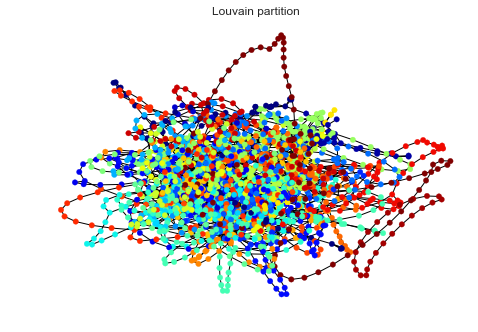

In [102]:
plot_communities(G_busnew, partition, "Louvain partition")

In [13]:
part = community_louvain.best_partition(G_busnew)
mod = community.modularity(part,G_busnew)

NotAPartition: {'Trelawny - Av Litoral': 0, 'Hospital del Mar': 0, 'Platja de la Barceloneta': 1, 'Pg Marítim - Pepe Rubianes': 1, 'Pepe Rubianes': 1, 'Pg  Joan de Borbó': 1, 'Pla de Palau - Pl Pau Vila': 1, 'Pg  Colom - Via Laietana': 1, 'Moll de la Fusta': 2, 'Portal de la Pau': 2, 'Les Drassanes': 2, 'Paral·lel - Drassanes': 3, 'Metro Paral·lel': 3, 'Paral·lel - Ronda Sant Pau': 4, 'Paral·lel - Marquès de Campo Sagrado': 4, 'Paral·lel - Rocafort': 4, 'Paral·lel - Floridablanca': 4, 'Paral·lel - Av Mistral': 4, 'Creu Coberta - Pl Espanya': 4, 'Metro Hostafrancs': 5, 'Sants - Premià': 5, 'Metro Pl de Sants': 5, 'Pl de Sants': 5, 'Sants - Rambla del Brasil': 5, 'Metro Badal': 5, 'Arizala - Av Madrid': 5, 'Arizala - Les Corts': 5, 'Les Corts - Aurora Bertrana': 5, 'Collblanc - Cardenal Reig': 5, 'Ernest Lluch': 5, 'Cardenal Reig - Pisuerga': 5, 'Av Sant Ramon Nonat - Cardenal Reig': 5, 'Metro Collblanc': 5, 'Sants - Munné': 5, 'Sants - Badal': 5, 'Sants - Gayarre': 5, 'Pl Espanya - Paral·lel': 4, 'Paral·lel - Tamarit': 4, 'Metro Poble Sec': 4, 'Paral·lel - Margarit': 4, 'Paral·lel - Vila i Vilà': 3, 'Paral·lel - Cabanes': 3, 'Pla de Palau': 1, 'Pg Joan de Borbó': 1, 'Tarragona - Pl Espanya': 6, 'Metro Tarragona': 6, 'Av Roma - Tarragona': 6, 'Josep Tarradellas - Rosselló': 6, 'Josep Tarradellas - París': 6, 'Josep Tarradellas - Viladomat': 6, 'Josep Tarradellas - Av de Sarrià': 6, "Buenos Aires - Comte d'Urgell": 7, 'Trav de Gràcia - Muntaner': 7, 'Trav de Gràcia - Balmes': 7, 'Pl Gal·la Placídia': 7, 'Rambla Prat, 19': 7, 'Gran de Gràcia - Pl Trilla': 7, 'Gran de Gràcia - Lesseps': 7, 'Trav de Dalt - La Granja': 7, 'Trav de Dalt - Torrent de les Flors': 7, 'Camèlies - Secretari Coloma': 7, 'Camèlies - Praga': 7, 'Pl de la Font Castellana': 7, 'Verge de Montserrat - Cartagena': 7, 'Verge de Montserrat - La Bisbal': 8, 'Verge de Montserrat - Periodistes': 9, 'Ronda Guinardó - Torre dels Pardals': 9, 'Metro Maragall': 9, 'Ramon Albó - Alexandre Galí': 9, "Arnau d'Oms - La Jota": 9, 'Doctor Pi i Molist - Pl Virrei Amat': 9, 'Doctor Pi i Molist - Maladeta': 9, 'Pla de las Madres de la Plaza de Mayo': 9, "Pg de Verdum - Pl Jardins de l'Alfàbia": 9, 'Artesania - Pl de la República': 9, 'Artesania - Góngora': 9, 'Artesania - Via Favència': 10, 'Rda. Guineueta Vella-Antonio Machado': 10, 'Antonio Machado - Artesania': 10, 'Via Favència - IES Guineueta': 10, 'Almansa, 29': 10, "Via Júlia - Font d'en Canyelles": 10, 'Via Júlia - Pl de la República': 9, 'Pg Verdum - Lorena': 9, 'Pg de Verdum - Doctor Pi i Molist': 9, 'Doctor Pi i Molist - Orduña': 9, 'Doctor Pi i Molist - Fabra i Puig': 9, 'Borbó - Serrano': 9, 'Borbó - Pg Maragall': 9, 'Pl del Nen de la Rutlla': 8, 'Verge de Montserrat - Gènova': 7, 'Verge de Montserrat - Francesc Alegre': 7, 'Verge de Montserrat - França': 7, 'Verge de Montserrat - Praga': 7, 'Trav de Dalt - Riera de Can Toda': 7, 'CAP Larrard': 7, 'Trav de Dalt - Verdi': 7, 'Pl Lesseps - Riera de Vallcarca': 7, "Guillem Tell - Av Príncep d'Astúries": 7, 'Balmes - Via Augusta': 7, 'Balmes - Trav de Gràcia': 7, 'Travessera de Gràcia-Muntaner': 7, 'Travessera de Gràcia-Amigó': 6, 'Josep Tarradellas - Francesc Macià': 6, 'Josep Tarradellas - Av.Sarrià': 6, 'Josep Tarradellas - Entença': 6, 'Josep Tarradellas - Numància': 6, 'Tarragona - Consell de Cent': 6, "Av de l'Exèrcit - Trias i Giró": 11, "Gran Capità - Av de l'Exèrcit": 11, "Sor Eulàlia d'Anzizu - González Tablas": 11, "Av d'Esplugues - González Tablas": 11, "Av d'Esplugues": 11, "Av d'Esplugues - Av Pearson": 11, 'Bisbe Català - Pl Pedralbes': 11, 'Pg Reina Elisenda - Av JV Foix': 11, 'Pl de Sarrià': 12, 'Pg Bonanova - Anglí': 12, 'Pg Bonanova - Escoles Pies': 12, 'Pg Bonanova - Mandri': 12, 'Pl Bonanova': 13, 'Pg Sant Gervasi - Pl John F Kennedy': 13, 'Pg Sant Gervasi - Mas Yebra': 13, 'Pl Alfonso Comín - Av República Argentina': 13, "Pl Alfonso Comín - Pg  Vall d'Hebron": 14, "Pg Vall d'Hebron - Av de Vallcarca": 14, "Pg Vall d'Hebron - Patronat Ribes": 14, "Pg Vall d'Hebron - Basses d'Horta": 14, "Palau d'Esports de la Vall d'Hebron": 14, "Parc de la Vall d'Hebron": 15, "Pg Vall d'Hebron - Av Can Marcet": 15, "Pg Vall d'Hebron - Ctra d'Horta": 15, "Pg Vall d'Hebron - Scala Dei": 10, 'Pl Karl Marx': 10, 'Pg  Valldaura - Fabra i Puig': 9, 'Mercat de la Guineueta': 9, 'Pg  Valldaura - Pg  de Verdum': 9, 'Pg Valldaura - Escultor Ordóñez': 9, 'Pg Valldaura - Pg Andreu Nin': 9, 'Pl de Mossèn Clapés': 16, 'Pg Torras i Bages - Almirall Pròixida': 16, 'Pg Torras i Bages - Residència': 16, 'Pg Torras i Bages - Joan Torras': 16, 'Sant Adrià - Josep Soldevila': 16, 'Parc de La Maquinista': 16, 'Sao Paulo - República Dominicana': 16, "Sao Paulo - Ciutat d'Asunción": 16, "Lima - Ciutat d'Asunción": 16, 'Lima - Sas': 16, 'Arbeca - Lima': 16, 'Sant Adrià - Biosca': 16, 'Sant Adrià - Sas': 16, "Ciutat d'Asunción - Sant Adrià": 16, "Pg de l'Havana - Ciutat d'Asunción": 16, 'Parc de la Maquinista': 16, 'Segre - Pl de Can Fabra': 16, 'Pg Torras i Bages - Els Segadors': 16, 'Pg Torras i Bages - Palomar': 16, 'Pg de Santa Coloma - Ctra de Ribes': 16, 'Gran de Sant Andreu - Palomar': 16, 'Pl Miquel Casablancas': 9, 'Pg Valldaura - Av Rio de Janeiro': 9, "Pg Valldaura - Font d'En Canyelles": 9, 'Pg Valldaura - Rambla Caçador': 9, 'Pg  Valldaura - Mercat Guineueta': 9, 'Pg Valldaura - Guineueta': 10, "Pl Karl Marx - Pg  Vall d'Hebron": 10, "Pg Vall d'Hebron - Cementiri d'Horta": 14, "Pg Vall d'Hebron - Velòdrom": 14, "Pg Vall d'Hebron - Mundet": 14, "Pg Vall d'Hebron - IES Narcís Monturiol": 14, "Pg Vall d'Hebron - Poesia": 14, "Pg Vall d'Hebron - Granja Vella": 14, "Vall d'Hebron, 107-117": 14, "Pg Vall d'Hebron - Natzaret": 14, "Pg Vall d'Hebron - L'Arrabassada": 13, 'Pl Alfonso Comín - Isaac Newton': 13, 'Av República Argentina - Pl Alfonso Comín': 13, 'Craywinckel - Hurtado': 13, 'Pg Sant Gervasi - Pl Bonanova': 6, 'Pg Bonanova - Carrasco i Formiguera': 12, 'Pg Reina Elisenda - Major de Sarrià': 12, 'Bisbe Català - Pl de Pedralbes': 11, "Av d'Esplugues - Dr Joaquim Albarrán": 11, "Av d'Esplugues - Eduard Toldrà": 11, 'González Tablas - Manuel Ballbé': 11, 'Zona Universitària': 11, "ETS d'Arquitectura": 11, 'Palau Reial': 11, 'Pl. Pius XII': 12, 'Pl Reina Maria Cristina': 12, 'Maria Cristina - Carles III': 12, 'Carles III - Numància': 12, 'Mitre - Av Sarrià': 12, 'Mitre - Doctor Fleming': 12, 'Mitre - Ganduxer': 12, 'Mitre - Mandri': 12, 'Mitre - Muntaner': 12, 'Mitre - Balmes': 7, 'Mitre - Saragossa': 7, 'Mitre - Berna': 7, 'Pl Lesseps': 7, 'Guinardó - Lepant': 9, 'Rda Guinardó-Castillejos': 9, 'Rda Guinardó-Sant Quintí': 9, 'Rda Guinardó-Vinyals': 9, 'Escòcia': 9, 'Fabra i Puig': 9, 'Fabra i Puig - Meridiana': 9, "Fabra i Puig - Arnau d'Oms": 9, 'Pg Maragall - Ronda Guinardó': 9, 'Rda Guinardó-Segle XX': 9, 'Rda Guinardó-Telègraf': 7, 'Rda Guinardó-Cartagena': 7, 'Guinardó - Parc de les Aigües': 7, 'Mitre - Pàdua': 7, 'Mitre - Prat de la Riba': 12, 'Manuel Girona - Carles III': 12, 'Capità Arenas - Maria Cristina': 12, 'Pl Pius XII': 11, 'Cardenal Reig - Av St Ramon Nonat': 5, 'Riera Blanca - Les Corts': 5, 'Av de Madrid - Arizala': 5, 'Comandant Benítez - Av Madrid': 5, 'Les Corts - Maternitat': 5, 'Les Corts - Carles III': 5, 'Les Corts - Vallespir': 5, 'Numància - Parc Les Corts': 6, 'Numància - Marquès de Sentmenat': 6, 'Josep Tarradellas - Comte Borrell': 6, 'Diagonal - Francesc Macià': 6, 'Diagonal - Muntaner': 17, 'Diagonal - Balmes': 17, 'Diagonal - Pau Claris': 17, 'Rosselló - Bruc': 17, 'Rosselló - Bailèn': 17, 'Pg de Sant Joan - Còrsega': 17, 'Indústria - Nàpols': 17, 'Indústria - Lepant': 18, 'Av Gaudí': 18, 'Indústria - Independència': 18, 'Indústria - Freser': 18, 'Navas de Tolosa - Indústria': 18, 'Meridiana - Josep Estivill': 18, 'Meridiana - La Sagrera': 19, 'Garcilaso - La Sagrera': 19, 'Berenguer de Palou - Pont del Treball': 19, 'Berenguer de Palou - Pare Manyanet': 19, 'Pare Manyanet - Josep Soldevila': 19, 'Segre - Borriana': 16, 'La Maquinista': 16, "Ciutat d'Asunción - Pg de l'Havana": 16, 'Josep Soldevila - Torrent Estadella': 16, 'Josep Soldevila - Onze de Setembre': 16, 'Onze de Setembre - Virgili': 19, 'Gran de Sant Andreu - Fabra i Puig': 19, 'Sagrera - Parc de la Pegaso': 19, 'Sagrera - Martí Molins': 19, 'Sant Antoni Maria Claret - Felip II': 9, 'Sant Antoni Maria Claret - Trinxant': 9, 'Sant Antoni Maria Claret - Rambla Volart': 9, 'Sant Antoni Maria Claret - Independència': 18, 'Av Gaudí - Castillejos': 18, 'Sant Antoni Maria Claret - Lepant': 7, 'Sant Antoni Maria Claret - Sardenya': 7, 'Sant Antoni Maria Claret - Nàpols': 7, 'Pg de Sant Joan - Indústria': 17, 'Còrsega - Bailèn': 17, 'Còrsega - Llúria': 17, 'Diagonal - Pg  de Gràcia': 17, 'Les Corts - Pl Dr Ignasi Barraquer': 6, 'Les Corts - Numància': 6, 'Mercat de Les Corts': 5, 'Les Corts - Mejía Lequerica': 5, 'Les Corts - Arizala': 5, 'Av Madrid - Arizala': 5, 'Av Madrid - Carles III': 5, 'Av Madrid - Joan Güell': 6, 'Pl del Centre': 6, 'Numància - Berlín': 6, 'València - Entença': 6, 'València - Viladomat': 6, "València - Comte d'Urgell": 6, 'València - Muntaner': 2, 'València - Balmes': 2, 'València - Pg de Gràcia': 2, 'València - Roger de Llúria': 2, 'Mercat de la Concepció': 17, 'València - Pg  Sant Joan': 17, 'València - Diagonal': 17, 'València - Lepant': 19, 'València - Padilla': 19, 'València - Dos de Maig': 19, 'València - Rogent': 19, 'València - Muntanya': 19, 'Espronceda - Guipúscoa': 19, 'Guipúscoa - Bac de Roda': 19, 'Guipúscoa - Julián Besteiro': 19, 'Guipúscoa - Treball': 19, 'Guipúscoa - Cantàbria': 19, 'Guipúscoa - Rambla Prim': 20, 'Guipúscoa - Extremadura': 20, 'Guipúscoa - Biscaia': 20, 'Av Pi i Margall - Ricart': 20, 'Alfons XIII - Simancas': 20, 'Alfons XIII - Av del Maresme': 20, 'Alfons XIII - Jumella': 20, 'Alfons XIII - Sant Lluc': 20, 'Alfons XIII - Josep M de Segarra': 20, 'Av Marquès de Montroig - Pl  Pres. Tarradellas': 20, 'Alfons XIII - Pau Claris': 20, 'Alfons XIII - Juan Valera': 20, 'Av Alfons XIII - Andrés Segovia': 20, 'Alfons XIII - Aribau': 20, 'Av Pi i Margall - Av Catalunya': 20, 'Tibidabo - Mare de Déu de Montserrat': 20, 'Guipúscoa - Verneda': 20, 'Guipúscoa - Selva de Mar': 19, 'Clot - Pont de Bac de Roda': 19, 'Mallorca - Meridiana': 19, 'Mallorca - Rogent': 18, 'Mallorca - Dos de Maig': 18, 'Mallorca - Padilla': 18, 'Mallorca - Marina': 18, 'Mallorca - Nàpols': 17, 'Mallorca - Pg  Sant Joan': 17, 'Mallorca - Girona': 17, 'Mallorca - Pau Claris': 17, 'Mallorca - Pg de Gràcia': 17, 'Mallorca - Balmes': 17, 'Mallorca - Muntaner': 6, "Mallorca - Comte d'Urgell": 6, 'Mallorca - Viladomat': 6, 'Av de Roma - Entença': 6, 'Pl  Països Catalans': 6, 'Comtes de Bell-lloc - Viriat': 6, 'Av Madrid - Benavent': 5, 'Gornal': 21, 'Av Granvia - Miguel Hernández': 21, 'Amadeu Torner': 21, 'Pl Europa': 21, "Gran Via de l'Hospitalet, 87-89": 21, 'Av Granvia - Bloc I. Cerdà': 21, 'Gran Via - Radi': 21, 'Gran Via - Química': 21, 'La Campana': 4, 'Gran Via - Mandoni': 4, 'Gran Via - Santa Dorotea': 4, 'Pl Espanya - FGC': 4, 'Gran Via - Pl  Espanya': 4, 'Gran Via - Entença': 4, 'Gran Via - Viladomat': 2, 'Gran Via - Urgell': 2, 'Gran Via - Muntaner': 2, 'Pl Universitat': 2, 'Gran Via - Balmes': 2, 'Gran Via - Pau Claris': 17, 'Gran Via - Llúria': 17, 'Metro Tetuan': 17, 'Gran Via - Roger de Flor': 17, 'Gran Via - Marina': 18, 'Gran Via - Padilla': 18, 'Pl Glòries Catalanes, s/n': 18, 'Gran Via - Llacuna': 20, 'Gran Via - Bilbao': 20, 'Gran Via - Bac de Roda': 20, 'Gran Via - Selva de Mar': 20, 'Gran Via - St Martí Provençals': 20, 'Gran Via - Maresme': 20, 'Metro Besòs': 20, 'Besòs - Verneda': 20, "Gran Via - Ca n'Oliva": 20, 'Gran Via - Agricultura': 20, 'Gran Via - Pl dels Porxos': 20, 'Gran Via - Espronceda': 20, 'Gran Via - Parc del Clot': 18, 'Gran Via Corts Catalanes, 851': 18, 'Glòries Catalanes, 8-15': 18, 'Gran Via, 751': 18, 'Gran Via - Sardenya': 18, 'Gran Via - Casanova': 2, 'Gran Via - Villarroel': 2, 'Gran Via - Calàbria': 2, 'Gran Via - Vilamarí': 2, 'Gran Via - Pl Espanya': 2, 'Gran Via - Farell': 4, 'Gran Via - Moianès': 4, 'Gran Via - Ildefons Cerdà': 21, 'Ildefons Cerdà - Ciutat de la Justícia': 21, 'Av Granvia - Alhambra': 21, 'Av Granvia - Natzaret': 21, 'Av Granvia - Can Tries': 21, 'Ronda Sant Pau - Carrer de les Flors': 3, 'Pg  Isabel II - Pla de Palau': 1, 'Estació de França': 1, 'Parc de la Ciutadella - Princesa': 1, 'Pg Pujades - Parc de la Ciutadella': 18, 'Buenaventura Muñoz - Sardenya': 18, 'Pallars - Zamora': 18, 'Pallars - Pere IV': 18, 'Pere IV-Llacuna': 22, 'Pere IV - Bilbao': 22, 'Cristóbal de Moura-Espronceda': 22, 'Pere IV-Provençals': 22, 'Selva de Mar - Pere IV': 22, 'Cristóbal de Moura-Josep Pla': 22, 'Cristóbal de Moura - Rambla Prim': 22, 'Cristóbal de Moura-Perpinyà': 22, 'Cristóbal de Moura - Parc del Besòs': 0, 'Cristóbal de Moura - La Catalana': 0, 'Torrassa - Mare de Déu del Carme': 0, "Av de la Platja - Pont d'Eduard Maristany": 0, 'Cristóbal de Moura-Rambla Prim': 22, 'Pere IV-Josep Pla': 22, 'Pere IV-Selva de Mar': 22, 'Marroc-Bac de Roda': 22, 'Marroc - Bilbao': 22, 'Tànger - Llacuna': 22, 'Tànger - Badajoz': 22, 'Tànger-Av Meridiana': 22, 'Meridiana - Almogàvers': 1, 'Pg  Pujades - Parc de la Ciutadella': 1, 'Pg Picasso - Princesa': 1, "Pla de Palau - Av Marquès de l'Argentera": 1, 'Pl del Nou': 21, 'Pg  Zona Franca - Cisell': 21, 'Pg  Zona Franca - Alts Forns': 21, 'Pg  Zona Franca - Foneria': 21, 'Pg  Zona Franca - Mineria': 21, 'Gran Via - Llançà': 4, 'Floridablanca - Av Mistral': 4, 'Floridablanca - Viladomat': 4, "Floridablanca - Comte d'Urgell": 4, 'Ronda Sant Antoni - Pl Goya': 17, 'Pl Universitat - Pelai': 17, "Pl Catalunya - Portal de l'Àngel": 17, 'Pl Urquinaona': 17, 'Trafalgar - Bruc': 17, 'Pg  Lluís Companys - Arc de Triomf': 17, 'Pg. Lluís Companys 9-11': 17, 'Sardenya - Pg  Pujades': 18, 'Ramon Trias Fargas - Doctor Trueta': 18, 'Icària - Parc Carles I': 18, 'Av Icària - Joan Miró': 0, 'Av Icària - Av Bogatell': 0, "Cementiri de l'Est": 0, 'Pg Calvell - Rambla del Poblenou': 0, 'Pg Taulat - Jonquera': 0, 'Pg  Taulat - Bac de Roda': 0, 'Pg  Taulat - Provençals': 0, 'Pg  Taulat - Diagonal Mar': 0, 'Pg Taulat-Pl de Llevant': 0, 'Av Eduard Maristany-St Ramon de Penyafort': 0, 'Eduard Maristany, 1': 0, 'Diagonal Mar': 0, 'Jonquera - Pg  Taulat': 0, 'Av Icària - Àlaba': 0, 'Marina - Doctor Trueta': 0, 'Marina-Llull': 1, 'Pg  Lluís Companys - Parc de la Ciutadella': 1, 'Pg  Lluís Companys - Almogàvers': 17, 'Arc de Triomf': 17, 'Ronda Sant Pere - Girona': 17, 'Metro Urquinaona': 17, 'Pl Catalunya - Pg  de Gràcia': 17, 'Ronda Universitat - Pl Universitat': 2, 'Sepúlveda - Muntaner': 2, 'Villarroel - Sepúlveda': 2, 'Tamarit - Mercat de Sant Antoni': 4, 'Manso-Comte Borrell': 4, 'Manso - Rocafort': 4, 'Pg  Zona Franca - Ctra del Prat': 21, 'Pg  Zona Franca - Foc': 21, 'Pol. Ind. Zona Franca': 3, 'Transports Metropolitans de Barcelona': 3, 'Pg  Zona Franca - Motors': 3, 'Ildefons Cerdà - Rambla Badal': 21, 'Badal - Av Carrilet': 21, 'Badal - Constitució': 5, 'Carles III - Les Corts': 5, 'Carles III - Mejía Lequerica': 5, 'Diagonal - Joan Güell': 12, 'Benet Mateu - Manuel de Falla': 12, 'Santa Amèlia - Capità Arenas': 12, 'Santa Amèlia': 12, 'Av J V Foix - Pedró de la Creu': 12, 'Av J V Foix - Pg Reina Elisenda': 12, 'Av J V Foix - Monestir': 12, 'Ronda de Dalt - Av J V Foix': 12, 'Esports - Ronda de Dalt': 12, 'Can Caralleu': 12, 'Ronda de Dalt - Av J.V.Foix': 12, 'Av J.V. Foix - Pg Reina Elisenda': 12, 'Av J.V.Foix - Pedró de la Creu': 12, 'Eduardo Conde - Santa Amèlia': 12, 'Doctor Ferran': 12, 'Carles III - Maria Cristina': 12, 'Carles III - Av Madrid': 5, 'Pg. Zona Franca-Sant Eloi': 21, 'Foc - Mare de Déu de Port': 21, 'Ferrocarrils Catalans - Aviador Duran': 21, "Mare de Déu de Port-L'Anoia": 4, 'Mineria-Font Florida': 4, 'Mossèn Amadeu Oller, 18-20': 4, 'Olzinelles - Constitució': 4, 'Olzinelles - Noguera Pallaresa': 4, 'Pl Bonet i Muixí': 6, 'Pl. Sants': 6, 'Pl de Joan Peiró': 6, 'Comtes de Bell-lloc-Berlín': 6, 'Can Bruixa-Comtes de Bell-lloc': 6, 'Diagonal - Pl Reina Maria Cristina': 11, 'Av Pedralbes - Tòquio': 11, 'Av. Pedralbes - Cavallers': 11, 'Cavallers-Marquès de Mulhacén': 11, 'Av Pedralbes-Bisbe Català': 11, 'Av Pedralbes - Cavallers': 11, 'Av Pedralbes - Pg  Manuel Girona': 11, 'Diagonal - Av Joan XXIII': 11, 'Joan Güell-Travessera de les Corts': 5, 'Joan Güell - Av. Madrid': 5, 'Joan Güell-Cerdanyola': 5, 'Moianès - Vilardell': 5, 'Moianès - Cuyàs': 4, 'Química-Gran Via': 4, 'Mare de Déu de Port - Mineria': 21, 'Mare de Déu de Port - Foneria': 21, 'Mare de Déu de Port-Foc': 21, 'Cisell-Mare de Déu de Port': 21, 'Nicaragua - Josep Tarradellas': 6, 'Nicaragua - Parc Les Corts': 6, 'Constança': 6, 'Av Sarrià': 6, 'Av Sarrià - Prat de la Riba': 6, 'Pg Sant Joan Bosco': 6, 'Els Vergós': 12, 'Via Augusta - Pau Alcover': 12, 'Pg Bonanova': 12, 'CAP Sarrià': 12, 'Pl Borràs': 12, 'Sarrià': 12, 'Via Augusta - Margenat': 12, 'Via Augusta - Els Vergós': 12, 'Pg  Sant Joan Bosco - Prat de la Riba': 6, 'Numància - Diagonal': 6, 'Numància - Av Roma': 6, 'Moll de Barcelona': 3, 'Pl Josep Maria Folch': 4, 'Ronda Sant Pau - Parlament': 4, "Comte d'Urgell - Floridablanca": 12, "Comte d'Urgell - Gran Via": 12, "Comte d'Urgell - Aragó": 12, "Comte d'Urgell - Mercat del Ninot": 12, "Comte d'Urgell - Hospital Clínic": 12, 'Casanova - Diagonal': 12, 'Santaló - Trav de Gràcia': 12, 'Santaló - Mercat Galvany': 12, 'Via Augusta - Amigó': 12, 'Via Augusta - Modolell': 12, 'Ganduxer - Alacant': 12, 'Ganduxer - Emancipació': 12, "Mandri - Jardins Ca n'Altamira": 12, 'Mandri - Artesa de Segre': 12, 'Via Augusta - Ganduxer': 12, 'Via Augusta - Calvet': 12, 'Calvet - Tenor Viñas': 12, 'Calvet - Diagonal': 12, 'Villarroel - Buenos Aires': 6, 'Villarroel, 177': 2, 'Villarroel - Mercat del Ninot': 2, 'Villarroel - Aragó': 2, 'Villarroel - Gran Via': 2, 'Viladomat - Manso': 4, 'Pla de Palau - Metro Barceloneta': 1, 'La Rambla - Pl del Teatre': 2, 'La Rambla - Liceu': 2, 'La Rambla - Pl Catalunya': 2, 'Aribau - Gran Via': 2, 'Aribau - Aragó': 6, 'Aribau - Mallorca': 6, 'Aribau - Còrsega': 13, 'Aribau - Diagonal': 13, 'Aribau - Laforja': 13, 'Via Augusta - Muntaner': 13, 'Santaló - Plató': 13, "Pl d'Adrià": 13, 'Mandri - Mitre': 13, 'Mandri - Maó': 13, 'Mandri - Bigai': 13, 'Pl John F Kennedy': 13, 'Muntaner - Pl Bonanova': 6, 'Muntaner - Bisbe Sivilla': 6, 'Muntaner - Mitre': 6, 'Muntaner - Parc de Monterols': 6, 'Muntaner - Plató': 6, 'Muntaner - Via Augusta': 6, 'Muntaner - Laforja': 6, 'Muntaner - Diagonal': 6, 'Muntaner - Roselló': 6, 'Muntaner - València': 6, 'Muntaner - Diputació': 2, 'Balmes - Pelai': 2, 'La Rambla - Font de Canaletes': 2, 'La Rambla - La Boqueria': 2, 'La Rambla - Santa Mònica': 2, 'Pl  Rosa dels Vents': 1, 'Pg Joan de Borbó - Moll de Catalunya': 1, 'Pg Joan de Borbó - Pl del Mar': 1, 'Pg Joan de Borbó - Judici': 1, 'Pg  Joan de Borbó - Almirall Aixada': 1, 'Via Laietana - Jutjats': 1, 'Via Laietana - Pl Ramon Berenguer': 1, 'Via Laietana - Comtal': 17, 'Pg de Gràcia - Casp': 17, 'Pg de Gràcia - Gran Via': 17, 'Pg de Gràcia - Aragó': 17, 'Pg de Gràcia - Mallorca': 17, 'Pg de Gràcia - Diagonal': 17, 'Via Augusta - Diagonal': 17, 'Pl Molina': 7, 'Balmes - Pàdua': 7, 'Balmes - Mitre': 13, 'Balmes - Joaquim Folguera': 13, 'Balmes - Pl John F. Kennedy': 13, "Pg Vall d'Hebron - Trueba": 14, "Coll i Alentorn - Basses d'Horta": 14, 'Av Martí Codolar - Coll i Alentorn': 14, 'Granja Vella - Av Martí i Codolar': 14, "Granja Vella - Basses d'Horta": 14, "Ciutat Sanitària de la Vall d'Hebron": 14, 'Balmes - Pl Joaquim Folguera': 13, 'Balmes - Copèrnic': 7, 'Balmes - Diagonal': 7, 'Balmes - Rosselló': 17, 'Balmes - València': 2, 'Balmes - Aragó': 2, 'Balmes - Gran Via': 17, 'Via Laietana - Correus': 1, 'Pas Sota Muralla - Pl Pau Vila': 1, 'Pg Joan de Borbó - Almirall Aixada': 1, 'Pg  Joan de Borbó - Pl  del Mar': 1, 'Maremagnum': 1, 'Port Vell': 1, 'Pas Sota Muralla - Pg  Colom': 1, 'Llúria - Urquinaona': 17, 'Llúria - Gran Via': 17, 'Llúria - Aragó': 17, 'Llúria - Mallorca': 17, 'Còrsega - Pg  de Gràcia': 17, 'Gran de Gràcia - Jesús': 17, 'Gran de Gràcia - Trav de Gràcia': 17, 'Gran de Gràcia - Metro Fontana': 7, 'Bolívar - Ballester': 7, 'Av República Argentina - Vallcarca': 13, 'Vallcarca': 13, 'Mare de Déu del Coll - Cartago': 13, 'Mare de Déu del Coll - Baixada de Sant Marià': 13, 'Mare de Déu del Coll - Santuari': 13, 'Santuari - Ceuta': 13, 'Santuari - La Murtra': 23, 'Gran Vista - Doctor Bové': 23, 'IES Ferran Tallada': 23, 'Gran Vista - Turó de la Rovira': 23, 'Gran Vista - Pl de la Mitja Lluna': 23, "Santuari - l'Hortal": 13, 'Mare de Déu del Coll - Baixada Solanell': 13, 'Mare de Déu del Coll - Pl Flandes': 13, 'Av República Argentina - Escipió': 7, "Lesseps - Av Príncep d'Asturies": 7, "Av Príncep d'Astúries - Guillem Tell": 7, 'Gal·la Placídia': 7, 'Pau Claris - Mallorca': 17, 'Pau Claris - Aragó': 17, 'Pau Claris - Gran Via': 17, 'Urquinaona': 17, 'Pas Sota Muralla - Via Laietana': 1, 'Pg  Marítim': 0, 'Marina - Pl dels Voluntaris': 0, 'Metro Marina': 18, 'Marina - Ausiàs Marc': 18, 'Marina - Monumental': 18, 'Marina - Diagonal': 18, 'Padilla - Mallorca': 15, 'Padilla - Rosselló': 15, 'Marina - Indústria': 15, 'Padilla - Trav de Gràcia': 15, 'Padilla - Mas Casanovas': 15, 'Padilla - Túnel de la Rovira': 15, 'Rambla del Carmel': 15, 'Lletres - Dante Alighieri': 15, "Pl de l'Estatut": 15, 'Pl Botticelli': 15, 'Av Cardenal Vidal i Barraquer - Berruguete': 15, 'Jorge Manrique - Can Travi': 15, 'Arquitecte Moragas - Jorge Manrique': 14, "Pg  Vall d'Hebron - Metro Montbau": 14, 'Arquitectura - Àngel Marquès': 14, 'Vayreda - Arquitectura': 14, 'Montbau': 14, 'Poesia - Jardins de Montbau': 14, 'Jorge Manrique - C E Hispano Francès': 15, 'Av Cardenal Vidal i Barraquer - Pl Botticelli': 15, 'Rambla del Carmel - Dante Alighieri': 15, 'Lepant - Guinardó': 18, 'Lepant - Trav de Gràcia': 18, 'Lepant - Sant Antoni Maria Claret': 18, 'Lepant - Mallorca': 18, 'Lepant - Diagonal': 18, 'Marina - Ribes': 18, 'Marina-Pujades': 18, 'Marina - Ramon Turró': 18, 'Vila Olímpica': 0, 'Pg  Marítim - Hospital del Mar': 0, 'Dr. Aiguader - Pl  del Gas': 0, 'Av Litoral - Trelawny': 0, 'Bac de Roda - Pg.Taulat': 0, 'Bac de Roda - Llull': 19, 'Bac de Roda - Cristóbal de Moura': 19, 'Bac de Roda - Bolívia': 19, 'Bac de Roda - Gran Via': 19, 'Bac de Roda - Rambla de Guipúscoa': 19, 'Felip II - Palència': 19, 'Felip II - Meridiana': 19, 'Pl dels Indians': 9, 'Felip II - Pl del Congrés': 9, "Felip II - Arnau d'Oms": 9, 'Mercat Mare de Déu de la Mercè': 9, 'Fabra i Puig - Petrarca': 9, 'Parc del Turó de la Peira': 9, 'Fabra i Puig - Pg  Urrutia': 9, 'Ronda Guineueta Vella - Antonio Machado': 10, 'Ronda Guineueta Vella - Juan Ramón Jiménez': 10, 'Ronda Guineueta Vella - Barri Canyelles': 10, 'Ronda Guineueta Vella - Escola Deià': 10, 'Antonio Machado - Barri de Canyelles': 10, 'Via Favència - Barri Canyelles': 10, 'Metro Canyelles': 10, 'Via Favència - Pl Karl Marx': 10, 'Parc Turó de la Peira': 9, 'Felip II - Ramon Albó': 9, 'Felip II - Pl Congrés': 9, 'Espronceda - Pl Islàndia': 19, 'Espronceda - Gran Via': 19, 'Espronceda - Marroc': 19, 'Espronceda - Pere IV': 19, 'Espronceda - Jardins Josep Trueta': 19, 'Espronceda - Ramon Turró': 0, 'Josep Pla-Av Diagonal': 22, 'Josep Pla-Pallars': 22, 'Josep Pla - Cristóbal de Moura': 19, 'Josep Pla - Perú': 19, 'Cantàbria - Andrade': 19, "Cantàbria - Pl del Ram de l'Aigua": 19, 'Pont del Treball - Santander': 19, "Meridiana - Pl dels Jardins d'Elx": 19, 'Meridiana - Pegaso': 16, 'Meridiana - Dublín': 16, 'Alcàntara - Garigliano': 10, 'Mina de la Ciutat - Les Torres': 10, 'Pl de les Roquetes': 10, 'Aiguablava - Pedrosa': 10, 'Aiguablava - Nou Barris': 10, 'Via Favència - Biblioteca Les Roquetes': 10, 'Via Favència - Almansa': 10, "Meridiana - Riera d'Horta": 24, 'Meridiana - Cardenal Tedeschini': 19, 'Pont del Treball-Santander': 22, 'Cantàbria - Menorca': 22, 'Cantàbria-Rambla Guipúscoa': 22, 'Selva de Mar-Rambla Guipúscoa': 22, 'Selva de Mar - Perú': 22, 'Selva de Mar - Llull': 22, 'Selva de Mar-Pg Taulat': 22, 'Av del Litoral-Platja de Llevant': 22, 'Josep Pla-Pg Garcia Fària': 22, 'Lope de Vega-Garcia Fària': 0, 'Llull - Selva de Mar': 0, 'Llull - Diagonal Mar': 0, 'Metro Maresme - Fòrum': 0, 'Rambla Prim - Ferrer Bassa': 0, 'Rambla Prim - Cristóbal de Moura': 0, 'Rambla Prim - Bernat Metge': 20, 'Rambla Prim - Metro La Pau': 19, 'Rambla Prim - Santander': 19, 'Via Trajana - Jaume Brossa': 19, 'Via Trajana - Rbla Prim': 19, 'Cantàbria - Rbla Prim': 19, 'Berenguer de Palou - Ferran Turné': 19, 'Segre-Parellada': 16, 'Pg Torras i Bages - Via Favència': 16, 'Pg Torras i Bages - Tossal': 16, 'Ctra de Ribes - Meridiana': 16, 'Meridiana - Almassora': 16, 'Pare Pérez del Pulgar - Peníscola': 16, 'Pare Pérez del Pulgar - Pare Manjón': 16, 'Via Barcino - Vicenç Montal': 16, 'Via Barcino - Foradada': 16, 'Via Barcino - Ausona': 16, 'Tossal - Pl Josep Andreu i Abelló': 16, 'Ctra de Ribes - Tossal': 16, 'Pg  Santa Coloma - Pg  Torras i Bages': 16, 'Santander - Pont del Treball Digne': 19, 'Rbla Prim - Jaume Brossa': 19, 'Via Trajana - Santander': 19, 'Santander - Via Trajana': 19, 'Rambla Prim - Cantàbria': 19, 'Rambla Prim - Guipúscoa': 19, 'Rambla Prim - Andrade': 19, 'Rambla Prim - Pere IV': 19, 'Rambla Prim - Pallars': 0, 'Diagonal - Josep Pla': 18, 'Diagonal - Selva de Mar': 18, 'Pujades - Provençals': 18, 'Doctor Ferran - Manuel Girona': 12, 'Manila - Doctor Ferran': 12, 'Diagonal - Gandesa': 12, "Diagonal - L'Illa Diagonal": 6, 'Diagonal - Entença': 6, 'Diagonal - Av de Sarrià': 6, 'Diagonal - Girona': 17, 'Pg de Sant Joan - Pl Mossèn Jacint Verdaguer': 17, 'Pg  Sant Joan - Consell de Cent': 17, 'Pg  de Sant Joan - Diputació': 17, 'Marina - Almogàvers': 18, 'Pallars - Ciutat de Granada': 18, 'Roc Boronat - Doctor Trueta': 18, 'Llacuna - Ramon Turró': 18, 'Pujades - Llacuna': 18, 'Pujades - Ciutat de Granada': 18, 'Almogàvers - Àvila': 18, "Almogàvers - Joan d'Àustria": 18, 'Marina - Meridiana': 18, 'Pl Tetuan - Pg de Sant Joan': 17, 'Pg de Sant Joan - Aragó': 17, 'Pg  de Sant Joan - València': 17, 'Pl Mossèn Jacint Verdaguer': 17, 'Diagonal - Bruc': 17, 'Diagonal - Ganduxer': 6, 'Av de Sarrià - Diagonal': 6, 'Av de Sarrià - Mestre Villa': 6, 'Manuel Girona - Capità Arenas': 12, 'Diagonal - Pl Llevant': 18, 'Diagonal - Llull': 18, 'Diagonal - Fluvià': 18, 'Diagonal - Parc del Poblenou': 18, 'Diagonal - Rambla del Poblenou': 18, 'Diagonal - Roc Boronat': 18, 'Diagonal - Doctor Fleming': 6, 'Diagonal - Numància': 11, 'Metro Zona Universitària': 11, 'Diagonal - Av Doctor Marañón': 11, "Zona Universitària - Escola T S d'Enginyeria": 11, 'Diagonal - Metro Palau Reial': 11, 'Diagonal - Gran Via Carles III': 12, 'Diagonal - Ciutat de Granada': 18, 'Diagonal - Pere IV': 18, 'Diagonal - Bac de Roda': 18, 'Diagonal - Metro Selva de Mar': 18, 'Diagonal - Agricultura': 18, 'Ctra de Ribes - Via Favència': 16, 'Palomar - Gran de Sant Andreu': 16, 'Fernando Pessoa': 16, 'Pg  Santa Coloma - Pl de la Modernitat': 16, 'Pg  Santa Coloma - Tiana': 16, 'Caracas - Clariana': 16, "Ciutat d'Asunción - Tucumán": 16, "Ciutat d'Asunción - Potosí": 16, 'Sant Adrià - Arbeca': 16, 'Segre - Sant Adrià': 19, 'Virgili - Pl de Montserrat Roca i Baltà': 19, 'Fabra i Puig - Neopàtria': 19, 'Fabra i Puig - Llenguadoc': 16, 'Piferrer - Deià': 9, 'Piferrer - Pintor Alsamora': 9, 'Av Rio de Janeiro - Cementiri de Sant Andreu': 9, 'Av Rio de Janeiro - Pg Valldaura': 16, 'Mina de la Ciutat - Pla de Fornells': 10, 'Parc del Pla de Fornells': 10, 'Via Favència - Almagro': 10, 'Pg Andreu Nin - Rosselló i Porcel': 9, 'Pg Andreu Nin - Parc Esportiu Can Dragó': 9, 'Pg Andreu Nin - Av Rio de Janeiro': 9, 'Vèlia - Pl Garrigó': 9, 'Dublín - Meridiana': 9, 'Rovira i Virgili - Parc de la Pegaso': 19, 'Pare Manyanet - Sant Sebastià': 19, 'Sant Adrià - Formiga': 16, 'Sant Adrià - Pg Enric Sanchís': 16, 'Sant Adrià - Bon Pastor': 16, 'Pg Guayaquil - Arbeca': 16, 'Lima - Caracas': 16, 'Caracas - Potosí': 16, 'Tiana - Campins': 16, 'Pg  Santa Coloma - Baró de Viver': 16, 'Palomar - Fernando Pessoa': 16, 'Pl de Josep Andreu i Abelló': 16, 'Manso-Viladomat': 4, 'Calàbria - Av Mistral': 4, 'Sepúlveda - Rocafort': 4, 'Sepúlveda - Av Mistral': 4, 'Pl Espanya - Centre Comercial Las Arenas': 4, 'Pl Espanya - Av Reina Maria Cristina': 21, 'Av Ferrer i Guàrdia - Mèxic': 21, 'Poble Espanyol': 21, 'Camí del Polvorí - Estadi Serrahima': 21, 'Segura - Estadi Serrahima': 21, 'Segura - Barri del Polvorí': 21, 'Segura - Escales del Polvorí': 21, 'Segura - Anoia': 21, 'Pedrera del Mussol - Can Clos': 21, 'Sot del Migdia': 21, 'Pg Olímpic - Palau Sant Jordi': 21, 'Jardí Botànic': 21, "Pg Olímpic - Av de l'Estadi": 21, 'Vivers': 21, 'Estadi Olímpic': 21, 'Palau Sant Jordi': 21, 'Foc - Sot del Migdia': 21, 'Pedrera del Mussol - Marbre': 21, 'Can Clos': 21, 'Ferrocarrils Catalans - Foc': 21, 'Ferrocarrils Catalans - Alts Forns': 21, 'Segura - Foneria': 21, 'Segura - Guadalquivir': 21, 'Segura - Fortuna': 21, 'Segura - Polvorí': 21, 'Polvorí - Camí de la Fuxarda': 21, 'Polvorí - Av Ferrer i Guàrdia': 21, 'Pl de Carles Buïgas': 21, 'Av Reina Maria Cristina - Pl Espanya': 21, 'Pg de Sant Joan - Alí-Bei': 17, 'Pg Maragall - Indústria': 18, 'Pg Maragall - Trinxant': 18, 'Pg Maragall - Puerto Príncipe': 18, 'Pg Maragall - Manigua': 18, 'Pg Maragall - Borbó': 15, 'Pg Maragall - Greco': 15, 'Pg Maragall - Sabastida': 15, 'Llobregós - Pg Maragall': 15, 'Llobregós - Torrent del Carmel': 15, 'Llobregós - Lluís Marià Vidal': 15, 'Dante Alighieri - Pantà de Tremp': 15, 'Josep Sangenís - Dante Alighieri': 15, 'Josep Sangenís - Santa Gemma': 15, 'Arenys - Rossell': 15, 'Arenys - Fastenrath': 15, 'Av Jordà - Hospital St Rafael': 14, 'Av Jordà - Idumea': 14, 'Natzaret - Av Jordà': 14, 'Sant Genís dels Agudells - Arquitectura': 14, 'Sant Genís dels Agudells': 14, 'Camí de Sant Genís - Natzaret': 14, 'Av Jordà - Natzaret': 14, 'Av Jordà - Nínive': 14, 'Av Jordà - Judea': 14, 'General Mendoza - Santa Rosalia': 14, 'Santa Rosalia - Castellbisbal': 14, 'Santa Rosalia - Besòs': 23, 'Santa Rosalia - Sant Dalmir': 23, 'Pg Mare de Déu del Coll - Ramon Rocafull': 23, 'Dante Alighieri - Sacedón': 23, 'Dante Alighieri - Tolrà': 23, "Dante Alighieri - Santa Joana d'Arc": 15, 'Pg Maragall - Dante Alighieri': 15, 'Pg Maragall - Av Frederic Rahola': 9, 'Pg Maragall - Mossèn Josep  Bundó': 9, 'Pg Maragall - Amílcar': 9, 'Pg Maragall - Els Quinze': 9, 'Pg Maragall - Segle XX': 9, 'Pg Maragall - Sta Joaquina Vedruna': 9, 'Pl Maragall - Xiprer': 9, 'Pg de St Joan - Ausiàs March': 17, 'Ronda Sant Pau - Paral·lel': 3, 'Pg de Josep Carner - Jardins de Walter Benjamin': 3, 'Cementiri de Montjuïc': 3, 'Estació TIR - Pg Zona Franca': 3, 'Area Metropolitana de Barcelona': 3, 'Carrer A - Carrer número 2': 3, 'Carrer A - Comissaria Portuària': 3, 'Carrer A - Carrer número 3': 3, 'Carrer A - Carrer número 4': 3, 'Carrer número 4 - Carrer B': 3, 'Zona Franca - Carrer número 4': 3, 'Carrer número 4': 3, 'Zona Franca - Mercabarna': 3, 'Carrer número 4 - Carrer número 50': 3, 'Carrer K - Carrer número 40': 3, 'Carrer K - Carrer número 6': 3, 'Ctra de la Marina - Av Onze de Setembre': 25, "Ctra de la Marina - Pg Ciutat de l'Hospitalet": 25, 'Lleida - Ctra de la Bunyola': 25, 'Lleida - Coronel Sanfeliu': 25, 'Pl Catalunya': 25, 'Lleida - Av Remolar': 25, 'Av Remolar - Av Pompeu Fabra': 25, 'Av Remolar - Av Apel·les Mestre': 25, "Vall d'Aran - Av del Remolar": 25, 'Estació RENFE - Andana 2': 25, "Vall d'Aran - Rda de Ponent": 25, 'Av Remolar - Rda de Ponent': 25, 'Av Remolar - Bruguers': 25, 'Av Remolar - Pirineus': 25, "Lleida - Ctra de l' Aviació": 25, 'Lleida - Caldetes': 25, 'Ctra de la Marina - Pl de la Constitució': 25, 'Ctra de la Marina - Mataró': 25, 'Mercabarna - Entrada El Prat': 25, 'Carrer K': 25, 'Carrer número 4 - Mercabarna': 3, 'Carrer número 4 - Carrer F': 3, 'Carrer número 4 - Carrer E': 3, 'Carrer número 4 - Carrer D': 3, 'Carrer número 4 - Carrer C': 3, 'Cotxeres TB Zona Franca': 3, 'Carrer A- Comissaria Portuària': 3, 'Estació TIR - Ronda Litoral': 3, 'Mare de Déu de Port - Cantunis': 3, 'Pg de Josep Carner - Pg de Montjuïc': 3, 'Ronda St Pere - Pg de Gràcia': 17, 'Av República Argentina - Baixada Gomis': 13, 'Josep Garí - Collserola': 13, 'Av Tibidabo - Josep Maria Florensa': 13, 'Av Tibidabo - Pg Sant Gervasi': 13, 'Av República Argentina - Mare de Déu del Carmel': 13, "Av Príncep d'Astúries - Via Augusta": 7, 'Pg de Gràcia - Rosselló': 17, 'Pg de Gràcia - València': 17, 'Pg de Gràcia - Consell de Cent': 17, 'Metro Pg de Gràcia': 17, 'Pl Espanya': 21, 'Pl de Sant Jordi': 21, 'Foc - Ferrocarrils Catalans': 21, 'Carrer número 1 - Carrer número 60': 3, 'Carrer número 2 - Carrer número 62': 3, 'Parc Logístic, anada': 3, 'Parc Logístic': 3, 'Carrer número 25 - Av Parc Logístic': 3, 'Parc Logístic, tornada': 3, 'Carrer número 2': 3, 'Av Ferrer i Guàrdia - Av Montanyans': 21, 'Aldana - Ronda Sant Pau': 4, 'Pl de Catalunya - Ronda Sant Pere': 17, 'Verge de Montserrat - Sanllehy': 7, 'Ramiro de Maeztu - Pl Sanllehy': 7, 'Ramiro de Maeztu - Miquel Sants Oliver': 7, 'Ramiro de Maeztu - C N Catalunya': 7, 'Ctra del Carmel - Parc Güell': 23, 'Ctra del Carmel - Albert Llanas': 23, 'Ctra del Carmel - Pasteur': 23, 'Ctra del Carmel - Mühlberg': 23, 'Doctor Bové - Gran Vista': 23, 'Doctor Bové - Ptge de la  Cadernera': 23, 'Doctor Bové - Pg de la Font de la Mulassa': 23, 'Doctor Bové - Penyal': 23, 'Doctor Bové - Baixada Passerell': 23, 'Doctor Bové - Conca de Tremp': 23, 'Ctra del Carmel - Gran Vista': 23, 'Ctra del Carmel - Pl Raimon Casellas': 23, 'Ctra del Carmel - Can Xirot': 23, 'Parc Güell': 23, 'Ctra del Carmel - Ramiro de Maeztu': 23, 'Ramiro de Maeztu - Av Pompeu Fabra': 23, 'Pl Sanllehy': 7, 'Pl dels Països Catalans - St Antoni': 6, 'Av de Vallcarca - Pl Lesseps': 7, 'Av de Vallcarca - Baixada de la Glòria': 7, 'Av de Vallcarca - Viaducte de Vallcarca': 7, 'Av Vallcarca - Centre Mèdic Delfos': 13, 'Parc Sanitari Pere Virgili': 13, 'Av Vallcarca - Capellades': 14, 'Pl Karl Marx - Ronda Guineueta Vella': 10, 'Les Torres - Mina de la Ciutat': 10, 'Artesania - Antonio Machado': 10, 'Av de Vallcarca - Metro Penitents': 14, 'CAP Vallcarca': 14, 'Centre Mèdic Delfos': 14, 'Av de Vallcarca - Gomis': 7, 'Av de Vallcarca - Ballester': 7, 'Jordi Girona - John M Keynes': 11, 'John M. Keynes - Diagonal': 11, 'Diagonal - Roger de Flor': 17, 'Guipúscoa - Bilbao': 19, 'Rbla Prim - Santander': 19, 'Zona Universitària - Escola A E Empresarials': 11, 'Doctor Ferran - Doctor August Pi i Sunyer': 12, 'Clot - Biscaia': 19, 'Sagrera - Múrcia': 19, 'Berenguer de Palou - Baixada de La Sagrera': 19, 'Costa i Cuxart - Felip II': 9, 'Sagrera - Pl del General Moragues': 19, "Pg de l'Escullera": 1, 'Pg de Sant Joan - Sant Antoni Maria Claret': 7, 'Escorial - Pl Joanic': 7, 'Escorial - Legalitat': 7, 'Escorial - Clínica Nostra Senyora del Remei': 7, 'Grècia - Pl del Nen de la Rutlla': 8, 'Garriga i Roca - Camil Oliveras': 8, 'Montserrat de Casanovas - Parc del Guinardó': 8, 'Montserrat de Casanovas - Ptge Pedrell': 8, "Montserrat de Casanovas - Pg Font d'En Fargas": 8, 'Montserrat de Casanovas - Marí': 8, 'Montserrat de Casanovas - Passerell': 8, 'Pedrell - Ptge Gabarnet': 8, 'Lisboa - Ptge de Tossa': 15, 'Tajo - Ptge Vila i Rosell': 15, 'Rambla del Carmel - Llobregós': 8, 'Pedrell - Rambla del Carmel': 8, 'Pedrell - Canonge Almera': 8, "Pedrell - Font d'en Fargas": 8, 'Pedrell - Av Frederic Rahola': 8, 'Alt de Pedrell - Aguilar': 8, 'Alt de Pedrell - Palautordera': 8, 'Arc de Sant Martí - Camil Oliveras': 8, 'Pl Catalana - Amílcar': 8, 'Sardenya - Rda Guinardó': 7, 'Providència - Pi i Margall': 7, 'Providència - Torrent de les Flors': 7, 'Providència - Alzina': 7, "Biada - Torrent de l'Olla": 7, "Torrent de l'Olla - Astúries": 7, "Torrent de l'Olla - Penedès": 17, "Torrent de l'Olla - Còrsega": 17, 'Pau Claris - Rosselló': 17, 'Pg Picasso - Comerç': 1, "Av Marquès de l'Argentera - Pg Picasso": 1, 'Ronda Sant Pere - Pl Urquinaona': 17, 'Calàbria - Floridablanca': 4, 'Calàbria - Gran Via': 6, 'Calàbria - Aragó': 6, 'Calàbria - Provença': 6, 'Calàbria - París': 6, "Comte d'Urgell - Buenos Aires": 6, 'Londres - Hospital del Sagrat Cor': 6, 'Viladomat - París': 6, 'Rocafort - Jardins de Montserrat': 6, 'Rocafort - Provença': 4, 'Rocafort - Aragó': 4, 'Rocafort - Gran Via': 4, 'Concili de Trento-Andrade': 20, 'Biscaia - Ctra de Mataró': 20, 'Balmes - Jovellanos': 16, 'Balmes - Almirall Oquendo': 16, 'Llinars - Santander': 16, 'Av Santa Coloma - Pg Llorenç Serra': 16, 'Av Santa Coloma - Francesc Moragas': 16, 'Av Santa Coloma - Mossèn Jacint Verdaguer': 16, 'Av Banús Baixa - Av Generalitat': 16, 'Av Banús Baixa - Camprodon': 16, 'Joan Valentí Escales - Doctor Pagès': 16, 'Bruc - Mossèn Cinto Verdaguer': 16, 'Irlanda - Mossèn Jacint Verdaguer': 16, 'Rbla de Sant Sebastià - Irlanda': 16, 'Rambla de Sant Sebastià - Pl de la Vila': 16, 'Pg Llorenç Serra - Av Francesc Macià': 16, 'Caracas - Pl Fra Juníper Serra': 16, 'Sas - Claramunt': 16, 'Pg Enric Sanchís - Sant Adrià': 16, 'Pg Enric Sanchís - Santander': 16, 'Balmes - Pereda': 16, 'Balmes - Alarcón': 20, 'Extremadura - Empordà': 20, 'Ramon Trias Fargas - Pg  Marítim': 0, 'Pg Maragall - Petrarca': 15, 'Tajo - Baixada Mercat': 15, 'Porto, 8': 15, "Av l'Estatut de Catalunya - Campoamor": 15, "Ctra d'Horta - Pg de Valldaura": 15, "Ctra d'Horta": 15, "Tanatori de la Vall d'Hebron": 15, "Ctra d'Horta - Cotxeres TB": 15, "Ctra d'Horta - Av Estatut de Catalunya": 15, "Camí de l'Església - Rembrandt": 15, 'Jerez - Pl de la Ciutadella': 15, 'Lisboa - Porto': 15, 'Bruc - Còrsega': 17, 'Bruc - Provença': 17, 'Av Paral·lel - Llançà': 4, 'Av Gran Via - Rambla Marina': 21, 'Av Gran Via - Av Mare de Déu de Bellvitge': 25, 'Av Granvia - Hospital de Bellvitge': 25, 'Aeroport - Mercaderies (Sentit Terminal T1)': 25, 'Aeroport - Terminal T2-A B (Sentit Terminal T1)': 25, 'Aeroport - Terminal T2-B (Sentit Terminal T1)': 25, 'Aeroport - Terminal T2-C (Sentit Terminal T1)': 25, "Av de l'Aeroport (Sentit T1)": 25, "Accés a l'Aeroport - Aparcament empleats T1": 25, 'Aeroport - Terminal T1': 25, 'Felip Díaz Sandino (Sentit T2) ': 25, 'Felip Díaz Sandino - CLASA': 25, 'Aeroport - Mercaderies': 25, 'Aeroport - Terminal T2 AB': 25, 'Aeroport - Terminal T2 B': 25, 'Aeroport - Terminal T2 C': 25, 'Av Granvia - Cotxeres TB': 25, 'Av Granvia - Hospital Oncològic': 25, 'Av Granvia - Ctra Antiga del Prat': 25, 'Pg de Gràcia - Ronda de Sant Pere': 17, 'Antonio Machado - E M de Natació': 10, 'Borbó - Costa i Cuxart': 9, 'Bruc - Aragó': 17, 'Bruc - Gran Via': 17, 'Riera Blanca - Trav de les Corts': 5, 'Cartagena-Mallorca': 19, 'Independència - Freser': 18, 'Via Júlia - Turó Blau': 9, 'Via Júlia - Sant Francesc Xavier': 16, 'Via Júlia - Mas Duran': 16, 'Via Júlia - Via Favència': 16, 'Aiguablava - Via Favència': 16, 'Aiguablava - La Fosca': 16, 'La Fosca - Chafarinas': 16, 'Palamós - La Fosca': 16, 'Palamós - Tamariu': 16, 'Palamós - Sa Tuna': 16, "S'Agaró - Sa Tuna": 16, "S'Agaró - Llosa": 16, "Platja d'Aro - Palamós": 16, 'Aiguablava - Tamariu': 16, 'Via Júlia - Ptge Quintana': 10, 'Via Júlia - Batllori': 10, 'Dos de Maig - St Antoni M Claret': 18, 'Dos de Maig - Rosselló': 18, 'Torre Baró': 16, 'Av Vallbona - Estació RENFE': 24, 'Pl Roja de La Ciutat Meridiana': 24, 'Av Rasos de Peguera - Pl Roja': 24, 'Av Rasos de Peguera - Costabona': 24, 'Vallcivera - Moixeró': 24, 'Vallcivera - Pl Roja': 24, 'Av de Vallbona - CAP Ctat Meridiana': 16, 'Av de Vallbona': 16, 'Estació del Nord': 17, 'Roger de Flor - Gran Via': 17, 'Universitat Central': 2, 'Còrsega - Aribau': 6, 'Còrsega - Hospital Clínic': 6, 'Londres - Calàbria': 6, 'Marquès de Sentmenat - Equador': 6, 'Marquès de Sentmenat - Numància': 6, 'Vallespir - Jardí de les Infantes': 6, 'Vallespir - Pl  del Centre': 6, 'Cardenal Reig - Poblet': 5, 'Cardenal Reig - Arístides Maillol': 5, 'Av Doctor Marañón - Baldiri i Reixac': 11, "Sor Eulàlia d'Anzizu - Gran Capità": 11, "Sor Eulàlia d'Anzizu - Dulcet": 11, "Pl d'Eusebi Güell": 11, "Miret i Sans - Sor Eulàlia d'Anzizu": 11, 'Cavallers - Gran Capità': 11, 'Cavallers - Carreras': 11, "González Tablas - Av de l'Exèrcit": 11, 'Diagonal - Complex Esportiu Universitari': 11, 'Av Doctor Marañón - Av de Xile': 11, 'Mini Estadi del F C Barcelona': 11, 'Cardenal Reig - Pintor Tapiró': 11, 'Cardenal Reig - Pintor Ribalta': 11, 'Collblanc - Rosich': 11, 'Berlín - Numància': 6, 'Berlín - Josep Tarradellas': 6, 'París - Calàbria': 6, "París - Comte d'Urgell": 6, 'París - Casanova': 6, 'Pl Tetuan - Gran Via': 17, 'Casp - Nàpols': 17, 'Pl Dante': 4, 'Av Miramar - Escoles del Bosc': 4, 'Fundació Joan Miró - Pl Neptú': 4, 'Museu Nacional - Museu Etnològic': 4, 'Pg de Santa Madrona - Font del Gat': 4, "Pg de l'Exposició - Sant Isidre": 4, 'Radas - Magalhäes': 4, 'Mare de Déu del Remei - Grases': 4, 'Lleida - Tamarit': 4, 'Entença - Floridablanca': 4, 'Pi i Margall - Pl Joanic': 7, 'Pi i Margall - Sardenya': 7, 'Praga - Rda Guinardó': 7, 'Camèlies - Abd el-Kader': 7, 'Pl Catalana - Mascaró': 8, 'Pi i Margall - Secretari Coloma': 7, 'Pi i Margall - Escorial': 17, 'Pg de Sant Joan - Trav de Gràcia': 17, 'Pg de Sant Joan - Rosselló': 17, 'Vilamarí - Av Mistral': 4, 'Lleida - Av Paral·lel': 4, 'França Xica - Grases': 4, 'França Xica - Concòrdia': 4, 'Poble Sec': 4, "Pg de l'Exposició - Santa Madrona": 4, 'Pg de Santa Madrona': 4, "Av de l'Estadi - Vivers": 4, "Av de l'Estadi - Pg Olímpic": 4, 'Vivers Tres Pins': 4, 'Av Miramar - Fundació Joan Miró': 4, 'Av Miramar - Estació del Funicular': 4, "Cementiri de l'Est - Carmen Amaya": 0, 'Ramon Trias Fargas - Ronda Litoral': 0, 'Casanova - Aragó': 6, 'Casanova - Mercat del Ninot': 6, 'Casanova - Hospital Clínic': 6, 'Av de Sarrià - Josep Tarradellas': 6, "Les Corts - Prat d'En Rull": 6, 'Gran Via Carles III - Pl Reina Maria Cristina': 5, 'Concili de Trento - Pl  de la Pau': 20, 'Fra Juníper Serra - Santander': 16, 'Fra Juníper Serra - Formiga': 16, 'Pg  Santa Coloma - Nus de la Trinitat': 16, 'Via Favència - Ctra de Ribes': 16, 'Via Favència - Trinitat Nova': 16, 'Via Favència - Aiguablava': 16, 'Adrià Margarit - Teodor Roviralta': 12, 'Rotonda de Bellesguard': 12, 'Benedetti - Iradier': 12, 'Terré-Plantada': 12, 'General Vives - Pg de Santa Eulàlia': 12, 'Camí de Can Caralleu - Ronda de Dalt': 12, 'Ardena - Ronda de Dalt': 12, "Parc de Cervantes - Av d'Esplugues": 11, 'Ronda de Dalt - Moneders': 12, 'Ronda de Dalt - Ràfols': 12, 'Terré - Pl de Benet XV': 13, 'Benedetti - Ronda de Dalt': 13, 'Ronda de Dalt - Bellesguard': 13, 'Ronda de Dalt - Cister': 13, 'Ronda de Dalt - Pl de la Central': 13, 'Isaac Newton - Lleó XIII': 13, 'Pl Karl Marx - Pg  Valldaura': 10, 'Via Favència - Rambla Caçador': 10, 'Via Favència - Castor': 10, 'Via Favència - Lucena': 16, 'Via Favència - Molí': 16, 'Via Favència - Palamós': 16, 'Ctra de Ribes - Ronda de Dalt': 16, "Ciutat d'Asunción - La Maquinista": 16, "Ciutat d'Asunción - Fra Juníper Serra": 16, 'Fra Juníper Serra': 16, 'Ronda Sant Pere - Pl de Catalunya': 17, 'Ribes - Lepant': 18, 'Padilla - Gran Via': 18, 'Consell de Cent - Cartagena': 18, 'Consell de Cent - Meridiana': 18, 'Meridiana - Aragó': 18, 'Meridiana - Mallorca': 18, "Meridiana - Estació d'Autobusos Fabra i Puig": 16, 'CAP Sant Andreu': 16, 'Meridiana - Riera de Sant Andreu': 16, 'Bartrina - Pont del Dragó': 16, 'Metro Torras i Bages': 16, 'Meridiana - Pare Pérez del Pulgar': 24, "Av l'Alzinar - Transversal": 24, "Av l'Alzinar - Tapioles": 24, 'Castelldefels - Llerona': 24, 'Escolapi Càncer - Metro Torre Baró/Vallbona': 24, 'Mercat Ciutat Meridiana': 24, 'Les Agudes - Costabona (a Can Cuiàs)': 24, 'Les Agudes - Av Rasos de Peguera (a Can Cuiàs)': 24, 'Av Rasos de Peguera - Pedraforca': 24, 'Mercat Mare de Déu de Núria': 24, 'Perafita - Av Rasos de Peguera': 24, 'Perafita': 24, 'Av Rasos de Peguera - Complex Esportiu Can Cuiàs': 24, 'Les Agudes 140': 24, 'Les Agudes 118-124': 24, 'Les Agudes': 24, 'Petúnies - Circumval·lació': 24, 'Pl de Mourenx': 24, 'Camèlies - Circumval·lació': 24, 'Circumval·lació - Camèlies': 24, 'Torrent del Bosc': 24, 'Les Agudes - Can Cuiàs': 24, 'Les Agudes 31': 24, 'Les Agudes - Costabona (a Torre Baró-Vallbona)': 24, 'Les Agudes (a Torre Baró-Vallbona)': 24, 'Centre Esportiu Ciutat Meridiana': 24, 'Av Rasos de Peguera - Meridiana': 24, 'Ctra C-17 Estació de Torre Baró': 24, 'Meridiana - Garbí': 24, "Meridiana - S'Agaró": 24, 'Meridiana - Av Rio de Janeiro': 24, 'Meridiana - Parc de Can Dragó': 24, 'Meridiana - Escòcia': 24, 'Meridiana - Biscaia': 18, 'Meridiana - Navas de Tolosa': 18, 'Meridiana - Pl del Doctor Serrat': 18, 'Aragó - Independència': 18, 'Aragó - Enamorats': 18, 'Lepant - Plaça de Toros Monumental': 18, 'Pl Universitat - Balmes': 2, 'Provença - Aribau': 6, 'Casanova - París': 6, "Av d'Esplugues - Hospital Sant Joan de Déu": 11, 'Av dels Països Catalans - Gaietà Faura': 11, 'Av dels Països Catalans - Laureà Miró': 11, 'Pl Santa Magdalena': 26, 'Laureà Miró - Nord': 26, 'Ctra Reial - Bonavista': 26, 'Rambla Sant Just - Ctra Reial': 26, 'Rambla Sant Just - Major': 26, 'Rambla Sant Just - Marquès de Monistrol': 26, 'Miquel Reverter - Verge dels Dolors': 26, 'Av Indústria - Severo Ochoa': 26, 'Av Indústria - Jacint Benavente': 26, 'Av Indústria - Ramón i Cajal': 26, 'Av Indústria - Av Camp Roig': 26, 'Av Torreblanca - Pla del Vent': 26, 'Av Torreblanca - Rubió i Tudurí': 26, 'Av Torreblanca - Av Generalitat': 26, 'Av Lluís Companys - Av Generalitat': 26, 'Av Lluís Companys - Rubió i Tuduri': 26, 'Av Lluís Companys - Pla del Vent': 26, 'Av Indústria - Carretera Reial': 26, 'Av Indústria - Salvador Espriu': 11, 'Hereter - Av Indústria': 11, 'El Parador': 11, 'Rambla Sant Just - Catalunya': 11, 'Ctra Reial - Rambla Modolell': 11, "Ctra Reial - de l'Estalvi": 11, 'Laureà Miró - Anton Fortuny': 11, 'Laureà Miró - Josep Campreciós': 11, 'Av dels Països Catalans - Somatents': 11, "Av dels Països Catalans - Direcció Gral d'Esports": 11, 'Parc de Cervantes': 11, 'València - Villarroel': 2, 'Av Paral·lel - Lleida': 4, 'Les Moreres - Av Josep Anselm Clavé': 25, 'Lo Gaiter del Llobregat - Les Moreres': 25, 'Ctra de la Marina - Lo Gaiter del Llobregat ': 25, 'Ctra de la Marina - Av Verge de Montserrat': 25, 'Ctra de la Marina - Catalunya': 25, 'Av Remolar - Av Onze de setembre': 25, 'Av Remolar - Riu Tajo': 25, 'Riu Llobregat - Sant Cosme': 25, 'Riu Llobregat - Riu Ebre': 25, 'Riu Llobregat - Riu Túria': 25, 'Riu Llobregat - Riu Cardener': 25, "Av de l'Onze de Setembre - Roure": 25, 'Canudas - Muntades': 25, 'Pl Volateria - Canudas': 25, 'de la Selva - Osona': 25, 'Canudas - Av Onze de Setembre': 25, 'Av Onze de Setembre - Riu Anoia': 25, 'Riu Llobregat - Av Onze de Setembre': 25, 'Riu Llobregat - Pl Antoni Martín i Sánchez': 25, 'Riu Llobregat - Riu Xuquer': 25, 'Riu Llobregat - Ronda del Sud': 25, 'Av del Remolar - Pl de la Granja': 25, 'Av Remolar - Av Onze de Setembre': 25, 'Ctra de la Marina - Pablo Neruda': 25, 'Ctra de la Marina - Indústries': 25, 'Ctra La Marina - Pau Casals': 25, 'Lo Gaiter del Llobregat - Av Pare A. de Palma': 25, 'Av Anselm Clavé - Les Moreres': 25, 'Av Paral·lel': 4, 'Pl Catalunya - Bergara': 2, 'Ronda Universitat - Balmes': 2, 'Entença - Gelabert': 6, 'Entença - Montnegre': 6, 'Jardins de Joaquim Ruyra': 6, 'Av Sarrià - Doctor Fleming': 6, 'Pl Artós': 12, 'Major de Sarrià - Dolors Monserdà': 12, 'Major de Sarrià - Nou de Santa Eulàlia': 12, 'Major de Sarrià - General Vives': 12, 'Pg Santa Eulàlia': 12, 'Via Augusta - Tres Reis': 12, 'Benet Mateu - Pl Artós': 12, 'Capità Arenas - Manuel de Falla': 12, 'Capità Arenas - Pg Manuel Girona': 12, 'Pl Catalunya - Rambla Catalunya': 2, 'Diagonal - Pl Pius XII': 11, 'Diagonal - Metro Zona Universitària': 11, 'Diagonal - Manuel Ballbé': 11, 'Diagonal - Parc de Cervantes': 11, "Pont d'Esplugues - Av de Cornellà": 27, 'Av de Cornellà - St Francesc Xavier': 27, 'Av de Cornellà - Milà i Pí': 27, 'Av de Cornellà - Gall': 27, "Av de Sant Ildefons - Ctra d'Esplugues": 27, 'Av de Sant Ildefons - Avet': 27, 'Av Sant Ildefons - Av República Argentina': 27, 'Av Sant Ildefons - Bruc': 27, 'Av del Parc - Pl Catalunya': 27, 'Av del Parc - Ptge de Les Delícies': 27, 'Av del Parc - Mossèn Joaquim Palet': 27, "Ctra d'Esplugues - Pl Prat de la Riba": 27, "Ctra d'Esplugues - Joan Maragall": 27, 'Rubió i Ors - Pl Quatre Camins': 27, 'Rubió i Ors -  Camí Vell de Sant Boi': 27, 'Rubió i Ors - Sant Isidre': 27, 'Pl de la Llibertat': 27, "Ctra de L'Hospitalet - Av Fama": 27, 'Av dels Alps - Tanatori': 27, 'Esplugues, s/n': 27, "Ctra d'Esplugues - Catalunya": 27, 'Av del Parc - Bellaterra': 27, 'Av del Parc - Bonavista': 27, 'La Miranda - Pl Catalunya': 27, 'Av Sant Ildefons - Marfull': 27, 'Av Sant Ildefons - Dàlia': 27, 'Av de Sant Ildefons - Cirerer': 27, 'Av del Baix Llobregat - St Antoni M Claret': 27, 'Av de Cornellà - Montesa': 27, 'Av de Cornellà - Pl Sardana': 11, 'Av de Cornellà - Manuel Riera': 11, "Av de Cornellà - Pont d'Esplugues": 11, 'París - Enric Granados': 17, 'Provença-Casanova': 6, 'Via Augusta - Alt de Gironella': 12, 'Via Augusta - Doctor Roux': 12, 'Via Augusta - Anglí': 12, "Ctra d'Esplugues - Oliverar": 27, "Ctra d'Esplugues - Domènech i Montaner": 27, "Ctra d'Esplugues - Torras i Bages": 27, "Ctra d'Esplugues - La Miranda": 27, "Ctra d'Esplugues - Pl del Sol": 27, "Ctra d'Esplugues - Les Garrigues": 27, 'Via Augusta - Pl Orient': 12, 'Via Augusta - Ronda General Mitre': 12, 'Badal - Canalejas': 5, 'Badal - Sants': 5, 'Rambla del Brasil - Miquel Àngel': 5, 'Gran Via Carles III - Av Madrid': 5, 'Ganduxer - Via Augusta': 12, 'Mandri - Emancipació': 12, "Rambla del Brasil - Violant d'Hongria": 5, 'Rambla del Brasil - Roger': 5, 'Badal - Casteràs': 5, 'Riera Blanca - Onze de Setembre': 5, 'Pg  Sant Gervasi - Balmes': 13, 'Estadi del Futbol Club Barcelona': 5, 'Sant Genís dels Agudells - Natzaret': 14, 'Pl dels Països Catalans': 6, 'Av Baix Llobregat - Enric Granados': 26, 'Av Baix Llobregat - Àngel Guimerà': 26, "Av Baix Llobregat - St Martí de l'Erm": 26, 'Jacint Verdaguer - de la TV3': 26, 'Jacint Verdaguer - Estudis TV3': 26, 'Fructuós Gelabert - Jacint Verdaguer': 26, "St Martí de l'Erm - Marquès de Monistrol": 26, 'Av Barcelona - Marquès de Monistrol': 26, 'Av. Barcelona, 67': 26, 'Av Barcelona - Poliesportiu Municipal': 26, 'Av Barcelona - Francesc Macià': 26, 'Av Barcelona - Bon Viatge': 26, 'Major - Montjuïc': 26, 'Baltasar de España, s/n': 26, "Major - Riera d'en Nofre": 26, 'Ctra BV 2001- Benzinera': 26, 'Ctra BV 2001- Onze de Setembre': 26, 'Onze de Setembre - Pg  del Canal': 26, "Major - Creu d'en Muntaner": 26, "Rambla Josep M Jujol - Riera d'en Nofre": 26, "Rambla Josep M Jujol - Baltasar d'Espanya": 26, 'Rambla Josep M Jujol - Montjuïc': 26, 'Av Barcelona - Major': 26, 'Av Barcelona - Rius i Taulet': 26, 'Av Barcelona - Tambor del Bruc': 26, 'Av Barcelona - Mare de Déu de Montserrat': 26, 'Av Barcelona - Mare de Déu de la Mercè': 26, "Sant Martí de l'Erm - Zona Esportiva Fontsanta": 26, "Fructuós Gelabert - Sant Martí de l'Erm": 26, 'Jacint Verdaguer - Fructuós Gelabert': 26, 'Jacint Verdaguer  -  Josep Trueta': 26, 'Av Baix Llobregat - Jacint Verdaguer': 26, 'Av Baix Llobregat - Av Barcelona': 27, 'Av Baix Llobregat - Cirerers': 27, 'Pl dels Països Catalans - Estació de Sants': 6, 'Av Paral·lel - Pl Espanya': 4, 'Radi - Ctra del Prat': 21, 'Alumini - Ctra del Prat': 21, 'Alumini - Foc': 25, 'Botànica, 61': 25, 'Botànica - Salvador Espriu': 25, 'Botànica - Primer de Maig': 25, 'Motors - Botànica': 25, 'Av Amèrica - Av Granvia': 25, 'Rambla Marina - Av Granvia': 25, 'Rambla Marina - Polígon de Bellvitge': 25, 'Rbla Marina - Travessia Industrial': 25, 'Rbla. Marina - CAP Pura Fernández': 25, 'Rambla Marina - Cobalt': 25, 'Enric Prat de la Riba - Rambla Marina': 25, 'Av Carrilet - Vigo': 25, 'Rbla Marina - Ctra del Mig Líneas': 25, 'Rambla Marina - Travessia Industrial': 25, 'Rambla Marina - Metro de Bellvitge': 25, 'Rambla Marina - Ermita de Bellvitge': 25, 'Motors - Av Granvia': 25, 'Botànica - Motors': 25, 'Botànica - Miguel Hernández': 25, 'Pablo Iglesias - Salvador Espriu': 25, 'Av Joan Carles I - Botànica': 25, 'Ctra del Prat - Energia': 21, 'Manso-Calàbria': 4, 'Ctra de la Bordeta - Àliga': 4, 'Magòria': 4, 'Constitució - Jocs Florals': 4, 'Constitució - Badal': 4, 'Constitució - Riera de Tena': 4, 'Constitució - Mossèn Amadeu Oller': 4, 'Gavà - Ptge Solsona': 4, "Sant Pere d'Abanto - Moianès": 4, 'Trelawny - Pg  Marítim': 0, 'Badajoz - Doctor Trueta': 0, 'Badajoz - Llull': 0, 'Badajoz - Almogàvers': 19, 'Badajoz - Diagonal': 19, 'Independència - Consell de Cent': 19, 'Sant Antoni Maria Claret - Dos de Maig': 18, 'Marina - Trav de Gràcia': 7, 'Alcalde de Móstoles - Guinardó': 7, 'Pi i Margall - Pl Alfons el Savi': 7, 'Secretari Coloma - Providència': 7, 'Av Tibidabo - La Rotonda': 13, 'Av Tibidabo - Ronda de Dalt': 13, 'Sardenya - Camèlies': 7, 'Dos de Maig - València': 18, 'Castillejos, 201': 18, 'Ciutat de Granada - Diagonal': 18, 'Àvila - Tànger': 18, 'Àvila - Almogàvers': 0, 'Àvila - Pujades': 0, 'Àvila - Ramon Turró': 0, 'Av St Ferran - Marià Fortuny': 27, 'Tirso de Molina - Av St Ferran': 27, 'Tirso de Molina - Av de la Fama': 27, 'Av Baix Llobregat - Joan Fiveller': 27, 'Av Baix Llobregat - Ptge Francesc Layret': 27, 'Av Baix Llobregat - Miguel de Roncali': 27, 'Ctra de St Boi - Campoamor': 27, "Pl de l'Esglèsia": 27, "Ctra d'Esplugues - Rbla Anselm Clavé": 27, "Av dels Alps - Ctra d'Esplugues": 27, "Ctra de l'Hospitalet - Vallès": 27, 'Av Pablo Picasso - Marià Fortuny': 27, "Ctra de L'Hospitalet - Parc de Can Mercader": 27, 'Anoia - Arquitecte Calzada': 27, "Av Can Corts - Ctra d'Esplugues": 27, 'Av Can Corts - Merçè Rodoreda': 27, 'Montserrat Roig - Lleó Fontova': 27, 'Penedès - Priorat': 27, 'Ctra de St Joan Despí - Terra Alta': 27, 'Ctra de St Joan Despí - Ctra de St Boi': 27, 'Ctra de St Boi - Pl Quatre Camins': 27, 'Av del Baix Llobregat - Miquel Roncali': 27, 'Av del Baix Llobregat - Verge de Montserrat': 27, 'Av del Baix Llobregat - Fivaller': 27, 'Av de la Fama - Tirso de Molina': 27, 'Av Maresme - Av de la Fama': 27, 'Av Pablo Picasso - Av del Maresme': 27, 'Garcilaso - Juan de Garay': 19, 'Meridiana - Ctra de Ribes': 24, "Ctra Nacional 152 - Av l'Alzinar": 24, 'Ctra Nacional 152 - Bifurcació': 24, 'Mina - del Molí': 28, 'Pl del Bosc': 28, 'Bateria - Bifurcació': 28, 'Av de la Ribera - Llevant': 28, 'Av de la Ribera - Larramendi': 28, 'Bogatell - Pg Jaume I': 28, 'Av de la Ribera - Mercat Municipal': 28, 'Av Mossèn Joaquim Castellví - Barcelona': 28, 'Rambla dels  Països Catalans - Torras i Bages': 28, 'Rambla dels  Països Catalans - Pl Espanya': 28, 'Anselm Clavé - Av Catalunya': 28, "Av Catalunya - Serra d'Or": 28, 'Av Catalunya - Puigcerdà': 28, 'Av Catalunya - Estanislau Abadal': 28, 'Joan Miró - Frederic Mompou': 28, 'Joan Miró - Camí de Can Cabanyes': 28, 'Joan Miró - Consell de Cent': 28, 'Pg Sant Jordi - Pau Casals': 28, 'Pg de St Jordi - Tagamanent ': 28, 'Ctra BV 1411 - Tagamanent': 28, 'Ctra BV 1411 - Pau Casals': 28, 'Bach - Pg St Jordi': 28, 'Joan Miró - Av Europa': 28, 'Joan Miró - Salvador Dalí': 28, 'Joan Miró - Victòria dels Àngels': 28, 'Av Catalunya - Frederic Mompou': 28, 'Av Catalunya - Ramon i Cajal': 28, 'Av Catalunya - Àngel Guimerà': 28, 'Av Catalunya - Sol': 28, 'Anselm Clavé - Pl Espanya': 28, 'Rambla dels Països Catalans - Ptge Formentera': 28, 'Rambla dels Països Catalans - Torras i Bages': 28, 'Av Mossèn Joaquim Castellví - Rbla Països Catalans': 28, 'Av de la Ribera - Pg Rocamora': 28, 'Pg Jaume I - Pl Lluís Companys': 28, 'Provença - Larramendi': 28, 'Av de la Ribera - Pl de la Ribera': 28, 'Bifurcació - del Molí': 28, 'Bifurcació - Pl Sant Joan': 28, 'Bifurcació - Ctra Nacional 152': 24, "Estació d'Autobusos Fabra i Puig": 24, 'Meridiana - Pl de Mossèn Clapés': 24, "Av l'Alzinar - Castelladral": 24, 'Camp Municipal de futbol Vallbona': 24, 'Pl Primer de Maig': 24, 'Castelladral - Oristà': 24, "Centre d'Activitats Vallbona": 24, 'CEIP Ciutat Comtal': 24, 'Av Sivatte - Ctra Nacional 152': 24, 'Av Sivatte -  Vallbona': 24, 'Tajo - Metro Horta': 15, 'Coll de La Ventosa': 15, 'Ctra del Cementiri de Collserola - Recinte Hebreu': 15, 'Ctra Cementiri Collserola - Residència Joan XXIII': 15, 'Bucle Entrada Recinte Cementiri': 15, 'Pl del Complex Funerari, direcció Recinte': 15, 'Agrupació número 1.2 - Jardí del Repós': 28, 'Agrupacions números 5 i 6': 28, 'Agrupacions números 3 i 4': 28, 'Agrupació número 11': 28, 'Agrupacions números 7 i 8': 28, 'Agrupació número 8': 28, 'Agrupacions números 8 i 14': 28, 'Agrupacions números 8 i 9': 28, 'Agrupació número 10': 28, 'Agrupacions números 9 i 10': 28, 'Agrupació número 9': 28, 'Agrupació número 12·13 - Fossar': 28, 'Agrupació número 14·15': 28, 'Agrupació número 15': 28, 'Agrupació número 16 entrada': 28, 'Agrupació número 16·17': 28, 'Agrupació número 16 sortida': 28, 'Agrupació número 15 - Columbaris': 28, 'Pl del Complex Funerari, direcció Barcelona': 28, 'Bucle Sortida Recinte Cementiri': 28, 'Residència Joan XXIII': 28, 'Ctra Cementiri Collserola - Camí Vall de St Iscle': 15, 'Ctra Cementiri de Collserola - Coll de La Ventosa': 15, "Ctra d'Horta - Ronda de Dalt": 15, 'Fusters - Ctra Nacional 150': 24, 'Pl Espanya - Sant Tomàs': 28, 'Quarters - Ctra Nacional 152': 28, 'Av Riera de Sant Cugat - Pere de Montcada': 28, 'Av Terra Nostra - CEIP Mitja Costa': 28, 'Av Terra Nostra - Llorer': 28, 'Pl La Masia': 28, 'Ctra del Cementiri de Collserola - Ramon Llull': 28, "Pl de l'Agrupació número 9": 28, 'Sales de Vetlla - Capelles': 28, 'Ramon Llull - Ctra de Montcada': 28, 'Av Terra Nostra - Priorat': 28, 'Av Terra Nostra - la Rosa': 28, 'Av Terra Nostra - Dàlia': 28, 'Av Riera de Sant Cugat - Huc de Montcada': 28, 'Av Riera de Sant Cugat - Ptge de la Pintura': 28, 'Ctra Nacional 152 - Pl Espanya': 28, 'Metro Fabra i Puig': 24, 'Les Agudes 27': 24, 'Les Agudes - Fusters': 24, 'Cantunis': 3, 'Via Santa Eulàlia - Rda Litoral': 3, "Pl de l'Esperança": 3, 'Via Sant Jordi - Via Sant Sever': 3, 'Via Sant Jordi': 3, 'Pl de la Caritat': 3, 'Pl Sant Rafael': 3, 'Pl Sant Francesc': 3, 'Via Sant Jaume - Via Santíssima Trinitat': 3, 'Via Santíssima Trinitat': 3, 'Via Santíssima Trinitat - Pl Sant Agustí': 3, 'Pl Sant Agustí': 3, 'Via Sant Antoni Abat - Via Santíssima Trinitat': 3, 'Via Sant Jaume': 3, 'Sagrat Cor': 3, 'Via Sant Francesc': 3, 'Via Sant Oleguer': 3, 'Via Santa Eulàlia': 3, 'Provença-Villarroel': 6, 'Tarragona - Parc de Joan Miró': 6, 'Carrer número 2 - Carrer número 61': 3, 'Carrer D - Carrer número 4': 3, 'Carrer D - Carrer número 5': 3, 'Carrer D - Carrer número 6': 3, 'Carrer número 6 - Carrer F': 3, 'Mercabarna': 3, 'Mercabarna - Mercat del Peix': 3, 'Estació de Sants-Direcció Hospital Clínic': 6, 'Estació Av del Carrilet': 25, 'Rambla Marina - Av del Carrilet': 25, 'Carrer 3 - Carrer E': 3, 'Carrer D - Carrer 3': 3, 'Carrer número 6 - Carrer A': 3, 'ZAL': 3, 'Carrer número 3 - Carrer C': 25, 'Carrer número 3 - Carrer F': 25, 'Av Parc Logístic - Carrer número 25': 25, 'Rambla Marina - Mercat de Bellvitge': 25, 'Colònia Tibidabo': 29, 'Camí de Vallvidrera - Camí de Cal Totxo': 29, 'Torre de Collserola': 29, 'Cruïlla de Carreteres': 29, 'Ctra de Vallvidrera - Accés Escola Judicial': 29, 'Parc de la Budellera': 29, 'Funicular de Vallvidrera - Pl Pep Ventura': 29, "Mont d'Orsà - Pl Vallvidrera": 29, "Mont d'Orsà - Romanimar": 29, "Camí Santa Creu d'Olorda": 29, 'Camí Vell': 29, "Mont d'Orsà": 29, 'Pl de Vallvidrera - Alberes': 29, 'Funicular de Vallvidrera': 29, 'Ctra. Vallvidrera al Tibidabo, 2-4': 29, 'Accés Escola Judicial': 29, 'Ctra de Vallvidrera - Cruïlla de Carreteres': 29, "Ctra de Vallvidrera - Camí de l'Observatori": 29, 'Mentora Alsina': 29, 'Ctra de Vallvidrera - El Castanyer': 29, 'Ctra de Vallvidrera - St Cugat': 29, 'Ctra de Vallvidrera al Tibidabo': 29, 'Pl Tibidabo': 29, 'Pl Pius XII - Av Pedralbes': 11, "Miret i Sans - Av d'Esplugues": 11, "Joan d'Alòs - Miret i Sans": 11, 'Abadessa Olzet - Montevideo': 11, 'Panamà - Abadessa Olzet': 11, 'Av Pearson - Ptge Ametllers': 11, "Joan d'Alòs - Av Pearson": 11, 'Torrent de les Roses - Mare de Déu de la Merçé': 11, 'Pl Coll de Finestrelles': 11, 'Eduard Toldrà - Ardena': 11, 'Mini Estadi - Palau Blaugrana': 11, 'Av Joan XXIII - Maternitat': 11, 'Av Joan XXIII - Pl Pius XII': 11, 'Trav de Gràcia - Pl Gal·la Placídia': 7, 'Trav de Gràcia - Mariana Pineda': 7, "Trav de Gràcia - Torrent de l'Olla": 7, "Trav de Gràcia - Torrent d'En Vidalet": 7, 'Trav de Gràcia - Torrent de les Flors': 7, 'Francesc Alegre - Verge de Montserrat': 7, 'Francesc Alegre - Budapest': 7, 'Budapest - Gènova': 7, 'Telègraf - Doctor Cadevall': 7, 'Francesc Alegre': 7, 'Pl de la Font Castellana - Tenerife': 7, 'Baró St Lluís - Polònia': 7, 'Torre Dulac - Tenerife': 7, 'Josep Serrano - Baró Sant Lluís': 7, 'Jaume Puigvert - Josep Serrano': 7, 'Jaume Puigvert - José Millán González': 7, 'Av Can Baró - Bismarck': 7, 'Pl Can Baró': 7, 'França - Polònia': 7, 'Ronda Guinardó - Sardenya': 7, 'Encarnació - Escorial': 7, 'Encarnació - Torrent de les Flors': 7, 'Pl de la Virreina': 7, "Ros de Olano - Torrent de l'Olla": 7, 'Ros de Olano - Gran de Gràcia': 7, 'Bretón de los Herreros - Aulestià i Pijoan': 7, 'Enric Bargés - Numància': 6, 'Consell de Cent - Rector Triadó': 5, 'Rambla de Badal - Constitució': 4, 'Sant Antoni - Pl de Sants': 6, 'Escorial - Sant Lluís': 7, 'Av Pompeu Fabra - Ramiro de Maeztu': 7, 'Riera Can Toda - Antequera': 7, 'Riera Can Toda - Miquel i Badia': 7, 'Escorial - Mare de Déu de la Salut': 7, 'Pare Jacint Alegre - Sant Cugat del Vallès': 7, 'Larrard - Rambla Mercedes': 7, 'Olot - Marianao': 7, 'Marianao - Mercedes': 7, 'Larrard - Mare de Déu de la Salut': 7, "Mare de Déu de la Salut - Hospital de l'Esperança": 7, 'Sant Salvador - Massens': 7, 'Sant Salvador - Verdi': 7, 'Sargelet - Maignon': 7, 'Valldoreix - Verdi': 7, 'Av del Coll del Portell - Sostres': 7, 'Sostres - Baixada de la Glòria': 7, 'Arnold Schönberg - Av del Coll del Portell': 7, 'Av del Coll del Portell - Baixada de la Glòria': 7, 'Av del Coll del Portell, 74': 7, 'Av del Coll del Portell - Rambla de Mercedes': 7, 'Albigesos - Verdi': 7, 'Verdi - Valldoreix': 7, 'Torrent de les Flors - Cardener': 7, 'Pl Rovira i Trias': 7, 'Torrent de les Flors - Sant Lluís': 7, 'Pl Joanic': 7, 'Dos de Maig - Indústria': 18, 'Sant Antoni Maria Claret - Pg Maragall': 8, 'Rambla Volart - Trobador': 8, 'Xiprer - Vinya': 8, "Oblit - direcció Font d'en Fargas": 8, 'Rambla Volart - Flors de Maig': 8, 'La Bisbal - Verge de Montserrat': 8, 'Maurici Vilomara - Montserrat de Casanovas': 8, 'Maurici Vilomara - Doctor Coll': 8, 'Maurici Vilomara - Penyal': 8, "Penyal - Pl Font d'en Fargas": 8, 'Penyal - Doctor Bové': 8, 'Penyal - Font de la Mulassa': 8, 'Penyal': 8, "Pl de la Font d'en Fargas": 8, "Pg Font d'en Fargas - Pintor Pradilla": 8, 'Aguilar - Alt de Pedrell': 8, 'Aguilar - Montserrat de Casanovas': 8, 'Garriga i Roca - Sales Ferrer': 8, 'Garriga i Roca - Ercilla': 8, 'Garriga i Roca - Verge de Montserrat': 8, 'Ptge Garrofers - Verge de Montserrat': 8, 'Rambla de la Muntanya - Vinyals': 8, 'Oblit - Doctor Valls': 9, 'Oblit - direcció Dos de Maig': 9, 'Renaixença - Vinya': 9, 'Villar - Xiprer': 9, 'Villar - Pg Maragall': 9, 'Pl de Vallvidrera': 30, "Ctra de l'Església - Camí del Faig": 30, 'Torrent del Rovelló - Camí del Pantà': 30, 'Torrent del Rovelló - Camí Baix del Mas Sauró': 30, 'Camí Alt Mas Sauró - Font Mossèn Cinto Verdaguer': 30, 'Camí Alt del Mas Sauró - Camí del Ciureny': 30, 'Camí Alt del Mas Sauró': 30, 'Camí del Mas Sauró': 30, 'Can Sauró': 30, 'Mas Sauró - Camí del Pebràs': 30, 'Can Sauró, direcció Mas Guimbau': 30, 'Camí del Mas Sauró, direcció Mas Guimbau': 30, 'Camí Alt de Mas Sauró, direcció Mas Guimbau': 30, 'Camí del Ciureny, direcció Mas Guimbau': 30, 'Font Mossèn Cinto Verdaguer, direcció Mas Guimbau': 30, 'Camí Baix del Mas Sauró, direcció Mas Guimbau': 30, 'Torrent del Rovelló, direcció Mas Guimbau': 30, 'FGC Les Planes': 30, 'Pg de Solé i Pla': 30, 'Camí dels Verns - Camí del Mas Guimbau': 30, 'Camí del Mas Guimbau - Gatosa': 30, 'Camí del Mas Guimbau - Gespa': 30, 'Gespa - la Gatosa': 30, 'Escala de la Gatosa': 30, 'Pg de la Vimetera': 30, 'Pg de la Vimetera - Pg del Pi Forcat': 30, 'Pg del Pi Forcat - Pg del Grèvol': 30, 'Pg del Grèvol': 30, 'Pg del Grèvol - Camí de Can Castellví': 30, 'Pg del Grèvol - Pg del Pi Forcat': 30, "Pg del Pi Forcat - Pg d'Anna Rúbies": 30, 'Pg de la Vimetera - Escala de la Gatosa': 30, 'Gespa - Pg de la Vimetera': 30, 'Gespa': 30, 'Camí del Mas Guimbau': 30, 'Camí del Mas Guimbau - Castellví': 30, 'Santuari de la Salut': 30, 'Pg de Solé i Pla - Pollancres': 30, 'Mas Guimbau': 30, 'Torrent del Rovelló - Camí Fredolic': 30, 'Mas Sauró': 30, 'Can Sauró, direcció Vallvidrera': 30, 'Camí del Mas Sauró, direcció Vallvidrera': 30, 'Cami Alt del Mas Sauró, direcció Vallvidrera': 30, 'Camí del Ciureny, direcció Vallvidrera': 30, 'Font Mossèn Cinto Verdaguer, direcció Vallvidrera': 30, 'Camí Baix del Mas Sauró, direcció Vallvidrera': 30, 'Torrent del Rovelló, direcció Vallvidrera': 30, 'Camí del Pantà': 30, "Ctra de l'Església": 30, 'Panorama - Labèrnia': 23, 'Gran Vista - IES Ferran Tallada': 23, 'Gran Vista': 23, 'Calderón de la Barca - Ctra del Carmel': 23, 'Calderón de la Barca - Alcalde de Zalamea': 23, "Segimon - L'Alguer": 23, "Fastenrath - L'Hortal": 23, 'Fastenrath - Llobregós': 23, 'Mare de Déu del Coll - Lorda': 23, 'Camí dels Àngels': 23, 'Parc de La Creueta del Coll': 23, 'Castellbisbal - Sta Rosalia': 23, 'Fastenrath - Arenys': 23, "Jericó - Pg  Vall d'Hebron": 14, 'Jericó - Romeu': 14, 'Vall Park': 14, 'Ctra Sant Cugat - Samària': 14, 'Ctra Sant Cugat - Navata': 14, 'Ctra Sant Cugat - Gutenberg': 14, "Pg Vall d'Hebron - Anna Piferrer": 14, 'Metro Penitents': 14, 'La Murtra - Sta Albina': 23, 'Sigüenza - La Murtra': 23, 'Sigüenza - Ramon Rocafull': 23, 'Mercat del Carmel': 23, 'Conca de Tremp - Agudells': 23, 'Conca de Tremp - Arbós': 23, 'Conca de Tremp - Queixans': 23, 'Turó de La Rovira': 23, 'Panorama - Marià Lavèrnia': 23, 'Marià Lavèrnia': 23, 'Manso - Comte Borrell': 4, 'Parlament - Comte Borrell': 4, 'Riera Alta - Nou de Dulce': 4, 'Riera Alta - Erasme de Janer': 4, 'Rambla del Raval - Aurora': 4, 'Rambla del Raval - Sant Pau': 4, 'Av Drassanes - Arc del Teatre': 4, 'Av Drassanes - Pl Portal de la Pau': 4, 'Francesc Cambó - Gral Alvarez de Castro': 1, 'Gombau - Jaume Giralt': 1, 'Placeta del Comerç': 1, 'Pl Pons Clerch': 1, 'Princesa - Montcada': 1, 'Ample - Fusteria': 2, 'Pl de la Mercè': 2, 'Pl del Duc de Medinaceli': 2, 'Metro Drassanes': 2, 'Av Drassanes - Nou de la Rambla': 2, 'Rambla del Raval - Sant Josep Oriol': 2, 'Rambla del Raval - Hospital': 2, 'Pl Joan Amades': 2, 'Pl dels Àngels': 2, 'Montalegre - Valdonzella': 2, 'Torres i Amat - Ptge St Bernat': 2, 'Mercat de Sant Antoni': 4, 'Ricart - Paral·lel': 4, 'Tapioles, 75': 4, 'Elkano - Poeta Cabanyes': 4, 'CAP Les Hortes': 4, 'Vila i Vilà - Lafont': 4, 'Vila i Vilà - Mata': 4, 'Puigxuriguer, 42': 4, 'Piquer - Cabanes': 4, 'Pg de Montjuïc - Nou de La Rambla': 4, 'Nou de la Rambla - Paral·lel': 4, 'Parlament - Paral·lel': 4, 'Aneto - Montmajor': 9, 'Montagut - Vila-seca': 9, 'Espinagua - Darnius': 9, 'Pl Karl Marx - Via Favència': 10, "Pg d'Urrutia - Cistellet": 9, "Pg d'Urrutia - Rocabruna": 9, "Pg d'Urrutia - Dr Pi i Molist": 9, 'Nil - Dr Pi i Molist': 9, 'St Iscle - Travau': 9, 'Montsant - Cadí': 9, 'Montmajor - Pg de la Peira': 9, 'Teide - Fabra i Puig': 9, "Cartellà - Pl d'Àlvaro Cunqueiro": 9, 'Cartellà - Amílcar': 9, 'Meridiana - Fabra i Puig': 9, "Vall d'Ordesa - Institut Josep Pla": 9, "Vall d'Ordesa - Canfranc": 9, 'Cadi - Pg de la Peira': 9, 'Beret - Teide': 9, 'Pg Sant Gervasi - Jardins de la Tamarita': 13, 'Cister - Melilla': 13, 'Quatre Camins - Teodor Roviralta': 13, 'Metro Penitens': 14, 'Esteve Terradas - Josep Jover': 14, 'Esperança - Vilana': 12, 'Esperança - Marquesa de Vilallonga': 12, 'Iradier - Planella': 12, 'Planella - Marquesa de Vilallonga': 12, 'Bellesguard - Immaculada': 12, "Bellesguard - Valeta d'Arquer": 12, 'Balsareny - Vista Bella': 13, 'Jesús Maria - Quatre Camins': 13, 'Jesús Maria - Pg Sant Gervasi': 13, 'Pg Sant Gervasi - Folgueroles': 13, 'Anna Piferrer - Av Vallcarca': 14, 'Collserola - Josep Garí': 13, 'Collserola - Carlos Pirozzini': 13, 'Enric Clarassó - Collserola': 13, 'Salvador Alarma - August Font': 13, 'Josep M Jujol - August Font': 13, 'Josep M Jujol - Vallpar': 13, 'Vallpar - Josep M Jujol': 13, 'Vallpar - Navata': 13, 'Ticià - Penitents': 13, 'Ticià - Palma de St Genís': 13, 'Mare de Déu de Port - Pl Teresa Claramunt': 21, 'Alts Forns-Mare de Déu de Port': 21, 'Segura - Jocs del 92': 21, 'Av Estadi - INEFC': 21, 'Piscines Picornell - Museu Nacional': 21, "Av de l'Estadi - Estadi Olímpic": 21, 'Mare de Déu de Port - Sant Eloi': 21, 'Mare de Déu de Port - Cisell': 21, 'Pl del Nou - Estany': 21, 'Plom - Ferro': 21, 'Acer - Plom': 21, 'Acer - Arnes': 21, 'Metal·lúrgia - Motors': 21, 'Foc - Metal·lúrgia': 21, 'Alumini - Alts Forns': 21, 'Foneria - Energia': 21, 'Mineria - Mare de Déu de Port': 21, 'Peníscola - Pare Manjón': 16, 'Turó de La Trinitat - Ausona': 16, 'Turó de La Trinitat - Foradada': 16, 'Turó de La Trinitat - Madriguera': 16, 'Gran de Sant Andreu - Campeny': 19, 'Gran de Sant Andreu - Servet': 19, 'Segre - Pl Orfila': 19, 'Garcilaso - Meridiana': 19, "Pl de l'Abat Escarré": 19, 'Pl Mossèn Clapés - Gran de Sant Andreu': 16, 'Via Favència - Pg Valldaura': 10, 'Via Favència - Rda de Dalt': 16, 'Mireia - Finestrelles': 16, 'Peníscola - Ausona': 16, 'Mireia - Ausona': 16, 'Aiguablava - Sa Tuna': 16, 'Mercat Mare de Déu de Montserrat': 10, 'Pla de Fornells - Jaume Pinent': 10, 'Romaní - Les Torres': 10, 'Garigliano - Almansa': 10, 'Cantera - Llobera': 10, 'Llobera': 10, 'Escales de Llobera': 10, 'Llobera - Baixada del Pedregar': 10, 'Rodrigo Caro - Llobera': 10, 'Rodrigo Caro - Fornells': 10, 'Rodrigo Caro - Ojeda': 10, 'Rodrigo Caro - Artesania': 10, 'Quarter de Simancas - Almansa': 10, 'CEIP Nabí': 30, 'Reis Catòlics - Llicorella': 30, 'Mercat de Vallvidrera': 30, 'FGC Baixador Vallvidrera': 30, 'Camí del Sanatori - Ctra de Vallvidrera': 30, 'Major del Rectoret - Parc Municipal de Vallvidrera': 30, 'Major del Rectoret - Amarant': 30, 'Bohemis - Savina': 30, 'Savina - Pg del Magraner': 30, 'Lilà - Boix': 30, 'Lilà - Presseguer': 30, 'Lilà - Menta': 30, 'Júpiter': 30, 'Pl de la Tulipa - Satèl·lits': 30, 'Orellana - Passatge Ossa Major': 30, 'Orellana, direcció El Rectoret': 30, "Pl Coll de la Creu d'en Blau, direcció El Rectoret": 30, 'Major del Rectoret - Marco Polo': 30, 'Major del Rectoret - Parsifal': 30, 'Margalló - Major del Rectoret': 30, 'Av del Rectoret - Baladre': 30, 'Pl Major del Rectoret': 30, 'Av del Rectoret - Vesc': 30, 'Major del Rectoret - Margalló': 30, 'Major del Rectoret - Lohengrin': 30, 'Major del Rectoret - Costa del Bruc': 30, "Pl Coll de la Creu d'en Blau, direcció Vallvidrera": 30, 'Orellana, direcció Vallvidrera': 30, 'Orellana': 30, 'Pl de la Tulipa - Traviata': 30, 'Júpiter - Lilà': 30, 'Lilà - Júpiter': 30, 'Lilà - Geranis': 30, 'Lilà - Poncelles': 30, 'Savina - Poncelles': 30, 'Bohemis - Amarant': 30, 'Major del Rectoret': 30, 'Parc Municipal de Vallvidrera': 30, 'Camí del Sanatori - FGC Baixador de Vallvidrera': 30, 'CAP Vallvidrera': 30, 'Centre Cívic Vallvidrera': 30, 'Esteve Terradas': 13, 'Gustavo Bécquer - Av Vallcarca': 13, 'Baró de la Barre - Gustavo Bécquer': 13, 'Tirso - Mora la Nova': 13, 'Tirso - Pl Laguna Lanau': 13, 'Aldea - Font del Remei ': 13, 'Duran i Borrell - Baixada de Sant Marià': 13, 'Torrent del Remei - Riu de la Plata': 13, "Sant Eudald - Mora d'Ebre": 13, 'Sant Eudald - Pl Mons': 13, 'Cardedeu - Mare de Déu del Coll': 13, 'Montornès - Cardedeu': 13, 'Montornès - Capellades': 13, 'Anna Piferrer - Betània': 13, 'Bonaplata': 12, 'Bonaplata - Pedró de la Creu': 12, 'Av J V Foix - Mendel': 12, "Ramon Miquel Planas - Duquesa d'Orleans": 12, 'Ramon Miquel Planas - Major de Sarrià': 12, 'Pg de Santa Eulàlia - Can Caralleu': 12, 'Gaspar Cassadó - Can Caralleu': 12, 'Major de Can Caralleu - Ptge Blada': 12, 'CEIP Costa i Llobera': 12, 'Capella de Can Caralleu - Saüc': 12, 'Camí de Lliçà': 12, 'Pins de Can Caralleu - Lliçà': 12, 'Pins de Can Caralleu': 12, 'Pl de Mossèn Miquel Vall i Mundó': 12, 'Torrent de Can Caralleu - Major de Can Caralleu': 12, 'Major de Can Caralleu - Ronda de Dalt': 12, 'Clos de St Francesc- Pg Reina Elisenda de Montcada': 12, 'Pedró de la Creu - Gresolet': 12, 'Sta Amèlia - Eduard Conde': 12, 'Sta Amèlia - Or': 12, 'Saragossa - Ronda General Mitre': 13, 'Lucà - Craywinckel': 13, 'Hurtado - Espinoi': 13, 'Marmellà - Hurtado': 13, 'Solanes - Bertran': 13, 'Esteve Terradas - Parc Sanitari Pere Virgili': 13, 'Esteve Terradas - Pl Alfonso Comín': 13, 'Caire - República Argentina': 13, 'Portolà - Ferran Puig': 13, 'Ferran Puig - Jardins Turó del Putxet': 13, 'Ferran Puig - Agramunt': 13, 'Ballester - Ferran Puig': 13, 'Homer - Escipió': 13, 'Putxet - Cadis': 13, 'Pl Àngel Pestaña': 16, 'Via Favència - Pablo Iglesias': 16, 'CEIP Mercè Rodoreda': 16, 'Av Rio de Janeiro - Tissó': 9, 'Av Rio de Janeiro - Baltasar Gracián': 9, 'Pg Ciutat de Mallorca - Av Rio de Janeiro': 9, 'Pg Ciutat de Mallorca - Piferrer': 9, 'Pintor Alsamora - Piferrer': 9, 'Escultor Ordóñez - Pintor Alsamora': 9, 'Escultor Ordóñez - Pl de Sóller': 9, 'Pg Marítim': 0, "Llull-Joan d'Àustria": 0, 'Llull - Àlaba': 0, 'Llull - Ciutat de Granada': 0, 'Llull - Llacuna': 0, 'Llull - Bilbao': 0, 'Llull - Jardins Gandhi': 0, 'Rambla Prim-Santander': 19, 'Pujades - Espronceda': 18, 'Pujades - Bilbao': 18, 'Pujades - Àlaba': 18, "Pujades-Joan d'Àustria": 18, 'Guipúscoa - Metro La Pau': 20, 'Argentina - Gran Via': 20, 'Bernat Metge - Rambla Prim': 19, 'Llull - Rambla Prim': 0, 'Sant Ramon de Penyafort - Manuel Fernández Márquez': 0, 'Av de la Platja - Av Eduard Maristany': 0, 'Av de la Platja - Lleida': 0, 'Sant Ramon de Penyafort - Ferrer Bassa': 0, 'St. Ramon de Penyafort - Manuel Fernández Márquez': 0, 'Rambla de Prim, 19': 0, 'Rambla Prim - Llull': 0, 'Bernat Metge - Argentina': 20, 'Argentina - Bernat Metge': 20, "Av Reina Maria Cristina - Pl de l'Univers": 21, 'Doctor Font Quer - Taronguers': 4, 'Doctor Font Quer - Can Valero': 4, 'Can Valero - Pg del Migdia': 4, 'Castell': 4, 'Pl de la Sardana': 4, 'Av Miramar - Pl Carlos Ibáñez': 4, 'Av Miramar - Pl Dante': 4, 'Camí de la Font Freda - Girona': 28, 'Camí Fontfreda - València': 28, 'Castelló - Rigola': 28, 'Ferrer i Guàrdia - Puigcerdà': 28, 'Narcís Monturiol - Beat Oriol': 28, 'Bach - Ctra BV 1411': 28, 'Av Ferreria - Química': 28, 'Quarters - Av Riera de Sant Cugat': 28, 'Pl Bifurcació': 28, 'Vapor - Treball': 28, 'Bach - Beat Oriol': 28, 'Pg St Jordi - Pep Ventura': 28, 'Narcís Monturiol - Indústria': 28, 'Pla de Matabous - Alacant': 28, 'Castelló - Eivissa': 28, 'Camí Fontfreda - Castelló': 28, 'Riera Blanca - Trav de Les Corts': 5, 'Ctra de Collblanc - Pg del Cementiri': 26, 'Ctra de Collblanc - Av Josep Molins': 26, 'Complex Esportiu Hospitalet Nord': 26, 'Laureà Miró - Molí': 26, 'Laureà Miró - Sant Llorenç': 26, 'Ctra Reial - Comerç': 26, "Josep Trueta - Sant Martí de L'Erm": 26, "Sant Martí de l'Erm - Josep Trueta": 26, 'Av Barcelona - Extremadura': 26, 'Av Barcelona - John F Kennedy': 26, 'Laureà Miró - Primer de Maig': 11, 'Laureà Miró, s/n': 11, 'Ctra de Collblanc - Av Tomàs Giménez': 11, 'Ctra de Collblanc - Albéniz': 11, 'Remolar, S/N': 25, 'Via Favència - Metro Canyelles': 10, "Cementiri d'Horta": 14, 'Torrent de Cal Notari': 15, 'Pg de Valldaura - Av Estatut de Catalunya': 15, 'Pg de Valldaura - Canigó': 15, 'Hedilla - Porrera': 15, 'Dr Letamendi - Canigó': 15, 'Eduard Toda - Rectoria': 15, 'Mestre Dalmau - Feliu i Codina': 15, 'Pg de Fabra i Puig - Torrent Can Mariner': 15, 'Tajo - Santes Creus': 15, 'Lisboa - Av Estatut de Catalunya': 15, 'Lisboa - Alarcón': 15, 'Plàtans - Pl de la Clota': 15, 'Judea - Av Jordà': 14, 'Sinaí': 14, 'Natzaret - Lledoner': 14, 'Natzaret - Cànoves': 14, 'Saldes': 14, 'Olvan': 14, 'Viver - Av Elies Pagès': 14, 'Viver - Cànoves': 14, 'Cànoves - Viver': 14, 'Cànoves 105': 14, 'Cànoves - Sant Genís': 14, 'Cànoves 49': 14, 'Cànoves - Penitents': 14, 'Cànoves - Natzaret': 14, 'Elies Pagès - Pl Madrona Prat': 14, 'Av Elies Pagès': 14, 'Costa Pacheco 26': 14, 'Costa Pacheco - Font del Roure': 14, 'Costa Pacheco 21': 14, 'Costa Pacheco - Av Elies Pagès': 14, 'Av Elies Pagès - Natzaret': 14, "Granja Vella - Pg  Vall d'Hebron": 14, 'Coll i Alentorn - Av Martí i Codolar': 14, 'Pantà de Tremp - Pl de la Clota': 14, 'Lisboa - Serrallonga': 15, 'Pl Eivissa - Horta': 15, 'Campoamor - Rectoria': 15, 'Campoamor - Lloret de Mar': 15, 'Campoamor - Av Estatut de Catalunya': 15, 'Pg  Valldaura - Eduard Toda': 15, 'Lloret de Mar - Eduard Toda': 15, 'Porrera - Canigó': 15, 'Congrés - Doctor Letamendi': 15, 'Feliu i Codina - Congrès': 15, 'Pg Universal - Doctor Letamendi': 15, 'Pg Universal - Pg de Valldaura': 15, 'Cardenal Tedeschini - Pl del Congrés Eucarístic': 9, 'Pl Congrés': 9, 'Concepció Arenal - Olesa': 9, 'Concepció Arenal - Juan de Garay': 9, 'Juan de Garay - Navas de Tolosa': 9, 'Cartagena - Av Gaudí': 18, 'Fundació Puigvert': 18, 'Mas Casanovas-Hospital de Sant Pau': 18, 'Sant Quintí - Hospital de St Pau': 18, 'Sant Quintí - Sant Antoni Maria Claret': 18, 'Pl Maragall - Navas de Tolosa': 18, 'Olesa - Campo Florido': 18, 'Hospital de Sant Pau': 18, 'Indústria - Guinardó': 18, 'Navas de Tolosa - Meridiana': 18, 'Navas de Tolosa - Clot': 18, 'Bilbao - Concili de Trento': 18, 'Bilbao - Andrade': 18, 'Bilbao - Perú': 18, 'Bilbao - Pere IV': 18, 'Bilbao - Pujades': 18, 'Pujades - Roc Boronat': 18, 'Meridiana - Clot': 19, 'Aragó - Metro Clot': 19, 'Clot - Aragó': 19, 'Mallorca - Navas de Tolosa': 19, 'Muntanya - Mallorca': 18, 'Eterna Memòria - Coll i Vehí': 18, 'Mas Casanovas - Cartagena': 18, 'Av Tibidabo - Mas Yebra': 13, 'Av Tibidabo - Josep Garí': 13, 'Av Tibidabo - Lluís Muntadas': 13, 'Parc Municipal Font del Racó': 13, 'Pl del Doctor Andreu - Funicular del Tibidabo': 13, 'Av Tibidabo - Teodor Roviralta': 13, 'Teodor Roviralta - Manuel Ramon': 13, 'Carles Riba - Bellesguard': 13, 'Carles Riba-Josep Maria Lledó': 13, 'Josep Maria Lledó - Bellesguard': 13} is not a valid partition of the graph 

In [18]:
community.modularity(partition,G_busnew)

NotAPartition: {'Trelawny - Av Litoral': 0, 'Hospital del Mar': 0, 'Platja de la Barceloneta': 1, 'Pg Marítim - Pepe Rubianes': 1, 'Pepe Rubianes': 1, 'Pg  Joan de Borbó': 1, 'Pla de Palau - Pl Pau Vila': 1, 'Pg  Colom - Via Laietana': 1, 'Moll de la Fusta': 2, 'Portal de la Pau': 2, 'Les Drassanes': 2, 'Paral·lel - Drassanes': 3, 'Metro Paral·lel': 3, 'Paral·lel - Ronda Sant Pau': 4, 'Paral·lel - Marquès de Campo Sagrado': 4, 'Paral·lel - Rocafort': 4, 'Paral·lel - Floridablanca': 4, 'Paral·lel - Av Mistral': 4, 'Creu Coberta - Pl Espanya': 4, 'Metro Hostafrancs': 5, 'Sants - Premià': 5, 'Metro Pl de Sants': 5, 'Pl de Sants': 5, 'Sants - Rambla del Brasil': 5, 'Metro Badal': 5, 'Arizala - Av Madrid': 5, 'Arizala - Les Corts': 5, 'Les Corts - Aurora Bertrana': 5, 'Collblanc - Cardenal Reig': 5, 'Ernest Lluch': 5, 'Cardenal Reig - Pisuerga': 5, 'Av Sant Ramon Nonat - Cardenal Reig': 5, 'Metro Collblanc': 5, 'Sants - Munné': 5, 'Sants - Badal': 5, 'Sants - Gayarre': 5, 'Pl Espanya - Paral·lel': 4, 'Paral·lel - Tamarit': 4, 'Metro Poble Sec': 4, 'Paral·lel - Margarit': 4, 'Paral·lel - Vila i Vilà': 3, 'Paral·lel - Cabanes': 3, 'Pla de Palau': 1, 'Pg Joan de Borbó': 1, 'Tarragona - Pl Espanya': 6, 'Metro Tarragona': 6, 'Av Roma - Tarragona': 6, 'Josep Tarradellas - Rosselló': 6, 'Josep Tarradellas - París': 6, 'Josep Tarradellas - Viladomat': 6, 'Josep Tarradellas - Av de Sarrià': 6, "Buenos Aires - Comte d'Urgell": 7, 'Trav de Gràcia - Muntaner': 7, 'Trav de Gràcia - Balmes': 7, 'Pl Gal·la Placídia': 7, 'Rambla Prat, 19': 7, 'Gran de Gràcia - Pl Trilla': 7, 'Gran de Gràcia - Lesseps': 7, 'Trav de Dalt - La Granja': 7, 'Trav de Dalt - Torrent de les Flors': 7, 'Camèlies - Secretari Coloma': 7, 'Camèlies - Praga': 7, 'Pl de la Font Castellana': 7, 'Verge de Montserrat - Cartagena': 7, 'Verge de Montserrat - La Bisbal': 8, 'Verge de Montserrat - Periodistes': 9, 'Ronda Guinardó - Torre dels Pardals': 9, 'Metro Maragall': 9, 'Ramon Albó - Alexandre Galí': 9, "Arnau d'Oms - La Jota": 9, 'Doctor Pi i Molist - Pl Virrei Amat': 9, 'Doctor Pi i Molist - Maladeta': 9, 'Pla de las Madres de la Plaza de Mayo': 9, "Pg de Verdum - Pl Jardins de l'Alfàbia": 9, 'Artesania - Pl de la República': 9, 'Artesania - Góngora': 9, 'Artesania - Via Favència': 10, 'Rda. Guineueta Vella-Antonio Machado': 10, 'Antonio Machado - Artesania': 10, 'Via Favència - IES Guineueta': 10, 'Almansa, 29': 10, "Via Júlia - Font d'en Canyelles": 10, 'Via Júlia - Pl de la República': 9, 'Pg Verdum - Lorena': 9, 'Pg de Verdum - Doctor Pi i Molist': 9, 'Doctor Pi i Molist - Orduña': 9, 'Doctor Pi i Molist - Fabra i Puig': 9, 'Borbó - Serrano': 9, 'Borbó - Pg Maragall': 9, 'Pl del Nen de la Rutlla': 8, 'Verge de Montserrat - Gènova': 7, 'Verge de Montserrat - Francesc Alegre': 7, 'Verge de Montserrat - França': 7, 'Verge de Montserrat - Praga': 7, 'Trav de Dalt - Riera de Can Toda': 7, 'CAP Larrard': 7, 'Trav de Dalt - Verdi': 7, 'Pl Lesseps - Riera de Vallcarca': 7, "Guillem Tell - Av Príncep d'Astúries": 7, 'Balmes - Via Augusta': 7, 'Balmes - Trav de Gràcia': 7, 'Travessera de Gràcia-Muntaner': 7, 'Travessera de Gràcia-Amigó': 6, 'Josep Tarradellas - Francesc Macià': 6, 'Josep Tarradellas - Av.Sarrià': 6, 'Josep Tarradellas - Entença': 6, 'Josep Tarradellas - Numància': 6, 'Tarragona - Consell de Cent': 6, "Av de l'Exèrcit - Trias i Giró": 11, "Gran Capità - Av de l'Exèrcit": 11, "Sor Eulàlia d'Anzizu - González Tablas": 11, "Av d'Esplugues - González Tablas": 11, "Av d'Esplugues": 11, "Av d'Esplugues - Av Pearson": 11, 'Bisbe Català - Pl Pedralbes': 11, 'Pg Reina Elisenda - Av JV Foix': 11, 'Pl de Sarrià': 12, 'Pg Bonanova - Anglí': 12, 'Pg Bonanova - Escoles Pies': 12, 'Pg Bonanova - Mandri': 12, 'Pl Bonanova': 13, 'Pg Sant Gervasi - Pl John F Kennedy': 13, 'Pg Sant Gervasi - Mas Yebra': 13, 'Pl Alfonso Comín - Av República Argentina': 13, "Pl Alfonso Comín - Pg  Vall d'Hebron": 14, "Pg Vall d'Hebron - Av de Vallcarca": 14, "Pg Vall d'Hebron - Patronat Ribes": 14, "Pg Vall d'Hebron - Basses d'Horta": 14, "Palau d'Esports de la Vall d'Hebron": 14, "Parc de la Vall d'Hebron": 15, "Pg Vall d'Hebron - Av Can Marcet": 15, "Pg Vall d'Hebron - Ctra d'Horta": 15, "Pg Vall d'Hebron - Scala Dei": 10, 'Pl Karl Marx': 10, 'Pg  Valldaura - Fabra i Puig': 9, 'Mercat de la Guineueta': 9, 'Pg  Valldaura - Pg  de Verdum': 9, 'Pg Valldaura - Escultor Ordóñez': 9, 'Pg Valldaura - Pg Andreu Nin': 9, 'Pl de Mossèn Clapés': 16, 'Pg Torras i Bages - Almirall Pròixida': 16, 'Pg Torras i Bages - Residència': 16, 'Pg Torras i Bages - Joan Torras': 16, 'Sant Adrià - Josep Soldevila': 16, 'Parc de La Maquinista': 16, 'Sao Paulo - República Dominicana': 16, "Sao Paulo - Ciutat d'Asunción": 16, "Lima - Ciutat d'Asunción": 16, 'Lima - Sas': 16, 'Arbeca - Lima': 16, 'Sant Adrià - Biosca': 16, 'Sant Adrià - Sas': 16, "Ciutat d'Asunción - Sant Adrià": 16, "Pg de l'Havana - Ciutat d'Asunción": 16, 'Parc de la Maquinista': 16, 'Segre - Pl de Can Fabra': 16, 'Pg Torras i Bages - Els Segadors': 16, 'Pg Torras i Bages - Palomar': 16, 'Pg de Santa Coloma - Ctra de Ribes': 16, 'Gran de Sant Andreu - Palomar': 16, 'Pl Miquel Casablancas': 9, 'Pg Valldaura - Av Rio de Janeiro': 9, "Pg Valldaura - Font d'En Canyelles": 9, 'Pg Valldaura - Rambla Caçador': 9, 'Pg  Valldaura - Mercat Guineueta': 9, 'Pg Valldaura - Guineueta': 10, "Pl Karl Marx - Pg  Vall d'Hebron": 10, "Pg Vall d'Hebron - Cementiri d'Horta": 14, "Pg Vall d'Hebron - Velòdrom": 14, "Pg Vall d'Hebron - Mundet": 14, "Pg Vall d'Hebron - IES Narcís Monturiol": 14, "Pg Vall d'Hebron - Poesia": 14, "Pg Vall d'Hebron - Granja Vella": 14, "Vall d'Hebron, 107-117": 14, "Pg Vall d'Hebron - Natzaret": 14, "Pg Vall d'Hebron - L'Arrabassada": 13, 'Pl Alfonso Comín - Isaac Newton': 13, 'Av República Argentina - Pl Alfonso Comín': 13, 'Craywinckel - Hurtado': 13, 'Pg Sant Gervasi - Pl Bonanova': 6, 'Pg Bonanova - Carrasco i Formiguera': 12, 'Pg Reina Elisenda - Major de Sarrià': 12, 'Bisbe Català - Pl de Pedralbes': 11, "Av d'Esplugues - Dr Joaquim Albarrán": 11, "Av d'Esplugues - Eduard Toldrà": 11, 'González Tablas - Manuel Ballbé': 11, 'Zona Universitària': 11, "ETS d'Arquitectura": 11, 'Palau Reial': 11, 'Pl. Pius XII': 12, 'Pl Reina Maria Cristina': 12, 'Maria Cristina - Carles III': 12, 'Carles III - Numància': 12, 'Mitre - Av Sarrià': 12, 'Mitre - Doctor Fleming': 12, 'Mitre - Ganduxer': 12, 'Mitre - Mandri': 12, 'Mitre - Muntaner': 12, 'Mitre - Balmes': 7, 'Mitre - Saragossa': 7, 'Mitre - Berna': 7, 'Pl Lesseps': 7, 'Guinardó - Lepant': 9, 'Rda Guinardó-Castillejos': 9, 'Rda Guinardó-Sant Quintí': 9, 'Rda Guinardó-Vinyals': 9, 'Escòcia': 9, 'Fabra i Puig': 9, 'Fabra i Puig - Meridiana': 9, "Fabra i Puig - Arnau d'Oms": 9, 'Pg Maragall - Ronda Guinardó': 9, 'Rda Guinardó-Segle XX': 9, 'Rda Guinardó-Telègraf': 7, 'Rda Guinardó-Cartagena': 7, 'Guinardó - Parc de les Aigües': 7, 'Mitre - Pàdua': 7, 'Mitre - Prat de la Riba': 12, 'Manuel Girona - Carles III': 12, 'Capità Arenas - Maria Cristina': 12, 'Pl Pius XII': 11, 'Cardenal Reig - Av St Ramon Nonat': 5, 'Riera Blanca - Les Corts': 5, 'Av de Madrid - Arizala': 5, 'Comandant Benítez - Av Madrid': 5, 'Les Corts - Maternitat': 5, 'Les Corts - Carles III': 5, 'Les Corts - Vallespir': 5, 'Numància - Parc Les Corts': 6, 'Numància - Marquès de Sentmenat': 6, 'Josep Tarradellas - Comte Borrell': 6, 'Diagonal - Francesc Macià': 6, 'Diagonal - Muntaner': 17, 'Diagonal - Balmes': 17, 'Diagonal - Pau Claris': 17, 'Rosselló - Bruc': 17, 'Rosselló - Bailèn': 17, 'Pg de Sant Joan - Còrsega': 17, 'Indústria - Nàpols': 17, 'Indústria - Lepant': 18, 'Av Gaudí': 18, 'Indústria - Independència': 18, 'Indústria - Freser': 18, 'Navas de Tolosa - Indústria': 18, 'Meridiana - Josep Estivill': 18, 'Meridiana - La Sagrera': 19, 'Garcilaso - La Sagrera': 19, 'Berenguer de Palou - Pont del Treball': 19, 'Berenguer de Palou - Pare Manyanet': 19, 'Pare Manyanet - Josep Soldevila': 19, 'Segre - Borriana': 16, 'La Maquinista': 16, "Ciutat d'Asunción - Pg de l'Havana": 16, 'Josep Soldevila - Torrent Estadella': 16, 'Josep Soldevila - Onze de Setembre': 16, 'Onze de Setembre - Virgili': 19, 'Gran de Sant Andreu - Fabra i Puig': 19, 'Sagrera - Parc de la Pegaso': 19, 'Sagrera - Martí Molins': 19, 'Sant Antoni Maria Claret - Felip II': 9, 'Sant Antoni Maria Claret - Trinxant': 9, 'Sant Antoni Maria Claret - Rambla Volart': 9, 'Sant Antoni Maria Claret - Independència': 18, 'Av Gaudí - Castillejos': 18, 'Sant Antoni Maria Claret - Lepant': 7, 'Sant Antoni Maria Claret - Sardenya': 7, 'Sant Antoni Maria Claret - Nàpols': 7, 'Pg de Sant Joan - Indústria': 17, 'Còrsega - Bailèn': 17, 'Còrsega - Llúria': 17, 'Diagonal - Pg  de Gràcia': 17, 'Les Corts - Pl Dr Ignasi Barraquer': 6, 'Les Corts - Numància': 6, 'Mercat de Les Corts': 5, 'Les Corts - Mejía Lequerica': 5, 'Les Corts - Arizala': 5, 'Av Madrid - Arizala': 5, 'Av Madrid - Carles III': 5, 'Av Madrid - Joan Güell': 6, 'Pl del Centre': 6, 'Numància - Berlín': 6, 'València - Entença': 6, 'València - Viladomat': 6, "València - Comte d'Urgell": 6, 'València - Muntaner': 2, 'València - Balmes': 2, 'València - Pg de Gràcia': 2, 'València - Roger de Llúria': 2, 'Mercat de la Concepció': 17, 'València - Pg  Sant Joan': 17, 'València - Diagonal': 17, 'València - Lepant': 19, 'València - Padilla': 19, 'València - Dos de Maig': 19, 'València - Rogent': 19, 'València - Muntanya': 19, 'Espronceda - Guipúscoa': 19, 'Guipúscoa - Bac de Roda': 19, 'Guipúscoa - Julián Besteiro': 19, 'Guipúscoa - Treball': 19, 'Guipúscoa - Cantàbria': 19, 'Guipúscoa - Rambla Prim': 20, 'Guipúscoa - Extremadura': 20, 'Guipúscoa - Biscaia': 20, 'Av Pi i Margall - Ricart': 20, 'Alfons XIII - Simancas': 20, 'Alfons XIII - Av del Maresme': 20, 'Alfons XIII - Jumella': 20, 'Alfons XIII - Sant Lluc': 20, 'Alfons XIII - Josep M de Segarra': 20, 'Av Marquès de Montroig - Pl  Pres. Tarradellas': 20, 'Alfons XIII - Pau Claris': 20, 'Alfons XIII - Juan Valera': 20, 'Av Alfons XIII - Andrés Segovia': 20, 'Alfons XIII - Aribau': 20, 'Av Pi i Margall - Av Catalunya': 20, 'Tibidabo - Mare de Déu de Montserrat': 20, 'Guipúscoa - Verneda': 20, 'Guipúscoa - Selva de Mar': 19, 'Clot - Pont de Bac de Roda': 19, 'Mallorca - Meridiana': 19, 'Mallorca - Rogent': 18, 'Mallorca - Dos de Maig': 18, 'Mallorca - Padilla': 18, 'Mallorca - Marina': 18, 'Mallorca - Nàpols': 17, 'Mallorca - Pg  Sant Joan': 17, 'Mallorca - Girona': 17, 'Mallorca - Pau Claris': 17, 'Mallorca - Pg de Gràcia': 17, 'Mallorca - Balmes': 17, 'Mallorca - Muntaner': 6, "Mallorca - Comte d'Urgell": 6, 'Mallorca - Viladomat': 6, 'Av de Roma - Entença': 6, 'Pl  Països Catalans': 6, 'Comtes de Bell-lloc - Viriat': 6, 'Av Madrid - Benavent': 5, 'Gornal': 21, 'Av Granvia - Miguel Hernández': 21, 'Amadeu Torner': 21, 'Pl Europa': 21, "Gran Via de l'Hospitalet, 87-89": 21, 'Av Granvia - Bloc I. Cerdà': 21, 'Gran Via - Radi': 21, 'Gran Via - Química': 21, 'La Campana': 4, 'Gran Via - Mandoni': 4, 'Gran Via - Santa Dorotea': 4, 'Pl Espanya - FGC': 4, 'Gran Via - Pl  Espanya': 4, 'Gran Via - Entença': 4, 'Gran Via - Viladomat': 2, 'Gran Via - Urgell': 2, 'Gran Via - Muntaner': 2, 'Pl Universitat': 2, 'Gran Via - Balmes': 2, 'Gran Via - Pau Claris': 17, 'Gran Via - Llúria': 17, 'Metro Tetuan': 17, 'Gran Via - Roger de Flor': 17, 'Gran Via - Marina': 18, 'Gran Via - Padilla': 18, 'Pl Glòries Catalanes, s/n': 18, 'Gran Via - Llacuna': 20, 'Gran Via - Bilbao': 20, 'Gran Via - Bac de Roda': 20, 'Gran Via - Selva de Mar': 20, 'Gran Via - St Martí Provençals': 20, 'Gran Via - Maresme': 20, 'Metro Besòs': 20, 'Besòs - Verneda': 20, "Gran Via - Ca n'Oliva": 20, 'Gran Via - Agricultura': 20, 'Gran Via - Pl dels Porxos': 20, 'Gran Via - Espronceda': 20, 'Gran Via - Parc del Clot': 18, 'Gran Via Corts Catalanes, 851': 18, 'Glòries Catalanes, 8-15': 18, 'Gran Via, 751': 18, 'Gran Via - Sardenya': 18, 'Gran Via - Casanova': 2, 'Gran Via - Villarroel': 2, 'Gran Via - Calàbria': 2, 'Gran Via - Vilamarí': 2, 'Gran Via - Pl Espanya': 2, 'Gran Via - Farell': 4, 'Gran Via - Moianès': 4, 'Gran Via - Ildefons Cerdà': 21, 'Ildefons Cerdà - Ciutat de la Justícia': 21, 'Av Granvia - Alhambra': 21, 'Av Granvia - Natzaret': 21, 'Av Granvia - Can Tries': 21, 'Ronda Sant Pau - Carrer de les Flors': 3, 'Pg  Isabel II - Pla de Palau': 1, 'Estació de França': 1, 'Parc de la Ciutadella - Princesa': 1, 'Pg Pujades - Parc de la Ciutadella': 18, 'Buenaventura Muñoz - Sardenya': 18, 'Pallars - Zamora': 18, 'Pallars - Pere IV': 18, 'Pere IV-Llacuna': 22, 'Pere IV - Bilbao': 22, 'Cristóbal de Moura-Espronceda': 22, 'Pere IV-Provençals': 22, 'Selva de Mar - Pere IV': 22, 'Cristóbal de Moura-Josep Pla': 22, 'Cristóbal de Moura - Rambla Prim': 22, 'Cristóbal de Moura-Perpinyà': 22, 'Cristóbal de Moura - Parc del Besòs': 0, 'Cristóbal de Moura - La Catalana': 0, 'Torrassa - Mare de Déu del Carme': 0, "Av de la Platja - Pont d'Eduard Maristany": 0, 'Cristóbal de Moura-Rambla Prim': 22, 'Pere IV-Josep Pla': 22, 'Pere IV-Selva de Mar': 22, 'Marroc-Bac de Roda': 22, 'Marroc - Bilbao': 22, 'Tànger - Llacuna': 22, 'Tànger - Badajoz': 22, 'Tànger-Av Meridiana': 22, 'Meridiana - Almogàvers': 1, 'Pg  Pujades - Parc de la Ciutadella': 1, 'Pg Picasso - Princesa': 1, "Pla de Palau - Av Marquès de l'Argentera": 1, 'Pl del Nou': 21, 'Pg  Zona Franca - Cisell': 21, 'Pg  Zona Franca - Alts Forns': 21, 'Pg  Zona Franca - Foneria': 21, 'Pg  Zona Franca - Mineria': 21, 'Gran Via - Llançà': 4, 'Floridablanca - Av Mistral': 4, 'Floridablanca - Viladomat': 4, "Floridablanca - Comte d'Urgell": 4, 'Ronda Sant Antoni - Pl Goya': 17, 'Pl Universitat - Pelai': 17, "Pl Catalunya - Portal de l'Àngel": 17, 'Pl Urquinaona': 17, 'Trafalgar - Bruc': 17, 'Pg  Lluís Companys - Arc de Triomf': 17, 'Pg. Lluís Companys 9-11': 17, 'Sardenya - Pg  Pujades': 18, 'Ramon Trias Fargas - Doctor Trueta': 18, 'Icària - Parc Carles I': 18, 'Av Icària - Joan Miró': 0, 'Av Icària - Av Bogatell': 0, "Cementiri de l'Est": 0, 'Pg Calvell - Rambla del Poblenou': 0, 'Pg Taulat - Jonquera': 0, 'Pg  Taulat - Bac de Roda': 0, 'Pg  Taulat - Provençals': 0, 'Pg  Taulat - Diagonal Mar': 0, 'Pg Taulat-Pl de Llevant': 0, 'Av Eduard Maristany-St Ramon de Penyafort': 0, 'Eduard Maristany, 1': 0, 'Diagonal Mar': 0, 'Jonquera - Pg  Taulat': 0, 'Av Icària - Àlaba': 0, 'Marina - Doctor Trueta': 0, 'Marina-Llull': 1, 'Pg  Lluís Companys - Parc de la Ciutadella': 1, 'Pg  Lluís Companys - Almogàvers': 17, 'Arc de Triomf': 17, 'Ronda Sant Pere - Girona': 17, 'Metro Urquinaona': 17, 'Pl Catalunya - Pg  de Gràcia': 17, 'Ronda Universitat - Pl Universitat': 2, 'Sepúlveda - Muntaner': 2, 'Villarroel - Sepúlveda': 2, 'Tamarit - Mercat de Sant Antoni': 4, 'Manso-Comte Borrell': 4, 'Manso - Rocafort': 4, 'Pg  Zona Franca - Ctra del Prat': 21, 'Pg  Zona Franca - Foc': 21, 'Pol. Ind. Zona Franca': 3, 'Transports Metropolitans de Barcelona': 3, 'Pg  Zona Franca - Motors': 3, 'Ildefons Cerdà - Rambla Badal': 21, 'Badal - Av Carrilet': 21, 'Badal - Constitució': 5, 'Carles III - Les Corts': 5, 'Carles III - Mejía Lequerica': 5, 'Diagonal - Joan Güell': 12, 'Benet Mateu - Manuel de Falla': 12, 'Santa Amèlia - Capità Arenas': 12, 'Santa Amèlia': 12, 'Av J V Foix - Pedró de la Creu': 12, 'Av J V Foix - Pg Reina Elisenda': 12, 'Av J V Foix - Monestir': 12, 'Ronda de Dalt - Av J V Foix': 12, 'Esports - Ronda de Dalt': 12, 'Can Caralleu': 12, 'Ronda de Dalt - Av J.V.Foix': 12, 'Av J.V. Foix - Pg Reina Elisenda': 12, 'Av J.V.Foix - Pedró de la Creu': 12, 'Eduardo Conde - Santa Amèlia': 12, 'Doctor Ferran': 12, 'Carles III - Maria Cristina': 12, 'Carles III - Av Madrid': 5, 'Pg. Zona Franca-Sant Eloi': 21, 'Foc - Mare de Déu de Port': 21, 'Ferrocarrils Catalans - Aviador Duran': 21, "Mare de Déu de Port-L'Anoia": 4, 'Mineria-Font Florida': 4, 'Mossèn Amadeu Oller, 18-20': 4, 'Olzinelles - Constitució': 4, 'Olzinelles - Noguera Pallaresa': 4, 'Pl Bonet i Muixí': 6, 'Pl. Sants': 6, 'Pl de Joan Peiró': 6, 'Comtes de Bell-lloc-Berlín': 6, 'Can Bruixa-Comtes de Bell-lloc': 6, 'Diagonal - Pl Reina Maria Cristina': 11, 'Av Pedralbes - Tòquio': 11, 'Av. Pedralbes - Cavallers': 11, 'Cavallers-Marquès de Mulhacén': 11, 'Av Pedralbes-Bisbe Català': 11, 'Av Pedralbes - Cavallers': 11, 'Av Pedralbes - Pg  Manuel Girona': 11, 'Diagonal - Av Joan XXIII': 11, 'Joan Güell-Travessera de les Corts': 5, 'Joan Güell - Av. Madrid': 5, 'Joan Güell-Cerdanyola': 5, 'Moianès - Vilardell': 5, 'Moianès - Cuyàs': 4, 'Química-Gran Via': 4, 'Mare de Déu de Port - Mineria': 21, 'Mare de Déu de Port - Foneria': 21, 'Mare de Déu de Port-Foc': 21, 'Cisell-Mare de Déu de Port': 21, 'Nicaragua - Josep Tarradellas': 6, 'Nicaragua - Parc Les Corts': 6, 'Constança': 6, 'Av Sarrià': 6, 'Av Sarrià - Prat de la Riba': 6, 'Pg Sant Joan Bosco': 6, 'Els Vergós': 12, 'Via Augusta - Pau Alcover': 12, 'Pg Bonanova': 12, 'CAP Sarrià': 12, 'Pl Borràs': 12, 'Sarrià': 12, 'Via Augusta - Margenat': 12, 'Via Augusta - Els Vergós': 12, 'Pg  Sant Joan Bosco - Prat de la Riba': 6, 'Numància - Diagonal': 6, 'Numància - Av Roma': 6, 'Moll de Barcelona': 3, 'Pl Josep Maria Folch': 4, 'Ronda Sant Pau - Parlament': 4, "Comte d'Urgell - Floridablanca": 12, "Comte d'Urgell - Gran Via": 12, "Comte d'Urgell - Aragó": 12, "Comte d'Urgell - Mercat del Ninot": 12, "Comte d'Urgell - Hospital Clínic": 12, 'Casanova - Diagonal': 12, 'Santaló - Trav de Gràcia': 12, 'Santaló - Mercat Galvany': 12, 'Via Augusta - Amigó': 12, 'Via Augusta - Modolell': 12, 'Ganduxer - Alacant': 12, 'Ganduxer - Emancipació': 12, "Mandri - Jardins Ca n'Altamira": 12, 'Mandri - Artesa de Segre': 12, 'Via Augusta - Ganduxer': 12, 'Via Augusta - Calvet': 12, 'Calvet - Tenor Viñas': 12, 'Calvet - Diagonal': 12, 'Villarroel - Buenos Aires': 6, 'Villarroel, 177': 2, 'Villarroel - Mercat del Ninot': 2, 'Villarroel - Aragó': 2, 'Villarroel - Gran Via': 2, 'Viladomat - Manso': 4, 'Pla de Palau - Metro Barceloneta': 1, 'La Rambla - Pl del Teatre': 2, 'La Rambla - Liceu': 2, 'La Rambla - Pl Catalunya': 2, 'Aribau - Gran Via': 2, 'Aribau - Aragó': 6, 'Aribau - Mallorca': 6, 'Aribau - Còrsega': 13, 'Aribau - Diagonal': 13, 'Aribau - Laforja': 13, 'Via Augusta - Muntaner': 13, 'Santaló - Plató': 13, "Pl d'Adrià": 13, 'Mandri - Mitre': 13, 'Mandri - Maó': 13, 'Mandri - Bigai': 13, 'Pl John F Kennedy': 13, 'Muntaner - Pl Bonanova': 6, 'Muntaner - Bisbe Sivilla': 6, 'Muntaner - Mitre': 6, 'Muntaner - Parc de Monterols': 6, 'Muntaner - Plató': 6, 'Muntaner - Via Augusta': 6, 'Muntaner - Laforja': 6, 'Muntaner - Diagonal': 6, 'Muntaner - Roselló': 6, 'Muntaner - València': 6, 'Muntaner - Diputació': 2, 'Balmes - Pelai': 2, 'La Rambla - Font de Canaletes': 2, 'La Rambla - La Boqueria': 2, 'La Rambla - Santa Mònica': 2, 'Pl  Rosa dels Vents': 1, 'Pg Joan de Borbó - Moll de Catalunya': 1, 'Pg Joan de Borbó - Pl del Mar': 1, 'Pg Joan de Borbó - Judici': 1, 'Pg  Joan de Borbó - Almirall Aixada': 1, 'Via Laietana - Jutjats': 1, 'Via Laietana - Pl Ramon Berenguer': 1, 'Via Laietana - Comtal': 17, 'Pg de Gràcia - Casp': 17, 'Pg de Gràcia - Gran Via': 17, 'Pg de Gràcia - Aragó': 17, 'Pg de Gràcia - Mallorca': 17, 'Pg de Gràcia - Diagonal': 17, 'Via Augusta - Diagonal': 17, 'Pl Molina': 7, 'Balmes - Pàdua': 7, 'Balmes - Mitre': 13, 'Balmes - Joaquim Folguera': 13, 'Balmes - Pl John F. Kennedy': 13, "Pg Vall d'Hebron - Trueba": 14, "Coll i Alentorn - Basses d'Horta": 14, 'Av Martí Codolar - Coll i Alentorn': 14, 'Granja Vella - Av Martí i Codolar': 14, "Granja Vella - Basses d'Horta": 14, "Ciutat Sanitària de la Vall d'Hebron": 14, 'Balmes - Pl Joaquim Folguera': 13, 'Balmes - Copèrnic': 7, 'Balmes - Diagonal': 7, 'Balmes - Rosselló': 17, 'Balmes - València': 2, 'Balmes - Aragó': 2, 'Balmes - Gran Via': 17, 'Via Laietana - Correus': 1, 'Pas Sota Muralla - Pl Pau Vila': 1, 'Pg Joan de Borbó - Almirall Aixada': 1, 'Pg  Joan de Borbó - Pl  del Mar': 1, 'Maremagnum': 1, 'Port Vell': 1, 'Pas Sota Muralla - Pg  Colom': 1, 'Llúria - Urquinaona': 17, 'Llúria - Gran Via': 17, 'Llúria - Aragó': 17, 'Llúria - Mallorca': 17, 'Còrsega - Pg  de Gràcia': 17, 'Gran de Gràcia - Jesús': 17, 'Gran de Gràcia - Trav de Gràcia': 17, 'Gran de Gràcia - Metro Fontana': 7, 'Bolívar - Ballester': 7, 'Av República Argentina - Vallcarca': 13, 'Vallcarca': 13, 'Mare de Déu del Coll - Cartago': 13, 'Mare de Déu del Coll - Baixada de Sant Marià': 13, 'Mare de Déu del Coll - Santuari': 13, 'Santuari - Ceuta': 13, 'Santuari - La Murtra': 23, 'Gran Vista - Doctor Bové': 23, 'IES Ferran Tallada': 23, 'Gran Vista - Turó de la Rovira': 23, 'Gran Vista - Pl de la Mitja Lluna': 23, "Santuari - l'Hortal": 13, 'Mare de Déu del Coll - Baixada Solanell': 13, 'Mare de Déu del Coll - Pl Flandes': 13, 'Av República Argentina - Escipió': 7, "Lesseps - Av Príncep d'Asturies": 7, "Av Príncep d'Astúries - Guillem Tell": 7, 'Gal·la Placídia': 7, 'Pau Claris - Mallorca': 17, 'Pau Claris - Aragó': 17, 'Pau Claris - Gran Via': 17, 'Urquinaona': 17, 'Pas Sota Muralla - Via Laietana': 1, 'Pg  Marítim': 0, 'Marina - Pl dels Voluntaris': 0, 'Metro Marina': 18, 'Marina - Ausiàs Marc': 18, 'Marina - Monumental': 18, 'Marina - Diagonal': 18, 'Padilla - Mallorca': 15, 'Padilla - Rosselló': 15, 'Marina - Indústria': 15, 'Padilla - Trav de Gràcia': 15, 'Padilla - Mas Casanovas': 15, 'Padilla - Túnel de la Rovira': 15, 'Rambla del Carmel': 15, 'Lletres - Dante Alighieri': 15, "Pl de l'Estatut": 15, 'Pl Botticelli': 15, 'Av Cardenal Vidal i Barraquer - Berruguete': 15, 'Jorge Manrique - Can Travi': 15, 'Arquitecte Moragas - Jorge Manrique': 14, "Pg  Vall d'Hebron - Metro Montbau": 14, 'Arquitectura - Àngel Marquès': 14, 'Vayreda - Arquitectura': 14, 'Montbau': 14, 'Poesia - Jardins de Montbau': 14, 'Jorge Manrique - C E Hispano Francès': 15, 'Av Cardenal Vidal i Barraquer - Pl Botticelli': 15, 'Rambla del Carmel - Dante Alighieri': 15, 'Lepant - Guinardó': 18, 'Lepant - Trav de Gràcia': 18, 'Lepant - Sant Antoni Maria Claret': 18, 'Lepant - Mallorca': 18, 'Lepant - Diagonal': 18, 'Marina - Ribes': 18, 'Marina-Pujades': 18, 'Marina - Ramon Turró': 18, 'Vila Olímpica': 0, 'Pg  Marítim - Hospital del Mar': 0, 'Dr. Aiguader - Pl  del Gas': 0, 'Av Litoral - Trelawny': 0, 'Bac de Roda - Pg.Taulat': 0, 'Bac de Roda - Llull': 19, 'Bac de Roda - Cristóbal de Moura': 19, 'Bac de Roda - Bolívia': 19, 'Bac de Roda - Gran Via': 19, 'Bac de Roda - Rambla de Guipúscoa': 19, 'Felip II - Palència': 19, 'Felip II - Meridiana': 19, 'Pl dels Indians': 9, 'Felip II - Pl del Congrés': 9, "Felip II - Arnau d'Oms": 9, 'Mercat Mare de Déu de la Mercè': 9, 'Fabra i Puig - Petrarca': 9, 'Parc del Turó de la Peira': 9, 'Fabra i Puig - Pg  Urrutia': 9, 'Ronda Guineueta Vella - Antonio Machado': 10, 'Ronda Guineueta Vella - Juan Ramón Jiménez': 10, 'Ronda Guineueta Vella - Barri Canyelles': 10, 'Ronda Guineueta Vella - Escola Deià': 10, 'Antonio Machado - Barri de Canyelles': 10, 'Via Favència - Barri Canyelles': 10, 'Metro Canyelles': 10, 'Via Favència - Pl Karl Marx': 10, 'Parc Turó de la Peira': 9, 'Felip II - Ramon Albó': 9, 'Felip II - Pl Congrés': 9, 'Espronceda - Pl Islàndia': 19, 'Espronceda - Gran Via': 19, 'Espronceda - Marroc': 19, 'Espronceda - Pere IV': 19, 'Espronceda - Jardins Josep Trueta': 19, 'Espronceda - Ramon Turró': 0, 'Josep Pla-Av Diagonal': 22, 'Josep Pla-Pallars': 22, 'Josep Pla - Cristóbal de Moura': 19, 'Josep Pla - Perú': 19, 'Cantàbria - Andrade': 19, "Cantàbria - Pl del Ram de l'Aigua": 19, 'Pont del Treball - Santander': 19, "Meridiana - Pl dels Jardins d'Elx": 19, 'Meridiana - Pegaso': 16, 'Meridiana - Dublín': 16, 'Alcàntara - Garigliano': 10, 'Mina de la Ciutat - Les Torres': 10, 'Pl de les Roquetes': 10, 'Aiguablava - Pedrosa': 10, 'Aiguablava - Nou Barris': 10, 'Via Favència - Biblioteca Les Roquetes': 10, 'Via Favència - Almansa': 10, "Meridiana - Riera d'Horta": 24, 'Meridiana - Cardenal Tedeschini': 19, 'Pont del Treball-Santander': 22, 'Cantàbria - Menorca': 22, 'Cantàbria-Rambla Guipúscoa': 22, 'Selva de Mar-Rambla Guipúscoa': 22, 'Selva de Mar - Perú': 22, 'Selva de Mar - Llull': 22, 'Selva de Mar-Pg Taulat': 22, 'Av del Litoral-Platja de Llevant': 22, 'Josep Pla-Pg Garcia Fària': 22, 'Lope de Vega-Garcia Fària': 0, 'Llull - Selva de Mar': 0, 'Llull - Diagonal Mar': 0, 'Metro Maresme - Fòrum': 0, 'Rambla Prim - Ferrer Bassa': 0, 'Rambla Prim - Cristóbal de Moura': 0, 'Rambla Prim - Bernat Metge': 20, 'Rambla Prim - Metro La Pau': 19, 'Rambla Prim - Santander': 19, 'Via Trajana - Jaume Brossa': 19, 'Via Trajana - Rbla Prim': 19, 'Cantàbria - Rbla Prim': 19, 'Berenguer de Palou - Ferran Turné': 19, 'Segre-Parellada': 16, 'Pg Torras i Bages - Via Favència': 16, 'Pg Torras i Bages - Tossal': 16, 'Ctra de Ribes - Meridiana': 16, 'Meridiana - Almassora': 16, 'Pare Pérez del Pulgar - Peníscola': 16, 'Pare Pérez del Pulgar - Pare Manjón': 16, 'Via Barcino - Vicenç Montal': 16, 'Via Barcino - Foradada': 16, 'Via Barcino - Ausona': 16, 'Tossal - Pl Josep Andreu i Abelló': 16, 'Ctra de Ribes - Tossal': 16, 'Pg  Santa Coloma - Pg  Torras i Bages': 16, 'Santander - Pont del Treball Digne': 19, 'Rbla Prim - Jaume Brossa': 19, 'Via Trajana - Santander': 19, 'Santander - Via Trajana': 19, 'Rambla Prim - Cantàbria': 19, 'Rambla Prim - Guipúscoa': 19, 'Rambla Prim - Andrade': 19, 'Rambla Prim - Pere IV': 19, 'Rambla Prim - Pallars': 0, 'Diagonal - Josep Pla': 18, 'Diagonal - Selva de Mar': 18, 'Pujades - Provençals': 18, 'Doctor Ferran - Manuel Girona': 12, 'Manila - Doctor Ferran': 12, 'Diagonal - Gandesa': 12, "Diagonal - L'Illa Diagonal": 6, 'Diagonal - Entença': 6, 'Diagonal - Av de Sarrià': 6, 'Diagonal - Girona': 17, 'Pg de Sant Joan - Pl Mossèn Jacint Verdaguer': 17, 'Pg  Sant Joan - Consell de Cent': 17, 'Pg  de Sant Joan - Diputació': 17, 'Marina - Almogàvers': 18, 'Pallars - Ciutat de Granada': 18, 'Roc Boronat - Doctor Trueta': 18, 'Llacuna - Ramon Turró': 18, 'Pujades - Llacuna': 18, 'Pujades - Ciutat de Granada': 18, 'Almogàvers - Àvila': 18, "Almogàvers - Joan d'Àustria": 18, 'Marina - Meridiana': 18, 'Pl Tetuan - Pg de Sant Joan': 17, 'Pg de Sant Joan - Aragó': 17, 'Pg  de Sant Joan - València': 17, 'Pl Mossèn Jacint Verdaguer': 17, 'Diagonal - Bruc': 17, 'Diagonal - Ganduxer': 6, 'Av de Sarrià - Diagonal': 6, 'Av de Sarrià - Mestre Villa': 6, 'Manuel Girona - Capità Arenas': 12, 'Diagonal - Pl Llevant': 18, 'Diagonal - Llull': 18, 'Diagonal - Fluvià': 18, 'Diagonal - Parc del Poblenou': 18, 'Diagonal - Rambla del Poblenou': 18, 'Diagonal - Roc Boronat': 18, 'Diagonal - Doctor Fleming': 6, 'Diagonal - Numància': 11, 'Metro Zona Universitària': 11, 'Diagonal - Av Doctor Marañón': 11, "Zona Universitària - Escola T S d'Enginyeria": 11, 'Diagonal - Metro Palau Reial': 11, 'Diagonal - Gran Via Carles III': 12, 'Diagonal - Ciutat de Granada': 18, 'Diagonal - Pere IV': 18, 'Diagonal - Bac de Roda': 18, 'Diagonal - Metro Selva de Mar': 18, 'Diagonal - Agricultura': 18, 'Ctra de Ribes - Via Favència': 16, 'Palomar - Gran de Sant Andreu': 16, 'Fernando Pessoa': 16, 'Pg  Santa Coloma - Pl de la Modernitat': 16, 'Pg  Santa Coloma - Tiana': 16, 'Caracas - Clariana': 16, "Ciutat d'Asunción - Tucumán": 16, "Ciutat d'Asunción - Potosí": 16, 'Sant Adrià - Arbeca': 16, 'Segre - Sant Adrià': 19, 'Virgili - Pl de Montserrat Roca i Baltà': 19, 'Fabra i Puig - Neopàtria': 19, 'Fabra i Puig - Llenguadoc': 16, 'Piferrer - Deià': 9, 'Piferrer - Pintor Alsamora': 9, 'Av Rio de Janeiro - Cementiri de Sant Andreu': 9, 'Av Rio de Janeiro - Pg Valldaura': 16, 'Mina de la Ciutat - Pla de Fornells': 10, 'Parc del Pla de Fornells': 10, 'Via Favència - Almagro': 10, 'Pg Andreu Nin - Rosselló i Porcel': 9, 'Pg Andreu Nin - Parc Esportiu Can Dragó': 9, 'Pg Andreu Nin - Av Rio de Janeiro': 9, 'Vèlia - Pl Garrigó': 9, 'Dublín - Meridiana': 9, 'Rovira i Virgili - Parc de la Pegaso': 19, 'Pare Manyanet - Sant Sebastià': 19, 'Sant Adrià - Formiga': 16, 'Sant Adrià - Pg Enric Sanchís': 16, 'Sant Adrià - Bon Pastor': 16, 'Pg Guayaquil - Arbeca': 16, 'Lima - Caracas': 16, 'Caracas - Potosí': 16, 'Tiana - Campins': 16, 'Pg  Santa Coloma - Baró de Viver': 16, 'Palomar - Fernando Pessoa': 16, 'Pl de Josep Andreu i Abelló': 16, 'Manso-Viladomat': 4, 'Calàbria - Av Mistral': 4, 'Sepúlveda - Rocafort': 4, 'Sepúlveda - Av Mistral': 4, 'Pl Espanya - Centre Comercial Las Arenas': 4, 'Pl Espanya - Av Reina Maria Cristina': 21, 'Av Ferrer i Guàrdia - Mèxic': 21, 'Poble Espanyol': 21, 'Camí del Polvorí - Estadi Serrahima': 21, 'Segura - Estadi Serrahima': 21, 'Segura - Barri del Polvorí': 21, 'Segura - Escales del Polvorí': 21, 'Segura - Anoia': 21, 'Pedrera del Mussol - Can Clos': 21, 'Sot del Migdia': 21, 'Pg Olímpic - Palau Sant Jordi': 21, 'Jardí Botànic': 21, "Pg Olímpic - Av de l'Estadi": 21, 'Vivers': 21, 'Estadi Olímpic': 21, 'Palau Sant Jordi': 21, 'Foc - Sot del Migdia': 21, 'Pedrera del Mussol - Marbre': 21, 'Can Clos': 21, 'Ferrocarrils Catalans - Foc': 21, 'Ferrocarrils Catalans - Alts Forns': 21, 'Segura - Foneria': 21, 'Segura - Guadalquivir': 21, 'Segura - Fortuna': 21, 'Segura - Polvorí': 21, 'Polvorí - Camí de la Fuxarda': 21, 'Polvorí - Av Ferrer i Guàrdia': 21, 'Pl de Carles Buïgas': 21, 'Av Reina Maria Cristina - Pl Espanya': 21, 'Pg de Sant Joan - Alí-Bei': 17, 'Pg Maragall - Indústria': 18, 'Pg Maragall - Trinxant': 18, 'Pg Maragall - Puerto Príncipe': 18, 'Pg Maragall - Manigua': 18, 'Pg Maragall - Borbó': 15, 'Pg Maragall - Greco': 15, 'Pg Maragall - Sabastida': 15, 'Llobregós - Pg Maragall': 15, 'Llobregós - Torrent del Carmel': 15, 'Llobregós - Lluís Marià Vidal': 15, 'Dante Alighieri - Pantà de Tremp': 15, 'Josep Sangenís - Dante Alighieri': 15, 'Josep Sangenís - Santa Gemma': 15, 'Arenys - Rossell': 15, 'Arenys - Fastenrath': 15, 'Av Jordà - Hospital St Rafael': 14, 'Av Jordà - Idumea': 14, 'Natzaret - Av Jordà': 14, 'Sant Genís dels Agudells - Arquitectura': 14, 'Sant Genís dels Agudells': 14, 'Camí de Sant Genís - Natzaret': 14, 'Av Jordà - Natzaret': 14, 'Av Jordà - Nínive': 14, 'Av Jordà - Judea': 14, 'General Mendoza - Santa Rosalia': 14, 'Santa Rosalia - Castellbisbal': 14, 'Santa Rosalia - Besòs': 23, 'Santa Rosalia - Sant Dalmir': 23, 'Pg Mare de Déu del Coll - Ramon Rocafull': 23, 'Dante Alighieri - Sacedón': 23, 'Dante Alighieri - Tolrà': 23, "Dante Alighieri - Santa Joana d'Arc": 15, 'Pg Maragall - Dante Alighieri': 15, 'Pg Maragall - Av Frederic Rahola': 9, 'Pg Maragall - Mossèn Josep  Bundó': 9, 'Pg Maragall - Amílcar': 9, 'Pg Maragall - Els Quinze': 9, 'Pg Maragall - Segle XX': 9, 'Pg Maragall - Sta Joaquina Vedruna': 9, 'Pl Maragall - Xiprer': 9, 'Pg de St Joan - Ausiàs March': 17, 'Ronda Sant Pau - Paral·lel': 3, 'Pg de Josep Carner - Jardins de Walter Benjamin': 3, 'Cementiri de Montjuïc': 3, 'Estació TIR - Pg Zona Franca': 3, 'Area Metropolitana de Barcelona': 3, 'Carrer A - Carrer número 2': 3, 'Carrer A - Comissaria Portuària': 3, 'Carrer A - Carrer número 3': 3, 'Carrer A - Carrer número 4': 3, 'Carrer número 4 - Carrer B': 3, 'Zona Franca - Carrer número 4': 3, 'Carrer número 4': 3, 'Zona Franca - Mercabarna': 3, 'Carrer número 4 - Carrer número 50': 3, 'Carrer K - Carrer número 40': 3, 'Carrer K - Carrer número 6': 3, 'Ctra de la Marina - Av Onze de Setembre': 25, "Ctra de la Marina - Pg Ciutat de l'Hospitalet": 25, 'Lleida - Ctra de la Bunyola': 25, 'Lleida - Coronel Sanfeliu': 25, 'Pl Catalunya': 25, 'Lleida - Av Remolar': 25, 'Av Remolar - Av Pompeu Fabra': 25, 'Av Remolar - Av Apel·les Mestre': 25, "Vall d'Aran - Av del Remolar": 25, 'Estació RENFE - Andana 2': 25, "Vall d'Aran - Rda de Ponent": 25, 'Av Remolar - Rda de Ponent': 25, 'Av Remolar - Bruguers': 25, 'Av Remolar - Pirineus': 25, "Lleida - Ctra de l' Aviació": 25, 'Lleida - Caldetes': 25, 'Ctra de la Marina - Pl de la Constitució': 25, 'Ctra de la Marina - Mataró': 25, 'Mercabarna - Entrada El Prat': 25, 'Carrer K': 25, 'Carrer número 4 - Mercabarna': 3, 'Carrer número 4 - Carrer F': 3, 'Carrer número 4 - Carrer E': 3, 'Carrer número 4 - Carrer D': 3, 'Carrer número 4 - Carrer C': 3, 'Cotxeres TB Zona Franca': 3, 'Carrer A- Comissaria Portuària': 3, 'Estació TIR - Ronda Litoral': 3, 'Mare de Déu de Port - Cantunis': 3, 'Pg de Josep Carner - Pg de Montjuïc': 3, 'Ronda St Pere - Pg de Gràcia': 17, 'Av República Argentina - Baixada Gomis': 13, 'Josep Garí - Collserola': 13, 'Av Tibidabo - Josep Maria Florensa': 13, 'Av Tibidabo - Pg Sant Gervasi': 13, 'Av República Argentina - Mare de Déu del Carmel': 13, "Av Príncep d'Astúries - Via Augusta": 7, 'Pg de Gràcia - Rosselló': 17, 'Pg de Gràcia - València': 17, 'Pg de Gràcia - Consell de Cent': 17, 'Metro Pg de Gràcia': 17, 'Pl Espanya': 21, 'Pl de Sant Jordi': 21, 'Foc - Ferrocarrils Catalans': 21, 'Carrer número 1 - Carrer número 60': 3, 'Carrer número 2 - Carrer número 62': 3, 'Parc Logístic, anada': 3, 'Parc Logístic': 3, 'Carrer número 25 - Av Parc Logístic': 3, 'Parc Logístic, tornada': 3, 'Carrer número 2': 3, 'Av Ferrer i Guàrdia - Av Montanyans': 21, 'Aldana - Ronda Sant Pau': 4, 'Pl de Catalunya - Ronda Sant Pere': 17, 'Verge de Montserrat - Sanllehy': 7, 'Ramiro de Maeztu - Pl Sanllehy': 7, 'Ramiro de Maeztu - Miquel Sants Oliver': 7, 'Ramiro de Maeztu - C N Catalunya': 7, 'Ctra del Carmel - Parc Güell': 23, 'Ctra del Carmel - Albert Llanas': 23, 'Ctra del Carmel - Pasteur': 23, 'Ctra del Carmel - Mühlberg': 23, 'Doctor Bové - Gran Vista': 23, 'Doctor Bové - Ptge de la  Cadernera': 23, 'Doctor Bové - Pg de la Font de la Mulassa': 23, 'Doctor Bové - Penyal': 23, 'Doctor Bové - Baixada Passerell': 23, 'Doctor Bové - Conca de Tremp': 23, 'Ctra del Carmel - Gran Vista': 23, 'Ctra del Carmel - Pl Raimon Casellas': 23, 'Ctra del Carmel - Can Xirot': 23, 'Parc Güell': 23, 'Ctra del Carmel - Ramiro de Maeztu': 23, 'Ramiro de Maeztu - Av Pompeu Fabra': 23, 'Pl Sanllehy': 7, 'Pl dels Països Catalans - St Antoni': 6, 'Av de Vallcarca - Pl Lesseps': 7, 'Av de Vallcarca - Baixada de la Glòria': 7, 'Av de Vallcarca - Viaducte de Vallcarca': 7, 'Av Vallcarca - Centre Mèdic Delfos': 13, 'Parc Sanitari Pere Virgili': 13, 'Av Vallcarca - Capellades': 14, 'Pl Karl Marx - Ronda Guineueta Vella': 10, 'Les Torres - Mina de la Ciutat': 10, 'Artesania - Antonio Machado': 10, 'Av de Vallcarca - Metro Penitents': 14, 'CAP Vallcarca': 14, 'Centre Mèdic Delfos': 14, 'Av de Vallcarca - Gomis': 7, 'Av de Vallcarca - Ballester': 7, 'Jordi Girona - John M Keynes': 11, 'John M. Keynes - Diagonal': 11, 'Diagonal - Roger de Flor': 17, 'Guipúscoa - Bilbao': 19, 'Rbla Prim - Santander': 19, 'Zona Universitària - Escola A E Empresarials': 11, 'Doctor Ferran - Doctor August Pi i Sunyer': 12, 'Clot - Biscaia': 19, 'Sagrera - Múrcia': 19, 'Berenguer de Palou - Baixada de La Sagrera': 19, 'Costa i Cuxart - Felip II': 9, 'Sagrera - Pl del General Moragues': 19, "Pg de l'Escullera": 1, 'Pg de Sant Joan - Sant Antoni Maria Claret': 7, 'Escorial - Pl Joanic': 7, 'Escorial - Legalitat': 7, 'Escorial - Clínica Nostra Senyora del Remei': 7, 'Grècia - Pl del Nen de la Rutlla': 8, 'Garriga i Roca - Camil Oliveras': 8, 'Montserrat de Casanovas - Parc del Guinardó': 8, 'Montserrat de Casanovas - Ptge Pedrell': 8, "Montserrat de Casanovas - Pg Font d'En Fargas": 8, 'Montserrat de Casanovas - Marí': 8, 'Montserrat de Casanovas - Passerell': 8, 'Pedrell - Ptge Gabarnet': 8, 'Lisboa - Ptge de Tossa': 15, 'Tajo - Ptge Vila i Rosell': 15, 'Rambla del Carmel - Llobregós': 8, 'Pedrell - Rambla del Carmel': 8, 'Pedrell - Canonge Almera': 8, "Pedrell - Font d'en Fargas": 8, 'Pedrell - Av Frederic Rahola': 8, 'Alt de Pedrell - Aguilar': 8, 'Alt de Pedrell - Palautordera': 8, 'Arc de Sant Martí - Camil Oliveras': 8, 'Pl Catalana - Amílcar': 8, 'Sardenya - Rda Guinardó': 7, 'Providència - Pi i Margall': 7, 'Providència - Torrent de les Flors': 7, 'Providència - Alzina': 7, "Biada - Torrent de l'Olla": 7, "Torrent de l'Olla - Astúries": 7, "Torrent de l'Olla - Penedès": 17, "Torrent de l'Olla - Còrsega": 17, 'Pau Claris - Rosselló': 17, 'Pg Picasso - Comerç': 1, "Av Marquès de l'Argentera - Pg Picasso": 1, 'Ronda Sant Pere - Pl Urquinaona': 17, 'Calàbria - Floridablanca': 4, 'Calàbria - Gran Via': 6, 'Calàbria - Aragó': 6, 'Calàbria - Provença': 6, 'Calàbria - París': 6, "Comte d'Urgell - Buenos Aires": 6, 'Londres - Hospital del Sagrat Cor': 6, 'Viladomat - París': 6, 'Rocafort - Jardins de Montserrat': 6, 'Rocafort - Provença': 4, 'Rocafort - Aragó': 4, 'Rocafort - Gran Via': 4, 'Concili de Trento-Andrade': 20, 'Biscaia - Ctra de Mataró': 20, 'Balmes - Jovellanos': 16, 'Balmes - Almirall Oquendo': 16, 'Llinars - Santander': 16, 'Av Santa Coloma - Pg Llorenç Serra': 16, 'Av Santa Coloma - Francesc Moragas': 16, 'Av Santa Coloma - Mossèn Jacint Verdaguer': 16, 'Av Banús Baixa - Av Generalitat': 16, 'Av Banús Baixa - Camprodon': 16, 'Joan Valentí Escales - Doctor Pagès': 16, 'Bruc - Mossèn Cinto Verdaguer': 16, 'Irlanda - Mossèn Jacint Verdaguer': 16, 'Rbla de Sant Sebastià - Irlanda': 16, 'Rambla de Sant Sebastià - Pl de la Vila': 16, 'Pg Llorenç Serra - Av Francesc Macià': 16, 'Caracas - Pl Fra Juníper Serra': 16, 'Sas - Claramunt': 16, 'Pg Enric Sanchís - Sant Adrià': 16, 'Pg Enric Sanchís - Santander': 16, 'Balmes - Pereda': 16, 'Balmes - Alarcón': 20, 'Extremadura - Empordà': 20, 'Ramon Trias Fargas - Pg  Marítim': 0, 'Pg Maragall - Petrarca': 15, 'Tajo - Baixada Mercat': 15, 'Porto, 8': 15, "Av l'Estatut de Catalunya - Campoamor": 15, "Ctra d'Horta - Pg de Valldaura": 15, "Ctra d'Horta": 15, "Tanatori de la Vall d'Hebron": 15, "Ctra d'Horta - Cotxeres TB": 15, "Ctra d'Horta - Av Estatut de Catalunya": 15, "Camí de l'Església - Rembrandt": 15, 'Jerez - Pl de la Ciutadella': 15, 'Lisboa - Porto': 15, 'Bruc - Còrsega': 17, 'Bruc - Provença': 17, 'Av Paral·lel - Llançà': 4, 'Av Gran Via - Rambla Marina': 21, 'Av Gran Via - Av Mare de Déu de Bellvitge': 25, 'Av Granvia - Hospital de Bellvitge': 25, 'Aeroport - Mercaderies (Sentit Terminal T1)': 25, 'Aeroport - Terminal T2-A B (Sentit Terminal T1)': 25, 'Aeroport - Terminal T2-B (Sentit Terminal T1)': 25, 'Aeroport - Terminal T2-C (Sentit Terminal T1)': 25, "Av de l'Aeroport (Sentit T1)": 25, "Accés a l'Aeroport - Aparcament empleats T1": 25, 'Aeroport - Terminal T1': 25, 'Felip Díaz Sandino (Sentit T2) ': 25, 'Felip Díaz Sandino - CLASA': 25, 'Aeroport - Mercaderies': 25, 'Aeroport - Terminal T2 AB': 25, 'Aeroport - Terminal T2 B': 25, 'Aeroport - Terminal T2 C': 25, 'Av Granvia - Cotxeres TB': 25, 'Av Granvia - Hospital Oncològic': 25, 'Av Granvia - Ctra Antiga del Prat': 25, 'Pg de Gràcia - Ronda de Sant Pere': 17, 'Antonio Machado - E M de Natació': 10, 'Borbó - Costa i Cuxart': 9, 'Bruc - Aragó': 17, 'Bruc - Gran Via': 17, 'Riera Blanca - Trav de les Corts': 5, 'Cartagena-Mallorca': 19, 'Independència - Freser': 18, 'Via Júlia - Turó Blau': 9, 'Via Júlia - Sant Francesc Xavier': 16, 'Via Júlia - Mas Duran': 16, 'Via Júlia - Via Favència': 16, 'Aiguablava - Via Favència': 16, 'Aiguablava - La Fosca': 16, 'La Fosca - Chafarinas': 16, 'Palamós - La Fosca': 16, 'Palamós - Tamariu': 16, 'Palamós - Sa Tuna': 16, "S'Agaró - Sa Tuna": 16, "S'Agaró - Llosa": 16, "Platja d'Aro - Palamós": 16, 'Aiguablava - Tamariu': 16, 'Via Júlia - Ptge Quintana': 10, 'Via Júlia - Batllori': 10, 'Dos de Maig - St Antoni M Claret': 18, 'Dos de Maig - Rosselló': 18, 'Torre Baró': 16, 'Av Vallbona - Estació RENFE': 24, 'Pl Roja de La Ciutat Meridiana': 24, 'Av Rasos de Peguera - Pl Roja': 24, 'Av Rasos de Peguera - Costabona': 24, 'Vallcivera - Moixeró': 24, 'Vallcivera - Pl Roja': 24, 'Av de Vallbona - CAP Ctat Meridiana': 16, 'Av de Vallbona': 16, 'Estació del Nord': 17, 'Roger de Flor - Gran Via': 17, 'Universitat Central': 2, 'Còrsega - Aribau': 6, 'Còrsega - Hospital Clínic': 6, 'Londres - Calàbria': 6, 'Marquès de Sentmenat - Equador': 6, 'Marquès de Sentmenat - Numància': 6, 'Vallespir - Jardí de les Infantes': 6, 'Vallespir - Pl  del Centre': 6, 'Cardenal Reig - Poblet': 5, 'Cardenal Reig - Arístides Maillol': 5, 'Av Doctor Marañón - Baldiri i Reixac': 11, "Sor Eulàlia d'Anzizu - Gran Capità": 11, "Sor Eulàlia d'Anzizu - Dulcet": 11, "Pl d'Eusebi Güell": 11, "Miret i Sans - Sor Eulàlia d'Anzizu": 11, 'Cavallers - Gran Capità': 11, 'Cavallers - Carreras': 11, "González Tablas - Av de l'Exèrcit": 11, 'Diagonal - Complex Esportiu Universitari': 11, 'Av Doctor Marañón - Av de Xile': 11, 'Mini Estadi del F C Barcelona': 11, 'Cardenal Reig - Pintor Tapiró': 11, 'Cardenal Reig - Pintor Ribalta': 11, 'Collblanc - Rosich': 11, 'Berlín - Numància': 6, 'Berlín - Josep Tarradellas': 6, 'París - Calàbria': 6, "París - Comte d'Urgell": 6, 'París - Casanova': 6, 'Pl Tetuan - Gran Via': 17, 'Casp - Nàpols': 17, 'Pl Dante': 4, 'Av Miramar - Escoles del Bosc': 4, 'Fundació Joan Miró - Pl Neptú': 4, 'Museu Nacional - Museu Etnològic': 4, 'Pg de Santa Madrona - Font del Gat': 4, "Pg de l'Exposició - Sant Isidre": 4, 'Radas - Magalhäes': 4, 'Mare de Déu del Remei - Grases': 4, 'Lleida - Tamarit': 4, 'Entença - Floridablanca': 4, 'Pi i Margall - Pl Joanic': 7, 'Pi i Margall - Sardenya': 7, 'Praga - Rda Guinardó': 7, 'Camèlies - Abd el-Kader': 7, 'Pl Catalana - Mascaró': 8, 'Pi i Margall - Secretari Coloma': 7, 'Pi i Margall - Escorial': 17, 'Pg de Sant Joan - Trav de Gràcia': 17, 'Pg de Sant Joan - Rosselló': 17, 'Vilamarí - Av Mistral': 4, 'Lleida - Av Paral·lel': 4, 'França Xica - Grases': 4, 'França Xica - Concòrdia': 4, 'Poble Sec': 4, "Pg de l'Exposició - Santa Madrona": 4, 'Pg de Santa Madrona': 4, "Av de l'Estadi - Vivers": 4, "Av de l'Estadi - Pg Olímpic": 4, 'Vivers Tres Pins': 4, 'Av Miramar - Fundació Joan Miró': 4, 'Av Miramar - Estació del Funicular': 4, "Cementiri de l'Est - Carmen Amaya": 0, 'Ramon Trias Fargas - Ronda Litoral': 0, 'Casanova - Aragó': 6, 'Casanova - Mercat del Ninot': 6, 'Casanova - Hospital Clínic': 6, 'Av de Sarrià - Josep Tarradellas': 6, "Les Corts - Prat d'En Rull": 6, 'Gran Via Carles III - Pl Reina Maria Cristina': 5, 'Concili de Trento - Pl  de la Pau': 20, 'Fra Juníper Serra - Santander': 16, 'Fra Juníper Serra - Formiga': 16, 'Pg  Santa Coloma - Nus de la Trinitat': 16, 'Via Favència - Ctra de Ribes': 16, 'Via Favència - Trinitat Nova': 16, 'Via Favència - Aiguablava': 16, 'Adrià Margarit - Teodor Roviralta': 12, 'Rotonda de Bellesguard': 12, 'Benedetti - Iradier': 12, 'Terré-Plantada': 12, 'General Vives - Pg de Santa Eulàlia': 12, 'Camí de Can Caralleu - Ronda de Dalt': 12, 'Ardena - Ronda de Dalt': 12, "Parc de Cervantes - Av d'Esplugues": 11, 'Ronda de Dalt - Moneders': 12, 'Ronda de Dalt - Ràfols': 12, 'Terré - Pl de Benet XV': 13, 'Benedetti - Ronda de Dalt': 13, 'Ronda de Dalt - Bellesguard': 13, 'Ronda de Dalt - Cister': 13, 'Ronda de Dalt - Pl de la Central': 13, 'Isaac Newton - Lleó XIII': 13, 'Pl Karl Marx - Pg  Valldaura': 10, 'Via Favència - Rambla Caçador': 10, 'Via Favència - Castor': 10, 'Via Favència - Lucena': 16, 'Via Favència - Molí': 16, 'Via Favència - Palamós': 16, 'Ctra de Ribes - Ronda de Dalt': 16, "Ciutat d'Asunción - La Maquinista": 16, "Ciutat d'Asunción - Fra Juníper Serra": 16, 'Fra Juníper Serra': 16, 'Ronda Sant Pere - Pl de Catalunya': 17, 'Ribes - Lepant': 18, 'Padilla - Gran Via': 18, 'Consell de Cent - Cartagena': 18, 'Consell de Cent - Meridiana': 18, 'Meridiana - Aragó': 18, 'Meridiana - Mallorca': 18, "Meridiana - Estació d'Autobusos Fabra i Puig": 16, 'CAP Sant Andreu': 16, 'Meridiana - Riera de Sant Andreu': 16, 'Bartrina - Pont del Dragó': 16, 'Metro Torras i Bages': 16, 'Meridiana - Pare Pérez del Pulgar': 24, "Av l'Alzinar - Transversal": 24, "Av l'Alzinar - Tapioles": 24, 'Castelldefels - Llerona': 24, 'Escolapi Càncer - Metro Torre Baró/Vallbona': 24, 'Mercat Ciutat Meridiana': 24, 'Les Agudes - Costabona (a Can Cuiàs)': 24, 'Les Agudes - Av Rasos de Peguera (a Can Cuiàs)': 24, 'Av Rasos de Peguera - Pedraforca': 24, 'Mercat Mare de Déu de Núria': 24, 'Perafita - Av Rasos de Peguera': 24, 'Perafita': 24, 'Av Rasos de Peguera - Complex Esportiu Can Cuiàs': 24, 'Les Agudes 140': 24, 'Les Agudes 118-124': 24, 'Les Agudes': 24, 'Petúnies - Circumval·lació': 24, 'Pl de Mourenx': 24, 'Camèlies - Circumval·lació': 24, 'Circumval·lació - Camèlies': 24, 'Torrent del Bosc': 24, 'Les Agudes - Can Cuiàs': 24, 'Les Agudes 31': 24, 'Les Agudes - Costabona (a Torre Baró-Vallbona)': 24, 'Les Agudes (a Torre Baró-Vallbona)': 24, 'Centre Esportiu Ciutat Meridiana': 24, 'Av Rasos de Peguera - Meridiana': 24, 'Ctra C-17 Estació de Torre Baró': 24, 'Meridiana - Garbí': 24, "Meridiana - S'Agaró": 24, 'Meridiana - Av Rio de Janeiro': 24, 'Meridiana - Parc de Can Dragó': 24, 'Meridiana - Escòcia': 24, 'Meridiana - Biscaia': 18, 'Meridiana - Navas de Tolosa': 18, 'Meridiana - Pl del Doctor Serrat': 18, 'Aragó - Independència': 18, 'Aragó - Enamorats': 18, 'Lepant - Plaça de Toros Monumental': 18, 'Pl Universitat - Balmes': 2, 'Provença - Aribau': 6, 'Casanova - París': 6, "Av d'Esplugues - Hospital Sant Joan de Déu": 11, 'Av dels Països Catalans - Gaietà Faura': 11, 'Av dels Països Catalans - Laureà Miró': 11, 'Pl Santa Magdalena': 26, 'Laureà Miró - Nord': 26, 'Ctra Reial - Bonavista': 26, 'Rambla Sant Just - Ctra Reial': 26, 'Rambla Sant Just - Major': 26, 'Rambla Sant Just - Marquès de Monistrol': 26, 'Miquel Reverter - Verge dels Dolors': 26, 'Av Indústria - Severo Ochoa': 26, 'Av Indústria - Jacint Benavente': 26, 'Av Indústria - Ramón i Cajal': 26, 'Av Indústria - Av Camp Roig': 26, 'Av Torreblanca - Pla del Vent': 26, 'Av Torreblanca - Rubió i Tudurí': 26, 'Av Torreblanca - Av Generalitat': 26, 'Av Lluís Companys - Av Generalitat': 26, 'Av Lluís Companys - Rubió i Tuduri': 26, 'Av Lluís Companys - Pla del Vent': 26, 'Av Indústria - Carretera Reial': 26, 'Av Indústria - Salvador Espriu': 11, 'Hereter - Av Indústria': 11, 'El Parador': 11, 'Rambla Sant Just - Catalunya': 11, 'Ctra Reial - Rambla Modolell': 11, "Ctra Reial - de l'Estalvi": 11, 'Laureà Miró - Anton Fortuny': 11, 'Laureà Miró - Josep Campreciós': 11, 'Av dels Països Catalans - Somatents': 11, "Av dels Països Catalans - Direcció Gral d'Esports": 11, 'Parc de Cervantes': 11, 'València - Villarroel': 2, 'Av Paral·lel - Lleida': 4, 'Les Moreres - Av Josep Anselm Clavé': 25, 'Lo Gaiter del Llobregat - Les Moreres': 25, 'Ctra de la Marina - Lo Gaiter del Llobregat ': 25, 'Ctra de la Marina - Av Verge de Montserrat': 25, 'Ctra de la Marina - Catalunya': 25, 'Av Remolar - Av Onze de setembre': 25, 'Av Remolar - Riu Tajo': 25, 'Riu Llobregat - Sant Cosme': 25, 'Riu Llobregat - Riu Ebre': 25, 'Riu Llobregat - Riu Túria': 25, 'Riu Llobregat - Riu Cardener': 25, "Av de l'Onze de Setembre - Roure": 25, 'Canudas - Muntades': 25, 'Pl Volateria - Canudas': 25, 'de la Selva - Osona': 25, 'Canudas - Av Onze de Setembre': 25, 'Av Onze de Setembre - Riu Anoia': 25, 'Riu Llobregat - Av Onze de Setembre': 25, 'Riu Llobregat - Pl Antoni Martín i Sánchez': 25, 'Riu Llobregat - Riu Xuquer': 25, 'Riu Llobregat - Ronda del Sud': 25, 'Av del Remolar - Pl de la Granja': 25, 'Av Remolar - Av Onze de Setembre': 25, 'Ctra de la Marina - Pablo Neruda': 25, 'Ctra de la Marina - Indústries': 25, 'Ctra La Marina - Pau Casals': 25, 'Lo Gaiter del Llobregat - Av Pare A. de Palma': 25, 'Av Anselm Clavé - Les Moreres': 25, 'Av Paral·lel': 4, 'Pl Catalunya - Bergara': 2, 'Ronda Universitat - Balmes': 2, 'Entença - Gelabert': 6, 'Entença - Montnegre': 6, 'Jardins de Joaquim Ruyra': 6, 'Av Sarrià - Doctor Fleming': 6, 'Pl Artós': 12, 'Major de Sarrià - Dolors Monserdà': 12, 'Major de Sarrià - Nou de Santa Eulàlia': 12, 'Major de Sarrià - General Vives': 12, 'Pg Santa Eulàlia': 12, 'Via Augusta - Tres Reis': 12, 'Benet Mateu - Pl Artós': 12, 'Capità Arenas - Manuel de Falla': 12, 'Capità Arenas - Pg Manuel Girona': 12, 'Pl Catalunya - Rambla Catalunya': 2, 'Diagonal - Pl Pius XII': 11, 'Diagonal - Metro Zona Universitària': 11, 'Diagonal - Manuel Ballbé': 11, 'Diagonal - Parc de Cervantes': 11, "Pont d'Esplugues - Av de Cornellà": 27, 'Av de Cornellà - St Francesc Xavier': 27, 'Av de Cornellà - Milà i Pí': 27, 'Av de Cornellà - Gall': 27, "Av de Sant Ildefons - Ctra d'Esplugues": 27, 'Av de Sant Ildefons - Avet': 27, 'Av Sant Ildefons - Av República Argentina': 27, 'Av Sant Ildefons - Bruc': 27, 'Av del Parc - Pl Catalunya': 27, 'Av del Parc - Ptge de Les Delícies': 27, 'Av del Parc - Mossèn Joaquim Palet': 27, "Ctra d'Esplugues - Pl Prat de la Riba": 27, "Ctra d'Esplugues - Joan Maragall": 27, 'Rubió i Ors - Pl Quatre Camins': 27, 'Rubió i Ors -  Camí Vell de Sant Boi': 27, 'Rubió i Ors - Sant Isidre': 27, 'Pl de la Llibertat': 27, "Ctra de L'Hospitalet - Av Fama": 27, 'Av dels Alps - Tanatori': 27, 'Esplugues, s/n': 27, "Ctra d'Esplugues - Catalunya": 27, 'Av del Parc - Bellaterra': 27, 'Av del Parc - Bonavista': 27, 'La Miranda - Pl Catalunya': 27, 'Av Sant Ildefons - Marfull': 27, 'Av Sant Ildefons - Dàlia': 27, 'Av de Sant Ildefons - Cirerer': 27, 'Av del Baix Llobregat - St Antoni M Claret': 27, 'Av de Cornellà - Montesa': 27, 'Av de Cornellà - Pl Sardana': 11, 'Av de Cornellà - Manuel Riera': 11, "Av de Cornellà - Pont d'Esplugues": 11, 'París - Enric Granados': 17, 'Provença-Casanova': 6, 'Via Augusta - Alt de Gironella': 12, 'Via Augusta - Doctor Roux': 12, 'Via Augusta - Anglí': 12, "Ctra d'Esplugues - Oliverar": 27, "Ctra d'Esplugues - Domènech i Montaner": 27, "Ctra d'Esplugues - Torras i Bages": 27, "Ctra d'Esplugues - La Miranda": 27, "Ctra d'Esplugues - Pl del Sol": 27, "Ctra d'Esplugues - Les Garrigues": 27, 'Via Augusta - Pl Orient': 12, 'Via Augusta - Ronda General Mitre': 12, 'Badal - Canalejas': 5, 'Badal - Sants': 5, 'Rambla del Brasil - Miquel Àngel': 5, 'Gran Via Carles III - Av Madrid': 5, 'Ganduxer - Via Augusta': 12, 'Mandri - Emancipació': 12, "Rambla del Brasil - Violant d'Hongria": 5, 'Rambla del Brasil - Roger': 5, 'Badal - Casteràs': 5, 'Riera Blanca - Onze de Setembre': 5, 'Pg  Sant Gervasi - Balmes': 13, 'Estadi del Futbol Club Barcelona': 5, 'Sant Genís dels Agudells - Natzaret': 14, 'Pl dels Països Catalans': 6, 'Av Baix Llobregat - Enric Granados': 26, 'Av Baix Llobregat - Àngel Guimerà': 26, "Av Baix Llobregat - St Martí de l'Erm": 26, 'Jacint Verdaguer - de la TV3': 26, 'Jacint Verdaguer - Estudis TV3': 26, 'Fructuós Gelabert - Jacint Verdaguer': 26, "St Martí de l'Erm - Marquès de Monistrol": 26, 'Av Barcelona - Marquès de Monistrol': 26, 'Av. Barcelona, 67': 26, 'Av Barcelona - Poliesportiu Municipal': 26, 'Av Barcelona - Francesc Macià': 26, 'Av Barcelona - Bon Viatge': 26, 'Major - Montjuïc': 26, 'Baltasar de España, s/n': 26, "Major - Riera d'en Nofre": 26, 'Ctra BV 2001- Benzinera': 26, 'Ctra BV 2001- Onze de Setembre': 26, 'Onze de Setembre - Pg  del Canal': 26, "Major - Creu d'en Muntaner": 26, "Rambla Josep M Jujol - Riera d'en Nofre": 26, "Rambla Josep M Jujol - Baltasar d'Espanya": 26, 'Rambla Josep M Jujol - Montjuïc': 26, 'Av Barcelona - Major': 26, 'Av Barcelona - Rius i Taulet': 26, 'Av Barcelona - Tambor del Bruc': 26, 'Av Barcelona - Mare de Déu de Montserrat': 26, 'Av Barcelona - Mare de Déu de la Mercè': 26, "Sant Martí de l'Erm - Zona Esportiva Fontsanta": 26, "Fructuós Gelabert - Sant Martí de l'Erm": 26, 'Jacint Verdaguer - Fructuós Gelabert': 26, 'Jacint Verdaguer  -  Josep Trueta': 26, 'Av Baix Llobregat - Jacint Verdaguer': 26, 'Av Baix Llobregat - Av Barcelona': 27, 'Av Baix Llobregat - Cirerers': 27, 'Pl dels Països Catalans - Estació de Sants': 6, 'Av Paral·lel - Pl Espanya': 4, 'Radi - Ctra del Prat': 21, 'Alumini - Ctra del Prat': 21, 'Alumini - Foc': 25, 'Botànica, 61': 25, 'Botànica - Salvador Espriu': 25, 'Botànica - Primer de Maig': 25, 'Motors - Botànica': 25, 'Av Amèrica - Av Granvia': 25, 'Rambla Marina - Av Granvia': 25, 'Rambla Marina - Polígon de Bellvitge': 25, 'Rbla Marina - Travessia Industrial': 25, 'Rbla. Marina - CAP Pura Fernández': 25, 'Rambla Marina - Cobalt': 25, 'Enric Prat de la Riba - Rambla Marina': 25, 'Av Carrilet - Vigo': 25, 'Rbla Marina - Ctra del Mig Líneas': 25, 'Rambla Marina - Travessia Industrial': 25, 'Rambla Marina - Metro de Bellvitge': 25, 'Rambla Marina - Ermita de Bellvitge': 25, 'Motors - Av Granvia': 25, 'Botànica - Motors': 25, 'Botànica - Miguel Hernández': 25, 'Pablo Iglesias - Salvador Espriu': 25, 'Av Joan Carles I - Botànica': 25, 'Ctra del Prat - Energia': 21, 'Manso-Calàbria': 4, 'Ctra de la Bordeta - Àliga': 4, 'Magòria': 4, 'Constitució - Jocs Florals': 4, 'Constitució - Badal': 4, 'Constitució - Riera de Tena': 4, 'Constitució - Mossèn Amadeu Oller': 4, 'Gavà - Ptge Solsona': 4, "Sant Pere d'Abanto - Moianès": 4, 'Trelawny - Pg  Marítim': 0, 'Badajoz - Doctor Trueta': 0, 'Badajoz - Llull': 0, 'Badajoz - Almogàvers': 19, 'Badajoz - Diagonal': 19, 'Independència - Consell de Cent': 19, 'Sant Antoni Maria Claret - Dos de Maig': 18, 'Marina - Trav de Gràcia': 7, 'Alcalde de Móstoles - Guinardó': 7, 'Pi i Margall - Pl Alfons el Savi': 7, 'Secretari Coloma - Providència': 7, 'Av Tibidabo - La Rotonda': 13, 'Av Tibidabo - Ronda de Dalt': 13, 'Sardenya - Camèlies': 7, 'Dos de Maig - València': 18, 'Castillejos, 201': 18, 'Ciutat de Granada - Diagonal': 18, 'Àvila - Tànger': 18, 'Àvila - Almogàvers': 0, 'Àvila - Pujades': 0, 'Àvila - Ramon Turró': 0, 'Av St Ferran - Marià Fortuny': 27, 'Tirso de Molina - Av St Ferran': 27, 'Tirso de Molina - Av de la Fama': 27, 'Av Baix Llobregat - Joan Fiveller': 27, 'Av Baix Llobregat - Ptge Francesc Layret': 27, 'Av Baix Llobregat - Miguel de Roncali': 27, 'Ctra de St Boi - Campoamor': 27, "Pl de l'Esglèsia": 27, "Ctra d'Esplugues - Rbla Anselm Clavé": 27, "Av dels Alps - Ctra d'Esplugues": 27, "Ctra de l'Hospitalet - Vallès": 27, 'Av Pablo Picasso - Marià Fortuny': 27, "Ctra de L'Hospitalet - Parc de Can Mercader": 27, 'Anoia - Arquitecte Calzada': 27, "Av Can Corts - Ctra d'Esplugues": 27, 'Av Can Corts - Merçè Rodoreda': 27, 'Montserrat Roig - Lleó Fontova': 27, 'Penedès - Priorat': 27, 'Ctra de St Joan Despí - Terra Alta': 27, 'Ctra de St Joan Despí - Ctra de St Boi': 27, 'Ctra de St Boi - Pl Quatre Camins': 27, 'Av del Baix Llobregat - Miquel Roncali': 27, 'Av del Baix Llobregat - Verge de Montserrat': 27, 'Av del Baix Llobregat - Fivaller': 27, 'Av de la Fama - Tirso de Molina': 27, 'Av Maresme - Av de la Fama': 27, 'Av Pablo Picasso - Av del Maresme': 27, 'Garcilaso - Juan de Garay': 19, 'Meridiana - Ctra de Ribes': 24, "Ctra Nacional 152 - Av l'Alzinar": 24, 'Ctra Nacional 152 - Bifurcació': 24, 'Mina - del Molí': 28, 'Pl del Bosc': 28, 'Bateria - Bifurcació': 28, 'Av de la Ribera - Llevant': 28, 'Av de la Ribera - Larramendi': 28, 'Bogatell - Pg Jaume I': 28, 'Av de la Ribera - Mercat Municipal': 28, 'Av Mossèn Joaquim Castellví - Barcelona': 28, 'Rambla dels  Països Catalans - Torras i Bages': 28, 'Rambla dels  Països Catalans - Pl Espanya': 28, 'Anselm Clavé - Av Catalunya': 28, "Av Catalunya - Serra d'Or": 28, 'Av Catalunya - Puigcerdà': 28, 'Av Catalunya - Estanislau Abadal': 28, 'Joan Miró - Frederic Mompou': 28, 'Joan Miró - Camí de Can Cabanyes': 28, 'Joan Miró - Consell de Cent': 28, 'Pg Sant Jordi - Pau Casals': 28, 'Pg de St Jordi - Tagamanent ': 28, 'Ctra BV 1411 - Tagamanent': 28, 'Ctra BV 1411 - Pau Casals': 28, 'Bach - Pg St Jordi': 28, 'Joan Miró - Av Europa': 28, 'Joan Miró - Salvador Dalí': 28, 'Joan Miró - Victòria dels Àngels': 28, 'Av Catalunya - Frederic Mompou': 28, 'Av Catalunya - Ramon i Cajal': 28, 'Av Catalunya - Àngel Guimerà': 28, 'Av Catalunya - Sol': 28, 'Anselm Clavé - Pl Espanya': 28, 'Rambla dels Països Catalans - Ptge Formentera': 28, 'Rambla dels Països Catalans - Torras i Bages': 28, 'Av Mossèn Joaquim Castellví - Rbla Països Catalans': 28, 'Av de la Ribera - Pg Rocamora': 28, 'Pg Jaume I - Pl Lluís Companys': 28, 'Provença - Larramendi': 28, 'Av de la Ribera - Pl de la Ribera': 28, 'Bifurcació - del Molí': 28, 'Bifurcació - Pl Sant Joan': 28, 'Bifurcació - Ctra Nacional 152': 24, "Estació d'Autobusos Fabra i Puig": 24, 'Meridiana - Pl de Mossèn Clapés': 24, "Av l'Alzinar - Castelladral": 24, 'Camp Municipal de futbol Vallbona': 24, 'Pl Primer de Maig': 24, 'Castelladral - Oristà': 24, "Centre d'Activitats Vallbona": 24, 'CEIP Ciutat Comtal': 24, 'Av Sivatte - Ctra Nacional 152': 24, 'Av Sivatte -  Vallbona': 24, 'Tajo - Metro Horta': 15, 'Coll de La Ventosa': 15, 'Ctra del Cementiri de Collserola - Recinte Hebreu': 15, 'Ctra Cementiri Collserola - Residència Joan XXIII': 15, 'Bucle Entrada Recinte Cementiri': 15, 'Pl del Complex Funerari, direcció Recinte': 15, 'Agrupació número 1.2 - Jardí del Repós': 28, 'Agrupacions números 5 i 6': 28, 'Agrupacions números 3 i 4': 28, 'Agrupació número 11': 28, 'Agrupacions números 7 i 8': 28, 'Agrupació número 8': 28, 'Agrupacions números 8 i 14': 28, 'Agrupacions números 8 i 9': 28, 'Agrupació número 10': 28, 'Agrupacions números 9 i 10': 28, 'Agrupació número 9': 28, 'Agrupació número 12·13 - Fossar': 28, 'Agrupació número 14·15': 28, 'Agrupació número 15': 28, 'Agrupació número 16 entrada': 28, 'Agrupació número 16·17': 28, 'Agrupació número 16 sortida': 28, 'Agrupació número 15 - Columbaris': 28, 'Pl del Complex Funerari, direcció Barcelona': 28, 'Bucle Sortida Recinte Cementiri': 28, 'Residència Joan XXIII': 28, 'Ctra Cementiri Collserola - Camí Vall de St Iscle': 15, 'Ctra Cementiri de Collserola - Coll de La Ventosa': 15, "Ctra d'Horta - Ronda de Dalt": 15, 'Fusters - Ctra Nacional 150': 24, 'Pl Espanya - Sant Tomàs': 28, 'Quarters - Ctra Nacional 152': 28, 'Av Riera de Sant Cugat - Pere de Montcada': 28, 'Av Terra Nostra - CEIP Mitja Costa': 28, 'Av Terra Nostra - Llorer': 28, 'Pl La Masia': 28, 'Ctra del Cementiri de Collserola - Ramon Llull': 28, "Pl de l'Agrupació número 9": 28, 'Sales de Vetlla - Capelles': 28, 'Ramon Llull - Ctra de Montcada': 28, 'Av Terra Nostra - Priorat': 28, 'Av Terra Nostra - la Rosa': 28, 'Av Terra Nostra - Dàlia': 28, 'Av Riera de Sant Cugat - Huc de Montcada': 28, 'Av Riera de Sant Cugat - Ptge de la Pintura': 28, 'Ctra Nacional 152 - Pl Espanya': 28, 'Metro Fabra i Puig': 24, 'Les Agudes 27': 24, 'Les Agudes - Fusters': 24, 'Cantunis': 3, 'Via Santa Eulàlia - Rda Litoral': 3, "Pl de l'Esperança": 3, 'Via Sant Jordi - Via Sant Sever': 3, 'Via Sant Jordi': 3, 'Pl de la Caritat': 3, 'Pl Sant Rafael': 3, 'Pl Sant Francesc': 3, 'Via Sant Jaume - Via Santíssima Trinitat': 3, 'Via Santíssima Trinitat': 3, 'Via Santíssima Trinitat - Pl Sant Agustí': 3, 'Pl Sant Agustí': 3, 'Via Sant Antoni Abat - Via Santíssima Trinitat': 3, 'Via Sant Jaume': 3, 'Sagrat Cor': 3, 'Via Sant Francesc': 3, 'Via Sant Oleguer': 3, 'Via Santa Eulàlia': 3, 'Provença-Villarroel': 6, 'Tarragona - Parc de Joan Miró': 6, 'Carrer número 2 - Carrer número 61': 3, 'Carrer D - Carrer número 4': 3, 'Carrer D - Carrer número 5': 3, 'Carrer D - Carrer número 6': 3, 'Carrer número 6 - Carrer F': 3, 'Mercabarna': 3, 'Mercabarna - Mercat del Peix': 3, 'Estació de Sants-Direcció Hospital Clínic': 6, 'Estació Av del Carrilet': 25, 'Rambla Marina - Av del Carrilet': 25, 'Carrer 3 - Carrer E': 3, 'Carrer D - Carrer 3': 3, 'Carrer número 6 - Carrer A': 3, 'ZAL': 3, 'Carrer número 3 - Carrer C': 25, 'Carrer número 3 - Carrer F': 25, 'Av Parc Logístic - Carrer número 25': 25, 'Rambla Marina - Mercat de Bellvitge': 25, 'Colònia Tibidabo': 29, 'Camí de Vallvidrera - Camí de Cal Totxo': 29, 'Torre de Collserola': 29, 'Cruïlla de Carreteres': 29, 'Ctra de Vallvidrera - Accés Escola Judicial': 29, 'Parc de la Budellera': 29, 'Funicular de Vallvidrera - Pl Pep Ventura': 29, "Mont d'Orsà - Pl Vallvidrera": 29, "Mont d'Orsà - Romanimar": 29, "Camí Santa Creu d'Olorda": 29, 'Camí Vell': 29, "Mont d'Orsà": 29, 'Pl de Vallvidrera - Alberes': 29, 'Funicular de Vallvidrera': 29, 'Ctra. Vallvidrera al Tibidabo, 2-4': 29, 'Accés Escola Judicial': 29, 'Ctra de Vallvidrera - Cruïlla de Carreteres': 29, "Ctra de Vallvidrera - Camí de l'Observatori": 29, 'Mentora Alsina': 29, 'Ctra de Vallvidrera - El Castanyer': 29, 'Ctra de Vallvidrera - St Cugat': 29, 'Ctra de Vallvidrera al Tibidabo': 29, 'Pl Tibidabo': 29, 'Pl Pius XII - Av Pedralbes': 11, "Miret i Sans - Av d'Esplugues": 11, "Joan d'Alòs - Miret i Sans": 11, 'Abadessa Olzet - Montevideo': 11, 'Panamà - Abadessa Olzet': 11, 'Av Pearson - Ptge Ametllers': 11, "Joan d'Alòs - Av Pearson": 11, 'Torrent de les Roses - Mare de Déu de la Merçé': 11, 'Pl Coll de Finestrelles': 11, 'Eduard Toldrà - Ardena': 11, 'Mini Estadi - Palau Blaugrana': 11, 'Av Joan XXIII - Maternitat': 11, 'Av Joan XXIII - Pl Pius XII': 11, 'Trav de Gràcia - Pl Gal·la Placídia': 7, 'Trav de Gràcia - Mariana Pineda': 7, "Trav de Gràcia - Torrent de l'Olla": 7, "Trav de Gràcia - Torrent d'En Vidalet": 7, 'Trav de Gràcia - Torrent de les Flors': 7, 'Francesc Alegre - Verge de Montserrat': 7, 'Francesc Alegre - Budapest': 7, 'Budapest - Gènova': 7, 'Telègraf - Doctor Cadevall': 7, 'Francesc Alegre': 7, 'Pl de la Font Castellana - Tenerife': 7, 'Baró St Lluís - Polònia': 7, 'Torre Dulac - Tenerife': 7, 'Josep Serrano - Baró Sant Lluís': 7, 'Jaume Puigvert - Josep Serrano': 7, 'Jaume Puigvert - José Millán González': 7, 'Av Can Baró - Bismarck': 7, 'Pl Can Baró': 7, 'França - Polònia': 7, 'Ronda Guinardó - Sardenya': 7, 'Encarnació - Escorial': 7, 'Encarnació - Torrent de les Flors': 7, 'Pl de la Virreina': 7, "Ros de Olano - Torrent de l'Olla": 7, 'Ros de Olano - Gran de Gràcia': 7, 'Bretón de los Herreros - Aulestià i Pijoan': 7, 'Enric Bargés - Numància': 6, 'Consell de Cent - Rector Triadó': 5, 'Rambla de Badal - Constitució': 4, 'Sant Antoni - Pl de Sants': 6, 'Escorial - Sant Lluís': 7, 'Av Pompeu Fabra - Ramiro de Maeztu': 7, 'Riera Can Toda - Antequera': 7, 'Riera Can Toda - Miquel i Badia': 7, 'Escorial - Mare de Déu de la Salut': 7, 'Pare Jacint Alegre - Sant Cugat del Vallès': 7, 'Larrard - Rambla Mercedes': 7, 'Olot - Marianao': 7, 'Marianao - Mercedes': 7, 'Larrard - Mare de Déu de la Salut': 7, "Mare de Déu de la Salut - Hospital de l'Esperança": 7, 'Sant Salvador - Massens': 7, 'Sant Salvador - Verdi': 7, 'Sargelet - Maignon': 7, 'Valldoreix - Verdi': 7, 'Av del Coll del Portell - Sostres': 7, 'Sostres - Baixada de la Glòria': 7, 'Arnold Schönberg - Av del Coll del Portell': 7, 'Av del Coll del Portell - Baixada de la Glòria': 7, 'Av del Coll del Portell, 74': 7, 'Av del Coll del Portell - Rambla de Mercedes': 7, 'Albigesos - Verdi': 7, 'Verdi - Valldoreix': 7, 'Torrent de les Flors - Cardener': 7, 'Pl Rovira i Trias': 7, 'Torrent de les Flors - Sant Lluís': 7, 'Pl Joanic': 7, 'Dos de Maig - Indústria': 18, 'Sant Antoni Maria Claret - Pg Maragall': 8, 'Rambla Volart - Trobador': 8, 'Xiprer - Vinya': 8, "Oblit - direcció Font d'en Fargas": 8, 'Rambla Volart - Flors de Maig': 8, 'La Bisbal - Verge de Montserrat': 8, 'Maurici Vilomara - Montserrat de Casanovas': 8, 'Maurici Vilomara - Doctor Coll': 8, 'Maurici Vilomara - Penyal': 8, "Penyal - Pl Font d'en Fargas": 8, 'Penyal - Doctor Bové': 8, 'Penyal - Font de la Mulassa': 8, 'Penyal': 8, "Pl de la Font d'en Fargas": 8, "Pg Font d'en Fargas - Pintor Pradilla": 8, 'Aguilar - Alt de Pedrell': 8, 'Aguilar - Montserrat de Casanovas': 8, 'Garriga i Roca - Sales Ferrer': 8, 'Garriga i Roca - Ercilla': 8, 'Garriga i Roca - Verge de Montserrat': 8, 'Ptge Garrofers - Verge de Montserrat': 8, 'Rambla de la Muntanya - Vinyals': 8, 'Oblit - Doctor Valls': 9, 'Oblit - direcció Dos de Maig': 9, 'Renaixença - Vinya': 9, 'Villar - Xiprer': 9, 'Villar - Pg Maragall': 9, 'Pl de Vallvidrera': 30, "Ctra de l'Església - Camí del Faig": 30, 'Torrent del Rovelló - Camí del Pantà': 30, 'Torrent del Rovelló - Camí Baix del Mas Sauró': 30, 'Camí Alt Mas Sauró - Font Mossèn Cinto Verdaguer': 30, 'Camí Alt del Mas Sauró - Camí del Ciureny': 30, 'Camí Alt del Mas Sauró': 30, 'Camí del Mas Sauró': 30, 'Can Sauró': 30, 'Mas Sauró - Camí del Pebràs': 30, 'Can Sauró, direcció Mas Guimbau': 30, 'Camí del Mas Sauró, direcció Mas Guimbau': 30, 'Camí Alt de Mas Sauró, direcció Mas Guimbau': 30, 'Camí del Ciureny, direcció Mas Guimbau': 30, 'Font Mossèn Cinto Verdaguer, direcció Mas Guimbau': 30, 'Camí Baix del Mas Sauró, direcció Mas Guimbau': 30, 'Torrent del Rovelló, direcció Mas Guimbau': 30, 'FGC Les Planes': 30, 'Pg de Solé i Pla': 30, 'Camí dels Verns - Camí del Mas Guimbau': 30, 'Camí del Mas Guimbau - Gatosa': 30, 'Camí del Mas Guimbau - Gespa': 30, 'Gespa - la Gatosa': 30, 'Escala de la Gatosa': 30, 'Pg de la Vimetera': 30, 'Pg de la Vimetera - Pg del Pi Forcat': 30, 'Pg del Pi Forcat - Pg del Grèvol': 30, 'Pg del Grèvol': 30, 'Pg del Grèvol - Camí de Can Castellví': 30, 'Pg del Grèvol - Pg del Pi Forcat': 30, "Pg del Pi Forcat - Pg d'Anna Rúbies": 30, 'Pg de la Vimetera - Escala de la Gatosa': 30, 'Gespa - Pg de la Vimetera': 30, 'Gespa': 30, 'Camí del Mas Guimbau': 30, 'Camí del Mas Guimbau - Castellví': 30, 'Santuari de la Salut': 30, 'Pg de Solé i Pla - Pollancres': 30, 'Mas Guimbau': 30, 'Torrent del Rovelló - Camí Fredolic': 30, 'Mas Sauró': 30, 'Can Sauró, direcció Vallvidrera': 30, 'Camí del Mas Sauró, direcció Vallvidrera': 30, 'Cami Alt del Mas Sauró, direcció Vallvidrera': 30, 'Camí del Ciureny, direcció Vallvidrera': 30, 'Font Mossèn Cinto Verdaguer, direcció Vallvidrera': 30, 'Camí Baix del Mas Sauró, direcció Vallvidrera': 30, 'Torrent del Rovelló, direcció Vallvidrera': 30, 'Camí del Pantà': 30, "Ctra de l'Església": 30, 'Panorama - Labèrnia': 23, 'Gran Vista - IES Ferran Tallada': 23, 'Gran Vista': 23, 'Calderón de la Barca - Ctra del Carmel': 23, 'Calderón de la Barca - Alcalde de Zalamea': 23, "Segimon - L'Alguer": 23, "Fastenrath - L'Hortal": 23, 'Fastenrath - Llobregós': 23, 'Mare de Déu del Coll - Lorda': 23, 'Camí dels Àngels': 23, 'Parc de La Creueta del Coll': 23, 'Castellbisbal - Sta Rosalia': 23, 'Fastenrath - Arenys': 23, "Jericó - Pg  Vall d'Hebron": 14, 'Jericó - Romeu': 14, 'Vall Park': 14, 'Ctra Sant Cugat - Samària': 14, 'Ctra Sant Cugat - Navata': 14, 'Ctra Sant Cugat - Gutenberg': 14, "Pg Vall d'Hebron - Anna Piferrer": 14, 'Metro Penitents': 14, 'La Murtra - Sta Albina': 23, 'Sigüenza - La Murtra': 23, 'Sigüenza - Ramon Rocafull': 23, 'Mercat del Carmel': 23, 'Conca de Tremp - Agudells': 23, 'Conca de Tremp - Arbós': 23, 'Conca de Tremp - Queixans': 23, 'Turó de La Rovira': 23, 'Panorama - Marià Lavèrnia': 23, 'Marià Lavèrnia': 23, 'Manso - Comte Borrell': 4, 'Parlament - Comte Borrell': 4, 'Riera Alta - Nou de Dulce': 4, 'Riera Alta - Erasme de Janer': 4, 'Rambla del Raval - Aurora': 4, 'Rambla del Raval - Sant Pau': 4, 'Av Drassanes - Arc del Teatre': 4, 'Av Drassanes - Pl Portal de la Pau': 4, 'Francesc Cambó - Gral Alvarez de Castro': 1, 'Gombau - Jaume Giralt': 1, 'Placeta del Comerç': 1, 'Pl Pons Clerch': 1, 'Princesa - Montcada': 1, 'Ample - Fusteria': 2, 'Pl de la Mercè': 2, 'Pl del Duc de Medinaceli': 2, 'Metro Drassanes': 2, 'Av Drassanes - Nou de la Rambla': 2, 'Rambla del Raval - Sant Josep Oriol': 2, 'Rambla del Raval - Hospital': 2, 'Pl Joan Amades': 2, 'Pl dels Àngels': 2, 'Montalegre - Valdonzella': 2, 'Torres i Amat - Ptge St Bernat': 2, 'Mercat de Sant Antoni': 4, 'Ricart - Paral·lel': 4, 'Tapioles, 75': 4, 'Elkano - Poeta Cabanyes': 4, 'CAP Les Hortes': 4, 'Vila i Vilà - Lafont': 4, 'Vila i Vilà - Mata': 4, 'Puigxuriguer, 42': 4, 'Piquer - Cabanes': 4, 'Pg de Montjuïc - Nou de La Rambla': 4, 'Nou de la Rambla - Paral·lel': 4, 'Parlament - Paral·lel': 4, 'Aneto - Montmajor': 9, 'Montagut - Vila-seca': 9, 'Espinagua - Darnius': 9, 'Pl Karl Marx - Via Favència': 10, "Pg d'Urrutia - Cistellet": 9, "Pg d'Urrutia - Rocabruna": 9, "Pg d'Urrutia - Dr Pi i Molist": 9, 'Nil - Dr Pi i Molist': 9, 'St Iscle - Travau': 9, 'Montsant - Cadí': 9, 'Montmajor - Pg de la Peira': 9, 'Teide - Fabra i Puig': 9, "Cartellà - Pl d'Àlvaro Cunqueiro": 9, 'Cartellà - Amílcar': 9, 'Meridiana - Fabra i Puig': 9, "Vall d'Ordesa - Institut Josep Pla": 9, "Vall d'Ordesa - Canfranc": 9, 'Cadi - Pg de la Peira': 9, 'Beret - Teide': 9, 'Pg Sant Gervasi - Jardins de la Tamarita': 13, 'Cister - Melilla': 13, 'Quatre Camins - Teodor Roviralta': 13, 'Metro Penitens': 14, 'Esteve Terradas - Josep Jover': 14, 'Esperança - Vilana': 12, 'Esperança - Marquesa de Vilallonga': 12, 'Iradier - Planella': 12, 'Planella - Marquesa de Vilallonga': 12, 'Bellesguard - Immaculada': 12, "Bellesguard - Valeta d'Arquer": 12, 'Balsareny - Vista Bella': 13, 'Jesús Maria - Quatre Camins': 13, 'Jesús Maria - Pg Sant Gervasi': 13, 'Pg Sant Gervasi - Folgueroles': 13, 'Anna Piferrer - Av Vallcarca': 14, 'Collserola - Josep Garí': 13, 'Collserola - Carlos Pirozzini': 13, 'Enric Clarassó - Collserola': 13, 'Salvador Alarma - August Font': 13, 'Josep M Jujol - August Font': 13, 'Josep M Jujol - Vallpar': 13, 'Vallpar - Josep M Jujol': 13, 'Vallpar - Navata': 13, 'Ticià - Penitents': 13, 'Ticià - Palma de St Genís': 13, 'Mare de Déu de Port - Pl Teresa Claramunt': 21, 'Alts Forns-Mare de Déu de Port': 21, 'Segura - Jocs del 92': 21, 'Av Estadi - INEFC': 21, 'Piscines Picornell - Museu Nacional': 21, "Av de l'Estadi - Estadi Olímpic": 21, 'Mare de Déu de Port - Sant Eloi': 21, 'Mare de Déu de Port - Cisell': 21, 'Pl del Nou - Estany': 21, 'Plom - Ferro': 21, 'Acer - Plom': 21, 'Acer - Arnes': 21, 'Metal·lúrgia - Motors': 21, 'Foc - Metal·lúrgia': 21, 'Alumini - Alts Forns': 21, 'Foneria - Energia': 21, 'Mineria - Mare de Déu de Port': 21, 'Peníscola - Pare Manjón': 16, 'Turó de La Trinitat - Ausona': 16, 'Turó de La Trinitat - Foradada': 16, 'Turó de La Trinitat - Madriguera': 16, 'Gran de Sant Andreu - Campeny': 19, 'Gran de Sant Andreu - Servet': 19, 'Segre - Pl Orfila': 19, 'Garcilaso - Meridiana': 19, "Pl de l'Abat Escarré": 19, 'Pl Mossèn Clapés - Gran de Sant Andreu': 16, 'Via Favència - Pg Valldaura': 10, 'Via Favència - Rda de Dalt': 16, 'Mireia - Finestrelles': 16, 'Peníscola - Ausona': 16, 'Mireia - Ausona': 16, 'Aiguablava - Sa Tuna': 16, 'Mercat Mare de Déu de Montserrat': 10, 'Pla de Fornells - Jaume Pinent': 10, 'Romaní - Les Torres': 10, 'Garigliano - Almansa': 10, 'Cantera - Llobera': 10, 'Llobera': 10, 'Escales de Llobera': 10, 'Llobera - Baixada del Pedregar': 10, 'Rodrigo Caro - Llobera': 10, 'Rodrigo Caro - Fornells': 10, 'Rodrigo Caro - Ojeda': 10, 'Rodrigo Caro - Artesania': 10, 'Quarter de Simancas - Almansa': 10, 'CEIP Nabí': 30, 'Reis Catòlics - Llicorella': 30, 'Mercat de Vallvidrera': 30, 'FGC Baixador Vallvidrera': 30, 'Camí del Sanatori - Ctra de Vallvidrera': 30, 'Major del Rectoret - Parc Municipal de Vallvidrera': 30, 'Major del Rectoret - Amarant': 30, 'Bohemis - Savina': 30, 'Savina - Pg del Magraner': 30, 'Lilà - Boix': 30, 'Lilà - Presseguer': 30, 'Lilà - Menta': 30, 'Júpiter': 30, 'Pl de la Tulipa - Satèl·lits': 30, 'Orellana - Passatge Ossa Major': 30, 'Orellana, direcció El Rectoret': 30, "Pl Coll de la Creu d'en Blau, direcció El Rectoret": 30, 'Major del Rectoret - Marco Polo': 30, 'Major del Rectoret - Parsifal': 30, 'Margalló - Major del Rectoret': 30, 'Av del Rectoret - Baladre': 30, 'Pl Major del Rectoret': 30, 'Av del Rectoret - Vesc': 30, 'Major del Rectoret - Margalló': 30, 'Major del Rectoret - Lohengrin': 30, 'Major del Rectoret - Costa del Bruc': 30, "Pl Coll de la Creu d'en Blau, direcció Vallvidrera": 30, 'Orellana, direcció Vallvidrera': 30, 'Orellana': 30, 'Pl de la Tulipa - Traviata': 30, 'Júpiter - Lilà': 30, 'Lilà - Júpiter': 30, 'Lilà - Geranis': 30, 'Lilà - Poncelles': 30, 'Savina - Poncelles': 30, 'Bohemis - Amarant': 30, 'Major del Rectoret': 30, 'Parc Municipal de Vallvidrera': 30, 'Camí del Sanatori - FGC Baixador de Vallvidrera': 30, 'CAP Vallvidrera': 30, 'Centre Cívic Vallvidrera': 30, 'Esteve Terradas': 13, 'Gustavo Bécquer - Av Vallcarca': 13, 'Baró de la Barre - Gustavo Bécquer': 13, 'Tirso - Mora la Nova': 13, 'Tirso - Pl Laguna Lanau': 13, 'Aldea - Font del Remei ': 13, 'Duran i Borrell - Baixada de Sant Marià': 13, 'Torrent del Remei - Riu de la Plata': 13, "Sant Eudald - Mora d'Ebre": 13, 'Sant Eudald - Pl Mons': 13, 'Cardedeu - Mare de Déu del Coll': 13, 'Montornès - Cardedeu': 13, 'Montornès - Capellades': 13, 'Anna Piferrer - Betània': 13, 'Bonaplata': 12, 'Bonaplata - Pedró de la Creu': 12, 'Av J V Foix - Mendel': 12, "Ramon Miquel Planas - Duquesa d'Orleans": 12, 'Ramon Miquel Planas - Major de Sarrià': 12, 'Pg de Santa Eulàlia - Can Caralleu': 12, 'Gaspar Cassadó - Can Caralleu': 12, 'Major de Can Caralleu - Ptge Blada': 12, 'CEIP Costa i Llobera': 12, 'Capella de Can Caralleu - Saüc': 12, 'Camí de Lliçà': 12, 'Pins de Can Caralleu - Lliçà': 12, 'Pins de Can Caralleu': 12, 'Pl de Mossèn Miquel Vall i Mundó': 12, 'Torrent de Can Caralleu - Major de Can Caralleu': 12, 'Major de Can Caralleu - Ronda de Dalt': 12, 'Clos de St Francesc- Pg Reina Elisenda de Montcada': 12, 'Pedró de la Creu - Gresolet': 12, 'Sta Amèlia - Eduard Conde': 12, 'Sta Amèlia - Or': 12, 'Saragossa - Ronda General Mitre': 13, 'Lucà - Craywinckel': 13, 'Hurtado - Espinoi': 13, 'Marmellà - Hurtado': 13, 'Solanes - Bertran': 13, 'Esteve Terradas - Parc Sanitari Pere Virgili': 13, 'Esteve Terradas - Pl Alfonso Comín': 13, 'Caire - República Argentina': 13, 'Portolà - Ferran Puig': 13, 'Ferran Puig - Jardins Turó del Putxet': 13, 'Ferran Puig - Agramunt': 13, 'Ballester - Ferran Puig': 13, 'Homer - Escipió': 13, 'Putxet - Cadis': 13, 'Pl Àngel Pestaña': 16, 'Via Favència - Pablo Iglesias': 16, 'CEIP Mercè Rodoreda': 16, 'Av Rio de Janeiro - Tissó': 9, 'Av Rio de Janeiro - Baltasar Gracián': 9, 'Pg Ciutat de Mallorca - Av Rio de Janeiro': 9, 'Pg Ciutat de Mallorca - Piferrer': 9, 'Pintor Alsamora - Piferrer': 9, 'Escultor Ordóñez - Pintor Alsamora': 9, 'Escultor Ordóñez - Pl de Sóller': 9, 'Pg Marítim': 0, "Llull-Joan d'Àustria": 0, 'Llull - Àlaba': 0, 'Llull - Ciutat de Granada': 0, 'Llull - Llacuna': 0, 'Llull - Bilbao': 0, 'Llull - Jardins Gandhi': 0, 'Rambla Prim-Santander': 19, 'Pujades - Espronceda': 18, 'Pujades - Bilbao': 18, 'Pujades - Àlaba': 18, "Pujades-Joan d'Àustria": 18, 'Guipúscoa - Metro La Pau': 20, 'Argentina - Gran Via': 20, 'Bernat Metge - Rambla Prim': 19, 'Llull - Rambla Prim': 0, 'Sant Ramon de Penyafort - Manuel Fernández Márquez': 0, 'Av de la Platja - Av Eduard Maristany': 0, 'Av de la Platja - Lleida': 0, 'Sant Ramon de Penyafort - Ferrer Bassa': 0, 'St. Ramon de Penyafort - Manuel Fernández Márquez': 0, 'Rambla de Prim, 19': 0, 'Rambla Prim - Llull': 0, 'Bernat Metge - Argentina': 20, 'Argentina - Bernat Metge': 20, "Av Reina Maria Cristina - Pl de l'Univers": 21, 'Doctor Font Quer - Taronguers': 4, 'Doctor Font Quer - Can Valero': 4, 'Can Valero - Pg del Migdia': 4, 'Castell': 4, 'Pl de la Sardana': 4, 'Av Miramar - Pl Carlos Ibáñez': 4, 'Av Miramar - Pl Dante': 4, 'Camí de la Font Freda - Girona': 28, 'Camí Fontfreda - València': 28, 'Castelló - Rigola': 28, 'Ferrer i Guàrdia - Puigcerdà': 28, 'Narcís Monturiol - Beat Oriol': 28, 'Bach - Ctra BV 1411': 28, 'Av Ferreria - Química': 28, 'Quarters - Av Riera de Sant Cugat': 28, 'Pl Bifurcació': 28, 'Vapor - Treball': 28, 'Bach - Beat Oriol': 28, 'Pg St Jordi - Pep Ventura': 28, 'Narcís Monturiol - Indústria': 28, 'Pla de Matabous - Alacant': 28, 'Castelló - Eivissa': 28, 'Camí Fontfreda - Castelló': 28, 'Riera Blanca - Trav de Les Corts': 5, 'Ctra de Collblanc - Pg del Cementiri': 26, 'Ctra de Collblanc - Av Josep Molins': 26, 'Complex Esportiu Hospitalet Nord': 26, 'Laureà Miró - Molí': 26, 'Laureà Miró - Sant Llorenç': 26, 'Ctra Reial - Comerç': 26, "Josep Trueta - Sant Martí de L'Erm": 26, "Sant Martí de l'Erm - Josep Trueta": 26, 'Av Barcelona - Extremadura': 26, 'Av Barcelona - John F Kennedy': 26, 'Laureà Miró - Primer de Maig': 11, 'Laureà Miró, s/n': 11, 'Ctra de Collblanc - Av Tomàs Giménez': 11, 'Ctra de Collblanc - Albéniz': 11, 'Remolar, S/N': 25, 'Via Favència - Metro Canyelles': 10, "Cementiri d'Horta": 14, 'Torrent de Cal Notari': 15, 'Pg de Valldaura - Av Estatut de Catalunya': 15, 'Pg de Valldaura - Canigó': 15, 'Hedilla - Porrera': 15, 'Dr Letamendi - Canigó': 15, 'Eduard Toda - Rectoria': 15, 'Mestre Dalmau - Feliu i Codina': 15, 'Pg de Fabra i Puig - Torrent Can Mariner': 15, 'Tajo - Santes Creus': 15, 'Lisboa - Av Estatut de Catalunya': 15, 'Lisboa - Alarcón': 15, 'Plàtans - Pl de la Clota': 15, 'Judea - Av Jordà': 14, 'Sinaí': 14, 'Natzaret - Lledoner': 14, 'Natzaret - Cànoves': 14, 'Saldes': 14, 'Olvan': 14, 'Viver - Av Elies Pagès': 14, 'Viver - Cànoves': 14, 'Cànoves - Viver': 14, 'Cànoves 105': 14, 'Cànoves - Sant Genís': 14, 'Cànoves 49': 14, 'Cànoves - Penitents': 14, 'Cànoves - Natzaret': 14, 'Elies Pagès - Pl Madrona Prat': 14, 'Av Elies Pagès': 14, 'Costa Pacheco 26': 14, 'Costa Pacheco - Font del Roure': 14, 'Costa Pacheco 21': 14, 'Costa Pacheco - Av Elies Pagès': 14, 'Av Elies Pagès - Natzaret': 14, "Granja Vella - Pg  Vall d'Hebron": 14, 'Coll i Alentorn - Av Martí i Codolar': 14, 'Pantà de Tremp - Pl de la Clota': 14, 'Lisboa - Serrallonga': 15, 'Pl Eivissa - Horta': 15, 'Campoamor - Rectoria': 15, 'Campoamor - Lloret de Mar': 15, 'Campoamor - Av Estatut de Catalunya': 15, 'Pg  Valldaura - Eduard Toda': 15, 'Lloret de Mar - Eduard Toda': 15, 'Porrera - Canigó': 15, 'Congrés - Doctor Letamendi': 15, 'Feliu i Codina - Congrès': 15, 'Pg Universal - Doctor Letamendi': 15, 'Pg Universal - Pg de Valldaura': 15, 'Cardenal Tedeschini - Pl del Congrés Eucarístic': 9, 'Pl Congrés': 9, 'Concepció Arenal - Olesa': 9, 'Concepció Arenal - Juan de Garay': 9, 'Juan de Garay - Navas de Tolosa': 9, 'Cartagena - Av Gaudí': 18, 'Fundació Puigvert': 18, 'Mas Casanovas-Hospital de Sant Pau': 18, 'Sant Quintí - Hospital de St Pau': 18, 'Sant Quintí - Sant Antoni Maria Claret': 18, 'Pl Maragall - Navas de Tolosa': 18, 'Olesa - Campo Florido': 18, 'Hospital de Sant Pau': 18, 'Indústria - Guinardó': 18, 'Navas de Tolosa - Meridiana': 18, 'Navas de Tolosa - Clot': 18, 'Bilbao - Concili de Trento': 18, 'Bilbao - Andrade': 18, 'Bilbao - Perú': 18, 'Bilbao - Pere IV': 18, 'Bilbao - Pujades': 18, 'Pujades - Roc Boronat': 18, 'Meridiana - Clot': 19, 'Aragó - Metro Clot': 19, 'Clot - Aragó': 19, 'Mallorca - Navas de Tolosa': 19, 'Muntanya - Mallorca': 18, 'Eterna Memòria - Coll i Vehí': 18, 'Mas Casanovas - Cartagena': 18, 'Av Tibidabo - Mas Yebra': 13, 'Av Tibidabo - Josep Garí': 13, 'Av Tibidabo - Lluís Muntadas': 13, 'Parc Municipal Font del Racó': 13, 'Pl del Doctor Andreu - Funicular del Tibidabo': 13, 'Av Tibidabo - Teodor Roviralta': 13, 'Teodor Roviralta - Manuel Ramon': 13, 'Carles Riba - Bellesguard': 13, 'Carles Riba-Josep Maria Lledó': 13, 'Josep Maria Lledó - Bellesguard': 13} is not a valid partition of the graph 

### Random graphs comparison
* Connected Watts Strotgaz
* Erdos Renyi
* Barabsi Albert

### Mesoscale
* Community detection
** Cliques

** Label propagation

** Fluid communities

** Louvain

** Girvan Newman

### Dynamic models
* Dynamic modelsReplicar semana 6 -> Simular infección (modelo dinámico) en dos paradas (mayor centrality, menor centrality). Comparar resultados tras 1000 iteraciones (10 ejecuciones para sacar medias).
* Voter model
* Diffusion model

In [26]:
nx.info(G_busnew)

'Name: \nType: Graph\nNumber of nodes: 2374\nNumber of edges: 3149\nAverage degree:   2.6529'

In [ ]:
values = [partitions.get(node) for node in G.nodes()]

In [31]:
G_busnew.nodes()

NodeView(('Trelawny - Av Litoral', 'Hospital del Mar', 'Platja de la Barceloneta', 'Pg Marítim - Pepe Rubianes', 'Pepe Rubianes', 'Pg  Joan de Borbó', 'Pla de Palau - Pl Pau Vila', 'Pg  Colom - Via Laietana', 'Moll de la Fusta', 'Portal de la Pau', 'Les Drassanes', 'Paral·lel - Drassanes', 'Metro Paral·lel', 'Paral·lel - Ronda Sant Pau', 'Paral·lel - Marquès de Campo Sagrado', 'Paral·lel - Rocafort', 'Paral·lel - Floridablanca', 'Paral·lel - Av Mistral', 'Creu Coberta - Pl Espanya', 'Metro Hostafrancs', 'Sants - Premià', 'Metro Pl de Sants', 'Pl de Sants', 'Sants - Rambla del Brasil', 'Metro Badal', 'Arizala - Av Madrid', 'Arizala - Les Corts', 'Les Corts - Aurora Bertrana', 'Collblanc - Cardenal Reig', 'Ernest Lluch', 'Cardenal Reig - Pisuerga', 'Av Sant Ramon Nonat - Cardenal Reig', 'Metro Collblanc', 'Sants - Munné', 'Sants - Badal', 'Sants - Gayarre', 'Pl Espanya - Paral·lel', 'Paral·lel - Tamarit', 'Metro Poble Sec', 'Paral·lel - Margarit', 'Paral·lel - Vila i Vilà', 'Paral·lel - 

In [42]:
G_busnew['Hospital del Mar']

AtlasView({'Trelawny - Av Litoral': {}, 'Platja de la Barceloneta': {}, 'Ramon Trias Fargas - Pg  Marítim': {}, 'Ramon Trias Fargas - Ronda Litoral': {}, 'Av Litoral - Trelawny': {}, 'Pg Marítim': {}, 'Dr. Aiguader - Pl  del Gas': {}})

In [32]:
G_busnew.edges()

EdgeView([('Trelawny - Av Litoral', 'Hospital del Mar'), ('Hospital del Mar', 'Platja de la Barceloneta'), ('Hospital del Mar', 'Ramon Trias Fargas - Pg  Marítim'), ('Hospital del Mar', 'Ramon Trias Fargas - Ronda Litoral'), ('Hospital del Mar', 'Av Litoral - Trelawny'), ('Hospital del Mar', 'Pg Marítim'), ('Hospital del Mar', 'Dr. Aiguader - Pl  del Gas'), ('Platja de la Barceloneta', 'Pg Marítim - Pepe Rubianes'), ('Pg Marítim - Pepe Rubianes', 'Pepe Rubianes'), ('Pepe Rubianes', 'Pg  Joan de Borbó'), ('Pepe Rubianes', 'Pg Joan de Borbó'), ('Pg  Joan de Borbó', 'Pla de Palau - Pl Pau Vila'), ('Pg  Joan de Borbó', 'Pg  Joan de Borbó - Almirall Aixada'), ('Pla de Palau - Pl Pau Vila', 'Pg  Colom - Via Laietana'), ('Pla de Palau - Pl Pau Vila', 'Pla de Palau - Metro Barceloneta'), ('Pla de Palau - Pl Pau Vila', 'Via Laietana - Jutjats'), ('Pla de Palau - Pl Pau Vila', 'Estació de França'), ('Pg  Colom - Via Laietana', 'Moll de la Fusta'), ('Pg  Colom - Via Laietana', 'Pla de Palau'), ('

In [43]:
compt=0
for i in G_busnew.nodes():
    print(i)
    compt+=1
print(compt)

Trelawny - Av Litoral
Hospital del Mar
Platja de la Barceloneta
Pg Marítim - Pepe Rubianes
Pepe Rubianes
Pg  Joan de Borbó
Pla de Palau - Pl Pau Vila
Pg  Colom - Via Laietana
Moll de la Fusta
Portal de la Pau
Les Drassanes
Paral·lel - Drassanes
Metro Paral·lel
Paral·lel - Ronda Sant Pau
Paral·lel - Marquès de Campo Sagrado
Paral·lel - Rocafort
Paral·lel - Floridablanca
Paral·lel - Av Mistral
Creu Coberta - Pl Espanya
Metro Hostafrancs
Sants - Premià
Metro Pl de Sants
Pl de Sants
Sants - Rambla del Brasil
Metro Badal
Arizala - Av Madrid
Arizala - Les Corts
Les Corts - Aurora Bertrana
Collblanc - Cardenal Reig
Ernest Lluch
Cardenal Reig - Pisuerga
Av Sant Ramon Nonat - Cardenal Reig
Metro Collblanc
Sants - Munné
Sants - Badal
Sants - Gayarre
Pl Espanya - Paral·lel
Paral·lel - Tamarit
Metro Poble Sec
Paral·lel - Margarit
Paral·lel - Vila i Vilà
Paral·lel - Cabanes
Pla de Palau
Pg Joan de Borbó
Tarragona - Pl Espanya
Metro Tarragona
Av Roma - Tarragona
Josep Tarradellas - Rosselló
Josep Ta

In [39]:
from matplotlib import colors
import matplotlib.image as mpimg
from PIL import Image
import imageio
import random as rd


#p_i = 0.4512 # infection probability
p_i = 0.0001827460510328068 # infection probability
p_r = 0.95 # recovery probability

g=G_busnew
g.pos = nx.spring_layout(g)
for i in g.nodes():
    g.node[i]['state'] = 1 if rd.random() < .5 else 0 ## I have changed 0.5 per 0.01 I want the bus line to be 
                                                           ## fully operative
                                                        ## 0 means it works well  
                                                        ## 1 means failure

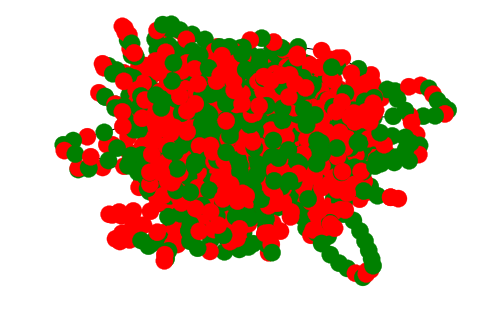

In [40]:
nx.draw(g, cmap = colors.ListedColormap(['green', 'red']), vmin = 0, vmax = 1,
    node_color = [g.node[i]['state'] for i in g.nodes()],
    pos = g.pos)

In [50]:
for i in G_busnew.nodes():
    print(i)

Trelawny - Av Litoral
Hospital del Mar
Platja de la Barceloneta
Pg Marítim - Pepe Rubianes
Pepe Rubianes
Pg  Joan de Borbó
Pla de Palau - Pl Pau Vila
Pg  Colom - Via Laietana
Moll de la Fusta
Portal de la Pau
Les Drassanes
Paral·lel - Drassanes
Metro Paral·lel
Paral·lel - Ronda Sant Pau
Paral·lel - Marquès de Campo Sagrado
Paral·lel - Rocafort
Paral·lel - Floridablanca
Paral·lel - Av Mistral
Creu Coberta - Pl Espanya
Metro Hostafrancs
Sants - Premià
Metro Pl de Sants
Pl de Sants
Sants - Rambla del Brasil
Metro Badal
Arizala - Av Madrid
Arizala - Les Corts
Les Corts - Aurora Bertrana
Collblanc - Cardenal Reig
Ernest Lluch
Cardenal Reig - Pisuerga
Av Sant Ramon Nonat - Cardenal Reig
Metro Collblanc
Sants - Munné
Sants - Badal
Sants - Gayarre
Pl Espanya - Paral·lel
Paral·lel - Tamarit
Metro Poble Sec
Paral·lel - Margarit
Paral·lel - Vila i Vilà
Paral·lel - Cabanes
Pla de Palau
Pg Joan de Borbó
Tarragona - Pl Espanya
Metro Tarragona
Av Roma - Tarragona
Josep Tarradellas - Rosselló
Josep Ta

In [88]:
from matplotlib import colors
import matplotlib.image as mpimg
from PIL import Image
import imageio
import random as rd
import tqdm


#p_i = 0.4512 # infection probability
p_i = 0.0001827460510328068 # infection probability
p_r = 0.95 # recovery probability

g=G_busnew
g.pos = nx.spring_layout(g)
for i in g.nodes():
    if i == 'Pl Espanya - FGC':

        g.node[i]['state'] =  1
    else:
        
        g.node[i]['state'] =  0 ## I have changed 0.5 per 0.01 I want the bus line to be 
                                                           ## fully operative
                                                        ## 0 means it works well  
                                                        ## 1 means failure


In [89]:
for i in g.nodes():
    if g.node[i]['state']==1:
        print(i)


Pl Espanya - FGC


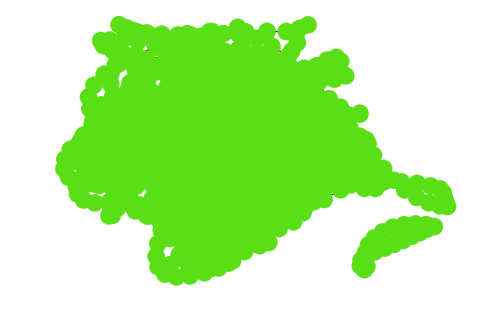

In [90]:
nx.draw(g, cmap = colors.ListedColormap(['#5adf16', 'red']), vmin = 0, vmax = 1,
    node_color = [g.node[i]['state'] for i in g.nodes()])

In [91]:
#p_i = 0.4512 # infection probability
p_i = 0.8 # infection probability
p_r = 0.5 # recovery probability


  0%|          | 0/10 [00:00<?, ?it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/gerardmartinezcanelles/anaconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/gerardmartinezcanelles/anaconda/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/gerardmartinezcanelles/anaconda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 10%|█         | 1/10 [01:02<09:25, 62.82s/it]

INFECTED:  1648


 20%|██        | 2/10 [02:01<08:05, 60.65s/it]

INFECTED:  1632


 30%|███       | 3/10 [03:20<07:48, 66.93s/it]

INFECTED:  1611


 40%|████      | 4/10 [04:24<06:37, 66.19s/it]

INFECTED:  1648


 50%|█████     | 5/10 [05:24<05:24, 64.92s/it]

INFECTED:  1607


 60%|██████    | 6/10 [06:24<04:16, 64.02s/it]

INFECTED:  1630


 70%|███████   | 7/10 [07:22<03:09, 63.18s/it]

INFECTED:  1643


 80%|████████  | 8/10 [08:20<02:05, 62.60s/it]

INFECTED:  1672


 90%|█████████ | 9/10 [09:20<01:02, 62.27s/it]

INFECTED:  1667


100%|██████████| 10/10 [10:19<00:00, 61.95s/it]

INFECTED:  1598
1635.6


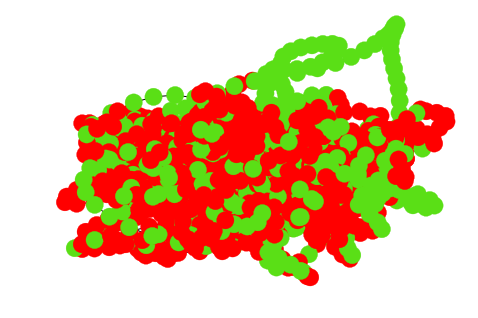

In [86]:
num_infections = []
for i in tqdm.tqdm(range(10)):
    g=G_busnew
    g.pos = nx.spring_layout(g)
    for i in g.nodes():
        if i == 'Pl Espanya - FGC':

            g.node[i]['state'] =  1
        else:

            g.node[i]['state'] =  0 ## I have changed 0.5 per 0.01 I want the bus line to be 
                                                               ## fully operative
                                                            ## 0 means it works well  
                                                            ## 1 means failure

    for i in range(1,1000000):
        a = rd.choice(list(g.nodes()))
        if g.node[a]['state'] == 0: # if susceptible
            b = rd.choice(list(g.neighbors(a)))
            if g.node[b]['state'] == 1: # if neighbor b is infected
                g.node[a]['state'] = 1 if rd.random() < p_i else 0 
        else: # if infected
            g.node[a]['state'] = 0 if rd.random() < p_r else 1

    infected = [n for n in g.nodes() if g.node[n]['state']==1]
    print("INFECTED: ", len(infected))
    num_infections.append(len(infected))
print(sum(num_infections)/len(num_infections))
nx.draw(g, cmap = colors.ListedColormap(['#5adf16', 'red']), vmin = 0, vmax = 1,node_color = [g.node[i]['state'] for i in g.nodes()], pos=g.pos)

 10%|█         | 1/10 [01:06<09:56, 66.22s/it]

INFECTED:  0


 20%|██        | 2/10 [02:04<08:17, 62.13s/it]

INFECTED:  0


 30%|███       | 3/10 [03:04<07:10, 61.44s/it]

INFECTED:  0


 40%|████      | 4/10 [04:05<06:08, 61.36s/it]

INFECTED:  0


 50%|█████     | 5/10 [05:02<05:02, 60.60s/it]

INFECTED:  0


 60%|██████    | 6/10 [06:02<04:01, 60.38s/it]

INFECTED:  0


 70%|███████   | 7/10 [07:02<03:01, 60.42s/it]

INFECTED:  0


 80%|████████  | 8/10 [08:02<02:00, 60.34s/it]

INFECTED:  0


 90%|█████████ | 9/10 [09:01<01:00, 60.16s/it]

INFECTED:  0


100%|██████████| 10/10 [10:00<00:00, 60.05s/it]

INFECTED:  0
0.0


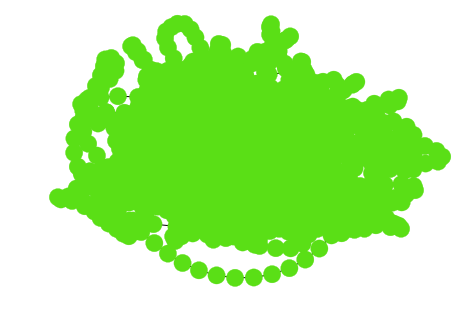

In [92]:
num_infections = []
for i in tqdm.tqdm(range(10)):
    g=G_busnew
    g.pos = nx.spring_layout(g)
    for i in g.nodes():
        if i == 'Pl Espanya - FGC':

            g.node[i]['state'] =  1
        else:

            g.node[i]['state'] =  0 ## I have changed 0.5 per 0.01 I want the bus line to be 
                                                               ## fully operative
                                                            ## 0 means it works well  
                                                            ## 1 means failure

    for i in range(1,1000000):
        a = rd.choice(list(g.nodes()))
        if g.node[a]['state'] == 0: # if susceptible
            b = rd.choice(list(g.neighbors(a)))
            if g.node[b]['state'] == 1: # if neighbor b is infected
                g.node[a]['state'] = 1 if rd.random() < p_i else 0 
        else: # if infected
            g.node[a]['state'] = 0 if rd.random() < p_r else 1

    infected = [n for n in g.nodes() if g.node[n]['state']==1]
    print("INFECTED: ", len(infected))
    num_infections.append(len(infected))
print(sum(num_infections)/len(num_infections))
nx.draw(g, cmap = colors.ListedColormap(['#5adf16', 'red']), vmin = 0, vmax = 1,node_color = [g.node[i]['state'] for i in g.nodes()], pos=g.pos)

In [ ]:
from matplotlib import colors
import matplotlib.image as mpimg
from PIL import Image
import imageio
import random as rd


#p_i = 0.4512 # infection probability
p_i = 0.0001827460510328068 # infection probability
p_r = 0.95 # recovery probability

g=G_bus
g.pos = nx.spring_layout(g)
for i in g.nodes():
    g.node[i]['state'] = 1 if random() < .5 else 0 ## I have changed 0.5 per 0.01 I want the bus line to be 
                                                           ## fully operative
                                                        ## 0 means it works well  
                                                        ## 1 means failure

nx.draw(g, cmap = colors.ListedColormap(['green', 'red']), vmin = 0, vmax = 1,
    node_color = [g.node[i]['state'] for i in g.nodes()],
    pos = g.pos)


for i in range(1,10):
    a = rd.choice(list(g.nodes()))
    if g.node[a]['state'] == 0: # if susceptible
        b = rd.choice(list(g.neighbors(a)))
        if g.node[b]['state'] == 1: # if neighbor b is infected
            g.node[a]['state'] = 1 if rd.random() < p_i else 0 
    else: # if infected
        g.node[a]['state'] = 0 if rd.random() < p_r else 1
    
    nx.draw(g, cmap = colors.ListedColormap(['#5adf16', 'red']), vmin = 0, vmax = 1,
        node_color = [g.node[i]['state'] for i in g.nodes()],
        pos = g.pos)